In [1]:
!pip -q install monai
!pip -q install segmentation-models-pytorch

!pip -q install /kaggle/input/pylibjpeg140py3/pylibjpeg-1.4.0-py3-none-any.whl
!pip -q install /kaggle/input/pylibjpeg140py3/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [2]:
DEBUG = False

import sys
sys.path = [
    '/kaggle/input/covn3d-same',
] + sys.path

In [3]:
import os
import gc
import cv2
import time
import timm
import pydicom
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

2023-09-03 00:42:15.544169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 00:42:16.238023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Config

In [4]:
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_folds = 5


image_seg_size = [128, 128, 128]


init_lr = 3e-3
batch_size = 1
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
use_amp = True
num_workers = 4
out_dim = 5

n_epochs = 100

log_dir = './logs'
model_dir_seg = './models_seg'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir_seg, exist_ok=True)

In [5]:
keys=("image","mask")
interpolation_modes = ('bilinear', 'nearest') 
transforms_train = transforms.Compose([
    #transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1), 
    #transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2), 
    transforms.RandAffined(keys=keys, 
                           rotate_range=(0.2,0.2,0.2), # radians
                           scale_range=(0.2,0.2,0.2),
                           translate_range=[int(x*y) for x, y in zip(image_seg_size, [0.1, 0.1, 0.2])], 
                           padding_mode='zeros',
                           prob=0.7,
                           mode=interpolation_modes,
                           ),
    transforms.RandGridDistortiond(keys=keys, prob=0.5, distort_limit=(-0.03, 0.03), mode=interpolation_modes),    
])

transforms_valid = transforms.Compose([
])

# DataFrame

In [6]:
df_train = pd.read_csv(os.path.join(data_dir,'train_series_meta.csv'))

mask_files = os.listdir(f'{data_dir}/segmentations')
df_mask = pd.DataFrame({
    'mask_file': mask_files,
})
df_mask['series_id'] = (df_mask['mask_file'].apply(lambda x: x[:-4]))
df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir,'segmentations', x))
df_mask['series_id']=df_mask['series_id'].astype(np.int64)
df = df_train.merge(df_mask, on='series_id', how='left')
df['image_folder'] = data_dir+"/train_images/"+df['patient_id'].astype(str)+"/"+df["series_id"].astype(str)
df['mask_file'].fillna('', inplace=True)

df_seg = df.query('mask_file != ""').reset_index(drop=True)

kf = KFold(5,shuffle=True)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail()

,patient_id,series_id,aortic_hu,incomplete_organ,mask_file,image_folder,fold
201,65504,55928,144.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,3
202,7642,778,183.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,1
203,8848,41663,238.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,1
204,8848,7384,367.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,2
205,9813,24149,233.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,4


# Dataset

In [7]:
def load_dicom_2d(path,resize=None): #image_seg_size
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if dicom.PixelRepresentation == 1:
        bit_shift = dicom.BitsAllocated - dicom.BitsStored
        dtype = data.dtype 
        data = (data << bit_shift).astype(dtype) >>  bit_shift
    data = pydicom.pixel_data_handlers.util.apply_modality_lut(data, dicom) 
    if resize:
        data = cv2.resize(data, (resize[0], resize[1]), interpolation = cv2.INTER_LINEAR)
    orient=dicom.ImageOrientationPatient
    pos=dicom.ImagePositionPatient
    data=np.transpose(data,[1,0])

    return data,orient,pos

def window_images(images,img_min = -300,img_max = 400): 
    images[images < img_min] = img_min
    images[images > img_max] = img_max
    
    # normalization
    images = (images - img_min)/(img_max - img_min)
    return (images * 255).astype(np.uint8)


def check_orient(paths):
    dicom1=pydicom.dcmread(paths[0],specific_tags=["ImageOrientationPatient","ImagePositionPatient"])

    dicom2=pydicom.dcmread(paths[-1],specific_tags=["ImageOrientationPatient","ImagePositionPatient"])
    orient=dicom1.ImageOrientationPatient
    positions=[dicom1.ImagePositionPatient,dicom2.ImagePositionPatient]
    imaging_axis=np.cross(orient[:3],orient[3:])
    dot = np.dot(np.array(positions[1])-np.array(positions[0]), imaging_axis)
    return dot

def stack_images(images,orient,positions):
    
    #make sure images are ordered correctly (superior is z+) 
    imaging_axis=np.cross(orient[:3],orient[3:])
    distance_projection = np.dot(np.stack(positions), imaging_axis)
    images = np.stack(images, -1)
    images = images[:,:,np.argsort(distance_projection)]
    return images


def load_dicom_3d(paths,resize_2d=None):

    images = []
    positions=[]
    for filename in paths:
        img,orient,pos=load_dicom_2d(filename,resize=resize_2d)
        images.append(img)
        positions.append(pos)    
 
    images=stack_images(images,orient,positions)
    images = window_images(images)
    return images

def load_dicom_folder(folder,num,resize_2d=None):
    t_paths = sorted(glob(os.path.join(folder, "*")),
                     key=lambda x: int(x.split('/')[-1].split(".")[0]))
    n_scans = len(t_paths)
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., num)).round().astype(int)
    t_paths = [t_paths[i] for i in indices]
    return load_dicom_3d(t_paths,resize_2d=resize_2d)



def load_nii_mask(mask_file,size):
    nib_mask= nib.load(mask_file)
    mask=np.asanyarray(nib_mask.dataobj).astype(np.uint8)
    mask=mask[:,::-1,:]
    mask = Resize(size,mode="nearest")(mask[None,...]).numpy().squeeze()
    mask = mask.astype(np.uint8)
    return mask


def load_image_mask(image_folder, mask_file,resize=image_seg_size):

    image = load_dicom_folder(image_folder,num=resize[2],resize_2d=resize[:2])
   
    if mask_file is not None:
        mask=load_nii_mask(mask_file,resize)
    else:
        mask=None
    
    return image, mask
    

def load_sample(row, has_mask=True):
    mask_file=None
    if has_mask:
        mask_file=row.mask_file
    image,mask=load_image_mask(row.image_folder,mask_file)
    if has_mask:
        return image,mask
    else:
        return image


In [8]:
mask_file="/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/10000.nii"
image_folder="/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/54722/10000"
image,mask=load_image_mask(image_folder,mask_file)


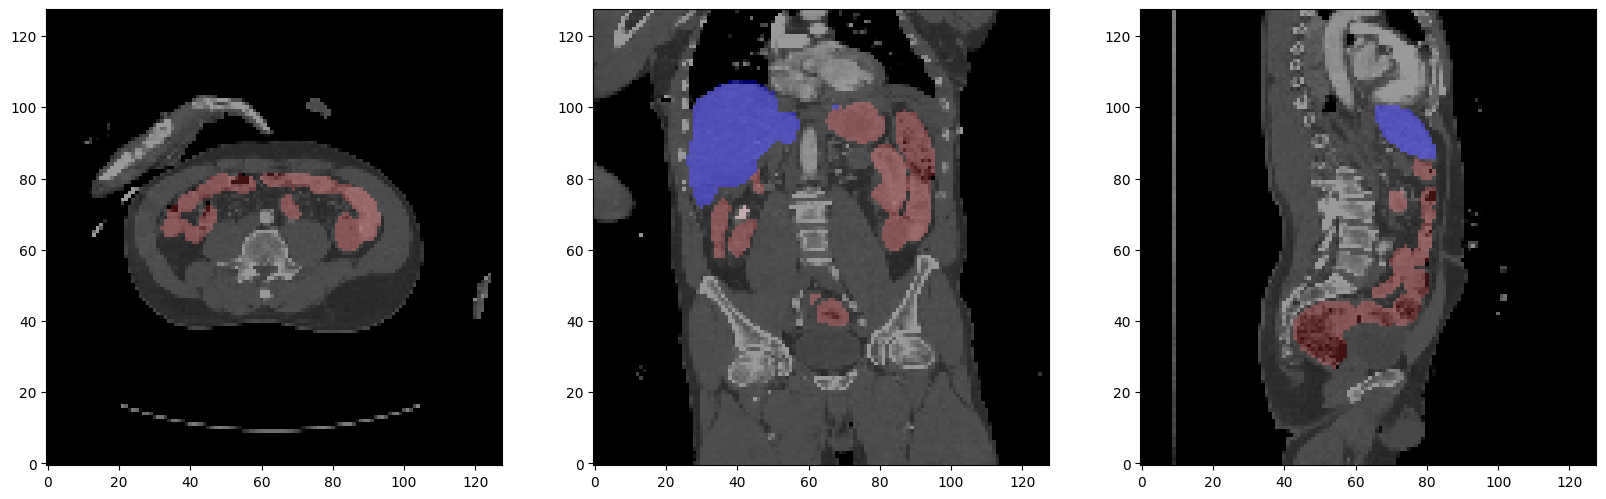

In [9]:
from matplotlib.colors import ListedColormap
#rcParams['figure.figsize'] = 20,8
label_dict = {
    0: 'background',
    1: 'liver',
    2: 'spleen',
    3: 'left kidney',
    4: 'right kidney',
    5: 'bowel'
}

color_dict = {
    0: 'black',
    1: 'blue',
    2: 'green',
    3: 'wheat',
    4: 'pink',
    5: 'brown'
}

cm = ListedColormap(color_dict.values())
def visualize(image,mask=None,title=None,alpha=0.4):
    image=image[:,::-1,:]
    slice1=image.shape[2]//2
    slice2=image.shape[1]//2
    slice3=image.shape[0]//2

    fig,ax=plt.subplots(1,3)
    ax[0].imshow(image[:,:,slice1].T,cmap="gray",origin="lower")
    ax[1].imshow(image[:,slice2,:].T,cmap="gray",origin="lower")
    ax[2].imshow(image[slice3,:,:].T,cmap="gray",origin="lower")
    if mask is not None:
        mask=mask[:,::-1,:]
        ax[0].imshow(mask[:,:,slice1].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')
        ax[1].imshow(mask[:,slice2,:].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')
        ax[2].imshow(mask[slice3,:,:].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')
    fig.suptitle(title)
visualize(image,mask)

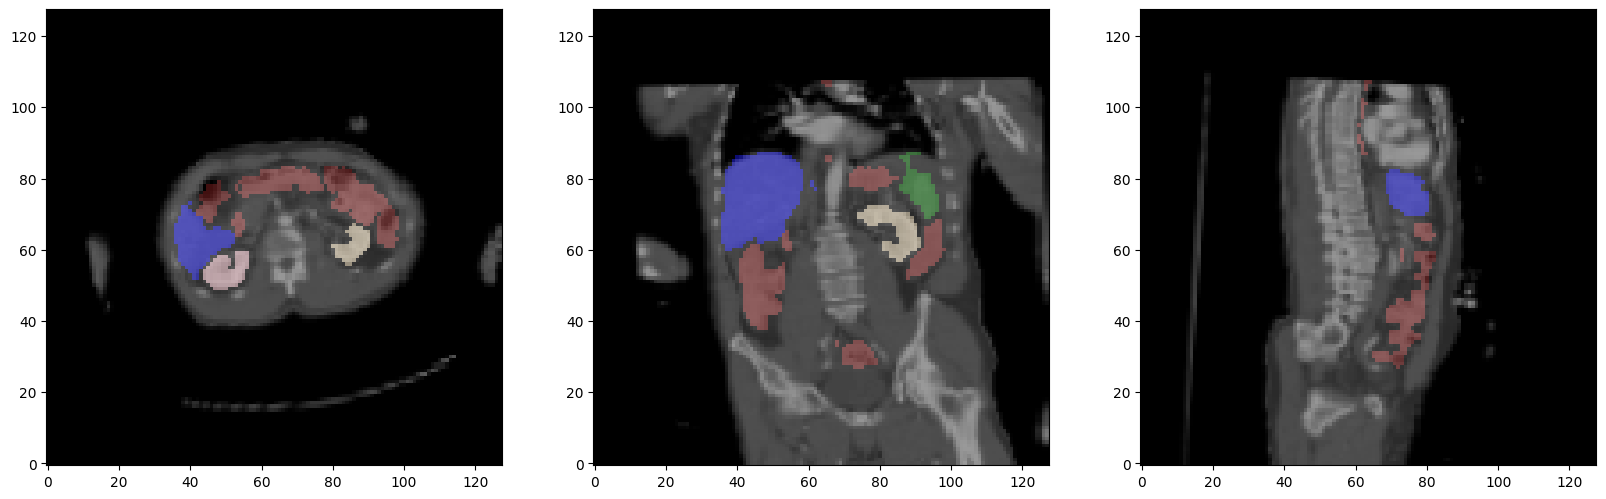

In [10]:
res = transforms_train({'image': np.expand_dims(image, 0).repeat(3, 0), 'mask':mask[None,...]})
im,ma=res["image"],res["mask"]
ma=ma.squeeze().to(torch.int)
im=im[0,...]
im=im.numpy(force=True)
ma=ma.numpy(force=True)
visualize(im,ma)


In [11]:
preprocessed1_dir="preprocessed1"
def preprocess(df,dry_run=False):
    os.makedirs(preprocessed1_dir,exist_ok=True)
    for ind,row in df.iterrows():
        #print(ind,end=" ")
        mask_file=None
        if row.mask_file!="":
            mask_file=row.mask_file
        image_folder=row.image_folder
        print(ind,image_folder,mask_file)
        image,mask=load_image_mask(image_folder,mask_file)
        if not dry_run:
            save_image_file = os.path.join(preprocessed1_dir, f'{row.series_id}.npy')
            np.save(save_image_file,image)
            if mask_file:
                save_mask_file = os.path.join(preprocessed1_dir,f'{row.series_id}_mask.npy')
                np.save(save_mask_file,mask)

PREPROCESS=False
if PREPROCESS:
    preprocess(df)

In [12]:

class SEGDataset(Dataset):
    def __init__(self, df, mode, transform=None,use_preprocessed=True):

        self.df = df
        self.mode = mode
        self.transform = transform
        self.use_preprocessed=use_preprocessed

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        is_test=(self.mode=="test") # in test mode we don't load masks, just predict them
        
        if self.use_preprocessed:
            image_file = os.path.join(preprocessed1_dir, f'{row.series_id}.npy')
            image = np.load(image_file)
            if not is_test:
                mask_file = os.path.join(preprocessed1_dir, f'{row.series_id}_mask.npy')
                mask = np.load(mask_file).astype(np.uint8)
        else:
            image, mask = load_sample(row, has_mask= (not is_test))

        image=torch.from_numpy(image)
        image=image[None,...]
        if not is_test:
            mask=torch.from_numpy(mask)

        if self.transform:
            res = self.transform({'image':image, 'mask':mask[None,...]})   
            image = res['image'] 
            mask = res['mask']
      
        image=image/255.
        if is_test:
            return image
        else:
            mask=mask.squeeze().to(torch.long)
            return image, mask
    


In [13]:


dataset_show = SEGDataset(df_seg, 'train', transform=transforms_train)


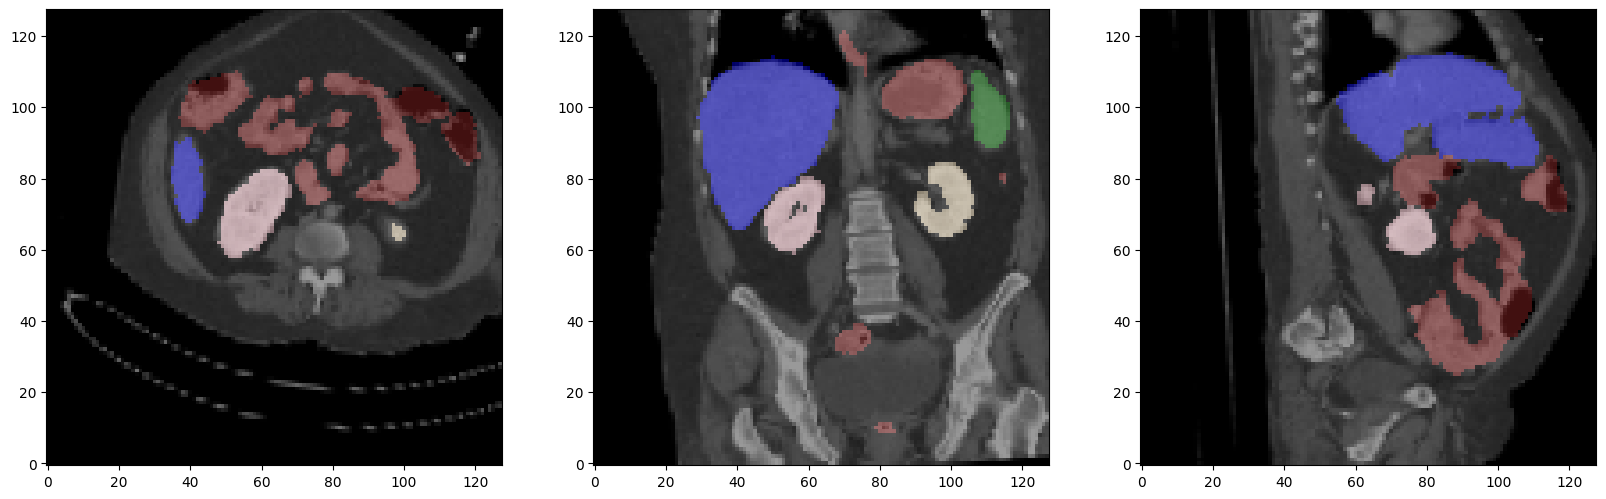

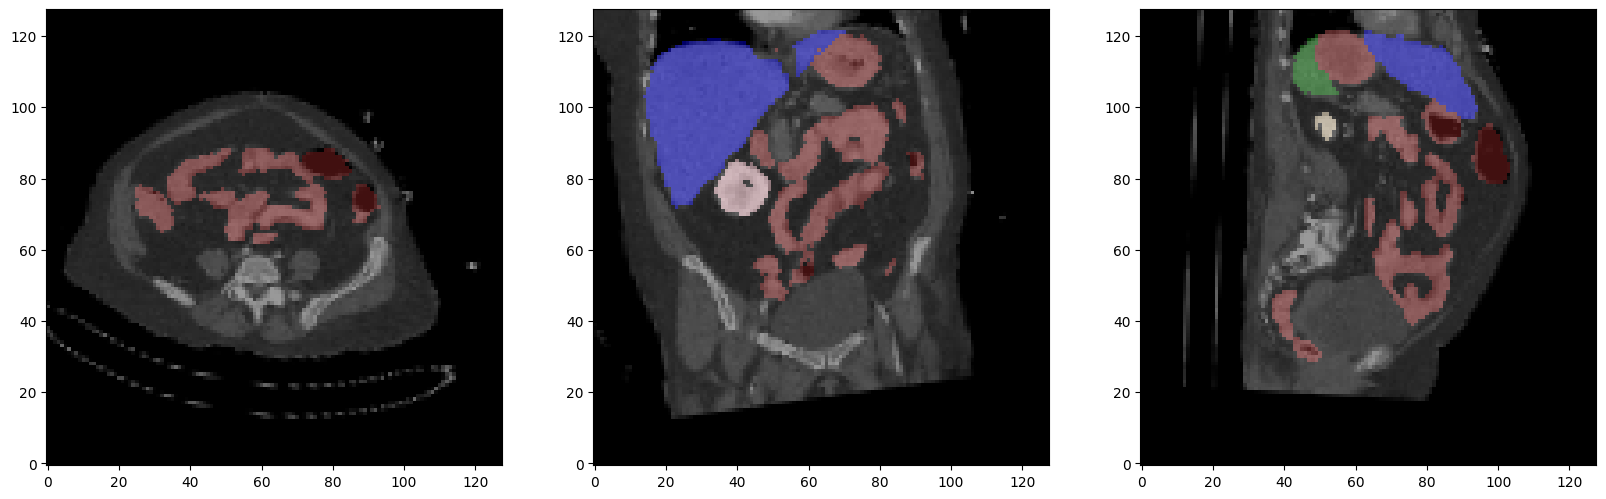

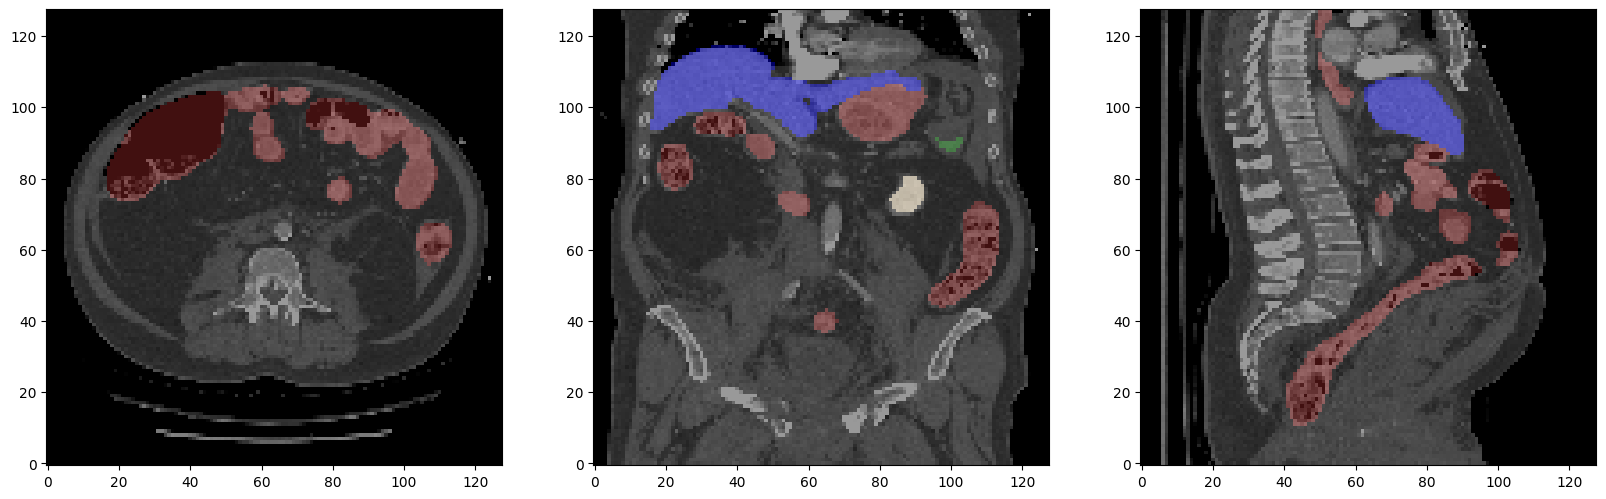

In [14]:
rcParams['figure.figsize'] = 20,8
for i in range(3):
    img, mask = dataset_show[i]
    img=img[0,...]
    img=img.numpy(force=True)
    mask=mask.numpy(force=True)
    visualize(img,mask)

# Model

In [15]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone='resnet18d', segtype='unet', out_dim=6,pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 1, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        n_blocks=4
        if segtype == 'unet':
            self.decoder = smp.decoders.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.n_blocks=n_blocks

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:self.n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [16]:
from timm.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m_2d = TimmSegModel()
m = convert_3d(m_2d)
m(torch.rand(1, 1, 128,128,128)).shape

torch.Size([1, 6, 128, 128, 128])

# Loss & Metric

In [17]:

def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    eps: float = 1e-7,
) -> float:
    
    if (torch.sum(y_true)==0) and (torch.sum(y_pred)==0):
        return (torch.sum(y_true)==0).to(torch.float32)
    else:
        intersection = torch.sum(y_pred * y_true)
        cardinality = torch.sum(y_pred) + torch.sum(y_true)
        score = (2.0 * intersection) / (cardinality + eps)
        return score


def multilabel_dice_score(
    y_true: torch.Tensor, # single image, no batch
    y_pred: torch.Tensor,
    eps=1e-7,
    num_classes=6 # including background
):
    ious = []
    for class_index in range(1,num_classes): #ignore background
        y_pred1=(y_pred==class_index).to(torch.float32)
        y_true1=(y_true==class_index).to(torch.float32)
        iou = binary_dice_score(
            y_pred1,
            y_true1,
            eps=eps,
        )
        ious.append(iou)
        
    ious=torch.stack(ious)
    return ious


def dice_loss(input, target,num_classes=6,do_one_hot=True):
    input = torch.nn.Softmax(dim=1)(input)
    smooth = 1.0
    iflat = input.view(-1)
    if do_one_hot:
        t1hot=F.one_hot(target,num_classes)
    else:
        t1hot=target
    tflat = t1hot.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def ce_dice(input, target, loss_weights=loss_weights):
    #loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss1=loss_weights[0]*nn.CrossEntropyLoss()(input,target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = ce_dice

# Train & Valid func

In [18]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        #do_mixup = False
        #if random.random() < p_mixup:
        #    do_mixup = True
        #    images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            #if do_mixup:
            #    loss2 = criterion(logits, gt_masks_sfl)
            #    loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    batch_metrics = [] 
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()
            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for i in range(logits.shape[0]): # iterate over batch
                y_pred=torch.argmax(logits[i],dim=0)
                y_true=gt_masks[i] 
                tmp = multilabel_dice_score(y_pred,y_true)
                batch_metrics.append(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
    batch_metrics=torch.stack(batch_metrics,dim=0)        
    metrics = torch.mean(batch_metrics,axis=0)
    metrics=metrics.numpy(force=True)
    print('dc:', metrics,"mean",np.mean(metrics))

    return np.mean(valid_loss), np.mean(metrics)


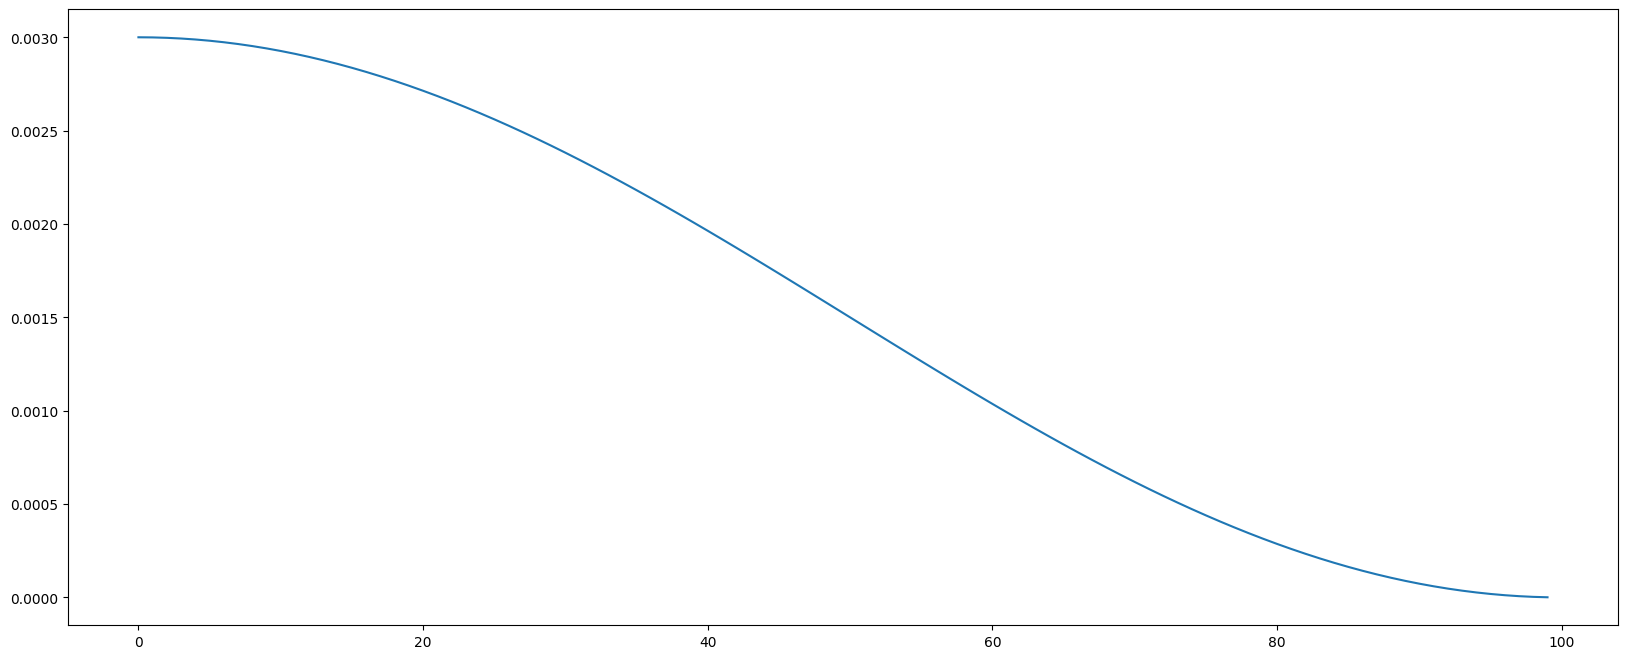

In [19]:

#rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [20]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir_seg, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(pretrained=True)
    model = convert_3d(model)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    metric_best = 0.

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [21]:
TRAIN_STAGE1=False
if TRAIN_STAGE1:
    run(0)
    run(1)
    run(2)
    run(3)
    run(4)

In [22]:
models_seg=[]
for fold in range(5):
    model = TimmSegModel(pretrained=False)
    model = convert_3d(model)
    model = model.to(device)
    load_model_file = os.path.join(model_dir_seg, f'{kernel_type}_fold{fold}_best.pth')
    sd = torch.load(load_model_file)
    if 'model_state_dict' in sd.keys():
        sd = sd['model_state_dict']
    sd = {k[7:] if k.startswith('module.') else k: sd[k] for k in sd.keys()}
    model.load_state_dict(sd, strict=True)
    model.eval()
    models_seg.append(model)

len(models_seg)

5

In [23]:
def infer_masks(df):
    for ind,row in df.iterrows():
        mask_file=None
        if row.mask_file!="":
            continue 
        print(ind,row.series_id)
        
        image1,_=load_image_mask(row.image_folder,None)
        image=(image1/255.).astype(np.float32)
        save_mask_file = os.path.join(preprocessed1_dir,f'{row.series_id}_mask.npy')
        with torch.no_grad():
            image=torch.from_numpy(image).cuda()
            image=image[None,None,...]
            pred_masks = []
            for model in models_seg:
                pmask = model(image).squeeze()
                pmask=nn.Softmax(dim=0)(pmask)
                pred_masks.append(pmask)
        mask = torch.stack(pred_masks, 0).mean(0)
        mask=torch.argmax(mask,dim=0)
        mask=mask.numpy(force=True).astype(np.uint8)
        #visualize(image1,mask)
        np.save(save_mask_file,mask)

PREP_MASKS=False
if PREP_MASKS:
    infer_masks(df)

# Preprocess  Stage 2 crops

In [24]:
import threading
batch_size_seg=1
dataset_seg=SEGDataset(df,mode="valid",use_preprocessed=True)
loader_seg = torch.utils.data.DataLoader(dataset_seg, batch_size=batch_size_seg, shuffle=False, num_workers=num_workers)
mask_size = image_seg_size[2]
n_slice_per_c = [30,30,15,15,90] # liver,spleen,left kidney, right kidney,bowel
n_ch=5

image_size_cls = 224

In [25]:
def load_organ(mask, cid, t_paths, cropped_images,selected_slices):
    n_scans = len(t_paths)
    organ = []
    mask1 = (mask == (cid+1))
    n_slice=n_slice_per_c[cid]
    dot =check_orient(t_paths)
    if dot<0:
        t_paths=t_paths[::-1]
    
    if np.sum(mask1)>0:
        x = np.where(mask1.sum(1).sum(1))[0]
        y = np.where(mask1.sum(0).sum(1))[0]
        z = np.where(mask1.sum(0).sum(0))[0]
        x1, x2 = max(0, x[0] - 1), min(mask1.shape[0], x[-1] + 1)
        y1, y2 = max(0, y[0] - 1), min(mask1.shape[1], y[-1] + 1)
        z1, z2 = max(0, z[0] - 1), min(mask1.shape[2], z[-1] + 1)

        zz1, zz2 = int(z1 / mask_size * n_scans), int(z2 / mask_size * n_scans) # in original
        inds = np.linspace(zz1 ,zz2-1 ,n_slice).astype(int) # in original
        inds_ = np.linspace(z1 ,z2-1 ,n_slice).astype(int) # in mask

        #select_paths=[t_paths[i] for i in inds]
        #image=load_dicom_3d(select_paths)
        #overlay=cv2.resize(mask[:,:,inds_],(512,512),interpolation=cv2.INTER_NEAREST)
        #print(label_dict[cid+1])
        #visualize(image,overlay)

        selected_slices[cid]=[int(t_paths[i].split('/')[-1].split('.')[0]) for i in inds]
        for (ind, ind_) in zip(inds, inds_):
            mask_this = mask1[:, :, ind_]
            istart=ind-n_ch//2
            iend=istart+n_ch
            istart1=max(istart,0)
            iend1=min(iend,n_scans)
            select_paths=[t_paths[i] for i in range(istart1,iend1)]
         
            image=load_dicom_3d(select_paths) # without resizing 
            if istart<0:
                #print("istart",istart)
                pad=np.zeros((image.shape[0], image.shape[1],-istart),dtype=np.uint8)
                image=np.concatenate((pad,image),axis=2)
            if iend>iend1:
                #print("iend",iend,iend1)
                pad=np.zeros((image.shape[0],image.shape[1],iend-iend1),dtype=np.uint8)
                image=np.concatenate((image,pad),axis=2)
            
            mask_this = mask_this[x1:x2, y1:y2]
            xx1 = int(x1 / mask_size * image.shape[0])
            xx2 = int(x2 / mask_size * image.shape[0])
            yy1 = int(y1 / mask_size * image.shape[1])
            yy2 = int(y2 / mask_size * image.shape[1])
            image = image[xx1:xx2, yy1:yy2]
            image = cv2.resize(image, (image_size_cls, image_size_cls), interpolation = cv2.INTER_LINEAR)
            mask_this = (mask_this * 255).astype(np.uint8)
            mask_this = cv2.resize(mask_this, (image_size_cls, image_size_cls), interpolation = cv2.INTER_NEAREST)
            #print(image.shape,mask_this.shape)
            image = np.concatenate([image, mask_this[:, :, np.newaxis]], -1)
            organ.append(image)
        organ=np.stack(organ,0) #(n_slice, H,W,channel)

    else:
        print("organ not found",label_dict[cid+1])
        organ=np.zeros((n_slice_per_c[cid],image_size_cls,image_size_cls,n_ch+1))
        selected_slices[cid]=None

    organ= np.transpose(organ,(0,3, 1, 2)) # (n_slice, channels,H,W) 
    VIS=False
    if VIS:
        orgvis=np.transpose(organ,(1,2,3,0))
        vis=orgvis[n_ch//2,...]
        ma=orgvis[-1,...]/255
        visualize(vis,ma,title=label_dict[cid+1]) 

    #organ=organ.float()/255.
    cropped_images[cid]=organ


def load_cropped_images(msk, image_folder):
    threads = [None] * 5
    cropped_images = [None] * 5 
    selected_slices = [None] * 5

    t_paths = sorted(glob(os.path.join(image_folder, "*")), key=lambda x: int(x.split('/')[-1].split(".")[0]))
    for cid in range(5):
        #load_organ(msk,cid,t_paths,cropped_images)
        threads[cid] = threading.Thread(target=load_organ, args=(msk, cid, t_paths, cropped_images,selected_slices))
        threads[cid].start()
    for cid in range(5):
        threads[cid].join()
    cropped_images=np.concatenate(cropped_images,axis=0)    
    return cropped_images, selected_slices


In [27]:
bar = tqdm(loader_seg)
cls_crops_folder="preprocessed2"
bowel_crops_folder="bowel"
df_image=pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
with torch.no_grad():
    for batch_id, (images,masks) in tqdm(enumerate(bar)):
        
        # SEG
        #images = images.cuda()
        #pred_masks = []
        #for model in models_seg:
        #    pmask = model(images)
        #    pmask=nn.Softmax(dim=1)(pmask)
        #    pred_masks.append(pmask)
        #pred_masks = torch.stack(pred_masks, 0).mean(0).cpu().numpy()
        #pred_masks=torch.argmax(pred_masks,dim=0)
        pred_masks=masks.numpy(force=True)

        for i in range(pred_masks.shape[0]):
            ind=batch_id*batch_size_seg+i
            row = df.iloc[ind]
            print(ind,row.patient_id,row.series_id)
            cropped_images,instance_numbers = load_cropped_images(pred_masks[i,...], row.image_folder)
            nlsk=sum(n_slice_per_c[:4])
            lsk=cropped_images[:nlsk,...]
            bowel=cropped_images[nlsk:,...]
            #print(cropped_images.shape)
            np.savez_compressed(f'{cls_crops_folder}/{row.patient_id}_{row.series_id}',lsk)
            ibowel_injury=df_image[(df_image["patient_id"]==row.patient_id) & (df_image["series_id"]==row.series_id) & (df_image["injury_name"]=="Bowel")]["instance_number"].tolist()
            instance_bowel=np.array(instance_numbers[4])
            b=np.isin(instance_bowel,ibowel_injury).astype(np.uint8)
            if len(ibowel_injury)>0:
                print("bowel injury")
                print(len(ibowel_injury),np.sum(b))
            assert not (len(ibowel_injury)>0 and np.sum(b)==0)
            np.savez_compressed(f'{bowel_crops_folder}/{row.patient_id}_{row.series_id}',bowel,b)
            
            gc.collect()



  0%|          | 0/4711 [00:00<?, ?it/s]

0 10004 21057


  0%|          | 1/4711 [00:10<14:10:00, 10.83s/it]

1 10004 51033


  0%|          | 2/4711 [00:21<13:50:56, 10.59s/it]

2 10005 18667


  0%|          | 3/4711 [00:32<14:08:08, 10.81s/it]

3 10007 47578


  0%|          | 4/4711 [00:42<14:01:38, 10.73s/it]

4 10026 29700


  0%|          | 5/4711 [00:55<15:01:41, 11.50s/it]

5 10026 42932


  0%|          | 6/4711 [01:10<16:31:11, 12.64s/it]

6 10051 17486


  0%|          | 7/4711 [01:21<15:44:41, 12.05s/it]

7 10051 50172


  0%|          | 8/4711 [01:32<15:19:53, 11.74s/it]

8 10065 37324
bowel injury
23 15


  0%|          | 9/4711 [01:43<14:52:05, 11.38s/it]

9 10065 46839


  0%|          | 10/4711 [01:53<14:37:13, 11.20s/it]

10 10082 8139


  0%|          | 11/4711 [02:05<14:37:14, 11.20s/it]

11 10104 27573


  0%|          | 12/4711 [02:15<14:24:03, 11.03s/it]

12 10105 42418
organ not found spleen
organ not found left kidney


  0%|          | 13/4711 [02:31<16:09:19, 12.38s/it]

13 10124 58500


  0%|          | 14/4711 [02:41<15:24:22, 11.81s/it]

14 10127 1554


  0%|          | 15/4711 [02:54<15:50:43, 12.15s/it]

15 10127 53380


  0%|          | 16/4711 [03:07<16:11:04, 12.41s/it]

16 10132 4816


  0%|          | 17/4711 [03:19<16:05:01, 12.34s/it]

17 10163 17557


  0%|          | 18/4711 [03:31<15:43:55, 12.07s/it]

18 10169 18334


  0%|          | 19/4711 [03:43<15:48:47, 12.13s/it]

19 10172 50253


  0%|          | 20/4711 [03:54<15:23:35, 11.81s/it]

20 10205 65236


  0%|          | 21/4711 [04:05<15:04:30, 11.57s/it]

21 10217 16066


  0%|          | 22/4711 [04:18<15:36:10, 11.98s/it]

22 10228 30522


  0%|          | 23/4711 [04:29<15:16:35, 11.73s/it]

23 10228 40471


  1%|          | 24/4711 [04:40<15:02:57, 11.56s/it]

24 10232 14541


  1%|          | 25/4711 [04:52<14:52:25, 11.43s/it]

25 10232 51162


  1%|          | 26/4711 [05:03<14:45:36, 11.34s/it]

26 10249 2346


  1%|          | 27/4711 [05:14<14:42:16, 11.30s/it]

27 10249 60095


  1%|          | 28/4711 [05:25<14:26:16, 11.10s/it]

28 1027 24515


  1%|          | 29/4711 [05:35<14:19:18, 11.01s/it]

29 1027 60982


  1%|          | 30/4711 [05:46<14:19:14, 11.01s/it]

30 10275 14254


  1%|          | 31/4711 [05:58<14:23:49, 11.07s/it]

31 10275 37142


  1%|          | 32/4711 [06:08<14:15:52, 10.98s/it]

32 10292 14945


  1%|          | 33/4711 [06:19<14:00:24, 10.78s/it]

33 10295 10410


  1%|          | 34/4711 [06:29<13:56:06, 10.73s/it]

34 10300 31085


  1%|          | 35/4711 [06:40<13:59:13, 10.77s/it]

35 10430 47009


  1%|          | 36/4711 [06:52<14:29:26, 11.16s/it]

36 10430 52259


  1%|          | 37/4711 [07:05<15:07:11, 11.65s/it]

37 10443 15679


  1%|          | 38/4711 [07:16<14:50:35, 11.43s/it]

38 10443 4991


  1%|          | 39/4711 [07:27<14:36:15, 11.25s/it]

39 10465 4405


  1%|          | 40/4711 [07:38<14:32:47, 11.21s/it]

40 10465 48503


  1%|          | 41/4711 [07:49<14:42:21, 11.34s/it]

41 10494 65369


  1%|          | 42/4711 [08:01<14:50:23, 11.44s/it]

42 10503 4930


  1%|          | 43/4711 [08:12<14:29:32, 11.18s/it]

43 10503 60534


  1%|          | 44/4711 [08:22<14:10:02, 10.93s/it]

44 10517 21579


  1%|          | 45/4711 [08:32<13:38:30, 10.53s/it]

45 10517 26790


  1%|          | 46/4711 [08:42<13:27:42, 10.39s/it]

46 10550 27106


  1%|          | 47/4711 [08:55<14:39:20, 11.31s/it]

47 10550 44149


  1%|          | 48/4711 [09:06<14:32:57, 11.23s/it]

48 10556 17060


  1%|          | 49/4711 [09:17<14:24:38, 11.13s/it]

49 10557 59654


  1%|          | 50/4711 [09:29<14:46:00, 11.41s/it]

50 10565 16281


  1%|          | 51/4711 [09:40<14:26:03, 11.15s/it]

51 10569 26870


  1%|          | 52/4711 [09:51<14:31:38, 11.23s/it]

52 10569 29394


  1%|          | 53/4711 [10:03<14:39:35, 11.33s/it]

53 1060 29529


  1%|          | 54/4711 [10:14<14:35:10, 11.28s/it]

54 10683 14324


  1%|          | 55/4711 [10:25<14:34:23, 11.27s/it]

55 10683 3716
organ not found right kidney


  1%|          | 56/4711 [10:42<16:53:04, 13.06s/it]

56 10696 62306


  1%|          | 57/4711 [10:53<16:01:36, 12.40s/it]

57 10697 27005


  1%|          | 58/4711 [11:04<15:29:49, 11.99s/it]

58 10697 59033


  1%|▏         | 59/4711 [11:15<15:00:54, 11.62s/it]

59 10721 48437


  1%|▏         | 60/4711 [11:26<14:43:08, 11.39s/it]

60 10721 63796
organ not found right kidney


  1%|▏         | 61/4711 [11:43<16:48:55, 13.02s/it]

61 10722 46573


  1%|▏         | 62/4711 [11:55<16:41:01, 12.92s/it]

62 10722 50314


  1%|▏         | 63/4711 [12:08<16:42:51, 12.95s/it]

63 10730 15721


  1%|▏         | 64/4711 [12:20<16:06:56, 12.48s/it]

64 10759 65139


  1%|▏         | 65/4711 [12:30<15:23:13, 11.92s/it]

65 10762 27788


  1%|▏         | 66/4711 [12:42<15:05:06, 11.69s/it]

66 10795 38360


  1%|▏         | 67/4711 [12:55<15:39:41, 12.14s/it]

67 10814 56132


  1%|▏         | 68/4711 [13:07<15:50:16, 12.28s/it]

68 10852 37069


  1%|▏         | 69/4711 [13:18<15:20:05, 11.89s/it]

69 10917 30843
bowel injury
104 24


  1%|▏         | 70/4711 [13:29<14:46:51, 11.47s/it]

70 10917 47610
bowel injury
63 14


  2%|▏         | 71/4711 [13:39<14:25:24, 11.19s/it]

71 10925 54600


  2%|▏         | 72/4711 [13:50<14:13:36, 11.04s/it]

72 10929 34169
bowel injury
38 33


  2%|▏         | 73/4711 [14:01<14:14:35, 11.06s/it]

73 10937 12039


  2%|▏         | 74/4711 [14:11<13:54:53, 10.80s/it]

74 10937 53000


  2%|▏         | 75/4711 [14:22<13:43:40, 10.66s/it]

75 10967 3609


  2%|▏         | 76/4711 [14:33<13:54:17, 10.80s/it]

76 10967 58150


  2%|▏         | 77/4711 [14:44<13:55:23, 10.82s/it]

77 10981 53877


  2%|▏         | 78/4711 [14:55<14:00:21, 10.88s/it]

78 10987 5611


  2%|▏         | 79/4711 [15:07<14:23:28, 11.18s/it]

79 11021 58443


  2%|▏         | 80/4711 [15:18<14:22:52, 11.18s/it]

80 11030 18685


  2%|▏         | 81/4711 [15:29<14:31:32, 11.29s/it]

81 11044 37630


  2%|▏         | 82/4711 [15:40<14:29:42, 11.27s/it]

82 11046 19484


  2%|▏         | 83/4711 [15:50<13:59:00, 10.88s/it]

83 11046 29137


  2%|▏         | 84/4711 [16:00<13:38:46, 10.62s/it]

84 11130 8511


  2%|▏         | 85/4711 [16:11<13:36:09, 10.59s/it]

85 11139 24201


  2%|▏         | 86/4711 [16:22<13:39:30, 10.63s/it]

86 11139 31481


  2%|▏         | 87/4711 [16:32<13:32:21, 10.54s/it]

87 11177 13041


  2%|▏         | 88/4711 [16:43<13:44:17, 10.70s/it]

88 11177 29167


  2%|▏         | 89/4711 [16:54<13:45:50, 10.72s/it]

89 11217 48987
organ not found right kidney


  2%|▏         | 90/4711 [17:10<15:52:08, 12.36s/it]

90 11217 54368


  2%|▏         | 91/4711 [17:21<15:10:59, 11.83s/it]

91 11222 28997


  2%|▏         | 92/4711 [17:32<14:54:26, 11.62s/it]

92 11222 6366
organ not found left kidney
organ not found right kidney


  2%|▏         | 93/4711 [17:47<16:16:30, 12.69s/it]

93 11301 2703


  2%|▏         | 94/4711 [17:58<15:35:54, 12.16s/it]

94 11301 57412


  2%|▏         | 95/4711 [18:09<15:02:21, 11.73s/it]

95 11312 51300


  2%|▏         | 96/4711 [18:19<14:25:55, 11.26s/it]

96 11313 48992


  2%|▏         | 97/4711 [18:31<14:50:48, 11.58s/it]

97 11335 24276
bowel injury
31 19


  2%|▏         | 98/4711 [18:42<14:36:08, 11.40s/it]

98 11335 39434
bowel injury
26 24


  2%|▏         | 99/4711 [18:59<16:42:19, 13.04s/it]

99 11361 2204


  2%|▏         | 100/4711 [19:10<16:02:05, 12.52s/it]

100 11378 16846


  2%|▏         | 101/4711 [19:21<15:20:51, 11.99s/it]

101 11378 53429


  2%|▏         | 102/4711 [19:32<14:53:56, 11.64s/it]

102 11379 1126


  2%|▏         | 103/4711 [19:43<14:37:42, 11.43s/it]

103 11379 28676


  2%|▏         | 104/4711 [19:54<14:30:33, 11.34s/it]

104 11433 16534


  2%|▏         | 105/4711 [20:05<14:25:42, 11.28s/it]

105 11433 64815


  2%|▏         | 106/4711 [20:16<14:16:24, 11.16s/it]

106 1144 37533


  2%|▏         | 107/4711 [20:29<15:01:09, 11.74s/it]

107 11449 1383


  2%|▏         | 108/4711 [20:41<15:10:25, 11.87s/it]

108 11452 64202


  2%|▏         | 109/4711 [20:52<14:41:55, 11.50s/it]

109 11464 48184


  2%|▏         | 110/4711 [21:03<14:26:51, 11.30s/it]

110 11474 4654


  2%|▏         | 111/4711 [21:15<14:46:19, 11.56s/it]

111 11479 5547


  2%|▏         | 112/4711 [21:28<15:30:22, 12.14s/it]

112 11547 6116


  2%|▏         | 113/4711 [21:39<15:08:15, 11.85s/it]

113 11553 26353


  2%|▏         | 114/4711 [21:52<15:32:39, 12.17s/it]

114 11578 56112


  2%|▏         | 115/4711 [22:04<15:20:24, 12.02s/it]

115 11597 17580


  2%|▏         | 116/4711 [22:16<15:09:43, 11.88s/it]

116 11597 32735


  2%|▏         | 117/4711 [22:27<15:03:54, 11.81s/it]

117 11604 14609


  3%|▎         | 118/4711 [22:39<14:55:24, 11.70s/it]

118 11604 51515


  3%|▎         | 119/4711 [22:50<14:54:12, 11.68s/it]

119 11633 41167


  3%|▎         | 120/4711 [23:03<15:15:17, 11.96s/it]

120 11652 39013


  3%|▎         | 121/4711 [23:14<14:54:54, 11.70s/it]

121 11656 37803


  3%|▎         | 122/4711 [23:25<14:39:12, 11.50s/it]

122 11664 37456


  3%|▎         | 123/4711 [23:36<14:29:15, 11.37s/it]

123 11682 25954


  3%|▎         | 124/4711 [23:49<15:00:47, 11.78s/it]

124 11695 20475


  3%|▎         | 125/4711 [24:00<14:46:58, 11.60s/it]

125 11699 46686


  3%|▎         | 126/4711 [24:11<14:34:14, 11.44s/it]

126 11699 52851


  3%|▎         | 127/4711 [24:22<14:19:20, 11.25s/it]

127 11770 11416


  3%|▎         | 128/4711 [24:33<14:09:16, 11.12s/it]

128 11793 55528


  3%|▎         | 129/4711 [24:44<14:07:53, 11.10s/it]

129 11803 28720


  3%|▎         | 130/4711 [24:54<13:46:20, 10.82s/it]

130 11803 57014


  3%|▎         | 131/4711 [25:05<13:53:17, 10.92s/it]

131 11828 5605


  3%|▎         | 132/4711 [25:17<14:25:28, 11.34s/it]

132 11829 12057


  3%|▎         | 133/4711 [25:29<14:28:48, 11.39s/it]

133 11832 34925


  3%|▎         | 134/4711 [25:41<14:33:28, 11.45s/it]

134 11832 5353


  3%|▎         | 135/4711 [25:52<14:31:44, 11.43s/it]

135 11834 17000


  3%|▎         | 136/4711 [26:02<14:03:19, 11.06s/it]

136 11834 57414


  3%|▎         | 137/4711 [26:13<13:56:36, 10.97s/it]

137 11886 17037


  3%|▎         | 138/4711 [26:24<13:54:32, 10.95s/it]

138 11886 54658


  3%|▎         | 139/4711 [26:35<13:52:19, 10.92s/it]

139 11891 13209


  3%|▎         | 140/4711 [26:48<14:54:02, 11.74s/it]

140 11891 55742


  3%|▎         | 141/4711 [27:04<16:16:26, 12.82s/it]

141 11908 10773


  3%|▎         | 142/4711 [27:14<15:31:21, 12.23s/it]

142 1192 39389


  3%|▎         | 143/4711 [27:25<14:46:19, 11.64s/it]

143 11925 33599
bowel injury
155 22


  3%|▎         | 144/4711 [27:37<15:00:37, 11.83s/it]

144 11925 60003
bowel injury
145 20


  3%|▎         | 145/4711 [27:49<15:07:57, 11.93s/it]

145 11927 13991


  3%|▎         | 146/4711 [28:00<14:47:57, 11.67s/it]

146 11938 51844


  3%|▎         | 147/4711 [28:11<14:24:57, 11.37s/it]

147 11938 54660


  3%|▎         | 148/4711 [28:22<14:09:48, 11.17s/it]

148 12008 42623


  3%|▎         | 149/4711 [28:31<13:36:41, 10.74s/it]

149 12008 54095


  3%|▎         | 150/4711 [28:41<13:22:11, 10.55s/it]

150 12011 28841


  3%|▎         | 151/4711 [28:54<14:03:15, 11.10s/it]

151 12086 16498


  3%|▎         | 152/4711 [29:05<14:00:01, 11.06s/it]

152 12086 47491


  3%|▎         | 153/4711 [29:16<13:53:01, 10.97s/it]

153 12138 31965


  3%|▎         | 154/4711 [29:26<13:35:04, 10.73s/it]

154 12138 39072


  3%|▎         | 155/4711 [29:36<13:14:21, 10.46s/it]

155 12162 65382


  3%|▎         | 156/4711 [29:46<13:21:16, 10.55s/it]

156 12181 19063


  3%|▎         | 157/4711 [29:57<13:27:52, 10.64s/it]

157 12181 64739


  3%|▎         | 158/4711 [30:08<13:37:44, 10.78s/it]

158 12192 45638


  3%|▎         | 159/4711 [30:19<13:40:14, 10.81s/it]

159 12192 47364


  3%|▎         | 160/4711 [30:30<13:40:35, 10.82s/it]

160 12198 37127


  3%|▎         | 161/4711 [30:41<13:36:36, 10.77s/it]

161 122 21217


  3%|▎         | 162/4711 [30:55<15:08:17, 11.98s/it]

162 122 8218


  3%|▎         | 163/4711 [31:09<15:38:48, 12.39s/it]

163 12210 25323


  3%|▎         | 164/4711 [31:20<15:14:25, 12.07s/it]

164 12258 39773


  4%|▎         | 165/4711 [31:31<14:46:10, 11.70s/it]

165 12258 57371


  4%|▎         | 166/4711 [31:42<14:34:02, 11.54s/it]

166 12268 5102


  4%|▎         | 167/4711 [31:53<14:23:12, 11.40s/it]

167 12271 30378


  4%|▎         | 168/4711 [32:04<14:14:52, 11.29s/it]

168 12271 5223


  4%|▎         | 169/4711 [32:15<13:53:34, 11.01s/it]

169 12299 29733


  4%|▎         | 170/4711 [32:26<14:12:49, 11.27s/it]

170 12299 47275


  4%|▎         | 171/4711 [32:38<14:20:58, 11.38s/it]

171 1230 53360


  4%|▎         | 172/4711 [32:49<14:03:47, 11.15s/it]

172 12332 15276
bowel injury
15 8


  4%|▎         | 173/4711 [33:00<14:02:33, 11.14s/it]

173 12332 2793
bowel injury
13 13


  4%|▎         | 174/4711 [33:11<13:59:25, 11.10s/it]

174 12347 11403


  4%|▎         | 175/4711 [33:21<13:30:41, 10.72s/it]

175 12347 54841


  4%|▎         | 176/4711 [33:31<13:15:20, 10.52s/it]

176 12354 59633


  4%|▍         | 177/4711 [33:42<13:41:20, 10.87s/it]

177 12358 11810


  4%|▍         | 178/4711 [33:55<14:16:04, 11.33s/it]

178 12408 30860


  4%|▍         | 179/4711 [34:06<14:07:14, 11.22s/it]

179 12408 39209


  4%|▍         | 180/4711 [34:17<14:03:02, 11.16s/it]

180 12416 62482


  4%|▍         | 181/4711 [34:29<14:17:19, 11.36s/it]

181 12450 13297


  4%|▍         | 182/4711 [34:40<14:15:27, 11.33s/it]

182 12451 41994


  4%|▍         | 183/4711 [34:51<14:19:30, 11.39s/it]

183 12485 34212


  4%|▍         | 184/4711 [35:03<14:18:53, 11.38s/it]

184 12485 8754


  4%|▍         | 185/4711 [35:14<14:18:12, 11.38s/it]

185 12487 26638


  4%|▍         | 186/4711 [35:25<14:16:48, 11.36s/it]

186 12487 8913


  4%|▍         | 187/4711 [35:36<14:06:03, 11.22s/it]

187 1250 56073


  4%|▍         | 188/4711 [35:48<14:14:14, 11.33s/it]

188 12510 18649


  4%|▍         | 189/4711 [36:00<14:21:45, 11.43s/it]

189 12510 33610


  4%|▍         | 190/4711 [36:11<14:29:56, 11.55s/it]

190 12511 59780


  4%|▍         | 191/4711 [36:22<14:16:54, 11.37s/it]

191 12522 24336


  4%|▍         | 192/4711 [36:33<14:07:31, 11.25s/it]

192 12522 51893


  4%|▍         | 193/4711 [36:44<13:54:32, 11.08s/it]

193 12528 30483


  4%|▍         | 194/4711 [36:59<15:18:54, 12.21s/it]

194 12528 59967


  4%|▍         | 195/4711 [37:12<15:30:19, 12.36s/it]

195 12545 2971


  4%|▍         | 196/4711 [37:22<14:53:52, 11.88s/it]

196 12545 4718


  4%|▍         | 197/4711 [37:34<14:38:58, 11.68s/it]

197 12580 25755


  4%|▍         | 198/4711 [37:45<14:27:38, 11.54s/it]

198 12580 63770


  4%|▍         | 199/4711 [37:56<14:18:14, 11.41s/it]

199 12600 3309


  4%|▍         | 200/4711 [38:06<13:54:36, 11.10s/it]

200 12622 11637


  4%|▍         | 201/4711 [38:17<13:42:43, 10.95s/it]

201 12622 1970


  4%|▍         | 202/4711 [38:28<13:44:41, 10.97s/it]

202 12629 18097


  4%|▍         | 203/4711 [38:40<14:10:47, 11.32s/it]

203 12646 10065


  4%|▍         | 204/4711 [38:52<14:28:33, 11.56s/it]

204 12667 16083


  4%|▍         | 205/4711 [39:03<14:15:56, 11.40s/it]

205 12685 26417


  4%|▍         | 206/4711 [39:15<14:23:50, 11.51s/it]

206 12685 9181


  4%|▍         | 207/4711 [39:26<14:24:18, 11.51s/it]

207 12698 5060


  4%|▍         | 208/4711 [39:37<14:11:33, 11.35s/it]

208 12698 60031


  4%|▍         | 209/4711 [39:48<13:52:12, 11.09s/it]

209 12744 37732


  4%|▍         | 210/4711 [39:59<13:47:53, 11.04s/it]

210 12744 47219


  4%|▍         | 211/4711 [40:10<13:39:48, 10.93s/it]

211 1278 34096


  5%|▍         | 212/4711 [40:21<13:40:23, 10.94s/it]

212 12862 10468


  5%|▍         | 213/4711 [40:31<13:25:42, 10.75s/it]

213 12862 27408


  5%|▍         | 214/4711 [40:41<13:10:27, 10.55s/it]

214 12875 29304


  5%|▍         | 215/4711 [40:51<12:56:03, 10.36s/it]

215 12875 56431


  5%|▍         | 216/4711 [41:01<12:54:24, 10.34s/it]

216 12879 53477


  5%|▍         | 217/4711 [41:11<12:48:11, 10.26s/it]

217 12879 58126


  5%|▍         | 218/4711 [41:21<12:41:50, 10.17s/it]

218 12890 20535


  5%|▍         | 219/4711 [41:32<12:49:23, 10.28s/it]

219 12890 3231


  5%|▍         | 220/4711 [41:42<12:52:17, 10.32s/it]

220 12893 992
organ not found right kidney


  5%|▍         | 221/4711 [42:00<15:43:58, 12.61s/it]

221 12898 54190


  5%|▍         | 222/4711 [42:10<14:35:46, 11.71s/it]

222 12898 55455


  5%|▍         | 223/4711 [42:19<13:50:05, 11.10s/it]

223 12930 11299


  5%|▍         | 224/4711 [42:30<13:46:27, 11.05s/it]

224 12930 34757


  5%|▍         | 225/4711 [42:41<13:41:38, 10.99s/it]

225 12951 21811
bowel injury
92 17


  5%|▍         | 226/4711 [42:53<13:59:58, 11.24s/it]

226 12958 18631
bowel injury
49 20


  5%|▍         | 227/4711 [43:04<13:50:48, 11.12s/it]

227 12958 48088
organ not found left kidney
bowel injury
2 3


  5%|▍         | 228/4711 [43:20<15:57:07, 12.81s/it]

228 12967 55621


  5%|▍         | 229/4711 [43:34<16:08:32, 12.97s/it]

229 12976 17784


  5%|▍         | 230/4711 [43:44<14:56:22, 12.00s/it]

230 12976 34894


  5%|▍         | 231/4711 [43:53<14:05:00, 11.32s/it]

231 12997 1941


  5%|▍         | 232/4711 [44:03<13:35:32, 10.92s/it]

232 12997 6573


  5%|▍         | 233/4711 [44:14<13:21:42, 10.74s/it]

233 13012 38013


  5%|▍         | 234/4711 [44:25<13:36:50, 10.95s/it]

234 13036 52432


  5%|▍         | 235/4711 [44:35<13:19:45, 10.72s/it]

235 13036 63928


  5%|▌         | 236/4711 [44:46<13:17:42, 10.70s/it]

236 13067 40939


  5%|▌         | 237/4711 [44:57<13:35:33, 10.94s/it]

237 13083 21099


  5%|▌         | 238/4711 [45:08<13:29:55, 10.86s/it]

238 13098 12274


  5%|▌         | 239/4711 [45:19<13:29:28, 10.86s/it]

239 13098 77


  5%|▌         | 240/4711 [45:30<13:34:55, 10.94s/it]

240 13106 12049


  5%|▌         | 241/4711 [45:41<13:29:18, 10.86s/it]

241 13106 5011


  5%|▌         | 242/4711 [45:51<13:19:56, 10.74s/it]

242 13107 36353


  5%|▌         | 243/4711 [46:01<13:02:27, 10.51s/it]

243 13107 53823


  5%|▌         | 244/4711 [46:11<12:53:31, 10.39s/it]

244 13120 51903


  5%|▌         | 245/4711 [46:21<12:44:08, 10.27s/it]

245 13120 6814


  5%|▌         | 246/4711 [46:31<12:35:42, 10.16s/it]

246 1316 43094


  5%|▌         | 247/4711 [46:43<13:23:31, 10.80s/it]

247 1316 5984


  5%|▌         | 248/4711 [46:56<14:00:42, 11.30s/it]

248 13182 45080
organ not found left kidney


  5%|▌         | 249/4711 [47:16<17:20:08, 13.99s/it]

249 13231 31094


  5%|▌         | 250/4711 [47:26<15:53:14, 12.82s/it]

250 13231 769


  5%|▌         | 251/4711 [47:36<14:51:46, 12.00s/it]

251 13241 32669


  5%|▌         | 252/4711 [47:47<14:22:08, 11.60s/it]

252 13241 33607


  5%|▌         | 253/4711 [47:58<14:06:04, 11.39s/it]

253 13250 26989


  5%|▌         | 254/4711 [48:08<13:44:13, 11.10s/it]

254 13250 64604


  5%|▌         | 255/4711 [48:18<13:20:23, 10.78s/it]

255 1330 18309


  5%|▌         | 256/4711 [48:31<14:00:01, 11.31s/it]

256 1330 32979


  5%|▌         | 257/4711 [48:43<14:15:39, 11.53s/it]

257 13310 45088


  5%|▌         | 258/4711 [48:55<14:32:34, 11.76s/it]

258 13316 41070


  5%|▌         | 259/4711 [49:06<14:06:11, 11.40s/it]

259 13316 48255


  6%|▌         | 260/4711 [49:16<13:49:14, 11.18s/it]

260 13326 29623


  6%|▌         | 261/4711 [49:28<13:47:52, 11.16s/it]

261 13326 32479


  6%|▌         | 262/4711 [49:39<13:44:48, 11.12s/it]

262 13332 20150


  6%|▌         | 263/4711 [49:49<13:34:19, 10.98s/it]

263 13332 25365


  6%|▌         | 264/4711 [50:00<13:23:31, 10.84s/it]

264 13385 34825


  6%|▌         | 265/4711 [50:11<13:21:02, 10.81s/it]

265 13403 21078
organ not found left kidney
organ not found right kidney
bowel injury
9 14


  6%|▌         | 266/4711 [50:27<15:16:44, 12.37s/it]

266 13403 64814
bowel injury
24 11


  6%|▌         | 267/4711 [50:37<14:43:53, 11.93s/it]

267 13432 11825


  6%|▌         | 268/4711 [50:48<14:12:15, 11.51s/it]

268 13432 59579


  6%|▌         | 269/4711 [50:59<13:55:15, 11.28s/it]

269 13465 47744


  6%|▌         | 270/4711 [51:09<13:40:37, 11.09s/it]

270 13465 50360


  6%|▌         | 271/4711 [51:20<13:21:04, 10.83s/it]

271 13496 317


  6%|▌         | 272/4711 [51:32<13:53:56, 11.27s/it]

272 13508 23781


  6%|▌         | 273/4711 [51:43<13:42:51, 11.12s/it]

273 13508 7482


  6%|▌         | 274/4711 [51:53<13:33:06, 11.00s/it]

274 13517 15777


  6%|▌         | 275/4711 [52:04<13:15:16, 10.76s/it]

275 13517 26599


  6%|▌         | 276/4711 [52:13<12:37:05, 10.24s/it]

276 1352 61032


  6%|▌         | 277/4711 [52:23<12:43:32, 10.33s/it]

277 13550 40313


  6%|▌         | 278/4711 [52:34<12:45:37, 10.36s/it]

278 13550 9858


  6%|▌         | 279/4711 [52:44<12:53:05, 10.47s/it]

279 13563 27583


  6%|▌         | 280/4711 [52:55<12:49:26, 10.42s/it]

280 13563 781


  6%|▌         | 281/4711 [53:05<12:49:44, 10.43s/it]

281 13571 54285


  6%|▌         | 282/4711 [53:15<12:47:03, 10.39s/it]

282 13585 19759


  6%|▌         | 283/4711 [53:25<12:40:18, 10.30s/it]

283 13589 14229


  6%|▌         | 284/4711 [53:36<12:44:40, 10.36s/it]

284 13604 24652


  6%|▌         | 285/4711 [53:46<12:41:40, 10.33s/it]

285 13604 42939


  6%|▌         | 286/4711 [53:56<12:35:50, 10.25s/it]

286 13615 4619


  6%|▌         | 287/4711 [54:07<12:43:39, 10.36s/it]

287 13620 30362


  6%|▌         | 288/4711 [54:18<12:53:58, 10.50s/it]

288 13620 30803


  6%|▌         | 289/4711 [54:29<13:18:38, 10.84s/it]

289 13623 19360


  6%|▌         | 290/4711 [54:39<12:56:39, 10.54s/it]

290 13623 24645


  6%|▌         | 291/4711 [54:49<12:34:59, 10.25s/it]

291 13646 48080


  6%|▌         | 292/4711 [54:59<12:29:08, 10.17s/it]

292 13646 52435


  6%|▌         | 293/4711 [55:09<12:21:27, 10.07s/it]

293 13657 35084


  6%|▌         | 294/4711 [55:19<12:25:38, 10.13s/it]

294 13695 24067


  6%|▋         | 295/4711 [55:32<13:23:42, 10.92s/it]

295 13698 12070


  6%|▋         | 296/4711 [55:41<12:56:05, 10.55s/it]

296 13698 45804


  6%|▋         | 297/4711 [55:51<12:36:53, 10.29s/it]

297 13719 16178
bowel injury
111 17


  6%|▋         | 298/4711 [56:04<13:26:49, 10.97s/it]

298 13719 64168
bowel injury
134 27


  6%|▋         | 299/4711 [56:15<13:46:52, 11.24s/it]

299 13728 29843


  6%|▋         | 300/4711 [56:26<13:32:11, 11.05s/it]

300 13728 44344


  6%|▋         | 301/4711 [56:36<13:14:12, 10.81s/it]

301 13741 42173
bowel injury
110 39


  6%|▋         | 302/4711 [56:47<13:09:30, 10.74s/it]

302 13741 6172
bowel injury
89 32


  6%|▋         | 303/4711 [56:57<13:06:23, 10.70s/it]

303 13769 59019


  6%|▋         | 304/4711 [57:08<13:03:34, 10.67s/it]

304 13769 64471


  6%|▋         | 305/4711 [57:18<12:52:24, 10.52s/it]

305 13794 24774


  6%|▋         | 306/4711 [57:29<12:56:44, 10.58s/it]

306 13794 51141


  7%|▋         | 307/4711 [57:40<13:00:27, 10.63s/it]

307 1381 31273


  7%|▋         | 308/4711 [57:50<12:49:49, 10.49s/it]

308 1381 33057


  7%|▋         | 309/4711 [58:00<12:43:33, 10.41s/it]

309 13818 13968


  7%|▋         | 310/4711 [58:11<12:45:18, 10.43s/it]

310 13818 35066


  7%|▋         | 311/4711 [58:21<12:44:41, 10.43s/it]

311 13847 1525


  7%|▋         | 312/4711 [58:32<12:55:08, 10.57s/it]

312 13847 8787


  7%|▋         | 313/4711 [58:43<13:00:25, 10.65s/it]

313 13853 32005


  7%|▋         | 314/4711 [58:53<12:51:15, 10.52s/it]

314 13853 37219


  7%|▋         | 315/4711 [59:04<12:57:31, 10.61s/it]

315 13857 43374


  7%|▋         | 316/4711 [59:14<12:50:19, 10.52s/it]

316 13921 1796


  7%|▋         | 317/4711 [59:24<12:46:07, 10.46s/it]

317 13921 41002


  7%|▋         | 318/4711 [59:35<12:45:43, 10.46s/it]

318 13953 29835


  7%|▋         | 319/4711 [59:45<12:36:32, 10.34s/it]

319 14018 5505


  7%|▋         | 320/4711 [59:56<12:44:47, 10.45s/it]

320 1403 59197


  7%|▋         | 321/4711 [1:00:06<12:32:35, 10.29s/it]

321 1403 62633


  7%|▋         | 322/4711 [1:00:15<12:22:48, 10.15s/it]

322 14052 29512


  7%|▋         | 323/4711 [1:00:25<12:21:10, 10.13s/it]

323 14052 7806


  7%|▋         | 324/4711 [1:00:36<12:26:10, 10.21s/it]

324 14063 1119


  7%|▋         | 325/4711 [1:00:46<12:15:33, 10.06s/it]

325 14063 13560


  7%|▋         | 326/4711 [1:00:56<12:17:20, 10.09s/it]

326 14065 33303


  7%|▋         | 327/4711 [1:01:05<12:04:57,  9.92s/it]

327 14065 60588
organ not found right kidney


  7%|▋         | 328/4711 [1:01:21<14:13:29, 11.68s/it]

328 14091 48197


  7%|▋         | 329/4711 [1:01:32<13:52:52, 11.40s/it]

329 14102 24136


  7%|▋         | 330/4711 [1:01:42<13:30:25, 11.10s/it]

330 14135 23582


  7%|▋         | 331/4711 [1:01:54<13:52:08, 11.40s/it]

331 14178 62202


  7%|▋         | 332/4711 [1:02:04<13:23:50, 11.01s/it]

332 14251 29591


  7%|▋         | 333/4711 [1:02:15<13:18:02, 10.94s/it]

333 14251 5576


  7%|▋         | 334/4711 [1:02:26<13:11:12, 10.85s/it]

334 14281 10523


  7%|▋         | 335/4711 [1:02:37<13:11:58, 10.86s/it]

335 14281 42511


  7%|▋         | 336/4711 [1:02:49<13:34:33, 11.17s/it]

336 14309 12900


  7%|▋         | 337/4711 [1:02:59<13:15:14, 10.91s/it]

337 14309 53843


  7%|▋         | 338/4711 [1:03:10<13:11:59, 10.87s/it]

338 14321 16503


  7%|▋         | 339/4711 [1:03:21<13:28:55, 11.10s/it]

339 14321 8413


  7%|▋         | 340/4711 [1:03:32<13:13:59, 10.90s/it]

340 14343 24442


  7%|▋         | 341/4711 [1:03:42<13:10:29, 10.85s/it]

341 14343 58548


  7%|▋         | 342/4711 [1:03:53<12:59:06, 10.70s/it]

342 14351 24224


  7%|▋         | 343/4711 [1:04:03<12:50:02, 10.58s/it]

343 14351 43472


  7%|▋         | 344/4711 [1:04:13<12:36:33, 10.39s/it]

344 14371 4998


  7%|▋         | 345/4711 [1:04:24<12:43:15, 10.49s/it]

345 14385 30335


  7%|▋         | 346/4711 [1:04:35<12:49:44, 10.58s/it]

346 14385 61549


  7%|▋         | 347/4711 [1:04:45<12:42:51, 10.49s/it]

347 14388 12312


  7%|▋         | 348/4711 [1:04:55<12:36:58, 10.41s/it]

348 14388 6738


  7%|▋         | 349/4711 [1:05:05<12:36:31, 10.41s/it]

349 14393 47591


  7%|▋         | 350/4711 [1:05:16<12:36:41, 10.41s/it]

350 1440 56739


  7%|▋         | 351/4711 [1:05:27<12:43:37, 10.51s/it]

351 1440 62244


  7%|▋         | 352/4711 [1:05:37<12:50:57, 10.61s/it]

352 14425 22151


  7%|▋         | 353/4711 [1:05:48<12:44:36, 10.53s/it]

353 14429 57624


  8%|▊         | 354/4711 [1:05:58<12:44:11, 10.52s/it]

354 14452 34955


  8%|▊         | 355/4711 [1:06:08<12:35:22, 10.40s/it]

355 14452 41625


  8%|▊         | 356/4711 [1:06:18<12:27:51, 10.30s/it]

356 14465 21818


  8%|▊         | 357/4711 [1:06:30<12:47:29, 10.58s/it]

357 14469 26362


  8%|▊         | 358/4711 [1:06:40<12:43:40, 10.53s/it]

358 14469 53905


  8%|▊         | 359/4711 [1:06:50<12:36:31, 10.43s/it]

359 14517 1621


  8%|▊         | 360/4711 [1:07:01<12:44:26, 10.54s/it]

360 1452 22173


  8%|▊         | 361/4711 [1:07:12<12:58:37, 10.74s/it]

361 14520 23195


  8%|▊         | 362/4711 [1:07:24<13:26:12, 11.12s/it]

362 14543 51645


  8%|▊         | 363/4711 [1:07:35<13:08:04, 10.87s/it]

363 14590 45895


  8%|▊         | 364/4711 [1:07:45<12:57:16, 10.73s/it]

364 14590 63177


  8%|▊         | 365/4711 [1:07:55<12:35:00, 10.42s/it]

365 14601 15569


  8%|▊         | 366/4711 [1:08:04<12:15:39, 10.16s/it]

366 14601 53250


  8%|▊         | 367/4711 [1:08:14<12:09:31, 10.08s/it]

367 14616 23054


  8%|▊         | 368/4711 [1:08:24<12:13:54, 10.14s/it]

368 14616 32437


  8%|▊         | 369/4711 [1:08:35<12:17:40, 10.19s/it]

369 1464 28340


  8%|▊         | 370/4711 [1:08:45<12:23:48, 10.28s/it]

370 14654 59721


  8%|▊         | 371/4711 [1:08:56<12:35:41, 10.45s/it]

371 14676 34791


  8%|▊         | 372/4711 [1:09:07<12:36:16, 10.46s/it]

372 14676 42943


  8%|▊         | 373/4711 [1:09:17<12:30:57, 10.39s/it]

373 14678 1429


  8%|▊         | 374/4711 [1:09:29<13:00:04, 10.79s/it]

374 14684 35184


  8%|▊         | 375/4711 [1:09:39<12:49:47, 10.65s/it]

375 14684 6580


  8%|▊         | 376/4711 [1:09:50<13:06:30, 10.89s/it]

376 14709 26387


  8%|▊         | 377/4711 [1:10:01<12:57:40, 10.77s/it]

377 14729 41475


  8%|▊         | 378/4711 [1:10:11<12:53:12, 10.71s/it]

378 14729 51023


  8%|▊         | 379/4711 [1:10:22<12:53:11, 10.71s/it]

379 14759 46567


  8%|▊         | 380/4711 [1:10:33<13:01:42, 10.83s/it]

380 14759 47683


  8%|▊         | 381/4711 [1:10:44<13:01:02, 10.82s/it]

381 14780 56281


  8%|▊         | 382/4711 [1:10:55<12:58:57, 10.80s/it]

382 14784 24164


  8%|▊         | 383/4711 [1:11:07<13:41:28, 11.39s/it]

383 14784 43936


  8%|▊         | 384/4711 [1:11:20<13:56:32, 11.60s/it]

384 14788 18931


  8%|▊         | 385/4711 [1:11:30<13:35:57, 11.32s/it]

385 14788 29104


  8%|▊         | 386/4711 [1:11:41<13:28:23, 11.21s/it]

386 14790 60494


  8%|▊         | 387/4711 [1:11:52<13:19:46, 11.10s/it]

387 14790 7720


  8%|▊         | 388/4711 [1:12:03<13:11:49, 10.99s/it]

388 14806 56821


  8%|▊         | 389/4711 [1:12:13<12:57:40, 10.80s/it]

389 14807 36307


  8%|▊         | 390/4711 [1:12:23<12:46:50, 10.65s/it]

390 14817 39329


  8%|▊         | 391/4711 [1:12:34<12:35:12, 10.49s/it]

391 14817 59771


  8%|▊         | 392/4711 [1:12:43<12:16:36, 10.23s/it]

392 14831 40855


  8%|▊         | 393/4711 [1:12:53<12:05:38, 10.08s/it]

393 14831 58727


  8%|▊         | 394/4711 [1:13:03<12:12:13, 10.18s/it]

394 14846 42425


  8%|▊         | 395/4711 [1:13:16<13:05:41, 10.92s/it]

395 14870 42123


  8%|▊         | 396/4711 [1:13:26<12:49:18, 10.70s/it]

396 14908 40110


  8%|▊         | 397/4711 [1:13:37<12:42:48, 10.61s/it]

397 14924 13781


  8%|▊         | 398/4711 [1:13:47<12:35:45, 10.51s/it]

398 14950 12114


  8%|▊         | 399/4711 [1:13:57<12:29:57, 10.44s/it]

399 14950 6631


  8%|▊         | 400/4711 [1:14:07<12:14:04, 10.22s/it]

400 14963 4059


  9%|▊         | 401/4711 [1:14:17<12:08:05, 10.14s/it]

401 14989 41296


  9%|▊         | 402/4711 [1:14:27<12:01:44, 10.05s/it]

402 14989 59710


  9%|▊         | 403/4711 [1:14:36<11:51:47,  9.91s/it]

403 15006 32563


  9%|▊         | 404/4711 [1:14:47<12:08:48, 10.15s/it]

404 15022 39645


  9%|▊         | 405/4711 [1:14:57<12:07:46, 10.14s/it]

405 15035 34385


  9%|▊         | 406/4711 [1:15:07<12:05:46, 10.12s/it]

406 15035 44442


  9%|▊         | 407/4711 [1:15:17<12:10:41, 10.19s/it]

407 15040 34810


  9%|▊         | 408/4711 [1:15:30<12:54:21, 10.80s/it]

408 15057 56629


  9%|▊         | 409/4711 [1:15:41<12:56:43, 10.83s/it]

409 15089 12625


  9%|▊         | 410/4711 [1:15:51<12:49:33, 10.74s/it]

410 15090 31002


  9%|▊         | 411/4711 [1:16:01<12:39:42, 10.60s/it]

411 15090 50233


  9%|▊         | 412/4711 [1:16:11<12:28:46, 10.45s/it]

412 15109 15229


  9%|▉         | 413/4711 [1:16:22<12:34:34, 10.53s/it]

413 15109 47145


  9%|▉         | 414/4711 [1:16:32<12:28:40, 10.45s/it]

414 15114 11127


  9%|▉         | 415/4711 [1:16:43<12:36:09, 10.56s/it]

415 15114 6484


  9%|▉         | 416/4711 [1:16:54<12:31:34, 10.50s/it]

416 15117 39205


  9%|▉         | 417/4711 [1:17:04<12:32:21, 10.51s/it]

417 15127 39674


  9%|▉         | 418/4711 [1:17:14<12:28:19, 10.46s/it]

418 15132 64951


  9%|▉         | 419/4711 [1:17:24<12:17:31, 10.31s/it]

419 15132 8599
organ not found left kidney


  9%|▉         | 420/4711 [1:17:41<14:26:21, 12.11s/it]

420 15141 52122


  9%|▉         | 421/4711 [1:17:53<14:22:27, 12.06s/it]

421 15151 16636


  9%|▉         | 422/4711 [1:18:03<13:52:38, 11.65s/it]

422 15160 9172


  9%|▉         | 423/4711 [1:18:14<13:24:02, 11.25s/it]

423 1518 19204


  9%|▉         | 424/4711 [1:18:25<13:18:18, 11.17s/it]

424 15185 22256


  9%|▉         | 425/4711 [1:18:36<13:18:00, 11.17s/it]

425 15185 31283


  9%|▉         | 426/4711 [1:18:46<13:03:36, 10.97s/it]

426 15188 29661


  9%|▉         | 427/4711 [1:18:59<13:38:50, 11.47s/it]

427 15188 53257


  9%|▉         | 428/4711 [1:19:11<13:48:05, 11.60s/it]

428 15226 13068


  9%|▉         | 429/4711 [1:19:21<13:22:22, 11.24s/it]

429 15226 5510


  9%|▉         | 430/4711 [1:19:32<13:06:41, 11.03s/it]

430 1523 62556


  9%|▉         | 431/4711 [1:19:42<12:51:18, 10.81s/it]

431 1526 40307


  9%|▉         | 432/4711 [1:19:53<12:45:50, 10.74s/it]

432 15335 13697


  9%|▉         | 433/4711 [1:20:03<12:36:21, 10.61s/it]

433 15347 39060


  9%|▉         | 434/4711 [1:20:14<12:36:44, 10.62s/it]

434 15362 36509


  9%|▉         | 435/4711 [1:20:24<12:30:57, 10.54s/it]

435 15385 7650


  9%|▉         | 436/4711 [1:20:34<12:26:11, 10.47s/it]

436 15398 44849


  9%|▉         | 437/4711 [1:20:45<12:22:05, 10.42s/it]

437 15398 60509


  9%|▉         | 438/4711 [1:20:55<12:14:21, 10.31s/it]

438 15404 26757


  9%|▉         | 439/4711 [1:21:05<12:09:50, 10.25s/it]

439 15415 11635


  9%|▉         | 440/4711 [1:21:15<12:06:23, 10.20s/it]

440 15419 46641


  9%|▉         | 441/4711 [1:21:26<12:22:39, 10.44s/it]

441 15425 42217


  9%|▉         | 442/4711 [1:21:36<12:25:15, 10.47s/it]

442 15425 58663


  9%|▉         | 443/4711 [1:21:47<12:27:30, 10.51s/it]

443 15438 55920
organ not found left kidney
organ not found right kidney


  9%|▉         | 444/4711 [1:22:06<15:17:31, 12.90s/it]

444 15438 56764


  9%|▉         | 445/4711 [1:22:16<14:30:01, 12.24s/it]

445 1546 57353


  9%|▉         | 446/4711 [1:22:26<13:45:07, 11.61s/it]

446 15463 18839


  9%|▉         | 447/4711 [1:22:36<13:08:11, 11.09s/it]

447 15463 29545


 10%|▉         | 448/4711 [1:22:47<12:56:35, 10.93s/it]

448 15472 14668


 10%|▉         | 449/4711 [1:22:57<12:51:12, 10.86s/it]

449 15472 25587


 10%|▉         | 450/4711 [1:23:08<12:44:32, 10.77s/it]

450 15480 39579


 10%|▉         | 451/4711 [1:23:20<13:13:46, 11.18s/it]

451 15480 56685


 10%|▉         | 452/4711 [1:23:33<13:56:12, 11.78s/it]

452 15492 44581


 10%|▉         | 453/4711 [1:23:45<14:03:52, 11.89s/it]

453 15511 7974


 10%|▉         | 454/4711 [1:23:56<13:37:15, 11.52s/it]

454 15529 38566


 10%|▉         | 455/4711 [1:24:07<13:27:13, 11.38s/it]

455 15541 41937


 10%|▉         | 456/4711 [1:24:18<13:15:37, 11.22s/it]

456 15545 50196


 10%|▉         | 457/4711 [1:24:29<13:10:08, 11.14s/it]

457 156 64005


 10%|▉         | 458/4711 [1:24:39<12:53:01, 10.91s/it]

458 15611 11556


 10%|▉         | 459/4711 [1:24:51<13:16:33, 11.24s/it]

459 15620 3836


 10%|▉         | 460/4711 [1:25:01<12:44:31, 10.79s/it]

460 15620 59366


 10%|▉         | 461/4711 [1:25:11<12:25:35, 10.53s/it]

461 1563 57716


 10%|▉         | 462/4711 [1:25:22<12:36:03, 10.68s/it]

462 15645 52373


 10%|▉         | 463/4711 [1:25:33<12:44:57, 10.80s/it]

463 15645 55957


 10%|▉         | 464/4711 [1:25:44<12:40:03, 10.74s/it]

464 15697 58637


 10%|▉         | 465/4711 [1:25:55<12:55:37, 10.96s/it]

465 15700 45131


 10%|▉         | 466/4711 [1:26:08<13:31:27, 11.47s/it]

466 15758 46001


 10%|▉         | 467/4711 [1:26:18<13:09:02, 11.16s/it]

467 15758 53656
organ not found left kidney
organ not found right kidney


 10%|▉         | 468/4711 [1:26:33<14:30:55, 12.32s/it]

468 15773 32127


 10%|▉         | 469/4711 [1:26:44<13:54:51, 11.81s/it]

469 15773 57350


 10%|▉         | 470/4711 [1:26:55<13:33:48, 11.51s/it]

470 15783 43871


 10%|▉         | 471/4711 [1:27:07<13:49:36, 11.74s/it]

471 15809 29821


 10%|█         | 472/4711 [1:27:17<13:20:42, 11.33s/it]

472 15809 63526


 10%|█         | 473/4711 [1:27:27<12:50:47, 10.91s/it]

473 15822 33211


 10%|█         | 474/4711 [1:27:38<12:36:41, 10.72s/it]

474 15822 5195


 10%|█         | 475/4711 [1:27:48<12:31:49, 10.65s/it]

475 15823 63867


 10%|█         | 476/4711 [1:27:58<12:21:47, 10.51s/it]

476 15853 11385


 10%|█         | 477/4711 [1:28:10<12:55:19, 10.99s/it]

477 15876 38633
bowel injury
87 12


 10%|█         | 478/4711 [1:28:20<12:28:20, 10.61s/it]

478 15949 48567


 10%|█         | 479/4711 [1:28:33<13:25:05, 11.41s/it]

479 15949 50582


 10%|█         | 480/4711 [1:28:46<13:41:37, 11.65s/it]

480 15956 13043


 10%|█         | 481/4711 [1:28:56<13:17:54, 11.32s/it]

481 15956 28209


 10%|█         | 482/4711 [1:29:07<13:07:59, 11.18s/it]

482 15968 41122


 10%|█         | 483/4711 [1:29:18<13:13:28, 11.26s/it]

483 15984 47471


 10%|█         | 484/4711 [1:29:28<12:43:28, 10.84s/it]

484 16000 39325


 10%|█         | 485/4711 [1:29:38<12:29:20, 10.64s/it]

485 16000 39717


 10%|█         | 486/4711 [1:29:49<12:17:50, 10.48s/it]

486 16006 23895


 10%|█         | 487/4711 [1:29:59<12:14:37, 10.43s/it]

487 16006 26002


 10%|█         | 488/4711 [1:30:09<12:14:06, 10.43s/it]

488 16033 9387


 10%|█         | 489/4711 [1:30:20<12:22:03, 10.55s/it]

489 16036 22350


 10%|█         | 490/4711 [1:30:31<12:21:51, 10.55s/it]

490 16059 17093


 10%|█         | 491/4711 [1:30:42<12:28:14, 10.64s/it]

491 16059 58431


 10%|█         | 492/4711 [1:30:53<12:42:36, 10.85s/it]

492 16068 8407


 10%|█         | 493/4711 [1:31:04<12:49:17, 10.94s/it]

493 16069 4203


 10%|█         | 494/4711 [1:31:14<12:31:12, 10.69s/it]

494 16069 7603


 11%|█         | 495/4711 [1:31:24<12:17:53, 10.50s/it]

495 16080 14


 11%|█         | 496/4711 [1:31:34<12:02:18, 10.28s/it]

496 16080 61194


 11%|█         | 497/4711 [1:31:44<11:57:10, 10.21s/it]

497 16088 3078


 11%|█         | 498/4711 [1:31:55<12:12:00, 10.42s/it]

498 16088 4281


 11%|█         | 499/4711 [1:32:06<12:31:16, 10.70s/it]

499 16090 5127


 11%|█         | 500/4711 [1:32:17<12:27:12, 10.65s/it]

500 16090 64023


 11%|█         | 501/4711 [1:32:28<12:35:33, 10.77s/it]

501 16100 11550


 11%|█         | 502/4711 [1:32:38<12:23:44, 10.60s/it]

502 16103 2365


 11%|█         | 503/4711 [1:32:51<13:11:18, 11.28s/it]

503 16120 9598


 11%|█         | 504/4711 [1:33:02<13:14:14, 11.33s/it]

504 16123 50658


 11%|█         | 505/4711 [1:33:13<13:01:54, 11.15s/it]

505 16123 55257


 11%|█         | 506/4711 [1:33:24<12:58:29, 11.11s/it]

506 16135 13675


 11%|█         | 507/4711 [1:33:35<12:43:37, 10.90s/it]

507 16135 2438


 11%|█         | 508/4711 [1:33:45<12:31:36, 10.73s/it]

508 16140 55965


 11%|█         | 509/4711 [1:33:56<12:30:46, 10.72s/it]

509 16140 60755


 11%|█         | 510/4711 [1:34:06<12:24:20, 10.63s/it]

510 16195 24426


 11%|█         | 511/4711 [1:34:16<12:18:33, 10.55s/it]

511 16198 10772


 11%|█         | 512/4711 [1:34:27<12:14:56, 10.50s/it]

512 16198 24428


 11%|█         | 513/4711 [1:34:38<12:23:14, 10.62s/it]

513 16202 36885


 11%|█         | 514/4711 [1:34:48<12:21:03, 10.59s/it]

514 16229 52932


 11%|█         | 515/4711 [1:34:58<11:55:01, 10.22s/it]

515 16229 6304


 11%|█         | 516/4711 [1:35:07<11:45:49, 10.10s/it]

516 16240 22002


 11%|█         | 517/4711 [1:35:18<11:55:32, 10.24s/it]

517 16244 15140


 11%|█         | 518/4711 [1:35:28<11:53:00, 10.20s/it]

518 16244 21328


 11%|█         | 519/4711 [1:35:38<11:57:53, 10.28s/it]

519 16255 26426


 11%|█         | 520/4711 [1:35:55<14:10:10, 12.17s/it]

520 16255 52526


 11%|█         | 521/4711 [1:36:06<13:34:20, 11.66s/it]

521 16310 29990


 11%|█         | 522/4711 [1:36:16<13:16:41, 11.41s/it]

522 16310 31825


 11%|█         | 523/4711 [1:36:27<12:59:23, 11.17s/it]

523 16327 42680


 11%|█         | 524/4711 [1:36:37<12:27:37, 10.71s/it]

524 16327 63843


 11%|█         | 525/4711 [1:36:46<12:03:01, 10.36s/it]

525 16335 45046


 11%|█         | 526/4711 [1:36:56<11:57:03, 10.28s/it]

526 16342 28711


 11%|█         | 527/4711 [1:37:07<12:04:17, 10.39s/it]

527 16342 8736


 11%|█         | 528/4711 [1:37:17<11:55:23, 10.26s/it]

528 16343 52163


 11%|█         | 529/4711 [1:37:27<11:56:36, 10.28s/it]

529 16343 59240


 11%|█▏        | 530/4711 [1:37:37<11:49:21, 10.18s/it]

530 16368 15406


 11%|█▏        | 531/4711 [1:37:48<12:00:00, 10.33s/it]

531 16431 8901


 11%|█▏        | 532/4711 [1:37:58<11:58:20, 10.31s/it]

532 16436 37032


 11%|█▏        | 533/4711 [1:38:07<11:34:56,  9.98s/it]

533 16436 6305


 11%|█▏        | 534/4711 [1:38:17<11:38:25, 10.03s/it]

534 16439 16607


 11%|█▏        | 535/4711 [1:38:28<11:49:34, 10.20s/it]

535 16439 24212


 11%|█▏        | 536/4711 [1:38:39<12:01:40, 10.37s/it]

536 1644 7854


 11%|█▏        | 537/4711 [1:38:49<12:03:37, 10.40s/it]

537 16450 30471


 11%|█▏        | 538/4711 [1:39:00<12:15:21, 10.57s/it]

538 16450 32436


 11%|█▏        | 539/4711 [1:39:12<12:38:22, 10.91s/it]

539 16477 14489


 11%|█▏        | 540/4711 [1:39:23<12:42:52, 10.97s/it]

540 16477 36052


 11%|█▏        | 541/4711 [1:39:33<12:25:20, 10.72s/it]

541 16494 44612


 12%|█▏        | 542/4711 [1:39:44<12:21:32, 10.67s/it]

542 16494 6130


 12%|█▏        | 543/4711 [1:39:54<12:18:34, 10.63s/it]

543 16518 19539


 12%|█▏        | 544/4711 [1:40:05<12:17:03, 10.61s/it]

544 16518 63666


 12%|█▏        | 545/4711 [1:40:16<12:17:46, 10.63s/it]

545 16588 44803


 12%|█▏        | 546/4711 [1:40:27<12:45:17, 11.02s/it]

546 16588 45575


 12%|█▏        | 547/4711 [1:40:40<13:10:16, 11.39s/it]

547 16598 29128


 12%|█▏        | 548/4711 [1:40:50<12:41:05, 10.97s/it]

548 16598 7980


 12%|█▏        | 549/4711 [1:41:00<12:19:28, 10.66s/it]

549 16602 15856


 12%|█▏        | 550/4711 [1:41:10<12:16:45, 10.62s/it]

550 16618 63074
organ not found spleen


 12%|█▏        | 551/4711 [1:41:27<14:35:04, 12.62s/it]

551 16645 29832


 12%|█▏        | 552/4711 [1:41:38<13:43:16, 11.88s/it]

552 16645 4123


 12%|█▏        | 553/4711 [1:41:48<13:09:02, 11.39s/it]

553 16682 33355


 12%|█▏        | 554/4711 [1:41:59<12:53:40, 11.17s/it]

554 16691 35894


 12%|█▏        | 555/4711 [1:42:10<12:57:38, 11.23s/it]

555 16691 60898


 12%|█▏        | 556/4711 [1:42:21<12:57:53, 11.23s/it]

556 16712 27413


 12%|█▏        | 557/4711 [1:42:32<12:41:20, 11.00s/it]

557 16712 8552


 12%|█▏        | 558/4711 [1:42:42<12:31:33, 10.86s/it]

558 16715 18441
organ not found right kidney


 12%|█▏        | 559/4711 [1:43:00<14:48:07, 12.83s/it]

559 16722 48930


 12%|█▏        | 560/4711 [1:43:12<14:35:29, 12.65s/it]

560 16727 54772


 12%|█▏        | 561/4711 [1:43:23<13:56:47, 12.10s/it]

561 16731 50144
organ not found right kidney


 12%|█▏        | 562/4711 [1:43:40<15:39:12, 13.58s/it]

562 1675 15870


 12%|█▏        | 563/4711 [1:43:50<14:36:29, 12.68s/it]

563 16776 23671


 12%|█▏        | 564/4711 [1:44:00<13:41:07, 11.88s/it]

564 16776 6871


 12%|█▏        | 565/4711 [1:44:10<13:04:46, 11.36s/it]

565 16800 59041


 12%|█▏        | 566/4711 [1:44:21<12:54:19, 11.21s/it]

566 16836 15920


 12%|█▏        | 567/4711 [1:44:33<13:11:44, 11.46s/it]

567 16859 38307


 12%|█▏        | 568/4711 [1:44:44<12:50:07, 11.15s/it]

568 16914 59379


 12%|█▏        | 569/4711 [1:44:55<12:47:06, 11.11s/it]

569 16926 38242


 12%|█▏        | 570/4711 [1:45:05<12:34:35, 10.93s/it]

570 16930 24368


 12%|█▏        | 571/4711 [1:45:15<12:16:04, 10.67s/it]

571 16930 56687


 12%|█▏        | 572/4711 [1:45:25<11:59:46, 10.43s/it]

572 16935 59318


 12%|█▏        | 573/4711 [1:45:36<11:58:36, 10.42s/it]

573 16946 17793


 12%|█▏        | 574/4711 [1:45:46<12:00:54, 10.46s/it]

574 16946 31332


 12%|█▏        | 575/4711 [1:45:56<11:57:31, 10.41s/it]

575 16963 13131


 12%|█▏        | 576/4711 [1:46:07<12:07:23, 10.55s/it]

576 16963 6910


 12%|█▏        | 577/4711 [1:46:18<12:06:14, 10.54s/it]

577 17002 14009


 12%|█▏        | 578/4711 [1:46:30<12:33:42, 10.94s/it]

578 17044 6043


 12%|█▏        | 579/4711 [1:46:42<12:55:30, 11.26s/it]

579 1705 50078


 12%|█▏        | 580/4711 [1:46:53<12:52:52, 11.23s/it]

580 17128 36728


 12%|█▏        | 581/4711 [1:47:03<12:33:29, 10.95s/it]

581 1713 43631


 12%|█▏        | 582/4711 [1:47:14<12:29:11, 10.89s/it]

582 1713 54648
organ not found left kidney
organ not found right kidney


 12%|█▏        | 583/4711 [1:47:30<14:25:32, 12.58s/it]

583 17131 43657


 12%|█▏        | 584/4711 [1:47:41<13:44:49, 11.99s/it]

584 17138 39811


 12%|█▏        | 585/4711 [1:47:50<12:52:28, 11.23s/it]

585 17159 36744


 12%|█▏        | 586/4711 [1:48:01<12:34:39, 10.98s/it]

586 17159 7808


 12%|█▏        | 587/4711 [1:48:11<12:17:49, 10.73s/it]

587 17178 12055
organ not found left kidney


 12%|█▏        | 588/4711 [1:48:29<14:36:42, 12.76s/it]

588 17185 48568


 13%|█▎        | 589/4711 [1:48:40<14:02:26, 12.26s/it]

589 17185 62006


 13%|█▎        | 590/4711 [1:48:51<13:43:35, 11.99s/it]

590 17190 1952


 13%|█▎        | 591/4711 [1:49:01<13:00:24, 11.37s/it]

591 17216 35892


 13%|█▎        | 592/4711 [1:49:11<12:33:14, 10.97s/it]

592 17216 48127


 13%|█▎        | 593/4711 [1:49:20<12:04:12, 10.55s/it]

593 1723 3381


 13%|█▎        | 594/4711 [1:49:34<13:00:52, 11.38s/it]

594 17252 29243


 13%|█▎        | 595/4711 [1:49:45<13:03:42, 11.42s/it]

595 17263 48466


 13%|█▎        | 596/4711 [1:49:55<12:34:15, 11.00s/it]

596 17264 30494


 13%|█▎        | 597/4711 [1:50:06<12:22:10, 10.82s/it]

597 17264 8766


 13%|█▎        | 598/4711 [1:50:16<12:11:36, 10.67s/it]

598 17265 52279


 13%|█▎        | 599/4711 [1:50:27<12:06:20, 10.60s/it]

599 17304 16099


 13%|█▎        | 600/4711 [1:50:37<11:56:38, 10.46s/it]

600 17304 30935


 13%|█▎        | 601/4711 [1:50:47<11:49:19, 10.36s/it]

601 17326 4617


 13%|█▎        | 602/4711 [1:50:57<11:50:24, 10.37s/it]

602 17341 44036


 13%|█▎        | 603/4711 [1:51:09<12:11:54, 10.69s/it]

603 17350 13731


 13%|█▎        | 604/4711 [1:51:18<11:49:21, 10.36s/it]

604 17350 37587


 13%|█▎        | 605/4711 [1:51:28<11:31:50, 10.11s/it]

605 17373 7507


 13%|█▎        | 606/4711 [1:51:38<11:33:52, 10.14s/it]

606 17381 10099


 13%|█▎        | 607/4711 [1:51:48<11:28:20, 10.06s/it]

607 17381 34731


 13%|█▎        | 608/4711 [1:51:58<11:30:04, 10.09s/it]

608 1743 39569


 13%|█▎        | 609/4711 [1:52:10<12:14:21, 10.74s/it]

609 17439 54088


 13%|█▎        | 610/4711 [1:52:21<12:10:04, 10.68s/it]

610 17485 20975


 13%|█▎        | 611/4711 [1:52:31<11:55:55, 10.48s/it]

611 17502 42535


 13%|█▎        | 612/4711 [1:52:41<12:00:34, 10.55s/it]

612 17542 35220


 13%|█▎        | 613/4711 [1:52:52<11:51:03, 10.41s/it]

613 17569 24508


 13%|█▎        | 614/4711 [1:53:04<12:32:50, 11.03s/it]

614 17569 25097


 13%|█▎        | 615/4711 [1:53:16<12:52:44, 11.32s/it]

615 1758 49718


 13%|█▎        | 616/4711 [1:53:26<12:34:17, 11.05s/it]

616 1758 8762


 13%|█▎        | 617/4711 [1:53:37<12:22:16, 10.88s/it]

617 17588 26962


 13%|█▎        | 618/4711 [1:53:47<12:07:53, 10.67s/it]

618 17588 64104


 13%|█▎        | 619/4711 [1:53:58<12:04:26, 10.62s/it]

619 17590 10358


 13%|█▎        | 620/4711 [1:54:08<12:07:49, 10.67s/it]

620 17590 3097


 13%|█▎        | 621/4711 [1:54:19<11:57:40, 10.53s/it]

621 17592 33237


 13%|█▎        | 622/4711 [1:54:29<11:59:52, 10.56s/it]

622 17598 31429


 13%|█▎        | 623/4711 [1:54:40<11:56:13, 10.51s/it]

623 17598 43681


 13%|█▎        | 624/4711 [1:54:50<11:47:37, 10.39s/it]

624 17599 54523


 13%|█▎        | 625/4711 [1:55:00<11:41:10, 10.30s/it]

625 17629 59195
organ not found spleen
organ not found left kidney


 13%|█▎        | 626/4711 [1:55:17<13:53:11, 12.24s/it]

626 17662 41795


 13%|█▎        | 627/4711 [1:55:27<13:19:57, 11.75s/it]

627 17750 39404


 13%|█▎        | 628/4711 [1:55:38<13:05:10, 11.54s/it]

628 17750 60253


 13%|█▎        | 629/4711 [1:55:49<12:42:31, 11.21s/it]

629 17774 44435


 13%|█▎        | 630/4711 [1:55:59<12:17:17, 10.84s/it]

630 17774 62427


 13%|█▎        | 631/4711 [1:56:09<12:06:02, 10.68s/it]

631 17782 15886


 13%|█▎        | 632/4711 [1:56:21<12:35:31, 11.11s/it]

632 17806 2473


 13%|█▎        | 633/4711 [1:56:33<12:54:32, 11.40s/it]

633 17826 11060


 13%|█▎        | 634/4711 [1:56:43<12:28:48, 11.02s/it]

634 17842 61501


 13%|█▎        | 635/4711 [1:56:55<12:48:17, 11.31s/it]

635 17843 46156


 14%|█▎        | 636/4711 [1:57:06<12:37:13, 11.15s/it]

636 17847 15412


 14%|█▎        | 637/4711 [1:57:16<12:16:16, 10.84s/it]

637 17847 15433


 14%|█▎        | 638/4711 [1:57:26<12:01:48, 10.63s/it]

638 17854 19439


 14%|█▎        | 639/4711 [1:57:37<12:02:42, 10.65s/it]

639 17858 28796


 14%|█▎        | 640/4711 [1:57:48<12:13:22, 10.81s/it]

640 17858 42805


 14%|█▎        | 641/4711 [1:58:00<12:23:26, 10.96s/it]

641 17872 15802


 14%|█▎        | 642/4711 [1:58:10<12:14:56, 10.84s/it]

642 17888 40071


 14%|█▎        | 643/4711 [1:58:20<11:59:26, 10.61s/it]

643 17888 50886


 14%|█▎        | 644/4711 [1:58:30<11:42:41, 10.37s/it]

644 17890 4821


 14%|█▎        | 645/4711 [1:58:40<11:41:52, 10.36s/it]

645 17897 48143


 14%|█▎        | 646/4711 [1:58:52<12:16:55, 10.88s/it]

646 17945 59385


 14%|█▎        | 647/4711 [1:59:06<13:02:58, 11.56s/it]

647 17952 51116


 14%|█▍        | 648/4711 [1:59:16<12:42:18, 11.26s/it]

648 17952 60165


 14%|█▍        | 649/4711 [1:59:26<12:19:25, 10.92s/it]

649 17959 37048


 14%|█▍        | 650/4711 [1:59:39<12:55:11, 11.45s/it]

650 17959 6414


 14%|█▍        | 651/4711 [1:59:52<13:18:07, 11.79s/it]

651 17974 3632


 14%|█▍        | 652/4711 [2:00:02<12:47:28, 11.34s/it]

652 17974 41144


 14%|█▍        | 653/4711 [2:00:12<12:31:30, 11.11s/it]

653 17978 52176


 14%|█▍        | 654/4711 [2:00:23<12:14:16, 10.86s/it]

654 17990 17819


 14%|█▍        | 655/4711 [2:00:33<11:58:40, 10.63s/it]

655 17990 22445


 14%|█▍        | 656/4711 [2:00:43<11:43:53, 10.42s/it]

656 18001 52455


 14%|█▍        | 657/4711 [2:00:53<11:33:52, 10.27s/it]

657 18025 11166


 14%|█▍        | 658/4711 [2:01:03<11:44:54, 10.44s/it]

658 18028 3115


 14%|█▍        | 659/4711 [2:01:14<11:49:20, 10.50s/it]

659 18051 15192


 14%|█▍        | 660/4711 [2:01:24<11:41:59, 10.40s/it]

660 18051 56871


 14%|█▍        | 661/4711 [2:01:35<11:40:36, 10.38s/it]

661 18053 29396


 14%|█▍        | 662/4711 [2:01:44<11:30:54, 10.24s/it]

662 18080 12951


 14%|█▍        | 663/4711 [2:01:55<11:40:01, 10.38s/it]

663 18093 46244


 14%|█▍        | 664/4711 [2:02:06<11:46:41, 10.48s/it]

664 18093 52338


 14%|█▍        | 665/4711 [2:02:17<11:57:04, 10.63s/it]

665 1814 47007


 14%|█▍        | 666/4711 [2:02:27<11:53:48, 10.59s/it]

666 18148 3877


 14%|█▍        | 667/4711 [2:02:38<11:49:21, 10.52s/it]

667 18157 13388


 14%|█▍        | 668/4711 [2:02:48<11:50:38, 10.55s/it]

668 18157 2117


 14%|█▍        | 669/4711 [2:02:59<11:58:01, 10.66s/it]

669 18210 14715


 14%|█▍        | 670/4711 [2:03:09<11:46:31, 10.49s/it]

670 18210 61073


 14%|█▍        | 671/4711 [2:03:19<11:36:02, 10.34s/it]

671 18240 38191


 14%|█▍        | 672/4711 [2:03:31<12:10:20, 10.85s/it]

672 1826 17080


 14%|█▍        | 673/4711 [2:03:45<12:57:48, 11.56s/it]

673 1826 28502


 14%|█▍        | 674/4711 [2:03:58<13:27:37, 12.00s/it]

674 18287 45183


 14%|█▍        | 675/4711 [2:04:08<12:54:11, 11.51s/it]

675 18301 1407


 14%|█▍        | 676/4711 [2:04:18<12:32:02, 11.18s/it]

676 18327 4510


 14%|█▍        | 677/4711 [2:04:31<12:53:50, 11.51s/it]

677 18356 26813


 14%|█▍        | 678/4711 [2:04:41<12:24:53, 11.08s/it]

678 18356 7399


 14%|█▍        | 679/4711 [2:04:51<11:58:38, 10.69s/it]

679 18362 52756


 14%|█▍        | 680/4711 [2:05:01<11:57:51, 10.69s/it]

680 18362 9008


 14%|█▍        | 681/4711 [2:05:15<12:57:46, 11.58s/it]

681 18366 43529


 14%|█▍        | 682/4711 [2:05:25<12:32:31, 11.21s/it]

682 18366 55885


 14%|█▍        | 683/4711 [2:05:35<12:10:58, 10.89s/it]

683 18377 6884


 15%|█▍        | 684/4711 [2:05:45<11:51:35, 10.60s/it]

684 18384 29422


 15%|█▍        | 685/4711 [2:05:56<11:53:47, 10.64s/it]

685 18384 57777


 15%|█▍        | 686/4711 [2:06:06<11:48:32, 10.56s/it]

686 18404 18437


 15%|█▍        | 687/4711 [2:06:17<11:47:47, 10.55s/it]

687 18407 14165


 15%|█▍        | 688/4711 [2:06:27<11:46:32, 10.54s/it]

688 18407 57683


 15%|█▍        | 689/4711 [2:06:38<11:41:09, 10.46s/it]

689 18408 8529


 15%|█▍        | 690/4711 [2:06:49<12:04:41, 10.81s/it]

690 18413 28978


 15%|█▍        | 691/4711 [2:07:01<12:21:34, 11.07s/it]

691 18426 63545


 15%|█▍        | 692/4711 [2:07:13<12:34:43, 11.27s/it]

692 18517 42818


 15%|█▍        | 693/4711 [2:07:22<12:02:24, 10.79s/it]

693 18517 51007


 15%|█▍        | 694/4711 [2:07:32<11:32:27, 10.34s/it]

694 18520 41346


 15%|█▍        | 695/4711 [2:07:42<11:27:39, 10.27s/it]

695 18520 49052


 15%|█▍        | 696/4711 [2:07:52<11:27:05, 10.27s/it]

696 18523 53938


 15%|█▍        | 697/4711 [2:08:03<11:43:20, 10.51s/it]

697 18524 19299


 15%|█▍        | 698/4711 [2:08:13<11:31:06, 10.33s/it]

698 18524 65281


 15%|█▍        | 699/4711 [2:08:23<11:28:15, 10.29s/it]

699 18534 17043


 15%|█▍        | 700/4711 [2:08:34<11:26:43, 10.27s/it]

700 18534 20668


 15%|█▍        | 701/4711 [2:08:44<11:21:44, 10.20s/it]

701 18628 32935


 15%|█▍        | 702/4711 [2:08:56<12:02:48, 10.82s/it]

702 18639 28870


 15%|█▍        | 703/4711 [2:09:06<11:58:02, 10.75s/it]

703 18653 17835


 15%|█▍        | 704/4711 [2:09:16<11:40:52, 10.49s/it]

704 18682 55449


 15%|█▍        | 705/4711 [2:09:27<11:41:21, 10.50s/it]

705 18697 12840
bowel injury
56 25


 15%|█▍        | 706/4711 [2:09:38<11:47:11, 10.59s/it]

706 18697 42973
bowel injury
59 27


 15%|█▌        | 707/4711 [2:09:48<11:46:33, 10.59s/it]

707 187 9748


 15%|█▌        | 708/4711 [2:09:58<11:37:23, 10.45s/it]

708 18727 21894


 15%|█▌        | 709/4711 [2:10:09<11:40:22, 10.50s/it]

709 18727 33395


 15%|█▌        | 710/4711 [2:10:20<11:49:31, 10.64s/it]

710 18737 21780


 15%|█▌        | 711/4711 [2:10:30<11:41:06, 10.52s/it]

711 18737 35466


 15%|█▌        | 712/4711 [2:10:41<11:42:57, 10.55s/it]

712 18762 48198


 15%|█▌        | 713/4711 [2:10:51<11:30:54, 10.37s/it]

713 18762 55964


 15%|█▌        | 714/4711 [2:11:01<11:23:38, 10.26s/it]

714 18769 17758


 15%|█▌        | 715/4711 [2:11:16<13:00:47, 11.72s/it]

715 18769 31810


 15%|█▌        | 716/4711 [2:11:29<13:38:50, 12.30s/it]

716 18775 22816


 15%|█▌        | 717/4711 [2:11:40<13:03:05, 11.76s/it]

717 18779 62696


 15%|█▌        | 718/4711 [2:11:52<12:59:03, 11.71s/it]

718 18811 25133


 15%|█▌        | 719/4711 [2:12:02<12:32:06, 11.30s/it]

719 18811 31269


 15%|█▌        | 720/4711 [2:12:16<13:18:18, 12.00s/it]

720 18821 2559


 15%|█▌        | 721/4711 [2:12:26<12:43:12, 11.48s/it]

721 18821 42953


 15%|█▌        | 722/4711 [2:12:36<12:16:15, 11.07s/it]

722 18863 45450


 15%|█▌        | 723/4711 [2:12:46<11:53:44, 10.74s/it]

723 18872 30223


 15%|█▌        | 724/4711 [2:12:56<11:35:58, 10.47s/it]

724 18872 55191


 15%|█▌        | 725/4711 [2:13:06<11:23:38, 10.29s/it]

725 18877 39628


 15%|█▌        | 726/4711 [2:13:16<11:17:57, 10.21s/it]

726 18877 61403


 15%|█▌        | 727/4711 [2:13:25<11:08:43, 10.07s/it]

727 18905 14403


 15%|█▌        | 728/4711 [2:13:36<11:13:50, 10.15s/it]

728 18905 63415


 15%|█▌        | 729/4711 [2:13:46<11:24:02, 10.31s/it]

729 18920 18093


 15%|█▌        | 730/4711 [2:13:57<11:27:39, 10.36s/it]

730 18920 41708


 16%|█▌        | 731/4711 [2:14:07<11:26:22, 10.35s/it]

731 18947 40068


 16%|█▌        | 732/4711 [2:14:18<11:28:21, 10.38s/it]

732 18948 11665


 16%|█▌        | 733/4711 [2:14:28<11:24:03, 10.32s/it]

733 18948 47689


 16%|█▌        | 734/4711 [2:14:38<11:18:19, 10.23s/it]

734 18950 21789


 16%|█▌        | 735/4711 [2:14:48<11:13:12, 10.16s/it]

735 18950 63251


 16%|█▌        | 736/4711 [2:14:58<11:10:42, 10.12s/it]

736 18965 32202


 16%|█▌        | 737/4711 [2:15:08<11:06:03, 10.06s/it]

737 19 14374


 16%|█▌        | 738/4711 [2:15:19<11:37:55, 10.54s/it]

738 1900 48371


 16%|█▌        | 739/4711 [2:15:31<12:07:08, 10.98s/it]

739 19017 41692


 16%|█▌        | 740/4711 [2:15:42<11:55:09, 10.81s/it]

740 19017 63087


 16%|█▌        | 741/4711 [2:15:52<11:47:27, 10.69s/it]

741 19018 19922


 16%|█▌        | 742/4711 [2:16:03<11:37:16, 10.54s/it]

742 1902 2215


 16%|█▌        | 743/4711 [2:16:13<11:39:00, 10.57s/it]

743 1902 5687


 16%|█▌        | 744/4711 [2:16:24<11:37:46, 10.55s/it]

744 19045 53538


 16%|█▌        | 745/4711 [2:16:34<11:28:16, 10.41s/it]

745 19050 21227


 16%|█▌        | 746/4711 [2:16:44<11:30:07, 10.44s/it]

746 19050 30805


 16%|█▌        | 747/4711 [2:16:56<11:47:39, 10.71s/it]

747 19054 48078


 16%|█▌        | 748/4711 [2:17:07<12:00:05, 10.90s/it]

748 19065 56813


 16%|█▌        | 749/4711 [2:17:18<11:55:31, 10.84s/it]

749 1908 35311


 16%|█▌        | 750/4711 [2:17:31<12:51:56, 11.69s/it]

750 1908 4290


 16%|█▌        | 751/4711 [2:17:44<13:16:14, 12.06s/it]

751 19082 42519


 16%|█▌        | 752/4711 [2:17:55<12:44:07, 11.58s/it]

752 19082 51738


 16%|█▌        | 753/4711 [2:18:06<12:28:41, 11.35s/it]

753 19097 13589


 16%|█▌        | 754/4711 [2:18:16<12:19:45, 11.22s/it]

754 19120 55292


 16%|█▌        | 755/4711 [2:18:27<12:00:11, 10.92s/it]

755 19139 59463


 16%|█▌        | 756/4711 [2:18:37<11:48:41, 10.75s/it]

756 19144 24861


 16%|█▌        | 757/4711 [2:18:47<11:39:39, 10.62s/it]

757 19160 13111


 16%|█▌        | 758/4711 [2:18:58<11:44:49, 10.70s/it]

758 19160 54793


 16%|█▌        | 759/4711 [2:19:09<11:44:58, 10.70s/it]

759 19169 31702


 16%|█▌        | 760/4711 [2:19:20<11:43:40, 10.69s/it]

760 19169 52390


 16%|█▌        | 761/4711 [2:19:30<11:47:35, 10.75s/it]

761 19170 39114


 16%|█▌        | 762/4711 [2:19:40<11:28:10, 10.46s/it]

762 19170 44974


 16%|█▌        | 763/4711 [2:19:50<11:22:53, 10.38s/it]

763 19247 15953


 16%|█▌        | 764/4711 [2:20:01<11:27:34, 10.45s/it]

764 19247 38350


 16%|█▌        | 765/4711 [2:20:12<11:30:39, 10.50s/it]

765 19249 19657


 16%|█▋        | 766/4711 [2:20:22<11:21:12, 10.36s/it]

766 19249 48901


 16%|█▋        | 767/4711 [2:20:31<11:09:26, 10.18s/it]

767 19263 38576


 16%|█▋        | 768/4711 [2:20:42<11:20:53, 10.36s/it]

768 19263 42431


 16%|█▋        | 769/4711 [2:20:53<11:23:27, 10.40s/it]

769 1927 49929


 16%|█▋        | 770/4711 [2:21:06<12:18:00, 11.24s/it]

770 19314 42836


 16%|█▋        | 771/4711 [2:21:18<12:27:52, 11.39s/it]

771 19318 18403


 16%|█▋        | 772/4711 [2:21:29<12:18:36, 11.25s/it]

772 19330 46494


 16%|█▋        | 773/4711 [2:21:39<11:55:21, 10.90s/it]

773 1934 39625


 16%|█▋        | 774/4711 [2:21:50<12:00:58, 10.99s/it]

774 19344 25973


 16%|█▋        | 775/4711 [2:22:01<11:54:12, 10.89s/it]

775 19344 55832


 16%|█▋        | 776/4711 [2:22:11<11:50:05, 10.83s/it]

776 19366 3532


 16%|█▋        | 777/4711 [2:22:21<11:37:44, 10.64s/it]

777 1938 23767


 17%|█▋        | 778/4711 [2:22:33<11:57:52, 10.95s/it]

778 19384 13750


 17%|█▋        | 779/4711 [2:22:43<11:33:57, 10.59s/it]

779 19384 3263


 17%|█▋        | 780/4711 [2:22:53<11:20:51, 10.39s/it]

780 1939 51592


 17%|█▋        | 781/4711 [2:23:03<11:21:56, 10.41s/it]

781 19410 19927


 17%|█▋        | 782/4711 [2:23:14<11:23:59, 10.45s/it]

782 19410 7334


 17%|█▋        | 783/4711 [2:23:24<11:26:21, 10.48s/it]

783 19442 23146


 17%|█▋        | 784/4711 [2:23:34<11:15:23, 10.32s/it]

784 19442 45709


 17%|█▋        | 785/4711 [2:23:44<10:58:58, 10.07s/it]

785 19448 14466


 17%|█▋        | 786/4711 [2:23:54<10:55:23, 10.02s/it]

786 19448 5359


 17%|█▋        | 787/4711 [2:24:04<11:01:43, 10.12s/it]

787 19461 1858


 17%|█▋        | 788/4711 [2:24:14<11:05:59, 10.19s/it]

788 19461 34843


 17%|█▋        | 789/4711 [2:24:25<11:16:35, 10.35s/it]

789 19464 2162


 17%|█▋        | 790/4711 [2:24:35<11:03:30, 10.15s/it]

790 19464 31391


 17%|█▋        | 791/4711 [2:24:45<11:04:46, 10.18s/it]

791 19486 14516


 17%|█▋        | 792/4711 [2:24:56<11:17:03, 10.37s/it]

792 19543 44583


 17%|█▋        | 793/4711 [2:25:07<11:26:32, 10.51s/it]

793 1956 17728


 17%|█▋        | 794/4711 [2:25:17<11:32:16, 10.60s/it]

794 19574 42262


 17%|█▋        | 795/4711 [2:25:27<11:20:41, 10.43s/it]

795 19574 5971


 17%|█▋        | 796/4711 [2:25:38<11:14:06, 10.33s/it]

796 19577 11548


 17%|█▋        | 797/4711 [2:25:48<11:21:54, 10.45s/it]

797 1960 13901


 17%|█▋        | 798/4711 [2:25:59<11:27:27, 10.54s/it]

798 19600 10745


 17%|█▋        | 799/4711 [2:26:10<11:42:25, 10.77s/it]

799 19647 40846


 17%|█▋        | 800/4711 [2:26:21<11:30:21, 10.59s/it]

800 19662 52505
organ not found left kidney


 17%|█▋        | 801/4711 [2:26:36<13:05:13, 12.05s/it]

801 19662 64221


 17%|█▋        | 802/4711 [2:26:46<12:25:05, 11.44s/it]

802 19664 31294


 17%|█▋        | 803/4711 [2:26:58<12:44:54, 11.74s/it]

803 19664 653


 17%|█▋        | 804/4711 [2:27:09<12:20:01, 11.36s/it]

804 19679 7439


 17%|█▋        | 805/4711 [2:27:19<11:56:30, 11.01s/it]

805 19679 7923


 17%|█▋        | 806/4711 [2:27:29<11:40:54, 10.77s/it]

806 19684 13033


 17%|█▋        | 807/4711 [2:27:40<11:28:52, 10.59s/it]

807 19684 7645


 17%|█▋        | 808/4711 [2:27:50<11:25:31, 10.54s/it]

808 19691 33284


 17%|█▋        | 809/4711 [2:28:00<11:12:14, 10.34s/it]

809 19691 6311


 17%|█▋        | 810/4711 [2:28:10<11:03:06, 10.20s/it]

810 19713 11474


 17%|█▋        | 811/4711 [2:28:22<11:50:31, 10.93s/it]

811 19721 838


 17%|█▋        | 812/4711 [2:28:33<11:52:12, 10.96s/it]

812 19740 10185


 17%|█▋        | 813/4711 [2:28:44<11:43:07, 10.82s/it]

813 19740 39521


 17%|█▋        | 814/4711 [2:28:58<12:49:47, 11.85s/it]

814 19742 4589
bowel injury
353 46


 17%|█▋        | 815/4711 [2:29:10<12:46:24, 11.80s/it]

815 19763 12621
bowel injury
49 24


 17%|█▋        | 816/4711 [2:29:20<12:17:14, 11.36s/it]

816 19763 17217
bowel injury
53 23


 17%|█▋        | 817/4711 [2:29:30<11:58:11, 11.07s/it]

817 19766 29313


 17%|█▋        | 818/4711 [2:29:43<12:18:21, 11.38s/it]

818 19766 56628


 17%|█▋        | 819/4711 [2:29:55<12:42:51, 11.76s/it]

819 19785 10302


 17%|█▋        | 820/4711 [2:30:06<12:14:22, 11.32s/it]

820 1979 21910


 17%|█▋        | 821/4711 [2:30:16<11:58:20, 11.08s/it]

821 1979 39162


 17%|█▋        | 822/4711 [2:30:26<11:44:56, 10.88s/it]

822 19826 39135


 17%|█▋        | 823/4711 [2:30:37<11:36:02, 10.74s/it]

823 19828 13713


 17%|█▋        | 824/4711 [2:30:47<11:17:55, 10.46s/it]

824 19828 37570


 18%|█▊        | 825/4711 [2:30:57<11:12:32, 10.38s/it]

825 19847 21341


 18%|█▊        | 826/4711 [2:31:07<11:07:38, 10.31s/it]

826 19847 41146


 18%|█▊        | 827/4711 [2:31:17<11:07:41, 10.31s/it]

827 19855 2871


 18%|█▊        | 828/4711 [2:31:28<11:08:17, 10.33s/it]

828 19855 53259


 18%|█▊        | 829/4711 [2:31:39<11:19:21, 10.50s/it]

829 19857 27502


 18%|█▊        | 830/4711 [2:31:49<11:20:04, 10.51s/it]

830 19857 31547


 18%|█▊        | 831/4711 [2:32:00<11:19:25, 10.51s/it]

831 19865 24191


 18%|█▊        | 832/4711 [2:32:10<11:17:34, 10.48s/it]

832 19865 54445


 18%|█▊        | 833/4711 [2:32:21<11:22:36, 10.56s/it]

833 19881 48096


 18%|█▊        | 834/4711 [2:32:32<11:25:27, 10.61s/it]

834 19913 29554


 18%|█▊        | 835/4711 [2:32:42<11:28:43, 10.66s/it]

835 19913 56040


 18%|█▊        | 836/4711 [2:32:53<11:21:48, 10.56s/it]

836 19914 23769
bowel injury
93 16


 18%|█▊        | 837/4711 [2:33:05<11:51:36, 11.02s/it]

837 19916 42815


 18%|█▊        | 838/4711 [2:33:16<11:47:32, 10.96s/it]

838 19930 32570


 18%|█▊        | 839/4711 [2:33:26<11:39:07, 10.83s/it]

839 19930 34425


 18%|█▊        | 840/4711 [2:33:36<11:25:09, 10.62s/it]

840 19958 56530


 18%|█▊        | 841/4711 [2:33:47<11:30:06, 10.70s/it]

841 20087 30769


 18%|█▊        | 842/4711 [2:33:58<11:27:13, 10.66s/it]

842 20087 45305


 18%|█▊        | 843/4711 [2:34:08<11:21:21, 10.57s/it]

843 201 49066


 18%|█▊        | 844/4711 [2:34:18<11:17:22, 10.51s/it]

844 20118 16384


 18%|█▊        | 845/4711 [2:34:30<11:41:55, 10.89s/it]

845 20125 19598


 18%|█▊        | 846/4711 [2:34:40<11:26:36, 10.66s/it]

846 20125 41845


 18%|█▊        | 847/4711 [2:34:51<11:20:16, 10.56s/it]

847 20135 63081


 18%|█▊        | 848/4711 [2:35:01<11:16:16, 10.50s/it]

848 20207 33860


 18%|█▊        | 849/4711 [2:35:12<11:20:56, 10.58s/it]

849 20207 7146


 18%|█▊        | 850/4711 [2:35:22<11:17:18, 10.53s/it]

850 20213 29490


 18%|█▊        | 851/4711 [2:35:33<11:16:13, 10.51s/it]

851 20213 62493


 18%|█▊        | 852/4711 [2:35:43<11:03:57, 10.32s/it]

852 20225 20933


 18%|█▊        | 853/4711 [2:35:53<11:14:38, 10.49s/it]

853 20297 28647


 18%|█▊        | 854/4711 [2:36:04<11:25:25, 10.66s/it]

854 20297 34360


 18%|█▊        | 855/4711 [2:36:15<11:19:23, 10.57s/it]

855 2031 26726


 18%|█▊        | 856/4711 [2:36:25<11:16:38, 10.53s/it]

856 20369 44901


 18%|█▊        | 857/4711 [2:36:36<11:13:39, 10.49s/it]

857 20369 4530


 18%|█▊        | 858/4711 [2:36:46<11:13:13, 10.48s/it]

858 20385 31849


 18%|█▊        | 859/4711 [2:36:57<11:17:33, 10.55s/it]

859 20385 50084


 18%|█▊        | 860/4711 [2:37:07<11:16:33, 10.54s/it]

860 20399 428


 18%|█▊        | 861/4711 [2:37:18<11:09:30, 10.43s/it]

861 20423 42360


 18%|█▊        | 862/4711 [2:37:27<10:57:59, 10.26s/it]

862 20423 61541


 18%|█▊        | 863/4711 [2:37:38<10:57:59, 10.26s/it]

863 20426 18593


 18%|█▊        | 864/4711 [2:37:48<11:06:06, 10.39s/it]

864 2043 50202


 18%|█▊        | 865/4711 [2:37:58<10:59:37, 10.29s/it]

865 20454 47724


 18%|█▊        | 866/4711 [2:38:09<11:03:20, 10.35s/it]

866 205 62534


 18%|█▊        | 867/4711 [2:38:19<11:05:19, 10.38s/it]

867 2050 59061


 18%|█▊        | 868/4711 [2:38:29<10:56:41, 10.25s/it]

868 20605 30641


 18%|█▊        | 869/4711 [2:38:42<11:42:10, 10.97s/it]

869 20605 52020


 18%|█▊        | 870/4711 [2:38:55<12:28:58, 11.70s/it]

870 20621 15271


 18%|█▊        | 871/4711 [2:39:06<12:02:19, 11.29s/it]

871 20621 60881


 19%|█▊        | 872/4711 [2:39:20<13:04:36, 12.26s/it]

872 20641 1988


 19%|█▊        | 873/4711 [2:39:31<12:38:08, 11.85s/it]

873 2067 55777


 19%|█▊        | 874/4711 [2:39:42<12:15:46, 11.51s/it]

874 20689 14184


 19%|█▊        | 875/4711 [2:39:52<11:52:46, 11.15s/it]

875 20689 48572


 19%|█▊        | 876/4711 [2:40:02<11:27:32, 10.76s/it]

876 20705 41774


 19%|█▊        | 877/4711 [2:40:13<11:24:07, 10.71s/it]

877 20705 55368


 19%|█▊        | 878/4711 [2:40:23<11:20:28, 10.65s/it]

878 20723 35375


 19%|█▊        | 879/4711 [2:40:34<11:28:50, 10.79s/it]

879 20740 64996


 19%|█▊        | 880/4711 [2:40:45<11:21:51, 10.68s/it]

880 20740 7319


 19%|█▊        | 881/4711 [2:40:55<11:13:02, 10.54s/it]

881 20788 24484


 19%|█▊        | 882/4711 [2:41:10<12:49:51, 12.06s/it]

882 20788 58333


 19%|█▊        | 883/4711 [2:41:28<14:43:03, 13.84s/it]

883 20791 19070


 19%|█▉        | 884/4711 [2:41:39<13:35:56, 12.79s/it]

884 20830 51433


 19%|█▉        | 885/4711 [2:41:49<12:43:45, 11.98s/it]

885 20869 35067


 19%|█▉        | 886/4711 [2:41:59<12:09:48, 11.45s/it]

886 20907 18719


 19%|█▉        | 887/4711 [2:42:09<11:48:16, 11.11s/it]

887 20907 44856


 19%|█▉        | 888/4711 [2:42:20<11:36:10, 10.93s/it]

888 20930 15090


 19%|█▉        | 889/4711 [2:42:32<12:01:40, 11.33s/it]

889 20951 15539
bowel injury
80 26


 19%|█▉        | 890/4711 [2:42:42<11:39:20, 10.98s/it]

890 20951 6575


 19%|█▉        | 891/4711 [2:42:53<11:31:56, 10.87s/it]

891 2096 16547


 19%|█▉        | 892/4711 [2:43:05<11:50:08, 11.16s/it]

892 20981 2809


 19%|█▉        | 893/4711 [2:43:18<12:21:43, 11.66s/it]

893 20981 848


 19%|█▉        | 894/4711 [2:43:30<12:33:37, 11.85s/it]

894 21050 6536


 19%|█▉        | 895/4711 [2:43:40<11:56:52, 11.27s/it]

895 21082 42382


 19%|█▉        | 896/4711 [2:43:50<11:40:21, 11.01s/it]

896 21082 59217


 19%|█▉        | 897/4711 [2:44:01<11:29:34, 10.85s/it]

897 2112 27280


 19%|█▉        | 898/4711 [2:44:13<11:50:11, 11.18s/it]

898 21141 26980


 19%|█▉        | 899/4711 [2:44:23<11:33:27, 10.91s/it]

899 21141 31200


 19%|█▉        | 900/4711 [2:44:33<11:21:57, 10.74s/it]

900 21147 30470


 19%|█▉        | 901/4711 [2:44:44<11:26:37, 10.81s/it]

901 21147 44447


 19%|█▉        | 902/4711 [2:44:55<11:28:47, 10.85s/it]

902 21151 11509


 19%|█▉        | 903/4711 [2:45:07<11:45:56, 11.12s/it]

903 21172 3122


 19%|█▉        | 904/4711 [2:45:17<11:24:50, 10.79s/it]

904 21172 44193


 19%|█▉        | 905/4711 [2:45:27<11:09:29, 10.55s/it]

905 21212 48028


 19%|█▉        | 906/4711 [2:45:38<11:13:18, 10.62s/it]

906 21212 53963


 19%|█▉        | 907/4711 [2:45:48<11:04:38, 10.48s/it]

907 21234 5342


 19%|█▉        | 908/4711 [2:46:01<11:46:29, 11.15s/it]

908 21253 63049


 19%|█▉        | 909/4711 [2:46:11<11:28:11, 10.86s/it]

909 21264 27566


 19%|█▉        | 910/4711 [2:46:21<11:18:44, 10.71s/it]

910 21264 56710


 19%|█▉        | 911/4711 [2:46:32<11:12:31, 10.62s/it]

911 21293 27585


 19%|█▉        | 912/4711 [2:46:42<11:07:10, 10.54s/it]

912 21293 52316


 19%|█▉        | 913/4711 [2:46:52<10:57:19, 10.38s/it]

913 21308 64822


 19%|█▉        | 914/4711 [2:47:04<11:37:21, 11.02s/it]

914 21325 12196


 19%|█▉        | 915/4711 [2:47:15<11:23:41, 10.81s/it]

915 21325 29647


 19%|█▉        | 916/4711 [2:47:25<11:09:20, 10.58s/it]

916 2133 20209


 19%|█▉        | 917/4711 [2:47:37<11:44:23, 11.14s/it]

917 21402 10247


 19%|█▉        | 918/4711 [2:47:48<11:43:57, 11.14s/it]

918 21402 3339


 20%|█▉        | 919/4711 [2:48:02<12:36:31, 11.97s/it]

919 21407 39514


 20%|█▉        | 920/4711 [2:48:13<12:06:54, 11.50s/it]

920 21407 52478


 20%|█▉        | 921/4711 [2:48:23<11:48:54, 11.22s/it]

921 21411 39864


 20%|█▉        | 922/4711 [2:48:34<11:37:27, 11.04s/it]

922 21420 26378


 20%|█▉        | 923/4711 [2:48:45<11:36:57, 11.04s/it]

923 21455 15329


 20%|█▉        | 924/4711 [2:48:55<11:27:00, 10.88s/it]

924 2147 15889


 20%|█▉        | 925/4711 [2:49:06<11:28:13, 10.91s/it]

925 2147 32859


 20%|█▉        | 926/4711 [2:49:17<11:13:55, 10.68s/it]

926 21471 31862


 20%|█▉        | 927/4711 [2:49:29<11:39:56, 11.10s/it]

927 21471 39532


 20%|█▉        | 928/4711 [2:49:41<11:59:49, 11.42s/it]

928 21518 10179


 20%|█▉        | 929/4711 [2:49:51<11:32:25, 10.99s/it]

929 21518 43213


 20%|█▉        | 930/4711 [2:50:01<11:17:43, 10.75s/it]

930 21538 2474


 20%|█▉        | 931/4711 [2:50:11<11:01:42, 10.50s/it]

931 21538 31410


 20%|█▉        | 932/4711 [2:50:21<10:51:07, 10.34s/it]

932 2161 21421


 20%|█▉        | 933/4711 [2:50:32<11:04:38, 10.56s/it]

933 2161 6961


 20%|█▉        | 934/4711 [2:50:43<11:09:19, 10.63s/it]

934 21646 1274


 20%|█▉        | 935/4711 [2:50:53<11:03:48, 10.55s/it]

935 21673 13545


 20%|█▉        | 936/4711 [2:51:04<11:02:34, 10.53s/it]

936 21696 29734


 20%|█▉        | 937/4711 [2:51:16<11:39:56, 11.13s/it]

937 21724 18578


 20%|█▉        | 938/4711 [2:51:27<11:30:00, 10.97s/it]

938 21724 50382


 20%|█▉        | 939/4711 [2:51:37<11:21:24, 10.84s/it]

939 21734 35796


 20%|█▉        | 940/4711 [2:51:47<11:07:55, 10.63s/it]

940 21734 4209


 20%|█▉        | 941/4711 [2:51:58<11:12:25, 10.70s/it]

941 21739 10390


 20%|█▉        | 942/4711 [2:52:09<11:08:12, 10.64s/it]

942 21739 60088


 20%|██        | 943/4711 [2:52:19<11:02:47, 10.55s/it]

943 21759 22442


 20%|██        | 944/4711 [2:52:30<11:02:04, 10.55s/it]

944 21773 34891


 20%|██        | 945/4711 [2:52:39<10:42:38, 10.24s/it]

945 21773 41309


 20%|██        | 946/4711 [2:52:48<10:24:10,  9.95s/it]

946 21776 24433


 20%|██        | 947/4711 [2:52:58<10:22:33,  9.92s/it]

947 21782 36705


 20%|██        | 948/4711 [2:53:09<10:34:38, 10.12s/it]

948 21795 48429


 20%|██        | 949/4711 [2:53:20<10:55:24, 10.45s/it]

949 21821 50659


 20%|██        | 950/4711 [2:53:32<11:32:03, 11.04s/it]

950 2185 15665


 20%|██        | 951/4711 [2:53:43<11:21:30, 10.88s/it]

951 21852 13288


 20%|██        | 952/4711 [2:53:54<11:24:10, 10.92s/it]

952 21852 61007


 20%|██        | 953/4711 [2:54:05<11:17:44, 10.82s/it]

953 21866 14644


 20%|██        | 954/4711 [2:54:18<12:08:24, 11.63s/it]

954 21866 24091


 20%|██        | 955/4711 [2:54:29<11:58:07, 11.47s/it]

955 21889 55829
organ not found spleen


 20%|██        | 956/4711 [2:54:46<13:28:20, 12.92s/it]

956 21889 56160


 20%|██        | 957/4711 [2:54:56<12:38:27, 12.12s/it]

957 2189 11172


 20%|██        | 958/4711 [2:55:08<12:44:00, 12.21s/it]

958 2189 62694


 20%|██        | 959/4711 [2:55:21<12:50:26, 12.32s/it]

959 21905 48042


 20%|██        | 960/4711 [2:55:30<12:00:55, 11.53s/it]

960 21905 58914


 20%|██        | 961/4711 [2:55:40<11:30:17, 11.04s/it]

961 21946 37529


 20%|██        | 962/4711 [2:55:51<11:22:15, 10.92s/it]

962 21970 30648


 20%|██        | 963/4711 [2:56:03<11:37:04, 11.16s/it]

963 2200 21359


 20%|██        | 964/4711 [2:56:14<11:47:35, 11.33s/it]

964 22005 35053


 20%|██        | 965/4711 [2:56:26<11:55:39, 11.46s/it]

965 22009 13414


 21%|██        | 966/4711 [2:56:37<11:36:39, 11.16s/it]

966 22009 59177


 21%|██        | 967/4711 [2:56:47<11:22:34, 10.94s/it]

967 22015 297


 21%|██        | 968/4711 [2:56:57<11:06:38, 10.69s/it]

968 22049 14356


 21%|██        | 969/4711 [2:57:07<10:56:13, 10.52s/it]

969 22061 21879


 21%|██        | 970/4711 [2:57:19<11:19:52, 10.90s/it]

970 22064 4876


 21%|██        | 971/4711 [2:57:30<11:11:53, 10.78s/it]

971 22064 6684


 21%|██        | 972/4711 [2:57:40<11:02:31, 10.63s/it]

972 2209 21338


 21%|██        | 973/4711 [2:57:52<11:22:56, 10.96s/it]

973 22099 18613


 21%|██        | 974/4711 [2:58:02<11:20:23, 10.92s/it]

974 22099 19343


 21%|██        | 975/4711 [2:58:14<11:39:49, 11.24s/it]

975 22102 14112


 21%|██        | 976/4711 [2:58:25<11:32:17, 11.12s/it]

976 22102 20846


 21%|██        | 977/4711 [2:58:36<11:29:53, 11.09s/it]

977 22103 43259


 21%|██        | 978/4711 [2:58:47<11:17:01, 10.88s/it]

978 22113 21664


 21%|██        | 979/4711 [2:58:58<11:28:07, 11.06s/it]

979 22122 17974


 21%|██        | 980/4711 [2:59:08<11:03:11, 10.67s/it]

980 22122 56816


 21%|██        | 981/4711 [2:59:18<10:59:54, 10.62s/it]

981 22132 52078


 21%|██        | 982/4711 [2:59:29<10:57:25, 10.58s/it]

982 22132 62262


 21%|██        | 983/4711 [2:59:39<10:43:54, 10.36s/it]

983 22139 4415


 21%|██        | 984/4711 [2:59:49<10:48:02, 10.43s/it]

984 22155 58424


 21%|██        | 985/4711 [3:00:01<11:12:12, 10.82s/it]

985 22175 57964


 21%|██        | 986/4711 [3:00:13<11:39:26, 11.27s/it]

986 22177 8061


 21%|██        | 987/4711 [3:00:24<11:28:23, 11.09s/it]

987 222 3646


 21%|██        | 988/4711 [3:00:34<11:03:46, 10.70s/it]

988 222 64174


 21%|██        | 989/4711 [3:00:44<10:53:11, 10.53s/it]

989 22200 25378


 21%|██        | 990/4711 [3:00:55<10:52:35, 10.52s/it]

990 22210 14598


 21%|██        | 991/4711 [3:01:05<10:49:30, 10.48s/it]

991 22210 17094


 21%|██        | 992/4711 [3:01:15<10:50:58, 10.50s/it]

992 22250 5677


 21%|██        | 993/4711 [3:01:26<10:59:16, 10.64s/it]

993 22260 22402


 21%|██        | 994/4711 [3:01:36<10:45:04, 10.41s/it]

994 22260 51729


 21%|██        | 995/4711 [3:01:46<10:26:17, 10.11s/it]

995 2230 20232


 21%|██        | 996/4711 [3:01:56<10:33:55, 10.24s/it]

996 2230 42154


 21%|██        | 997/4711 [3:02:06<10:29:46, 10.17s/it]

997 2232 4213


 21%|██        | 998/4711 [3:02:18<11:05:21, 10.75s/it]

998 22323 16871


 21%|██        | 999/4711 [3:02:28<10:52:26, 10.55s/it]

999 22323 32516


 21%|██        | 1000/4711 [3:02:39<10:46:09, 10.45s/it]

1000 22372 29262


 21%|██        | 1001/4711 [3:02:49<10:39:22, 10.34s/it]

1001 22394 44273


 21%|██▏       | 1002/4711 [3:02:59<10:38:55, 10.34s/it]

1002 22443 13148


 21%|██▏       | 1003/4711 [3:03:09<10:36:17, 10.30s/it]

1003 22443 38062


 21%|██▏       | 1004/4711 [3:03:20<10:37:16, 10.31s/it]

1004 22455 44600


 21%|██▏       | 1005/4711 [3:03:30<10:42:34, 10.40s/it]

1005 22456 10135


 21%|██▏       | 1006/4711 [3:03:40<10:37:54, 10.33s/it]

1006 22461 8942


 21%|██▏       | 1007/4711 [3:03:52<11:03:26, 10.75s/it]

1007 22502 37297


 21%|██▏       | 1008/4711 [3:04:02<10:53:18, 10.59s/it]

1008 22502 48405


 21%|██▏       | 1009/4711 [3:04:12<10:40:36, 10.38s/it]

1009 2254 15570


 21%|██▏       | 1010/4711 [3:04:23<10:44:54, 10.46s/it]

1010 2254 687


 21%|██▏       | 1011/4711 [3:04:34<10:52:05, 10.57s/it]

1011 22580 9795


 21%|██▏       | 1012/4711 [3:04:45<11:03:34, 10.76s/it]

1012 22595 22975


 22%|██▏       | 1013/4711 [3:04:55<10:54:53, 10.63s/it]

1013 22623 26906


 22%|██▏       | 1014/4711 [3:05:06<10:57:35, 10.67s/it]

1014 22623 47438


 22%|██▏       | 1015/4711 [3:05:17<10:58:47, 10.69s/it]

1015 22626 27371


 22%|██▏       | 1016/4711 [3:05:27<10:53:03, 10.60s/it]

1016 22626 43629


 22%|██▏       | 1017/4711 [3:05:38<10:59:09, 10.71s/it]

1017 22639 23171


 22%|██▏       | 1018/4711 [3:05:50<11:20:17, 11.05s/it]

1018 22642 31814


 22%|██▏       | 1019/4711 [3:06:00<11:10:04, 10.89s/it]

1019 22676 20648


 22%|██▏       | 1020/4711 [3:06:10<10:48:34, 10.54s/it]

1020 22676 46407


 22%|██▏       | 1021/4711 [3:06:20<10:37:31, 10.37s/it]

1021 22726 26627


 22%|██▏       | 1022/4711 [3:06:30<10:36:37, 10.35s/it]

1022 22726 29869


 22%|██▏       | 1023/4711 [3:06:41<10:40:01, 10.41s/it]

1023 22755 44712


 22%|██▏       | 1024/4711 [3:06:51<10:36:20, 10.36s/it]

1024 22758 13287


 22%|██▏       | 1025/4711 [3:07:01<10:32:12, 10.29s/it]

1025 22760 11261


 22%|██▏       | 1026/4711 [3:07:12<10:38:11, 10.39s/it]

1026 22774 19494


 22%|██▏       | 1027/4711 [3:07:22<10:35:30, 10.35s/it]

1027 22810 51423


 22%|██▏       | 1028/4711 [3:07:33<10:39:21, 10.42s/it]

1028 22845 44281


 22%|██▏       | 1029/4711 [3:07:44<10:51:48, 10.62s/it]

1029 2288 58403


 22%|██▏       | 1030/4711 [3:07:54<10:46:19, 10.54s/it]

1030 22931 47418


 22%|██▏       | 1031/4711 [3:08:05<10:47:15, 10.55s/it]

1031 22931 48971


 22%|██▏       | 1032/4711 [3:08:16<10:54:52, 10.68s/it]

1032 22938 18915


 22%|██▏       | 1033/4711 [3:08:28<11:19:16, 11.08s/it]

1033 22954 47939


 22%|██▏       | 1034/4711 [3:08:38<10:56:57, 10.72s/it]

1034 22954 54699


 22%|██▏       | 1035/4711 [3:08:47<10:34:54, 10.36s/it]

1035 22957 45421


 22%|██▏       | 1036/4711 [3:08:59<10:53:48, 10.67s/it]

1036 22957 57042


 22%|██▏       | 1037/4711 [3:09:10<11:09:53, 10.94s/it]

1037 22961 26153


 22%|██▏       | 1038/4711 [3:09:20<10:56:51, 10.73s/it]

1038 22961 46387


 22%|██▏       | 1039/4711 [3:09:31<10:59:15, 10.77s/it]

1039 22967 19528


 22%|██▏       | 1040/4711 [3:09:41<10:47:54, 10.59s/it]

1040 22984 56969


 22%|██▏       | 1041/4711 [3:09:51<10:33:06, 10.35s/it]

1041 23029 54527


 22%|██▏       | 1042/4711 [3:10:02<10:32:34, 10.34s/it]

1042 23029 64737


 22%|██▏       | 1043/4711 [3:10:12<10:32:18, 10.34s/it]

1043 23115 63632


 22%|██▏       | 1044/4711 [3:10:22<10:35:52, 10.40s/it]

1044 23139 39950


 22%|██▏       | 1045/4711 [3:10:33<10:45:42, 10.57s/it]

1045 23170 33591


 22%|██▏       | 1046/4711 [3:10:45<11:06:08, 10.91s/it]

1046 23170 49863


 22%|██▏       | 1047/4711 [3:10:56<11:13:56, 11.04s/it]

1047 23185 26067


 22%|██▏       | 1048/4711 [3:11:07<11:12:48, 11.02s/it]

1048 23185 26108


 22%|██▏       | 1049/4711 [3:11:18<11:09:41, 10.97s/it]

1049 23188 37757


 22%|██▏       | 1050/4711 [3:11:29<11:00:41, 10.83s/it]

1050 23188 61725


 22%|██▏       | 1051/4711 [3:11:42<11:39:56, 11.47s/it]

1051 23198 19149


 22%|██▏       | 1052/4711 [3:11:53<11:43:00, 11.53s/it]

1052 23198 43260


 22%|██▏       | 1053/4711 [3:12:05<11:41:27, 11.51s/it]

1053 23208 38641


 22%|██▏       | 1054/4711 [3:12:15<11:19:17, 11.15s/it]

1054 23241 9031


 22%|██▏       | 1055/4711 [3:12:25<11:02:52, 10.88s/it]

1055 23275 36770


 22%|██▏       | 1056/4711 [3:12:36<11:00:02, 10.84s/it]

1056 23310 31850


 22%|██▏       | 1057/4711 [3:12:46<10:49:56, 10.67s/it]

1057 23310 53997


 22%|██▏       | 1058/4711 [3:12:57<10:51:17, 10.70s/it]

1058 23311 2339


 22%|██▏       | 1059/4711 [3:13:08<10:43:18, 10.57s/it]

1059 23311 2828


 23%|██▎       | 1060/4711 [3:13:18<10:35:48, 10.45s/it]

1060 23332 42130


 23%|██▎       | 1061/4711 [3:13:28<10:41:54, 10.55s/it]

1061 23340 56762


 23%|██▎       | 1062/4711 [3:13:39<10:45:58, 10.62s/it]

1062 23361 22493


 23%|██▎       | 1063/4711 [3:13:50<10:54:24, 10.76s/it]

1063 23361 8050


 23%|██▎       | 1064/4711 [3:14:02<11:04:05, 10.93s/it]

1064 23367 36368


 23%|██▎       | 1065/4711 [3:14:13<11:19:12, 11.18s/it]

1065 23369 61441


 23%|██▎       | 1066/4711 [3:14:24<11:02:00, 10.90s/it]

1066 23369 8222


 23%|██▎       | 1067/4711 [3:14:34<10:50:38, 10.71s/it]

1067 23387 35604


 23%|██▎       | 1068/4711 [3:14:47<11:29:01, 11.35s/it]

1068 23387 60267


 23%|██▎       | 1069/4711 [3:14:59<11:48:24, 11.67s/it]

1069 23415 34040


 23%|██▎       | 1070/4711 [3:15:08<11:04:02, 10.94s/it]

1070 23415 47601


 23%|██▎       | 1071/4711 [3:15:19<10:55:54, 10.81s/it]

1071 23423 27165


 23%|██▎       | 1072/4711 [3:15:30<11:02:38, 10.93s/it]

1072 23424 33424


 23%|██▎       | 1073/4711 [3:15:44<11:56:34, 11.82s/it]

1073 23424 54993


 23%|██▎       | 1074/4711 [3:15:57<12:15:42, 12.14s/it]

1074 23433 3465


 23%|██▎       | 1075/4711 [3:16:08<11:58:21, 11.85s/it]

1075 23433 37039
organ not found left kidney
organ not found right kidney


 23%|██▎       | 1076/4711 [3:16:24<13:10:31, 13.05s/it]

1076 23434 20280


 23%|██▎       | 1077/4711 [3:16:34<12:23:46, 12.28s/it]

1077 23434 48409


 23%|██▎       | 1078/4711 [3:16:45<11:52:44, 11.77s/it]

1078 2345 3507


 23%|██▎       | 1079/4711 [3:16:56<11:30:12, 11.40s/it]

1079 23500 46532


 23%|██▎       | 1080/4711 [3:17:06<11:17:14, 11.19s/it]

1080 23561 19317


 23%|██▎       | 1081/4711 [3:17:17<11:03:59, 10.98s/it]

1081 23571 4054


 23%|██▎       | 1082/4711 [3:17:27<10:57:01, 10.86s/it]

1082 23583 30329


 23%|██▎       | 1083/4711 [3:17:38<10:50:18, 10.75s/it]

1083 23584 41433


 23%|██▎       | 1084/4711 [3:17:48<10:39:56, 10.59s/it]

1084 23584 49506


 23%|██▎       | 1085/4711 [3:17:58<10:33:47, 10.49s/it]

1085 23602 13693


 23%|██▎       | 1086/4711 [3:18:11<11:06:31, 11.03s/it]

1086 23707 19736


 23%|██▎       | 1087/4711 [3:18:20<10:42:06, 10.63s/it]

1087 23708 19999


 23%|██▎       | 1088/4711 [3:18:32<11:04:45, 11.01s/it]

1088 23708 7192


 23%|██▎       | 1089/4711 [3:18:45<11:37:46, 11.56s/it]

1089 23709 29716


 23%|██▎       | 1090/4711 [3:18:55<11:02:09, 10.97s/it]

1090 23737 29004


 23%|██▎       | 1091/4711 [3:19:05<10:42:24, 10.65s/it]

1091 23737 49921


 23%|██▎       | 1092/4711 [3:19:14<10:23:54, 10.34s/it]

1092 23739 11609


 23%|██▎       | 1093/4711 [3:19:25<10:31:20, 10.47s/it]

1093 23749 12649


 23%|██▎       | 1094/4711 [3:19:36<10:38:47, 10.60s/it]

1094 23777 45863


 23%|██▎       | 1095/4711 [3:19:46<10:37:05, 10.57s/it]

1095 23787 41449


 23%|██▎       | 1096/4711 [3:19:57<10:41:28, 10.65s/it]

1096 23787 61730


 23%|██▎       | 1097/4711 [3:20:07<10:26:32, 10.40s/it]

1097 23817 14083


 23%|██▎       | 1098/4711 [3:20:18<10:30:11, 10.47s/it]

1098 23817 54015


 23%|██▎       | 1099/4711 [3:20:28<10:20:38, 10.31s/it]

1099 23829 39207


 23%|██▎       | 1100/4711 [3:20:38<10:22:49, 10.35s/it]

1100 2384 34534


 23%|██▎       | 1101/4711 [3:20:49<10:36:11, 10.57s/it]

1101 23857 14120


 23%|██▎       | 1102/4711 [3:21:01<11:06:11, 11.08s/it]

1102 23857 52583


 23%|██▎       | 1103/4711 [3:21:14<11:40:10, 11.64s/it]

1103 23885 47614


 23%|██▎       | 1104/4711 [3:21:25<11:15:47, 11.24s/it]

1104 23885 4846


 23%|██▎       | 1105/4711 [3:21:35<11:08:20, 11.12s/it]

1105 23965 1053


 23%|██▎       | 1106/4711 [3:21:46<10:54:32, 10.89s/it]

1106 23965 48465


 23%|██▎       | 1107/4711 [3:21:56<10:49:10, 10.81s/it]

1107 23979 1788


 24%|██▎       | 1108/4711 [3:22:07<10:46:52, 10.77s/it]

1108 23979 629


 24%|██▎       | 1109/4711 [3:22:18<10:50:06, 10.83s/it]

1109 23991 34620


 24%|██▎       | 1110/4711 [3:22:29<10:43:47, 10.73s/it]

1110 23994 10007


 24%|██▎       | 1111/4711 [3:22:39<10:34:39, 10.58s/it]

1111 23994 10968


 24%|██▎       | 1112/4711 [3:22:49<10:23:31, 10.40s/it]

1112 2402 16134


 24%|██▎       | 1113/4711 [3:22:58<10:08:20, 10.14s/it]

1113 2402 45846


 24%|██▎       | 1114/4711 [3:23:08<10:03:05, 10.06s/it]

1114 24031 42352


 24%|██▎       | 1115/4711 [3:23:18<10:01:49, 10.04s/it]

1115 24049 44334


 24%|██▎       | 1116/4711 [3:23:28<10:02:23, 10.05s/it]

1116 24049 6621


 24%|██▎       | 1117/4711 [3:23:39<10:09:48, 10.18s/it]

1117 24064 10990


 24%|██▎       | 1118/4711 [3:23:51<10:52:14, 10.89s/it]

1118 24102 46973


 24%|██▍       | 1119/4711 [3:24:01<10:33:03, 10.57s/it]

1119 24102 57528


 24%|██▍       | 1120/4711 [3:24:11<10:25:07, 10.44s/it]

1120 24103 56184


 24%|██▍       | 1121/4711 [3:24:22<10:30:23, 10.54s/it]

1121 24156 58935


 24%|██▍       | 1122/4711 [3:24:32<10:17:03, 10.32s/it]

1122 24221 15562


 24%|██▍       | 1123/4711 [3:24:42<10:22:57, 10.42s/it]

1123 24221 8437


 24%|██▍       | 1124/4711 [3:24:54<10:35:13, 10.63s/it]

1124 24228 26786


 24%|██▍       | 1125/4711 [3:25:04<10:30:00, 10.54s/it]

1125 24229 27769


 24%|██▍       | 1126/4711 [3:25:14<10:29:02, 10.53s/it]

1126 24229 62614


 24%|██▍       | 1127/4711 [3:25:25<10:24:54, 10.46s/it]

1127 24270 48944


 24%|██▍       | 1128/4711 [3:25:36<10:34:54, 10.63s/it]

1128 24270 62901


 24%|██▍       | 1129/4711 [3:25:47<10:40:52, 10.73s/it]

1129 24272 40904


 24%|██▍       | 1130/4711 [3:25:57<10:27:36, 10.52s/it]

1130 24272 62569


 24%|██▍       | 1131/4711 [3:26:07<10:22:30, 10.43s/it]

1131 24288 15972


 24%|██▍       | 1132/4711 [3:26:17<10:14:12, 10.30s/it]

1132 2429 13270


 24%|██▍       | 1133/4711 [3:26:28<10:23:30, 10.46s/it]

1133 2429 23203


 24%|██▍       | 1134/4711 [3:26:39<10:30:12, 10.57s/it]

1134 24306 29547


 24%|██▍       | 1135/4711 [3:26:49<10:28:11, 10.54s/it]

1135 24306 51975


 24%|██▍       | 1136/4711 [3:27:00<10:31:44, 10.60s/it]

1136 24310 4117


 24%|██▍       | 1137/4711 [3:27:10<10:22:28, 10.45s/it]

1137 24322 47449


 24%|██▍       | 1138/4711 [3:27:22<10:57:26, 11.04s/it]

1138 24329 5086


 24%|██▍       | 1139/4711 [3:27:33<10:59:05, 11.07s/it]

1139 2436 14666


 24%|██▍       | 1140/4711 [3:27:44<10:40:25, 10.76s/it]

1140 2436 26438


 24%|██▍       | 1141/4711 [3:27:53<10:22:32, 10.46s/it]

1141 24372 25027


 24%|██▍       | 1142/4711 [3:28:07<11:11:59, 11.30s/it]

1142 24372 50036


 24%|██▍       | 1143/4711 [3:28:18<11:22:58, 11.49s/it]

1143 24375 64651


 24%|██▍       | 1144/4711 [3:28:29<11:08:20, 11.24s/it]

1144 2440 12570


 24%|██▍       | 1145/4711 [3:28:40<10:59:27, 11.10s/it]

1145 2440 20182


 24%|██▍       | 1146/4711 [3:28:50<10:50:04, 10.94s/it]

1146 24422 64573


 24%|██▍       | 1147/4711 [3:29:03<11:14:36, 11.36s/it]

1147 24427 31357


 24%|██▍       | 1148/4711 [3:29:13<10:46:15, 10.88s/it]

1148 24435 38353


 24%|██▍       | 1149/4711 [3:29:23<10:36:11, 10.72s/it]

1149 24435 8546


 24%|██▍       | 1150/4711 [3:29:33<10:32:50, 10.66s/it]

1150 24439 5104


 24%|██▍       | 1151/4711 [3:29:44<10:26:10, 10.55s/it]

1151 24448 39570


 24%|██▍       | 1152/4711 [3:29:55<10:32:13, 10.66s/it]

1152 24461 6417


 24%|██▍       | 1153/4711 [3:30:05<10:19:39, 10.45s/it]

1153 24464 40784


 24%|██▍       | 1154/4711 [3:30:22<12:16:14, 12.42s/it]

1154 24464 46080


 25%|██▍       | 1155/4711 [3:30:39<13:42:10, 13.87s/it]

1155 24476 17320


 25%|██▍       | 1156/4711 [3:30:50<12:46:10, 12.93s/it]

1156 24476 40924


 25%|██▍       | 1157/4711 [3:31:00<12:03:30, 12.21s/it]

1157 24499 21914


 25%|██▍       | 1158/4711 [3:31:12<11:54:09, 12.06s/it]

1158 24499 53946


 25%|██▍       | 1159/4711 [3:31:24<11:48:15, 11.96s/it]

1159 24513 17044


 25%|██▍       | 1160/4711 [3:31:33<11:02:22, 11.19s/it]

1160 24513 60883


 25%|██▍       | 1161/4711 [3:31:43<10:36:56, 10.77s/it]

1161 24524 40496


 25%|██▍       | 1162/4711 [3:31:53<10:34:05, 10.72s/it]

1162 24524 61670


 25%|██▍       | 1163/4711 [3:32:04<10:25:07, 10.57s/it]

1163 24528 27472


 25%|██▍       | 1164/4711 [3:32:14<10:19:21, 10.48s/it]

1164 24528 33573


 25%|██▍       | 1165/4711 [3:32:24<10:19:06, 10.48s/it]

1165 24529 3257


 25%|██▍       | 1166/4711 [3:32:42<12:18:48, 12.50s/it]

1166 24529 41981


 25%|██▍       | 1167/4711 [3:32:56<12:56:46, 13.15s/it]

1167 24538 15049


 25%|██▍       | 1168/4711 [3:33:07<12:15:55, 12.46s/it]

1168 24538 48638


 25%|██▍       | 1169/4711 [3:33:18<11:49:35, 12.02s/it]

1169 24652 13893


 25%|██▍       | 1170/4711 [3:33:28<11:19:30, 11.51s/it]

1170 24654 45446


 25%|██▍       | 1171/4711 [3:33:39<11:07:02, 11.31s/it]

1171 24701 810


 25%|██▍       | 1172/4711 [3:33:50<10:54:46, 11.10s/it]

1172 24721 37002


 25%|██▍       | 1173/4711 [3:34:00<10:30:43, 10.70s/it]

1173 24721 56761


 25%|██▍       | 1174/4711 [3:34:09<10:14:07, 10.42s/it]

1174 24736 16954


 25%|██▍       | 1175/4711 [3:34:20<10:14:29, 10.43s/it]

1175 24736 51027


 25%|██▍       | 1176/4711 [3:34:31<10:21:03, 10.54s/it]

1176 2475 44498


 25%|██▍       | 1177/4711 [3:34:43<11:00:02, 11.21s/it]

1177 2475 60862


 25%|██▌       | 1178/4711 [3:34:55<11:15:12, 11.47s/it]

1178 24753 31539


 25%|██▌       | 1179/4711 [3:35:05<10:41:50, 10.90s/it]

1179 24753 50418


 25%|██▌       | 1180/4711 [3:35:15<10:22:34, 10.58s/it]

1180 24780 39115


 25%|██▌       | 1181/4711 [3:35:29<11:33:00, 11.78s/it]

1181 24787 49691


 25%|██▌       | 1182/4711 [3:35:40<11:04:53, 11.30s/it]

1182 24787 57331


 25%|██▌       | 1183/4711 [3:35:50<10:45:01, 10.97s/it]

1183 24790 19635


 25%|██▌       | 1184/4711 [3:36:02<10:59:28, 11.22s/it]

1184 2482 17473


 25%|██▌       | 1185/4711 [3:36:12<10:50:18, 11.07s/it]

1185 2482 38405


 25%|██▌       | 1186/4711 [3:36:23<10:34:58, 10.81s/it]

1186 24829 1631


 25%|██▌       | 1187/4711 [3:36:34<10:54:04, 11.14s/it]

1187 24829 49275


 25%|██▌       | 1188/4711 [3:36:46<11:06:45, 11.36s/it]

1188 24835 40369


 25%|██▌       | 1189/4711 [3:36:57<10:48:32, 11.05s/it]

1189 24835 50587


 25%|██▌       | 1190/4711 [3:37:07<10:37:56, 10.87s/it]

1190 24849 53821


 25%|██▌       | 1191/4711 [3:37:18<10:32:18, 10.78s/it]

1191 24867 23016


 25%|██▌       | 1192/4711 [3:37:28<10:26:10, 10.68s/it]

1192 24867 40267


 25%|██▌       | 1193/4711 [3:37:38<10:19:12, 10.56s/it]

1193 24932 36611


 25%|██▌       | 1194/4711 [3:37:50<10:38:18, 10.89s/it]

1194 24936 59075


 25%|██▌       | 1195/4711 [3:38:00<10:17:36, 10.54s/it]

1195 24969 23049


 25%|██▌       | 1196/4711 [3:38:10<10:11:20, 10.44s/it]

1196 24969 27526
organ not found left kidney
organ not found right kidney


 25%|██▌       | 1197/4711 [3:38:27<12:03:28, 12.35s/it]

1197 24972 11737


 25%|██▌       | 1198/4711 [3:38:37<11:34:04, 11.85s/it]

1198 24975 38572


 25%|██▌       | 1199/4711 [3:38:49<11:29:22, 11.78s/it]

1199 24977 40335


 25%|██▌       | 1200/4711 [3:38:59<10:58:11, 11.25s/it]

1200 24984 52251


 25%|██▌       | 1201/4711 [3:39:09<10:37:02, 10.89s/it]

1201 24984 5472


 26%|██▌       | 1202/4711 [3:39:19<10:25:07, 10.69s/it]

1202 25030 47940


 26%|██▌       | 1203/4711 [3:39:31<10:49:29, 11.11s/it]

1203 2504 22929


 26%|██▌       | 1204/4711 [3:39:42<10:39:51, 10.95s/it]

1204 2504 51881


 26%|██▌       | 1205/4711 [3:39:53<10:32:05, 10.82s/it]

1205 25064 50707


 26%|██▌       | 1206/4711 [3:40:03<10:22:25, 10.65s/it]

1206 25093 47775


 26%|██▌       | 1207/4711 [3:40:13<10:20:52, 10.63s/it]

1207 25095 55034


 26%|██▌       | 1208/4711 [3:40:25<10:43:47, 11.03s/it]

1208 25099 32510


 26%|██▌       | 1209/4711 [3:40:36<10:33:31, 10.85s/it]

1209 25102 32991


 26%|██▌       | 1210/4711 [3:40:46<10:21:18, 10.65s/it]

1210 25102 50875


 26%|██▌       | 1211/4711 [3:40:56<10:10:12, 10.46s/it]

1211 25110 14948


 26%|██▌       | 1212/4711 [3:41:07<10:12:13, 10.50s/it]

1212 25110 28060


 26%|██▌       | 1213/4711 [3:41:17<10:16:03, 10.57s/it]

1213 25121 38615


 26%|██▌       | 1214/4711 [3:41:28<10:18:17, 10.61s/it]

1214 25121 59286


 26%|██▌       | 1215/4711 [3:41:39<10:16:30, 10.58s/it]

1215 25128 63523


 26%|██▌       | 1216/4711 [3:41:48<9:55:03, 10.22s/it] 

1216 25128 9683


 26%|██▌       | 1217/4711 [3:41:58<9:45:31, 10.05s/it]

1217 25160 18972


 26%|██▌       | 1218/4711 [3:42:08<9:59:08, 10.29s/it]

1218 25160 8257


 26%|██▌       | 1219/4711 [3:42:18<9:54:53, 10.22s/it]

1219 25173 18194


 26%|██▌       | 1220/4711 [3:42:29<10:02:03, 10.35s/it]

1220 25173 9062


 26%|██▌       | 1221/4711 [3:42:40<10:14:43, 10.57s/it]

1221 25186 32439


 26%|██▌       | 1222/4711 [3:42:53<10:47:24, 11.13s/it]

1222 25196 29152


 26%|██▌       | 1223/4711 [3:43:03<10:33:33, 10.90s/it]

1223 25196 40126


 26%|██▌       | 1224/4711 [3:43:14<10:30:14, 10.84s/it]

1224 25211 53550


 26%|██▌       | 1225/4711 [3:43:26<10:51:39, 11.22s/it]

1225 25231 50158


 26%|██▌       | 1226/4711 [3:43:37<10:45:25, 11.11s/it]

1226 25245 35776


 26%|██▌       | 1227/4711 [3:43:47<10:30:16, 10.85s/it]

1227 25245 62367


 26%|██▌       | 1228/4711 [3:43:57<10:24:33, 10.76s/it]

1228 25279 10789


 26%|██▌       | 1229/4711 [3:44:08<10:15:53, 10.61s/it]

1229 25289 18681


 26%|██▌       | 1230/4711 [3:44:19<10:20:45, 10.70s/it]

1230 25289 27372


 26%|██▌       | 1231/4711 [3:44:29<10:20:57, 10.71s/it]

1231 25293 21079


 26%|██▌       | 1232/4711 [3:44:40<10:24:47, 10.78s/it]

1232 25294 9435


 26%|██▌       | 1233/4711 [3:44:51<10:28:33, 10.84s/it]

1233 25306 40492


 26%|██▌       | 1234/4711 [3:45:02<10:21:33, 10.73s/it]

1234 25309 9072


 26%|██▌       | 1235/4711 [3:45:12<10:10:57, 10.55s/it]

1235 25316 28362


 26%|██▌       | 1236/4711 [3:45:22<10:06:07, 10.47s/it]

1236 25316 3086


 26%|██▋       | 1237/4711 [3:45:32<10:01:56, 10.40s/it]

1237 25321 1487


 26%|██▋       | 1238/4711 [3:45:43<10:01:04, 10.38s/it]

1238 25347 25359


 26%|██▋       | 1239/4711 [3:45:53<9:54:17, 10.27s/it] 

1239 25347 4929


 26%|██▋       | 1240/4711 [3:46:03<9:57:45, 10.33s/it]

1240 25353 63618


 26%|██▋       | 1241/4711 [3:46:18<11:15:30, 11.68s/it]

1241 25363 28338


 26%|██▋       | 1242/4711 [3:46:28<10:53:09, 11.30s/it]

1242 2539 17560


 26%|██▋       | 1243/4711 [3:46:39<10:33:35, 10.96s/it]

1243 2539 58401


 26%|██▋       | 1244/4711 [3:46:49<10:19:19, 10.72s/it]

1244 25404 58230


 26%|██▋       | 1245/4711 [3:46:59<10:02:37, 10.43s/it]

1245 25426 54019


 26%|██▋       | 1246/4711 [3:47:10<10:19:13, 10.72s/it]

1246 25479 40957


 26%|██▋       | 1247/4711 [3:47:21<10:25:11, 10.83s/it]

1247 2548 58790


 26%|██▋       | 1248/4711 [3:47:31<10:16:12, 10.68s/it]

1248 25489 46951


 27%|██▋       | 1249/4711 [3:47:43<10:41:13, 11.11s/it]

1249 25537 25995


 27%|██▋       | 1250/4711 [3:47:54<10:26:06, 10.85s/it]

1250 25550 14302


 27%|██▋       | 1251/4711 [3:48:04<10:10:37, 10.59s/it]

1251 25550 22116


 27%|██▋       | 1252/4711 [3:48:14<10:01:50, 10.44s/it]

1252 25556 14621


 27%|██▋       | 1253/4711 [3:48:28<11:03:24, 11.51s/it]

1253 25556 33329


 27%|██▋       | 1254/4711 [3:48:42<11:48:23, 12.29s/it]

1254 25598 13843


 27%|██▋       | 1255/4711 [3:48:53<11:23:56, 11.87s/it]

1255 25598 34344


 27%|██▋       | 1256/4711 [3:49:03<11:02:14, 11.50s/it]

1256 25647 1974


 27%|██▋       | 1257/4711 [3:49:14<10:40:08, 11.12s/it]

1257 25680 15204


 27%|██▋       | 1258/4711 [3:49:24<10:22:06, 10.81s/it]

1258 25680 49905


 27%|██▋       | 1259/4711 [3:49:34<10:04:29, 10.51s/it]

1259 25716 19160


 27%|██▋       | 1260/4711 [3:49:44<9:56:44, 10.38s/it] 

1260 25716 38450


 27%|██▋       | 1261/4711 [3:49:54<10:02:07, 10.47s/it]

1261 2572 23364


 27%|██▋       | 1262/4711 [3:50:04<9:49:48, 10.26s/it] 

1262 2572 48098
organ not found right kidney


 27%|██▋       | 1263/4711 [3:50:20<11:26:30, 11.95s/it]

1263 25726 17116


 27%|██▋       | 1264/4711 [3:50:31<11:02:40, 11.53s/it]

1264 25746 37749


 27%|██▋       | 1265/4711 [3:50:42<10:53:13, 11.37s/it]

1265 25760 53211


 27%|██▋       | 1266/4711 [3:50:52<10:42:52, 11.20s/it]

1266 25762 28940


 27%|██▋       | 1267/4711 [3:51:03<10:31:19, 11.00s/it]

1267 25762 53778


 27%|██▋       | 1268/4711 [3:51:13<10:23:13, 10.86s/it]

1268 25779 11366


 27%|██▋       | 1269/4711 [3:51:24<10:20:54, 10.82s/it]

1269 25779 56749
organ not found right kidney


 27%|██▋       | 1270/4711 [3:51:41<12:06:19, 12.66s/it]

1270 25780 2260


 27%|██▋       | 1271/4711 [3:51:54<12:09:00, 12.72s/it]

1271 25780 36003


 27%|██▋       | 1272/4711 [3:52:06<12:03:18, 12.62s/it]

1272 25835 47290


 27%|██▋       | 1273/4711 [3:52:16<11:15:04, 11.78s/it]

1273 25839 19314


 27%|██▋       | 1274/4711 [3:52:26<10:42:51, 11.22s/it]

1274 25839 62304


 27%|██▋       | 1275/4711 [3:52:36<10:23:20, 10.89s/it]

1275 25840 7346


 27%|██▋       | 1276/4711 [3:52:48<10:37:50, 11.14s/it]

1276 25860 30688


 27%|██▋       | 1277/4711 [3:52:58<10:24:30, 10.91s/it]

1277 25869 45047


 27%|██▋       | 1278/4711 [3:53:08<10:01:48, 10.52s/it]

1278 25869 56457


 27%|██▋       | 1279/4711 [3:53:18<9:54:02, 10.39s/it] 

1279 25894 33269


 27%|██▋       | 1280/4711 [3:53:29<9:58:04, 10.46s/it]

1280 25894 36584


 27%|██▋       | 1281/4711 [3:53:39<10:03:16, 10.55s/it]

1281 25899 21872


 27%|██▋       | 1282/4711 [3:53:50<10:08:16, 10.64s/it]

1282 25922 19952


 27%|██▋       | 1283/4711 [3:54:00<9:48:39, 10.30s/it] 

1283 25922 24346


 27%|██▋       | 1284/4711 [3:54:10<9:45:51, 10.26s/it]

1284 25924 45490


 27%|██▋       | 1285/4711 [3:54:20<9:51:13, 10.35s/it]

1285 25924 58983


 27%|██▋       | 1286/4711 [3:54:31<9:50:02, 10.34s/it]

1286 25946 59713


 27%|██▋       | 1287/4711 [3:54:42<10:14:01, 10.76s/it]

1287 25957 17137


 27%|██▋       | 1288/4711 [3:54:55<10:45:29, 11.31s/it]

1288 25957 53750


 27%|██▋       | 1289/4711 [3:55:08<11:20:13, 11.93s/it]

1289 25978 59323


 27%|██▋       | 1290/4711 [3:55:20<11:12:16, 11.79s/it]

1290 25993 48488
organ not found left kidney


 27%|██▋       | 1291/4711 [3:55:38<12:51:55, 13.54s/it]

1291 25999 16651


 27%|██▋       | 1292/4711 [3:55:47<11:40:11, 12.29s/it]

1292 25999 64762


 27%|██▋       | 1293/4711 [3:55:56<10:51:03, 11.43s/it]

1293 26 18881


 27%|██▋       | 1294/4711 [3:56:07<10:38:17, 11.21s/it]

1294 26 41997


 27%|██▋       | 1295/4711 [3:56:18<10:32:57, 11.12s/it]

1295 26009 13895


 28%|██▊       | 1296/4711 [3:56:29<10:25:40, 10.99s/it]

1296 26009 6135


 28%|██▊       | 1297/4711 [3:56:39<10:12:24, 10.76s/it]

1297 2602 38305


 28%|██▊       | 1298/4711 [3:56:50<10:15:19, 10.82s/it]

1298 2602 60750


 28%|██▊       | 1299/4711 [3:57:01<10:14:51, 10.81s/it]

1299 26045 20852


 28%|██▊       | 1300/4711 [3:57:13<10:41:07, 11.28s/it]

1300 26053 19031


 28%|██▊       | 1301/4711 [3:57:24<10:31:39, 11.11s/it]

1301 26053 44922


 28%|██▊       | 1302/4711 [3:57:34<10:22:24, 10.95s/it]

1302 26056 3476


 28%|██▊       | 1303/4711 [3:57:44<10:00:51, 10.58s/it]

1303 26056 5660


 28%|██▊       | 1304/4711 [3:57:54<9:44:09, 10.29s/it] 

1304 26074 22202


 28%|██▊       | 1305/4711 [3:58:03<9:33:45, 10.11s/it]

1305 26074 60068


 28%|██▊       | 1306/4711 [3:58:13<9:31:29, 10.07s/it]

1306 26080 35998


 28%|██▊       | 1307/4711 [3:58:24<9:45:11, 10.31s/it]

1307 26092 53292


 28%|██▊       | 1308/4711 [3:58:35<9:47:15, 10.35s/it]

1308 26092 54577


 28%|██▊       | 1309/4711 [3:58:45<9:47:39, 10.36s/it]

1309 26098 17601


 28%|██▊       | 1310/4711 [3:58:56<9:50:16, 10.41s/it]

1310 26098 17808


 28%|██▊       | 1311/4711 [3:59:07<10:04:27, 10.67s/it]

1311 26099 30189
organ not found left kidney


 28%|██▊       | 1312/4711 [3:59:25<12:11:39, 12.92s/it]

1312 26099 59847
organ not found left kidney


 28%|██▊       | 1313/4711 [3:59:43<13:44:17, 14.55s/it]

1313 26155 11129


 28%|██▊       | 1314/4711 [3:59:54<12:34:11, 13.32s/it]

1314 26164 38081


 28%|██▊       | 1315/4711 [4:00:04<11:40:09, 12.37s/it]

1315 2621 32946


 28%|██▊       | 1316/4711 [4:00:14<11:03:47, 11.73s/it]

1316 26224 35784


 28%|██▊       | 1317/4711 [4:00:24<10:34:10, 11.21s/it]

1317 26224 58258


 28%|██▊       | 1318/4711 [4:00:34<10:14:55, 10.87s/it]

1318 26231 4819


 28%|██▊       | 1319/4711 [4:00:45<10:17:10, 10.92s/it]

1319 26231 51172


 28%|██▊       | 1320/4711 [4:00:57<10:24:03, 11.04s/it]

1320 26239 39373


 28%|██▊       | 1321/4711 [4:01:07<10:15:33, 10.89s/it]

1321 26257 33299


 28%|██▊       | 1322/4711 [4:01:18<10:10:13, 10.80s/it]

1322 26257 8418


 28%|██▊       | 1323/4711 [4:01:28<9:58:39, 10.60s/it] 

1323 2627 23254


 28%|██▊       | 1324/4711 [4:01:38<9:56:03, 10.56s/it]

1324 26272 42791
organ not found left kidney


 28%|██▊       | 1325/4711 [4:01:58<12:26:11, 13.22s/it]

1325 2629 43200


 28%|██▊       | 1326/4711 [4:02:08<11:36:02, 12.34s/it]

1326 263 44610


 28%|██▊       | 1327/4711 [4:02:18<11:01:24, 11.73s/it]

1327 26305 40255


 28%|██▊       | 1328/4711 [4:02:29<10:51:29, 11.55s/it]

1328 26305 59832


 28%|██▊       | 1329/4711 [4:02:40<10:36:41, 11.30s/it]

1329 26323 49394


 28%|██▊       | 1330/4711 [4:02:51<10:31:51, 11.21s/it]

1330 26324 64947


 28%|██▊       | 1331/4711 [4:03:02<10:16:42, 10.95s/it]

1331 26328 14246


 28%|██▊       | 1332/4711 [4:03:12<10:09:35, 10.82s/it]

1332 26328 6469


 28%|██▊       | 1333/4711 [4:03:22<10:01:31, 10.68s/it]

1333 26354 26561


 28%|██▊       | 1334/4711 [4:03:34<10:18:14, 10.98s/it]

1334 26365 22632


 28%|██▊       | 1335/4711 [4:03:45<10:09:23, 10.83s/it]

1335 26369 48783


 28%|██▊       | 1336/4711 [4:03:56<10:21:02, 11.04s/it]

1336 26385 15833


 28%|██▊       | 1337/4711 [4:04:07<10:21:53, 11.06s/it]

1337 26385 31101


 28%|██▊       | 1338/4711 [4:04:18<10:14:21, 10.93s/it]

1338 26468 5291


 28%|██▊       | 1339/4711 [4:04:28<10:04:04, 10.75s/it]

1339 26471 35719


 28%|██▊       | 1340/4711 [4:04:39<10:05:11, 10.77s/it]

1340 26471 49728


 28%|██▊       | 1341/4711 [4:04:49<10:00:38, 10.69s/it]

1341 26473 11365


 28%|██▊       | 1342/4711 [4:04:59<9:45:12, 10.42s/it] 

1342 26501 22032


 29%|██▊       | 1343/4711 [4:05:12<10:19:28, 11.04s/it]

1343 26501 31614


 29%|██▊       | 1344/4711 [4:05:26<11:12:06, 11.98s/it]

1344 26510 46157


 29%|██▊       | 1345/4711 [4:05:39<11:25:10, 12.21s/it]

1345 26510 7994
organ not found right kidney


 29%|██▊       | 1346/4711 [4:05:58<13:18:48, 14.24s/it]

1346 26562 33940


 29%|██▊       | 1347/4711 [4:06:08<12:08:29, 12.99s/it]

1347 26562 56411


 29%|██▊       | 1348/4711 [4:06:18<11:13:57, 12.02s/it]

1348 26575 2216


 29%|██▊       | 1349/4711 [4:06:28<10:47:22, 11.55s/it]

1349 26587 29339


 29%|██▊       | 1350/4711 [4:06:43<11:48:17, 12.64s/it]

1350 26587 57590


 29%|██▊       | 1351/4711 [4:06:58<12:32:25, 13.44s/it]

1351 26598 32956


 29%|██▊       | 1352/4711 [4:07:08<11:34:13, 12.40s/it]

1352 26627 33293


 29%|██▊       | 1353/4711 [4:07:19<11:00:29, 11.80s/it]

1353 26627 59729


 29%|██▊       | 1354/4711 [4:07:29<10:29:10, 11.25s/it]

1354 26628 1054


 29%|██▉       | 1355/4711 [4:07:39<10:19:11, 11.07s/it]

1355 26628 29436


 29%|██▉       | 1356/4711 [4:07:50<10:13:37, 10.97s/it]

1356 26633 33772


 29%|██▉       | 1357/4711 [4:08:01<10:05:50, 10.84s/it]

1357 26633 7222


 29%|██▉       | 1358/4711 [4:08:11<10:03:06, 10.79s/it]

1358 26644 35293


 29%|██▉       | 1359/4711 [4:08:22<9:56:49, 10.68s/it] 

1359 26644 37410


 29%|██▉       | 1360/4711 [4:08:32<9:54:21, 10.64s/it]

1360 26659 23622


 29%|██▉       | 1361/4711 [4:08:43<9:50:06, 10.57s/it]

1361 26668 43792


 29%|██▉       | 1362/4711 [4:08:53<9:44:39, 10.47s/it]

1362 26668 57133


 29%|██▉       | 1363/4711 [4:09:04<9:46:42, 10.51s/it]

1363 26698 18658


 29%|██▉       | 1364/4711 [4:09:15<9:53:07, 10.63s/it]

1364 26698 43485


 29%|██▉       | 1365/4711 [4:09:26<10:07:09, 10.89s/it]

1365 26711 25813


 29%|██▉       | 1366/4711 [4:09:38<10:18:40, 11.10s/it]

1366 26727 48417


 29%|██▉       | 1367/4711 [4:09:50<10:33:23, 11.36s/it]

1367 2675 25764


 29%|██▉       | 1368/4711 [4:10:00<10:13:16, 11.01s/it]

1368 2675 3599


 29%|██▉       | 1369/4711 [4:10:10<10:02:20, 10.81s/it]

1369 26763 23337


 29%|██▉       | 1370/4711 [4:10:22<10:22:23, 11.18s/it]

1370 26778 63729


 29%|██▉       | 1371/4711 [4:10:34<10:36:49, 11.44s/it]

1371 26792 62808


 29%|██▉       | 1372/4711 [4:10:45<10:20:52, 11.16s/it]

1372 26801 64272


 29%|██▉       | 1373/4711 [4:10:55<10:01:51, 10.82s/it]

1373 26802 46292


 29%|██▉       | 1374/4711 [4:11:05<9:55:06, 10.70s/it] 

1374 26802 56542


 29%|██▉       | 1375/4711 [4:11:16<9:58:39, 10.77s/it]

1375 26838 41229


 29%|██▉       | 1376/4711 [4:11:27<10:05:20, 10.89s/it]

1376 26883 57967


 29%|██▉       | 1377/4711 [4:11:38<10:09:46, 10.97s/it]

1377 26885 11048


 29%|██▉       | 1378/4711 [4:11:49<10:03:29, 10.86s/it]

1378 26885 54618


 29%|██▉       | 1379/4711 [4:12:00<10:02:19, 10.85s/it]

1379 26926 33987


 29%|██▉       | 1380/4711 [4:12:10<9:58:17, 10.78s/it] 

1380 26926 43286


 29%|██▉       | 1381/4711 [4:12:21<9:57:36, 10.77s/it]

1381 26983 59198


 29%|██▉       | 1382/4711 [4:12:33<10:07:48, 10.95s/it]

1382 26993 12136


 29%|██▉       | 1383/4711 [4:12:44<10:12:42, 11.05s/it]

1383 26993 60457


 29%|██▉       | 1384/4711 [4:12:55<10:10:26, 11.01s/it]

1384 27005 31712


 29%|██▉       | 1385/4711 [4:13:05<10:00:59, 10.84s/it]

1385 2703 60401


 29%|██▉       | 1386/4711 [4:13:15<9:45:52, 10.57s/it] 

1386 27030 14480


 29%|██▉       | 1387/4711 [4:13:25<9:37:08, 10.42s/it]

1387 27030 17260


 29%|██▉       | 1388/4711 [4:13:36<9:44:02, 10.55s/it]

1388 27037 63801


 29%|██▉       | 1389/4711 [4:13:47<9:42:21, 10.52s/it]

1389 27039 65201


 30%|██▉       | 1390/4711 [4:13:57<9:39:24, 10.47s/it]

1390 27093 46825
organ not found right kidney
organ not found left kidney


 30%|██▉       | 1391/4711 [4:14:11<10:39:24, 11.56s/it]

1391 27093 59914


 30%|██▉       | 1392/4711 [4:14:21<10:09:05, 11.01s/it]

1392 27104 64397


 30%|██▉       | 1393/4711 [4:14:31<9:59:41, 10.84s/it] 

1393 27127 16098


 30%|██▉       | 1394/4711 [4:14:41<9:49:10, 10.66s/it]

1394 27127 40402


 30%|██▉       | 1395/4711 [4:14:52<9:40:38, 10.51s/it]

1395 27143 52443


 30%|██▉       | 1396/4711 [4:15:01<9:24:49, 10.22s/it]

1396 27143 63338


 30%|██▉       | 1397/4711 [4:15:11<9:23:20, 10.20s/it]

1397 2715 17018


 30%|██▉       | 1398/4711 [4:15:22<9:25:06, 10.23s/it]

1398 2715 64423


 30%|██▉       | 1399/4711 [4:15:32<9:21:40, 10.18s/it]

1399 27196 17182
bowel injury
22 20


 30%|██▉       | 1400/4711 [4:15:42<9:26:41, 10.27s/it]

1400 27231 48815


 30%|██▉       | 1401/4711 [4:15:52<9:25:57, 10.26s/it]

1401 27231 62334


 30%|██▉       | 1402/4711 [4:16:03<9:26:43, 10.28s/it]

1402 27238 11821


 30%|██▉       | 1403/4711 [4:16:13<9:30:15, 10.34s/it]

1403 27238 38586


 30%|██▉       | 1404/4711 [4:16:24<9:31:45, 10.37s/it]

1404 27289 13087


 30%|██▉       | 1405/4711 [4:16:35<9:54:03, 10.78s/it]

1405 27289 24214


 30%|██▉       | 1406/4711 [4:16:46<9:46:05, 10.64s/it]

1406 27291 20963


 30%|██▉       | 1407/4711 [4:16:56<9:46:30, 10.65s/it]

1407 27291 2839


 30%|██▉       | 1408/4711 [4:17:07<9:41:31, 10.56s/it]

1408 273 54878


 30%|██▉       | 1409/4711 [4:17:16<9:27:48, 10.32s/it]

1409 27303 32849


 30%|██▉       | 1410/4711 [4:17:26<9:23:34, 10.24s/it]

1410 27303 49250


 30%|██▉       | 1411/4711 [4:17:37<9:23:35, 10.25s/it]

1411 27333 21777


 30%|██▉       | 1412/4711 [4:17:49<9:52:15, 10.77s/it]

1412 27333 48162


 30%|██▉       | 1413/4711 [4:18:01<10:16:57, 11.22s/it]

1413 27392 12413


 30%|███       | 1414/4711 [4:18:13<10:35:55, 11.57s/it]

1414 27392 38027


 30%|███       | 1415/4711 [4:18:26<10:48:53, 11.81s/it]

1415 27419 14924


 30%|███       | 1416/4711 [4:18:36<10:23:11, 11.35s/it]

1416 27419 6473


 30%|███       | 1417/4711 [4:18:46<10:06:14, 11.04s/it]

1417 27421 56648


 30%|███       | 1418/4711 [4:18:59<10:26:11, 11.41s/it]

1418 27428 13218


 30%|███       | 1419/4711 [4:19:16<11:59:13, 13.11s/it]

1419 27428 30498


 30%|███       | 1420/4711 [4:19:32<12:55:43, 14.14s/it]

1420 27434 1504


 30%|███       | 1421/4711 [4:19:44<12:24:14, 13.57s/it]

1421 27434 19632


 30%|███       | 1422/4711 [4:19:57<12:00:03, 13.14s/it]

1422 27436 51581


 30%|███       | 1423/4711 [4:20:07<11:15:26, 12.33s/it]

1423 27522 53043


 30%|███       | 1424/4711 [4:20:18<10:47:13, 11.81s/it]

1424 27522 54462


 30%|███       | 1425/4711 [4:20:28<10:30:18, 11.51s/it]

1425 27555 21692


 30%|███       | 1426/4711 [4:20:40<10:23:44, 11.39s/it]

1426 27555 35422


 30%|███       | 1427/4711 [4:20:51<10:18:12, 11.30s/it]

1427 27575 10273


 30%|███       | 1428/4711 [4:21:01<10:04:39, 11.05s/it]

1428 27597 51928


 30%|███       | 1429/4711 [4:21:12<10:00:24, 10.98s/it]

1429 27617 9155


 30%|███       | 1430/4711 [4:21:24<10:12:20, 11.20s/it]

1430 2763 14075


 30%|███       | 1431/4711 [4:21:34<10:00:36, 10.99s/it]

1431 27648 65402


 30%|███       | 1432/4711 [4:21:46<10:16:37, 11.28s/it]

1432 27661 28184


 30%|███       | 1433/4711 [4:21:59<10:38:43, 11.69s/it]

1433 27661 41332


 30%|███       | 1434/4711 [4:22:11<10:52:28, 11.95s/it]

1434 27667 25427


 30%|███       | 1435/4711 [4:22:21<10:22:04, 11.39s/it]

1435 27667 53150


 30%|███       | 1436/4711 [4:22:32<10:04:41, 11.08s/it]

1436 27699 13206


 31%|███       | 1437/4711 [4:22:42<9:53:10, 10.87s/it] 

1437 27699 64154


 31%|███       | 1438/4711 [4:22:52<9:43:09, 10.69s/it]

1438 2770 35059


 31%|███       | 1439/4711 [4:23:03<9:34:15, 10.53s/it]

1439 2770 50533


 31%|███       | 1440/4711 [4:23:13<9:30:39, 10.47s/it]

1440 27701 23785


 31%|███       | 1441/4711 [4:23:23<9:30:39, 10.47s/it]

1441 27701 4834


 31%|███       | 1442/4711 [4:23:34<9:29:20, 10.45s/it]

1442 27715 16924


 31%|███       | 1443/4711 [4:23:44<9:30:46, 10.48s/it]

1443 27736 8833


 31%|███       | 1444/4711 [4:23:56<9:52:09, 10.88s/it]

1444 27773 32785


 31%|███       | 1445/4711 [4:24:07<9:53:22, 10.90s/it]

1445 27781 54665


 31%|███       | 1446/4711 [4:24:17<9:34:21, 10.55s/it]

1446 27782 20749


 31%|███       | 1447/4711 [4:24:27<9:28:12, 10.45s/it]

1447 27782 9587


 31%|███       | 1448/4711 [4:24:37<9:20:02, 10.30s/it]

1448 27816 14844


 31%|███       | 1449/4711 [4:24:49<9:51:31, 10.88s/it]

1449 27816 4027


 31%|███       | 1450/4711 [4:25:00<9:57:13, 10.99s/it]

1450 27884 31343


 31%|███       | 1451/4711 [4:25:11<9:42:46, 10.73s/it]

1451 27884 54341


 31%|███       | 1452/4711 [4:25:21<9:32:50, 10.55s/it]

1452 27897 17730


 31%|███       | 1453/4711 [4:25:31<9:29:20, 10.49s/it]

1453 27907 2558


 31%|███       | 1454/4711 [4:25:41<9:26:20, 10.43s/it]

1454 27907 47784


 31%|███       | 1455/4711 [4:25:52<9:27:23, 10.46s/it]

1455 27910 999


 31%|███       | 1456/4711 [4:26:02<9:27:44, 10.47s/it]

1456 27922 19003


 31%|███       | 1457/4711 [4:26:13<9:26:51, 10.45s/it]

1457 27938 29762
organ not found right kidney
organ not found left kidney


 31%|███       | 1458/4711 [4:26:31<11:32:50, 12.78s/it]

1458 27938 51935


 31%|███       | 1459/4711 [4:26:42<11:00:26, 12.19s/it]

1459 27954 20290


 31%|███       | 1460/4711 [4:26:54<10:58:22, 12.15s/it]

1460 27954 56747


 31%|███       | 1461/4711 [4:27:06<10:57:59, 12.15s/it]

1461 27963 10170


 31%|███       | 1462/4711 [4:27:19<11:13:10, 12.43s/it]

1462 27963 46904


 31%|███       | 1463/4711 [4:27:31<11:11:34, 12.41s/it]

1463 27969 6989


 31%|███       | 1464/4711 [4:27:42<10:33:57, 11.71s/it]

1464 27971 41121


 31%|███       | 1465/4711 [4:27:52<10:10:49, 11.29s/it]

1465 27971 55548


 31%|███       | 1466/4711 [4:28:02<9:58:08, 11.06s/it] 

1466 27991 102


 31%|███       | 1467/4711 [4:28:13<9:44:15, 10.81s/it]

1467 27991 64897


 31%|███       | 1468/4711 [4:28:23<9:37:33, 10.69s/it]

1468 28045 16116


 31%|███       | 1469/4711 [4:28:33<9:23:42, 10.43s/it]

1469 28055 43798
organ not found left kidney


 31%|███       | 1470/4711 [4:28:51<11:23:11, 12.65s/it]

1470 28095 20664


 31%|███       | 1471/4711 [4:29:01<10:52:06, 12.08s/it]

1471 28095 58391


 31%|███       | 1472/4711 [4:29:14<10:54:33, 12.13s/it]

1472 28099 13465


 31%|███▏      | 1473/4711 [4:29:24<10:28:10, 11.64s/it]

1473 28099 26101


 31%|███▏      | 1474/4711 [4:29:35<10:10:23, 11.31s/it]

1474 28123 53651


 31%|███▏      | 1475/4711 [4:29:45<9:57:22, 11.08s/it] 

1475 28127 15696


 31%|███▏      | 1476/4711 [4:29:56<9:45:02, 10.85s/it]

1476 28127 32214


 31%|███▏      | 1477/4711 [4:30:06<9:41:08, 10.78s/it]

1477 28128 27283


 31%|███▏      | 1478/4711 [4:30:16<9:30:04, 10.58s/it]

1478 28128 47711


 31%|███▏      | 1479/4711 [4:30:26<9:18:43, 10.37s/it]

1479 28144 26187


 31%|███▏      | 1480/4711 [4:30:36<9:17:03, 10.34s/it]

1480 28144 63182


 31%|███▏      | 1481/4711 [4:30:47<9:18:39, 10.38s/it]

1481 28157 31173


 31%|███▏      | 1482/4711 [4:30:58<9:26:27, 10.53s/it]

1482 28186 4875


 31%|███▏      | 1483/4711 [4:31:10<9:57:21, 11.10s/it]

1483 28202 28786


 32%|███▏      | 1484/4711 [4:31:21<9:48:38, 10.94s/it]

1484 28202 9765


 32%|███▏      | 1485/4711 [4:31:31<9:43:08, 10.85s/it]

1485 28211 47454


 32%|███▏      | 1486/4711 [4:31:42<9:42:55, 10.85s/it]

1486 28211 9673


 32%|███▏      | 1487/4711 [4:31:53<9:39:55, 10.79s/it]

1487 28213 59048


 32%|███▏      | 1488/4711 [4:32:03<9:31:55, 10.65s/it]

1488 28224 25497


 32%|███▏      | 1489/4711 [4:32:14<9:30:01, 10.61s/it]

1489 28224 58022


 32%|███▏      | 1490/4711 [4:32:24<9:25:26, 10.53s/it]

1490 28284 37474


 32%|███▏      | 1491/4711 [4:32:34<9:17:47, 10.39s/it]

1491 28284 58948


 32%|███▏      | 1492/4711 [4:32:44<9:14:45, 10.34s/it]

1492 28288 28267


 32%|███▏      | 1493/4711 [4:32:55<9:18:47, 10.42s/it]

1493 28288 33659


 32%|███▏      | 1494/4711 [4:33:06<9:23:52, 10.52s/it]

1494 28294 21366


 32%|███▏      | 1495/4711 [4:33:16<9:24:55, 10.54s/it]

1495 28294 28339


 32%|███▏      | 1496/4711 [4:33:27<9:25:58, 10.56s/it]

1496 28297 43580


 32%|███▏      | 1497/4711 [4:33:37<9:25:20, 10.55s/it]

1497 28297 54556


 32%|███▏      | 1498/4711 [4:33:48<9:29:48, 10.64s/it]

1498 28302 52097


 32%|███▏      | 1499/4711 [4:34:04<10:51:20, 12.17s/it]

1499 28302 9399


 32%|███▏      | 1500/4711 [4:34:19<11:36:37, 13.02s/it]

1500 28306 26421


 32%|███▏      | 1501/4711 [4:34:29<10:49:59, 12.15s/it]

1501 28321 40219


 32%|███▏      | 1502/4711 [4:34:40<10:23:19, 11.65s/it]

1502 28321 57548


 32%|███▏      | 1503/4711 [4:34:50<10:04:32, 11.31s/it]

1503 28331 46570


 32%|███▏      | 1504/4711 [4:35:01<9:52:37, 11.09s/it] 

1504 28371 30990


 32%|███▏      | 1505/4711 [4:35:11<9:47:25, 10.99s/it]

1505 28371 40531


 32%|███▏      | 1506/4711 [4:35:22<9:38:53, 10.84s/it]

1506 28381 50943


 32%|███▏      | 1507/4711 [4:35:34<10:01:43, 11.27s/it]

1507 28381 53911


 32%|███▏      | 1508/4711 [4:35:46<10:08:14, 11.39s/it]

1508 28417 59926


 32%|███▏      | 1509/4711 [4:35:58<10:19:33, 11.61s/it]

1509 28433 20764


 32%|███▏      | 1510/4711 [4:36:09<10:03:59, 11.32s/it]

1510 28433 65283


 32%|███▏      | 1511/4711 [4:36:19<9:52:20, 11.11s/it] 

1511 28456 5535
organ not found right kidney
organ not found left kidney
organ not found spleen


 32%|███▏      | 1512/4711 [4:36:33<10:39:49, 12.00s/it]

1512 28456 61198
organ not found spleen
organ not found right kidney
organ not found left kidney


 32%|███▏      | 1513/4711 [4:36:47<11:11:34, 12.60s/it]

1513 28467 10480


 32%|███▏      | 1514/4711 [4:36:58<10:46:01, 12.12s/it]

1514 28467 64134


 32%|███▏      | 1515/4711 [4:37:12<11:16:23, 12.70s/it]

1515 28468 4310


 32%|███▏      | 1516/4711 [4:37:24<11:04:27, 12.48s/it]

1516 28473 5744


 32%|███▏      | 1517/4711 [4:37:34<10:25:25, 11.75s/it]

1517 28485 2929


 32%|███▏      | 1518/4711 [4:37:45<9:58:51, 11.25s/it] 

1518 28490 30257


 32%|███▏      | 1519/4711 [4:37:55<9:39:38, 10.90s/it]

1519 28511 24062


 32%|███▏      | 1520/4711 [4:38:05<9:38:30, 10.88s/it]

1520 28511 43035


 32%|███▏      | 1521/4711 [4:38:16<9:34:15, 10.80s/it]

1521 28544 9119


 32%|███▏      | 1522/4711 [4:38:28<9:51:50, 11.14s/it]

1522 28555 15967


 32%|███▏      | 1523/4711 [4:38:40<10:11:14, 11.50s/it]

1523 28556 21349


 32%|███▏      | 1524/4711 [4:38:50<9:49:27, 11.10s/it] 

1524 28556 55430


 32%|███▏      | 1525/4711 [4:39:00<9:27:04, 10.68s/it]

1525 28569 12674


 32%|███▏      | 1526/4711 [4:39:11<9:24:46, 10.64s/it]

1526 28569 64117


 32%|███▏      | 1527/4711 [4:39:22<9:27:02, 10.69s/it]

1527 28581 56748


 32%|███▏      | 1528/4711 [4:39:33<9:35:44, 10.85s/it]

1528 28585 29494


 32%|███▏      | 1529/4711 [4:39:43<9:26:58, 10.69s/it]

1529 28585 33071


 32%|███▏      | 1530/4711 [4:39:53<9:10:39, 10.39s/it]

1530 28595 62678


 32%|███▏      | 1531/4711 [4:40:03<9:11:58, 10.41s/it]

1531 28621 40360


 33%|███▎      | 1532/4711 [4:40:13<9:09:15, 10.37s/it]

1532 28621 51703


 33%|███▎      | 1533/4711 [4:40:24<9:04:54, 10.29s/it]

1533 28624 13064


 33%|███▎      | 1534/4711 [4:40:35<9:29:02, 10.75s/it]

1534 28672 27601


 33%|███▎      | 1535/4711 [4:40:48<10:02:06, 11.37s/it]

1535 28672 35491


 33%|███▎      | 1536/4711 [4:40:59<9:44:13, 11.04s/it] 

1536 28698 23647


 33%|███▎      | 1537/4711 [4:41:10<9:54:41, 11.24s/it]

1537 28704 42081


 33%|███▎      | 1538/4711 [4:41:23<10:20:16, 11.73s/it]

1538 28724 55735


 33%|███▎      | 1539/4711 [4:41:34<10:02:18, 11.39s/it]

1539 28753 24471


 33%|███▎      | 1540/4711 [4:41:47<10:30:03, 11.92s/it]

1540 28753 26792


 33%|███▎      | 1541/4711 [4:42:00<10:51:31, 12.33s/it]

1541 28769 17111


 33%|███▎      | 1542/4711 [4:42:11<10:24:45, 11.83s/it]

1542 28769 48451


 33%|███▎      | 1543/4711 [4:42:21<10:04:34, 11.45s/it]

1543 28786 29431


 33%|███▎      | 1544/4711 [4:42:32<9:46:12, 11.11s/it] 

1544 28870 47024


 33%|███▎      | 1545/4711 [4:42:42<9:36:26, 10.92s/it]

1545 28892 14923


 33%|███▎      | 1546/4711 [4:42:53<9:30:23, 10.81s/it]

1546 28892 57845


 33%|███▎      | 1547/4711 [4:43:03<9:25:11, 10.72s/it]

1547 2891 14438


 33%|███▎      | 1548/4711 [4:43:13<9:10:20, 10.44s/it]

1548 2891 41428


 33%|███▎      | 1549/4711 [4:43:23<9:08:33, 10.41s/it]

1549 28925 10385


 33%|███▎      | 1550/4711 [4:43:35<9:20:45, 10.64s/it]

1550 28927 23912
organ not found right kidney


 33%|███▎      | 1551/4711 [4:43:50<10:43:11, 12.21s/it]

1551 28927 44525


 33%|███▎      | 1552/4711 [4:44:00<10:06:16, 11.52s/it]

1552 28944 3217


 33%|███▎      | 1553/4711 [4:44:11<9:51:46, 11.24s/it] 

1553 28976 24373


 33%|███▎      | 1554/4711 [4:44:21<9:39:13, 11.01s/it]

1554 28976 31146


 33%|███▎      | 1555/4711 [4:44:32<9:25:33, 10.75s/it]

1555 2898 33782


 33%|███▎      | 1556/4711 [4:44:44<10:00:27, 11.42s/it]

1556 2898 6519


 33%|███▎      | 1557/4711 [4:44:57<10:14:14, 11.69s/it]

1557 28983 4964


 33%|███▎      | 1558/4711 [4:45:07<9:49:10, 11.21s/it] 

1558 28983 8593


 33%|███▎      | 1559/4711 [4:45:17<9:28:38, 10.82s/it]

1559 28990 54146


 33%|███▎      | 1560/4711 [4:45:29<9:52:26, 11.28s/it]

1560 28990 65085


 33%|███▎      | 1561/4711 [4:45:41<10:05:54, 11.54s/it]

1561 29005 25652


 33%|███▎      | 1562/4711 [4:45:52<9:47:22, 11.19s/it] 

1562 29005 41222


 33%|███▎      | 1563/4711 [4:46:02<9:38:57, 11.03s/it]

1563 29037 48467


 33%|███▎      | 1564/4711 [4:46:14<9:55:28, 11.35s/it]

1564 29049 1092


 33%|███▎      | 1565/4711 [4:46:25<9:35:30, 10.98s/it]

1565 29049 49838


 33%|███▎      | 1566/4711 [4:46:35<9:21:01, 10.70s/it]

1566 29062 65515


 33%|███▎      | 1567/4711 [4:46:45<9:19:35, 10.68s/it]

1567 29072 52695


 33%|███▎      | 1568/4711 [4:46:56<9:18:22, 10.66s/it]

1568 2909 21385


 33%|███▎      | 1569/4711 [4:47:06<9:10:53, 10.52s/it]

1569 2909 56120


 33%|███▎      | 1570/4711 [4:47:16<9:02:20, 10.36s/it]

1570 29128 47004


 33%|███▎      | 1571/4711 [4:47:26<9:01:09, 10.34s/it]

1571 29128 62543


 33%|███▎      | 1572/4711 [4:47:37<9:01:15, 10.35s/it]

1572 29168 53146


 33%|███▎      | 1573/4711 [4:47:49<9:23:54, 10.78s/it]

1573 29177 19627


 33%|███▎      | 1574/4711 [4:47:59<9:11:31, 10.55s/it]

1574 29177 21068


 33%|███▎      | 1575/4711 [4:48:09<9:03:23, 10.40s/it]

1575 29181 28776


 33%|███▎      | 1576/4711 [4:48:20<9:26:41, 10.85s/it]

1576 29224 10048


 33%|███▎      | 1577/4711 [4:48:31<9:27:39, 10.87s/it]

1577 29224 59280


 33%|███▎      | 1578/4711 [4:48:42<9:26:01, 10.84s/it]

1578 29235 27686


 34%|███▎      | 1579/4711 [4:48:53<9:19:16, 10.71s/it]

1579 29259 51450


 34%|███▎      | 1580/4711 [4:49:05<9:45:32, 11.22s/it]

1580 29319 17263


 34%|███▎      | 1581/4711 [4:49:16<9:36:32, 11.05s/it]

1581 29319 9369


 34%|███▎      | 1582/4711 [4:49:28<9:51:43, 11.35s/it]

1582 29336 15285


 34%|███▎      | 1583/4711 [4:49:38<9:30:04, 10.93s/it]

1583 2937 8242


 34%|███▎      | 1584/4711 [4:49:49<9:31:58, 10.97s/it]

1584 29385 59523


 34%|███▎      | 1585/4711 [4:49:59<9:19:15, 10.73s/it]

1585 29385 59928


 34%|███▎      | 1586/4711 [4:50:09<9:08:24, 10.53s/it]

1586 29397 5475


 34%|███▎      | 1587/4711 [4:50:19<9:04:24, 10.46s/it]

1587 2940 24146


 34%|███▎      | 1588/4711 [4:50:30<9:11:35, 10.60s/it]

1588 2940 36847


 34%|███▎      | 1589/4711 [4:50:41<9:21:48, 10.80s/it]

1589 29407 12288
bowel injury
36 20


 34%|███▍      | 1590/4711 [4:50:51<8:58:22, 10.35s/it]

1590 29412 34678


 34%|███▍      | 1591/4711 [4:51:01<8:50:16, 10.20s/it]

1591 29412 5569


 34%|███▍      | 1592/4711 [4:51:10<8:40:36, 10.01s/it]

1592 29433 24643


 34%|███▍      | 1593/4711 [4:51:22<9:09:14, 10.57s/it]

1593 29433 44804


 34%|███▍      | 1594/4711 [4:51:34<9:29:18, 10.96s/it]

1594 29443 17317


 34%|███▍      | 1595/4711 [4:51:44<9:21:32, 10.81s/it]

1595 29448 14488


 34%|███▍      | 1596/4711 [4:51:56<9:38:18, 11.14s/it]

1596 2945 12659


 34%|███▍      | 1597/4711 [4:52:06<9:22:20, 10.83s/it]

1597 2945 39635


 34%|███▍      | 1598/4711 [4:52:16<9:09:36, 10.59s/it]

1598 29483 13341


 34%|███▍      | 1599/4711 [4:52:26<9:01:00, 10.43s/it]

1599 29511 21235


 34%|███▍      | 1600/4711 [4:52:39<9:33:53, 11.07s/it]

1600 29511 23993


 34%|███▍      | 1601/4711 [4:52:51<9:55:29, 11.49s/it]

1601 29518 41703


 34%|███▍      | 1602/4711 [4:53:02<9:42:35, 11.24s/it]

1602 29518 43308


 34%|███▍      | 1603/4711 [4:53:13<9:35:03, 11.10s/it]

1603 29529 54979


 34%|███▍      | 1604/4711 [4:53:24<9:27:30, 10.96s/it]

1604 29529 64330


 34%|███▍      | 1605/4711 [4:53:34<9:15:15, 10.73s/it]

1605 2953 12629


 34%|███▍      | 1606/4711 [4:53:44<9:05:55, 10.55s/it]

1606 2953 15240


 34%|███▍      | 1607/4711 [4:53:54<8:58:13, 10.40s/it]

1607 29539 54335


 34%|███▍      | 1608/4711 [4:54:06<9:17:10, 10.77s/it]

1608 29541 14308


 34%|███▍      | 1609/4711 [4:54:16<9:15:05, 10.74s/it]

1609 29541 52005


 34%|███▍      | 1610/4711 [4:54:27<9:13:33, 10.71s/it]

1610 29553 23988


 34%|███▍      | 1611/4711 [4:54:38<9:22:16, 10.88s/it]

1611 29565 36753


 34%|███▍      | 1612/4711 [4:54:49<9:16:44, 10.78s/it]

1612 29603 23725


 34%|███▍      | 1613/4711 [4:55:00<9:31:32, 11.07s/it]

1613 29606 26921


 34%|███▍      | 1614/4711 [4:55:10<9:15:01, 10.75s/it]

1614 29606 65125


 34%|███▍      | 1615/4711 [4:55:20<9:00:12, 10.47s/it]

1615 29624 39261


 34%|███▍      | 1616/4711 [4:55:33<9:39:45, 11.24s/it]

1616 29624 51089


 34%|███▍      | 1617/4711 [4:55:45<9:41:54, 11.28s/it]

1617 29637 36172


 34%|███▍      | 1618/4711 [4:55:55<9:26:15, 10.98s/it]

1618 29641 22396


 34%|███▍      | 1619/4711 [4:56:05<9:13:42, 10.74s/it]

1619 29641 29571


 34%|███▍      | 1620/4711 [4:56:15<9:04:58, 10.58s/it]

1620 29647 62341


 34%|███▍      | 1621/4711 [4:56:26<9:04:03, 10.56s/it]

1621 29647 942


 34%|███▍      | 1622/4711 [4:56:37<9:06:23, 10.61s/it]

1622 29657 2907


 34%|███▍      | 1623/4711 [4:56:48<9:23:14, 10.94s/it]

1623 29692 37953


 34%|███▍      | 1624/4711 [4:56:59<9:20:02, 10.89s/it]

1624 29700 64233


 34%|███▍      | 1625/4711 [4:57:10<9:14:35, 10.78s/it]

1625 29706 2626


 35%|███▍      | 1626/4711 [4:57:20<9:10:05, 10.70s/it]

1626 29706 64850


 35%|███▍      | 1627/4711 [4:57:33<9:37:31, 11.24s/it]

1627 29731 30872


 35%|███▍      | 1628/4711 [4:57:43<9:24:14, 10.98s/it]

1628 29749 28837


 35%|███▍      | 1629/4711 [4:57:53<9:11:59, 10.75s/it]

1629 29749 63714


 35%|███▍      | 1630/4711 [4:58:03<9:03:38, 10.59s/it]

1630 29758 44318


 35%|███▍      | 1631/4711 [4:58:14<9:04:19, 10.60s/it]

1631 29758 60052


 35%|███▍      | 1632/4711 [4:58:24<9:00:00, 10.52s/it]

1632 2978 13271


 35%|███▍      | 1633/4711 [4:58:35<9:04:28, 10.61s/it]

1633 2978 30248


 35%|███▍      | 1634/4711 [4:58:46<9:10:36, 10.74s/it]

1634 29831 12529


 35%|███▍      | 1635/4711 [4:58:57<9:04:52, 10.63s/it]

1635 29858 16174


 35%|███▍      | 1636/4711 [4:59:06<8:49:53, 10.34s/it]

1636 2986 12793


 35%|███▍      | 1637/4711 [4:59:17<8:52:36, 10.40s/it]

1637 2986 26198


 35%|███▍      | 1638/4711 [4:59:27<8:52:34, 10.40s/it]

1638 29876 27172


 35%|███▍      | 1639/4711 [4:59:38<8:58:56, 10.53s/it]

1639 29881 35631


 35%|███▍      | 1640/4711 [4:59:48<8:57:53, 10.51s/it]

1640 29893 12168


 35%|███▍      | 1641/4711 [4:59:59<9:00:47, 10.57s/it]

1641 29931 37807


 35%|███▍      | 1642/4711 [5:00:09<8:51:36, 10.39s/it]

1642 29931 53006


 35%|███▍      | 1643/4711 [5:00:19<8:43:08, 10.23s/it]

1643 29978 39293


 35%|███▍      | 1644/4711 [5:00:32<9:17:40, 10.91s/it]

1644 29978 59236


 35%|███▍      | 1645/4711 [5:00:43<9:33:24, 11.22s/it]

1645 29987 34318


 35%|███▍      | 1646/4711 [5:00:53<9:13:57, 10.84s/it]

1646 30064 44212


 35%|███▍      | 1647/4711 [5:01:04<9:13:26, 10.84s/it]

1647 3007 32217


 35%|███▍      | 1648/4711 [5:01:14<9:02:54, 10.63s/it]

1648 3007 59104


 35%|███▌      | 1649/4711 [5:01:25<8:55:37, 10.50s/it]

1649 30078 21759


 35%|███▌      | 1650/4711 [5:01:35<8:46:39, 10.32s/it]

1650 30078 42929


 35%|███▌      | 1651/4711 [5:01:44<8:39:36, 10.19s/it]

1651 30091 54072
organ not found right kidney


 35%|███▌      | 1652/4711 [5:02:03<10:41:16, 12.58s/it]

1652 30091 62938
organ not found right kidney


 35%|███▌      | 1653/4711 [5:02:20<12:01:14, 14.15s/it]

1653 30137 43835


 35%|███▌      | 1654/4711 [5:02:31<11:10:54, 13.17s/it]

1654 30203 31069


 35%|███▌      | 1655/4711 [5:02:42<10:27:13, 12.31s/it]

1655 30204 39095


 35%|███▌      | 1656/4711 [5:02:52<10:00:44, 11.80s/it]

1656 30204 49343


 35%|███▌      | 1657/4711 [5:03:03<9:41:10, 11.42s/it] 

1657 3021 883


 35%|███▌      | 1658/4711 [5:03:15<9:55:59, 11.71s/it]

1658 30227 57182


 35%|███▌      | 1659/4711 [5:03:26<9:40:29, 11.41s/it]

1659 30286 52186


 35%|███▌      | 1660/4711 [5:03:37<9:32:07, 11.25s/it]

1660 30286 9712


 35%|███▌      | 1661/4711 [5:03:47<9:23:28, 11.08s/it]

1661 30327 2049


 35%|███▌      | 1662/4711 [5:03:58<9:17:42, 10.97s/it]

1662 30327 51597


 35%|███▌      | 1663/4711 [5:04:09<9:17:49, 10.98s/it]

1663 30331 35573


 35%|███▌      | 1664/4711 [5:04:20<9:17:18, 10.97s/it]

1664 30356 11911


 35%|███▌      | 1665/4711 [5:04:31<9:12:57, 10.89s/it]

1665 30356 44549


 35%|███▌      | 1666/4711 [5:04:41<9:07:56, 10.80s/it]

1666 30365 48873


 35%|███▌      | 1667/4711 [5:04:52<9:12:52, 10.90s/it]

1667 30394 48358


 35%|███▌      | 1668/4711 [5:05:06<9:46:20, 11.56s/it]

1668 30394 56380


 35%|███▌      | 1669/4711 [5:05:20<10:31:07, 12.45s/it]

1669 30396 40374


 35%|███▌      | 1670/4711 [5:05:32<10:17:33, 12.18s/it]

1670 30396 53234


 35%|███▌      | 1671/4711 [5:05:43<10:05:47, 11.96s/it]

1671 30405 6181


 35%|███▌      | 1672/4711 [5:05:54<9:53:36, 11.72s/it] 

1672 30424 1481


 36%|███▌      | 1673/4711 [5:06:05<9:33:08, 11.32s/it]

1673 30427 29464


 36%|███▌      | 1674/4711 [5:06:15<9:20:54, 11.08s/it]

1674 30427 49470


 36%|███▌      | 1675/4711 [5:06:26<9:13:02, 10.93s/it]

1675 30436 15592


 36%|███▌      | 1676/4711 [5:06:37<9:13:12, 10.94s/it]

1676 30436 28517


 36%|███▌      | 1677/4711 [5:06:47<9:04:54, 10.78s/it]

1677 30446 24134


 36%|███▌      | 1678/4711 [5:06:58<9:09:11, 10.86s/it]

1678 30454 60403


 36%|███▌      | 1679/4711 [5:07:10<9:20:48, 11.10s/it]

1679 30487 1063


 36%|███▌      | 1680/4711 [5:07:21<9:22:52, 11.14s/it]

1680 30488 26683


 36%|███▌      | 1681/4711 [5:07:32<9:18:43, 11.06s/it]

1681 30489 37011


 36%|███▌      | 1682/4711 [5:07:43<9:11:57, 10.93s/it]

1682 30489 59073


 36%|███▌      | 1683/4711 [5:07:53<8:58:49, 10.68s/it]

1683 30497 43659


 36%|███▌      | 1684/4711 [5:08:04<9:06:07, 10.83s/it]

1684 30499 41831


 36%|███▌      | 1685/4711 [5:08:14<9:00:17, 10.71s/it]

1685 30510 34831


 36%|███▌      | 1686/4711 [5:08:24<8:49:35, 10.50s/it]

1686 30514 43994


 36%|███▌      | 1687/4711 [5:08:34<8:40:00, 10.32s/it]

1687 30514 5323


 36%|███▌      | 1688/4711 [5:08:44<8:36:11, 10.25s/it]

1688 30515 12104


 36%|███▌      | 1689/4711 [5:08:57<9:15:52, 11.04s/it]

1689 30566 7130


 36%|███▌      | 1690/4711 [5:09:09<9:27:24, 11.27s/it]

1690 30604 26811


 36%|███▌      | 1691/4711 [5:09:19<9:15:31, 11.04s/it]

1691 30604 51843


 36%|███▌      | 1692/4711 [5:09:30<9:05:09, 10.83s/it]

1692 30613 17269


 36%|███▌      | 1693/4711 [5:09:40<8:54:31, 10.63s/it]

1693 30613 41008


 36%|███▌      | 1694/4711 [5:09:51<8:56:18, 10.67s/it]

1694 30628 9987


 36%|███▌      | 1695/4711 [5:10:02<8:59:49, 10.74s/it]

1695 30683 38271


 36%|███▌      | 1696/4711 [5:10:12<8:59:25, 10.73s/it]

1696 30697 21854


 36%|███▌      | 1697/4711 [5:10:23<8:53:15, 10.62s/it]

1697 30697 3905


 36%|███▌      | 1698/4711 [5:10:33<8:50:16, 10.56s/it]

1698 30698 26709


 36%|███▌      | 1699/4711 [5:10:44<8:51:12, 10.58s/it]

1699 30706 17113


 36%|███▌      | 1700/4711 [5:10:55<8:55:26, 10.67s/it]

1700 30706 61660


 36%|███▌      | 1701/4711 [5:11:06<9:09:21, 10.95s/it]

1701 30730 14172


 36%|███▌      | 1702/4711 [5:11:16<8:54:15, 10.65s/it]

1702 30730 53160


 36%|███▌      | 1703/4711 [5:11:26<8:44:36, 10.46s/it]

1703 30758 46619


 36%|███▌      | 1704/4711 [5:11:36<8:37:26, 10.32s/it]

1704 30758 54365


 36%|███▌      | 1705/4711 [5:11:47<8:37:59, 10.34s/it]

1705 30775 23045
organ not found left kidney
organ not found spleen


 36%|███▌      | 1706/4711 [5:12:03<10:03:12, 12.04s/it]

1706 30791 11135


 36%|███▌      | 1707/4711 [5:12:12<9:29:10, 11.37s/it] 

1707 30791 37809


 36%|███▋      | 1708/4711 [5:12:22<9:03:21, 10.86s/it]

1708 30877 58331


 36%|███▋      | 1709/4711 [5:12:32<8:51:13, 10.62s/it]

1709 30890 27030


 36%|███▋      | 1710/4711 [5:12:45<9:32:10, 11.44s/it]

1710 30890 383


 36%|███▋      | 1711/4711 [5:13:04<11:17:25, 13.55s/it]

1711 30891 44561


 36%|███▋      | 1712/4711 [5:13:15<10:33:29, 12.67s/it]

1712 30923 12347


 36%|███▋      | 1713/4711 [5:13:25<10:04:05, 12.09s/it]

1713 30923 59486


 36%|███▋      | 1714/4711 [5:13:36<9:47:40, 11.77s/it] 

1714 30938 34613


 36%|███▋      | 1715/4711 [5:13:46<9:20:26, 11.22s/it]

1715 30954 3165


 36%|███▋      | 1716/4711 [5:13:59<9:44:11, 11.70s/it]

1716 30954 3768


 36%|███▋      | 1717/4711 [5:14:13<10:11:32, 12.26s/it]

1717 30984 17603


 36%|███▋      | 1718/4711 [5:14:23<9:44:26, 11.72s/it] 

1718 310 34700


 36%|███▋      | 1719/4711 [5:14:33<9:22:29, 11.28s/it]

1719 31014 9410


 37%|███▋      | 1720/4711 [5:14:45<9:32:20, 11.48s/it]

1720 3103 34693


 37%|███▋      | 1721/4711 [5:14:56<9:15:00, 11.14s/it]

1721 3103 58691


 37%|███▋      | 1722/4711 [5:15:06<8:59:04, 10.82s/it]

1722 31033 48322


 37%|███▋      | 1723/4711 [5:15:18<9:21:42, 11.28s/it]

1723 31034 48129


 37%|███▋      | 1724/4711 [5:15:29<9:15:33, 11.16s/it]

1724 31051 10730


 37%|███▋      | 1725/4711 [5:15:42<9:37:02, 11.59s/it]

1725 31051 18202


 37%|███▋      | 1726/4711 [5:15:55<9:59:58, 12.06s/it]

1726 31057 32337


 37%|███▋      | 1727/4711 [5:16:06<9:53:44, 11.94s/it]

1727 31070 64354


 37%|███▋      | 1728/4711 [5:16:16<9:26:55, 11.40s/it]

1728 31087 39366


 37%|███▋      | 1729/4711 [5:16:28<9:33:06, 11.53s/it]

1729 31158 28163


 37%|███▋      | 1730/4711 [5:16:38<9:10:59, 11.09s/it]

1730 31158 60358


 37%|███▋      | 1731/4711 [5:16:49<8:59:04, 10.85s/it]

1731 31177 12474


 37%|███▋      | 1732/4711 [5:17:01<9:18:32, 11.25s/it]

1732 31220 10518


 37%|███▋      | 1733/4711 [5:17:11<9:05:37, 10.99s/it]

1733 31225 50145


 37%|███▋      | 1734/4711 [5:17:21<8:51:55, 10.72s/it]

1734 31228 14557


 37%|███▋      | 1735/4711 [5:17:32<8:49:06, 10.67s/it]

1735 31228 515


 37%|███▋      | 1736/4711 [5:17:42<8:45:44, 10.60s/it]

1736 31242 22460


 37%|███▋      | 1737/4711 [5:17:55<9:15:38, 11.21s/it]

1737 31242 55243


 37%|███▋      | 1738/4711 [5:18:07<9:26:43, 11.44s/it]

1738 31256 28249


 37%|███▋      | 1739/4711 [5:18:18<9:14:11, 11.19s/it]

1739 31275 20412


 37%|███▋      | 1740/4711 [5:18:29<9:19:27, 11.30s/it]

1740 31276 37315


 37%|███▋      | 1741/4711 [5:18:39<9:02:03, 10.95s/it]

1741 31276 5830


 37%|███▋      | 1742/4711 [5:18:49<8:46:22, 10.64s/it]

1742 31284 58351
organ not found right kidney
organ not found left kidney


 37%|███▋      | 1743/4711 [5:19:02<9:20:16, 11.33s/it]

1743 31284 9913


 37%|███▋      | 1744/4711 [5:19:13<9:09:02, 11.10s/it]

1744 31286 36214


 37%|███▋      | 1745/4711 [5:19:23<9:00:49, 10.94s/it]

1745 31286 45017


 37%|███▋      | 1746/4711 [5:19:34<8:58:10, 10.89s/it]

1746 31289 22767


 37%|███▋      | 1747/4711 [5:19:44<8:50:48, 10.75s/it]

1747 31289 63310


 37%|███▋      | 1748/4711 [5:19:55<8:48:29, 10.70s/it]

1748 31293 5213


 37%|███▋      | 1749/4711 [5:20:05<8:39:17, 10.52s/it]

1749 31293 60873


 37%|███▋      | 1750/4711 [5:20:15<8:36:44, 10.47s/it]

1750 31307 58970


 37%|███▋      | 1751/4711 [5:20:26<8:33:07, 10.40s/it]

1751 31307 62710


 37%|███▋      | 1752/4711 [5:20:36<8:33:50, 10.42s/it]

1752 31308 47675


 37%|███▋      | 1753/4711 [5:20:47<8:36:30, 10.48s/it]

1753 31308 7973


 37%|███▋      | 1754/4711 [5:20:57<8:39:25, 10.54s/it]

1754 31339 40176


 37%|███▋      | 1755/4711 [5:21:10<9:16:22, 11.29s/it]

1755 31339 56722


 37%|███▋      | 1756/4711 [5:21:21<9:05:53, 11.08s/it]

1756 31403 27799


 37%|███▋      | 1757/4711 [5:21:32<9:09:33, 11.16s/it]

1757 31462 20564


 37%|███▋      | 1758/4711 [5:21:42<8:49:50, 10.77s/it]

1758 31462 23321


 37%|███▋      | 1759/4711 [5:21:53<8:41:55, 10.61s/it]

1759 31474 20619


 37%|███▋      | 1760/4711 [5:22:03<8:37:53, 10.53s/it]

1760 31478 28402


 37%|███▋      | 1761/4711 [5:22:17<9:36:17, 11.72s/it]

1761 31478 31107


 37%|███▋      | 1762/4711 [5:22:28<9:16:18, 11.32s/it]

1762 31490 21243


 37%|███▋      | 1763/4711 [5:22:38<9:05:48, 11.11s/it]

1763 31508 47637


 37%|███▋      | 1764/4711 [5:22:48<8:50:49, 10.81s/it]

1764 31572 8595


 37%|███▋      | 1765/4711 [5:23:00<8:55:42, 10.91s/it]

1765 3158 1656


 37%|███▋      | 1766/4711 [5:23:11<8:57:45, 10.96s/it]

1766 31583 17485


 38%|███▊      | 1767/4711 [5:23:22<8:59:27, 10.99s/it]

1767 31586 41374


 38%|███▊      | 1768/4711 [5:23:34<9:19:48, 11.41s/it]

1768 31586 7681


 38%|███▊      | 1769/4711 [5:23:47<9:46:29, 11.96s/it]

1769 31636 5118


 38%|███▊      | 1770/4711 [5:23:58<9:27:32, 11.58s/it]

1770 31636 5425


 38%|███▊      | 1771/4711 [5:24:09<9:12:56, 11.28s/it]

1771 31645 10931


 38%|███▊      | 1772/4711 [5:24:19<8:58:26, 10.99s/it]

1772 31645 28279


 38%|███▊      | 1773/4711 [5:24:30<8:55:56, 10.94s/it]

1773 31658 36981


 38%|███▊      | 1774/4711 [5:24:40<8:47:55, 10.78s/it]

1774 31658 5313


 38%|███▊      | 1775/4711 [5:24:51<8:42:07, 10.67s/it]

1775 31667 12428


 38%|███▊      | 1776/4711 [5:25:00<8:27:32, 10.38s/it]

1776 31667 39530


 38%|███▊      | 1777/4711 [5:25:11<8:26:01, 10.35s/it]

1777 31694 18656


 38%|███▊      | 1778/4711 [5:25:20<8:15:46, 10.14s/it]

1778 31694 32672


 38%|███▊      | 1779/4711 [5:25:30<8:04:49,  9.92s/it]

1779 31724 12672


 38%|███▊      | 1780/4711 [5:25:40<8:13:21, 10.10s/it]

1780 31728 23062


 38%|███▊      | 1781/4711 [5:25:50<8:10:48, 10.05s/it]

1781 31735 14264


 38%|███▊      | 1782/4711 [5:26:00<8:09:10, 10.02s/it]

1782 31735 26210


 38%|███▊      | 1783/4711 [5:26:10<8:01:22,  9.86s/it]

1783 31747 57634


 38%|███▊      | 1784/4711 [5:26:22<8:37:12, 10.60s/it]

1784 31747 8133


 38%|███▊      | 1785/4711 [5:26:35<9:07:33, 11.23s/it]

1785 31749 32476


 38%|███▊      | 1786/4711 [5:26:46<9:03:17, 11.14s/it]

1786 31767 54041


 38%|███▊      | 1787/4711 [5:26:56<8:50:10, 10.88s/it]

1787 31769 30977


 38%|███▊      | 1788/4711 [5:27:07<8:47:55, 10.84s/it]

1788 31777 29038


 38%|███▊      | 1789/4711 [5:27:17<8:47:16, 10.83s/it]

1789 31781 51678
organ not found left kidney
organ not found liver
organ not found spleen


 38%|███▊      | 1790/4711 [5:27:30<9:16:58, 11.44s/it]

1790 31781 65514


 38%|███▊      | 1791/4711 [5:27:41<9:03:05, 11.16s/it]

1791 318 58344


 38%|███▊      | 1792/4711 [5:27:53<9:24:43, 11.61s/it]

1792 31815 40669


 38%|███▊      | 1793/4711 [5:28:04<9:04:35, 11.20s/it]

1793 31815 40926
organ not found left kidney


 38%|███▊      | 1794/4711 [5:28:20<10:13:09, 12.61s/it]

1794 31842 21551


 38%|███▊      | 1795/4711 [5:28:32<10:07:17, 12.50s/it]

1795 31845 15919


 38%|███▊      | 1796/4711 [5:28:42<9:27:51, 11.69s/it] 

1796 31845 17738


 38%|███▊      | 1797/4711 [5:28:52<9:04:17, 11.21s/it]

1797 31853 1368


 38%|███▊      | 1798/4711 [5:29:02<8:58:21, 11.09s/it]

1798 31860 36219


 38%|███▊      | 1799/4711 [5:29:13<8:47:34, 10.87s/it]

1799 31896 54770


 38%|███▊      | 1800/4711 [5:29:23<8:39:49, 10.71s/it]

1800 31896 64942


 38%|███▊      | 1801/4711 [5:29:33<8:33:49, 10.59s/it]

1801 31899 65172


 38%|███▊      | 1802/4711 [5:29:44<8:27:26, 10.47s/it]

1802 31919 42229


 38%|███▊      | 1803/4711 [5:29:54<8:26:20, 10.45s/it]

1803 31927 47897


 38%|███▊      | 1804/4711 [5:30:06<8:43:32, 10.81s/it]

1804 31927 52137


 38%|███▊      | 1805/4711 [5:30:17<8:57:30, 11.10s/it]

1805 3194 56169


 38%|███▊      | 1806/4711 [5:30:28<8:53:12, 11.01s/it]

1806 31966 41490


 38%|███▊      | 1807/4711 [5:30:39<8:48:26, 10.92s/it]

1807 31966 49736


 38%|███▊      | 1808/4711 [5:30:51<8:59:12, 11.14s/it]

1808 31972 34854


 38%|███▊      | 1809/4711 [5:31:01<8:49:27, 10.95s/it]

1809 31985 61748


 38%|███▊      | 1810/4711 [5:31:12<8:41:46, 10.79s/it]

1810 31992 17791


 38%|███▊      | 1811/4711 [5:31:25<9:17:30, 11.53s/it]

1811 31992 41895


 38%|███▊      | 1812/4711 [5:31:38<9:46:51, 12.15s/it]

1812 31995 45169


 38%|███▊      | 1813/4711 [5:31:51<9:48:13, 12.18s/it]

1813 32001 1357


 39%|███▊      | 1814/4711 [5:32:01<9:23:27, 11.67s/it]

1814 32001 64242


 39%|███▊      | 1815/4711 [5:32:11<9:03:51, 11.27s/it]

1815 32011 6027
bowel injury
37 23


 39%|███▊      | 1816/4711 [5:32:23<9:03:44, 11.27s/it]

1816 32036 38226


 39%|███▊      | 1817/4711 [5:32:33<8:53:14, 11.06s/it]

1817 32036 43555


 39%|███▊      | 1818/4711 [5:32:44<8:48:50, 10.97s/it]

1818 32072 35846


 39%|███▊      | 1819/4711 [5:32:55<8:46:09, 10.92s/it]

1819 32079 61033


 39%|███▊      | 1820/4711 [5:33:05<8:38:35, 10.76s/it]

1820 32081 60792


 39%|███▊      | 1821/4711 [5:33:16<8:41:01, 10.82s/it]

1821 3210 20581


 39%|███▊      | 1822/4711 [5:33:29<9:07:33, 11.37s/it]

1822 32139 9651


 39%|███▊      | 1823/4711 [5:33:39<8:53:31, 11.08s/it]

1823 32154 57025


 39%|███▊      | 1824/4711 [5:33:51<9:02:57, 11.28s/it]

1824 32154 59584


 39%|███▊      | 1825/4711 [5:34:03<9:06:13, 11.36s/it]

1825 32195 52275


 39%|███▉      | 1826/4711 [5:34:14<9:08:41, 11.41s/it]

1826 32197 23999


 39%|███▉      | 1827/4711 [5:34:24<8:53:34, 11.10s/it]

1827 32197 30197


 39%|███▉      | 1828/4711 [5:34:35<8:49:23, 11.02s/it]

1828 3223 13662


 39%|███▉      | 1829/4711 [5:34:46<8:41:08, 10.85s/it]

1829 3223 62225


 39%|███▉      | 1830/4711 [5:34:56<8:36:05, 10.75s/it]

1830 32235 18576


 39%|███▉      | 1831/4711 [5:35:06<8:27:17, 10.57s/it]

1831 32266 38619


 39%|███▉      | 1832/4711 [5:35:17<8:24:57, 10.52s/it]

1832 32266 56674


 39%|███▉      | 1833/4711 [5:35:27<8:23:53, 10.51s/it]

1833 32269 51897


 39%|███▉      | 1834/4711 [5:35:41<9:16:08, 11.60s/it]

1834 32269 59095


 39%|███▉      | 1835/4711 [5:35:55<9:43:54, 12.18s/it]

1835 32270 11399


 39%|███▉      | 1836/4711 [5:36:05<9:18:37, 11.66s/it]

1836 32270 62020


 39%|███▉      | 1837/4711 [5:36:15<8:50:37, 11.08s/it]

1837 32272 13774


 39%|███▉      | 1838/4711 [5:36:25<8:31:57, 10.69s/it]

1838 32340 14762


 39%|███▉      | 1839/4711 [5:36:35<8:21:12, 10.47s/it]

1839 32347 27781


 39%|███▉      | 1840/4711 [5:36:45<8:20:06, 10.45s/it]

1840 32347 40266


 39%|███▉      | 1841/4711 [5:36:56<8:25:59, 10.58s/it]

1841 32354 6030


 39%|███▉      | 1842/4711 [5:37:06<8:20:56, 10.48s/it]

1842 32379 45992


 39%|███▉      | 1843/4711 [5:37:17<8:19:07, 10.44s/it]

1843 32393 46307


 39%|███▉      | 1844/4711 [5:37:27<8:22:07, 10.51s/it]

1844 32393 63147


 39%|███▉      | 1845/4711 [5:37:38<8:23:20, 10.54s/it]

1845 32397 5045


 39%|███▉      | 1846/4711 [5:37:48<8:14:59, 10.37s/it]

1846 32397 53484


 39%|███▉      | 1847/4711 [5:37:58<8:15:45, 10.39s/it]

1847 32405 26608


 39%|███▉      | 1848/4711 [5:38:10<8:27:03, 10.63s/it]

1848 32405 59375


 39%|███▉      | 1849/4711 [5:38:21<8:34:57, 10.80s/it]

1849 32425 26840


 39%|███▉      | 1850/4711 [5:38:31<8:26:19, 10.62s/it]

1850 32425 5218


 39%|███▉      | 1851/4711 [5:38:41<8:18:23, 10.46s/it]

1851 32442 45515
bowel injury
52 30


 39%|███▉      | 1852/4711 [5:38:51<8:08:33, 10.25s/it]

1852 32442 550
bowel injury
31 16


 39%|███▉      | 1853/4711 [5:39:01<8:06:28, 10.21s/it]

1853 32448 28546


 39%|███▉      | 1854/4711 [5:39:13<8:34:08, 10.80s/it]

1854 32529 1478


 39%|███▉      | 1855/4711 [5:39:24<8:28:54, 10.69s/it]

1855 32529 40022


 39%|███▉      | 1856/4711 [5:39:34<8:28:41, 10.69s/it]

1856 32531 30892
organ not found right kidney


 39%|███▉      | 1857/4711 [5:39:52<10:04:25, 12.71s/it]

1857 32531 51813
organ not found right kidney


 39%|███▉      | 1858/4711 [5:40:09<11:11:57, 14.13s/it]

1858 32541 51775
bowel injury
38 21


 39%|███▉      | 1859/4711 [5:40:20<10:20:03, 13.04s/it]

1859 32565 54756


 39%|███▉      | 1860/4711 [5:40:30<9:47:23, 12.36s/it] 

1860 32565 6830


 40%|███▉      | 1861/4711 [5:40:41<9:26:26, 11.93s/it]

1861 32568 26178


 40%|███▉      | 1862/4711 [5:40:51<8:58:12, 11.33s/it]

1862 32568 39807


 40%|███▉      | 1863/4711 [5:41:01<8:36:14, 10.88s/it]

1863 32604 17211


 40%|███▉      | 1864/4711 [5:41:12<8:34:34, 10.84s/it]

1864 32605 42408


 40%|███▉      | 1865/4711 [5:41:22<8:26:19, 10.67s/it]

1865 32613 15943


 40%|███▉      | 1866/4711 [5:41:32<8:21:07, 10.57s/it]

1866 32613 31599


 40%|███▉      | 1867/4711 [5:41:43<8:19:16, 10.53s/it]

1867 32627 51693


 40%|███▉      | 1868/4711 [5:41:55<8:34:35, 10.86s/it]

1868 32628 45957


 40%|███▉      | 1869/4711 [5:42:07<8:53:34, 11.26s/it]

1869 32628 53127


 40%|███▉      | 1870/4711 [5:42:19<9:05:41, 11.52s/it]

1870 32664 58501


 40%|███▉      | 1871/4711 [5:42:29<8:52:06, 11.24s/it]

1871 3267 2262


 40%|███▉      | 1872/4711 [5:42:40<8:37:11, 10.93s/it]

1872 3267 58985


 40%|███▉      | 1873/4711 [5:42:50<8:24:24, 10.66s/it]

1873 32703 49539


 40%|███▉      | 1874/4711 [5:43:00<8:19:41, 10.57s/it]

1874 32723 19334


 40%|███▉      | 1875/4711 [5:43:10<8:15:06, 10.47s/it]

1875 32723 33678


 40%|███▉      | 1876/4711 [5:43:21<8:13:57, 10.45s/it]

1876 32726 12806


 40%|███▉      | 1877/4711 [5:43:31<8:10:35, 10.39s/it]

1877 32726 16654


 40%|███▉      | 1878/4711 [5:43:42<8:14:43, 10.48s/it]

1878 32734 50920


 40%|███▉      | 1879/4711 [5:43:52<8:13:01, 10.45s/it]

1879 32734 5702


 40%|███▉      | 1880/4711 [5:44:02<8:09:22, 10.37s/it]

1880 32772 1757


 40%|███▉      | 1881/4711 [5:44:13<8:14:09, 10.48s/it]

1881 32772 64516


 40%|███▉      | 1882/4711 [5:44:24<8:25:25, 10.72s/it]

1882 32780 36802


 40%|███▉      | 1883/4711 [5:44:35<8:27:02, 10.76s/it]

1883 32819 13251
organ not found spleen


 40%|███▉      | 1884/4711 [5:44:54<10:21:31, 13.19s/it]

1884 3283 46727


 40%|████      | 1885/4711 [5:45:04<9:37:09, 12.25s/it] 

1885 3283 8630


 40%|████      | 1886/4711 [5:45:14<9:10:12, 11.69s/it]

1886 32840 18000


 40%|████      | 1887/4711 [5:45:25<8:58:59, 11.45s/it]

1887 32840 9924


 40%|████      | 1888/4711 [5:45:36<8:47:15, 11.21s/it]

1888 32848 41713


 40%|████      | 1889/4711 [5:45:46<8:37:13, 11.00s/it]

1889 32848 7794


 40%|████      | 1890/4711 [5:45:57<8:32:40, 10.90s/it]

1890 32869 10808


 40%|████      | 1891/4711 [5:46:08<8:31:29, 10.88s/it]

1891 32869 1222


 40%|████      | 1892/4711 [5:46:19<8:28:49, 10.83s/it]

1892 3287 33914


 40%|████      | 1893/4711 [5:46:31<8:46:25, 11.21s/it]

1893 32905 46621


 40%|████      | 1894/4711 [5:46:41<8:36:02, 10.99s/it]

1894 32905 6635


 40%|████      | 1895/4711 [5:46:52<8:33:09, 10.93s/it]

1895 32919 64616


 40%|████      | 1896/4711 [5:47:03<8:34:25, 10.96s/it]

1896 32934 57225


 40%|████      | 1897/4711 [5:47:14<8:36:32, 11.01s/it]

1897 32943 22788


 40%|████      | 1898/4711 [5:47:26<8:45:19, 11.21s/it]

1898 32943 50300


 40%|████      | 1899/4711 [5:47:38<8:54:11, 11.40s/it]

1899 3295 19353


 40%|████      | 1900/4711 [5:47:48<8:33:02, 10.95s/it]

1900 3295 60317


 40%|████      | 1901/4711 [5:47:58<8:22:02, 10.72s/it]

1901 32965 20683


 40%|████      | 1902/4711 [5:48:08<8:12:28, 10.52s/it]

1902 32965 34704


 40%|████      | 1903/4711 [5:48:18<8:08:28, 10.44s/it]

1903 32982 5503


 40%|████      | 1904/4711 [5:48:29<8:10:32, 10.49s/it]

1904 32987 3928


 40%|████      | 1905/4711 [5:48:39<8:07:09, 10.42s/it]

1905 33 55570
bowel injury
35 18


 40%|████      | 1906/4711 [5:48:49<8:07:18, 10.42s/it]

1906 33007 16097


 40%|████      | 1907/4711 [5:49:02<8:43:05, 11.19s/it]

1907 33007 44758


 41%|████      | 1908/4711 [5:49:15<9:00:16, 11.56s/it]

1908 33029 2191


 41%|████      | 1909/4711 [5:49:25<8:45:15, 11.25s/it]

1909 33029 36791


 41%|████      | 1910/4711 [5:49:36<8:33:01, 10.99s/it]

1910 3308 19576


 41%|████      | 1911/4711 [5:49:47<8:32:19, 10.98s/it]

1911 33100 14475


 41%|████      | 1912/4711 [5:49:58<8:30:46, 10.95s/it]

1912 33100 65036


 41%|████      | 1913/4711 [5:50:08<8:24:27, 10.82s/it]

1913 33111 10106


 41%|████      | 1914/4711 [5:50:20<8:45:17, 11.27s/it]

1914 33111 40446


 41%|████      | 1915/4711 [5:50:33<8:58:36, 11.56s/it]

1915 33124 14908


 41%|████      | 1916/4711 [5:50:43<8:42:52, 11.22s/it]

1916 33124 2525


 41%|████      | 1917/4711 [5:50:53<8:31:55, 10.99s/it]

1917 33130 10913


 41%|████      | 1918/4711 [5:51:06<8:49:23, 11.37s/it]

1918 33133 28577


 41%|████      | 1919/4711 [5:51:17<8:43:29, 11.25s/it]

1919 33133 32137


 41%|████      | 1920/4711 [5:51:27<8:32:40, 11.02s/it]

1920 33182 37374


 41%|████      | 1921/4711 [5:51:38<8:33:32, 11.04s/it]

1921 33219 53863


 41%|████      | 1922/4711 [5:51:50<8:44:20, 11.28s/it]

1922 33230 5787


 41%|████      | 1923/4711 [5:52:01<8:38:33, 11.16s/it]

1923 33242 50030


 41%|████      | 1924/4711 [5:52:12<8:34:11, 11.07s/it]

1924 33242 62580


 41%|████      | 1925/4711 [5:52:22<8:24:59, 10.88s/it]

1925 33251 17605


 41%|████      | 1926/4711 [5:52:32<8:13:26, 10.63s/it]

1926 33251 54917


 41%|████      | 1927/4711 [5:52:43<8:07:46, 10.51s/it]

1927 33308 24465


 41%|████      | 1928/4711 [5:52:54<8:17:17, 10.72s/it]

1928 33308 24954


 41%|████      | 1929/4711 [5:53:05<8:20:07, 10.79s/it]

1929 33330 30399


 41%|████      | 1930/4711 [5:53:15<8:15:14, 10.68s/it]

1930 33330 60652


 41%|████      | 1931/4711 [5:53:26<8:10:38, 10.59s/it]

1931 33339 21626


 41%|████      | 1932/4711 [5:53:38<8:30:36, 11.02s/it]

1932 33348 17199


 41%|████      | 1933/4711 [5:53:50<8:48:30, 11.42s/it]

1933 33368 50939


 41%|████      | 1934/4711 [5:54:00<8:32:37, 11.08s/it]

1934 33372 22832


 41%|████      | 1935/4711 [5:54:11<8:23:23, 10.88s/it]

1935 33382 21653


 41%|████      | 1936/4711 [5:54:20<8:04:55, 10.48s/it]

1936 33382 6185


 41%|████      | 1937/4711 [5:54:30<7:54:03, 10.25s/it]

1937 3342 19175


 41%|████      | 1938/4711 [5:54:40<7:56:13, 10.30s/it]

1938 3342 48250


 41%|████      | 1939/4711 [5:54:51<8:01:05, 10.41s/it]

1939 33475 18011


 41%|████      | 1940/4711 [5:55:03<8:22:54, 10.89s/it]

1940 33475 45892


 41%|████      | 1941/4711 [5:55:14<8:17:55, 10.79s/it]

1941 33483 29963


 41%|████      | 1942/4711 [5:55:24<8:15:58, 10.75s/it]

1942 33483 41985


 41%|████      | 1943/4711 [5:55:35<8:14:08, 10.71s/it]

1943 33485 20588


 41%|████▏     | 1944/4711 [5:55:45<8:00:13, 10.41s/it]

1944 33485 39201


 41%|████▏     | 1945/4711 [5:55:54<7:49:04, 10.18s/it]

1945 33501 26445


 41%|████▏     | 1946/4711 [5:56:05<7:53:20, 10.27s/it]

1946 33501 58104


 41%|████▏     | 1947/4711 [5:56:15<7:54:22, 10.30s/it]

1947 33566 61442


 41%|████▏     | 1948/4711 [5:56:26<8:05:41, 10.55s/it]

1948 33578 19845


 41%|████▏     | 1949/4711 [5:56:38<8:27:42, 11.03s/it]

1949 3361 43955


 41%|████▏     | 1950/4711 [5:56:48<8:14:52, 10.75s/it]

1950 33610 31346


 41%|████▏     | 1951/4711 [5:56:59<8:14:45, 10.76s/it]

1951 33632 21134


 41%|████▏     | 1952/4711 [5:57:10<8:22:13, 10.92s/it]

1952 33648 23313
organ not found left kidney


 41%|████▏     | 1953/4711 [5:57:31<10:38:21, 13.89s/it]

1953 33648 29865


 41%|████▏     | 1954/4711 [5:57:44<10:27:50, 13.66s/it]

1954 33696 33595


 41%|████▏     | 1955/4711 [5:57:55<9:46:37, 12.77s/it] 

1955 3373 92


 42%|████▏     | 1956/4711 [5:58:06<9:14:18, 12.07s/it]

1956 33762 5147


 42%|████▏     | 1957/4711 [5:58:16<8:53:11, 11.62s/it]

1957 33762 54526


 42%|████▏     | 1958/4711 [5:58:27<8:38:27, 11.30s/it]

1958 33780 5938


 42%|████▏     | 1959/4711 [5:58:37<8:25:02, 11.01s/it]

1959 33791 9041


 42%|████▏     | 1960/4711 [5:58:47<8:15:37, 10.81s/it]

1960 33791 9217


 42%|████▏     | 1961/4711 [5:58:58<8:10:07, 10.69s/it]

1961 33811 21730


 42%|████▏     | 1962/4711 [5:59:09<8:16:32, 10.84s/it]

1962 33811 26191


 42%|████▏     | 1963/4711 [5:59:20<8:20:23, 10.93s/it]

1963 33823 5783


 42%|████▏     | 1964/4711 [5:59:32<8:27:27, 11.08s/it]

1964 33834 17341


 42%|████▏     | 1965/4711 [5:59:43<8:31:12, 11.17s/it]

1965 33845 1238


 42%|████▏     | 1966/4711 [5:59:57<9:13:15, 12.09s/it]

1966 33848 17577


 42%|████▏     | 1967/4711 [6:00:09<9:10:37, 12.04s/it]

1967 33848 47305


 42%|████▏     | 1968/4711 [6:00:21<9:02:41, 11.87s/it]

1968 33891 7634


 42%|████▏     | 1969/4711 [6:00:33<9:04:31, 11.92s/it]

1969 33964 23738


 42%|████▏     | 1970/4711 [6:00:43<8:41:42, 11.42s/it]

1970 33967 29305


 42%|████▏     | 1971/4711 [6:00:54<8:37:27, 11.33s/it]

1971 3399 3884


 42%|████▏     | 1972/4711 [6:01:05<8:31:32, 11.21s/it]

1972 33999 62351


 42%|████▏     | 1973/4711 [6:01:15<8:20:48, 10.97s/it]

1973 3401 42288


 42%|████▏     | 1974/4711 [6:01:27<8:35:13, 11.29s/it]

1974 34012 25252


 42%|████▏     | 1975/4711 [6:01:38<8:25:39, 11.09s/it]

1975 34077 58482


 42%|████▏     | 1976/4711 [6:01:49<8:18:55, 10.95s/it]

1976 34089 28408


 42%|████▏     | 1977/4711 [6:01:59<8:16:44, 10.90s/it]

1977 34091 33894


 42%|████▏     | 1978/4711 [6:02:11<8:30:51, 11.22s/it]

1978 34094 53017


 42%|████▏     | 1979/4711 [6:02:22<8:21:26, 11.01s/it]

1979 34098 47606


 42%|████▏     | 1980/4711 [6:02:32<8:06:26, 10.69s/it]

1980 34109 56025


 42%|████▏     | 1981/4711 [6:02:43<8:10:20, 10.78s/it]

1981 3411 25529


 42%|████▏     | 1982/4711 [6:02:53<8:05:12, 10.67s/it]

1982 34132 41652


 42%|████▏     | 1983/4711 [6:03:03<7:58:40, 10.53s/it]

1983 3414 58041


 42%|████▏     | 1984/4711 [6:03:15<8:10:40, 10.80s/it]

1984 34140 10704


 42%|████▏     | 1985/4711 [6:03:25<8:03:16, 10.64s/it]

1985 34140 60725


 42%|████▏     | 1986/4711 [6:03:35<7:58:04, 10.53s/it]

1986 34190 10346


 42%|████▏     | 1987/4711 [6:03:46<8:00:08, 10.58s/it]

1987 34200 48388


 42%|████▏     | 1988/4711 [6:03:57<8:00:22, 10.58s/it]

1988 34204 41115


 42%|████▏     | 1989/4711 [6:04:07<7:57:51, 10.53s/it]

1989 3426 19931


 42%|████▏     | 1990/4711 [6:04:18<8:04:30, 10.68s/it]

1990 3426 27351


 42%|████▏     | 1991/4711 [6:04:29<8:07:18, 10.75s/it]

1991 34290 32912


 42%|████▏     | 1992/4711 [6:04:40<8:06:36, 10.74s/it]

1992 34345 40382


 42%|████▏     | 1993/4711 [6:04:51<8:16:52, 10.97s/it]

1993 34354 43041


 42%|████▏     | 1994/4711 [6:05:01<8:03:51, 10.69s/it]

1994 34357 29996


 42%|████▏     | 1995/4711 [6:05:11<7:56:18, 10.52s/it]

1995 34357 9888


 42%|████▏     | 1996/4711 [6:05:22<7:51:41, 10.42s/it]

1996 34366 23548


 42%|████▏     | 1997/4711 [6:05:32<7:51:18, 10.42s/it]

1997 34386 3828


 42%|████▏     | 1998/4711 [6:05:42<7:47:56, 10.35s/it]

1998 34401 17196


 42%|████▏     | 1999/4711 [6:05:53<7:53:44, 10.48s/it]

1999 34406 64091


 42%|████▏     | 2000/4711 [6:06:03<7:48:32, 10.37s/it]

2000 34409 10252


 42%|████▏     | 2001/4711 [6:06:14<7:54:51, 10.51s/it]

2001 34409 43233


 42%|████▏     | 2002/4711 [6:06:25<8:03:53, 10.72s/it]

2002 34422 41849


 43%|████▎     | 2003/4711 [6:06:35<7:55:13, 10.53s/it]

2003 34422 61109


 43%|████▎     | 2004/4711 [6:06:45<7:50:36, 10.43s/it]

2004 34450 59


 43%|████▎     | 2005/4711 [6:06:56<7:55:12, 10.54s/it]

2005 34450 8333


 43%|████▎     | 2006/4711 [6:07:07<8:01:10, 10.67s/it]

2006 34469 16314


 43%|████▎     | 2007/4711 [6:07:17<7:53:43, 10.51s/it]

2007 34469 42945


 43%|████▎     | 2008/4711 [6:07:27<7:46:13, 10.35s/it]

2008 34512 62726


 43%|████▎     | 2009/4711 [6:07:38<7:49:03, 10.42s/it]

2009 34522 64561


 43%|████▎     | 2010/4711 [6:07:49<7:52:52, 10.50s/it]

2010 3460 14670


 43%|████▎     | 2011/4711 [6:07:59<7:51:18, 10.47s/it]

2011 3460 33362


 43%|████▎     | 2012/4711 [6:08:09<7:46:23, 10.37s/it]

2012 3471 63710


 43%|████▎     | 2013/4711 [6:08:20<7:50:46, 10.47s/it]

2013 34717 30155


 43%|████▎     | 2014/4711 [6:08:31<7:56:25, 10.60s/it]

2014 34717 37624


 43%|████▎     | 2015/4711 [6:08:41<7:54:06, 10.55s/it]

2015 34720 54369


 43%|████▎     | 2016/4711 [6:08:52<7:57:14, 10.62s/it]

2016 3475 26129


 43%|████▎     | 2017/4711 [6:09:03<7:56:57, 10.62s/it]

2017 3475 56647


 43%|████▎     | 2018/4711 [6:09:13<7:59:39, 10.69s/it]

2018 34785 24288


 43%|████▎     | 2019/4711 [6:09:24<8:01:33, 10.73s/it]

2019 34785 41493


 43%|████▎     | 2020/4711 [6:09:35<8:07:52, 10.88s/it]

2020 34793 51093


 43%|████▎     | 2021/4711 [6:09:46<8:00:01, 10.71s/it]

2021 34802 11697


 43%|████▎     | 2022/4711 [6:09:57<8:05:07, 10.82s/it]

2022 34802 29653


 43%|████▎     | 2023/4711 [6:10:08<8:12:21, 10.99s/it]

2023 34836 44983


 43%|████▎     | 2024/4711 [6:10:19<8:13:07, 11.01s/it]

2024 34838 23397


 43%|████▎     | 2025/4711 [6:10:30<8:03:45, 10.81s/it]

2025 34838 6287


 43%|████▎     | 2026/4711 [6:10:40<7:55:06, 10.62s/it]

2026 34848 31476


 43%|████▎     | 2027/4711 [6:10:51<8:02:58, 10.80s/it]

2027 34864 57116


 43%|████▎     | 2028/4711 [6:11:01<7:54:44, 10.62s/it]

2028 34869 35546


 43%|████▎     | 2029/4711 [6:11:11<7:50:12, 10.52s/it]

2029 34869 54975


 43%|████▎     | 2030/4711 [6:11:22<7:47:11, 10.46s/it]

2030 34870 32068


 43%|████▎     | 2031/4711 [6:11:32<7:43:57, 10.39s/it]

2031 34911 45987


 43%|████▎     | 2032/4711 [6:11:42<7:35:52, 10.21s/it]

2032 34922 41117


 43%|████▎     | 2033/4711 [6:11:52<7:41:06, 10.33s/it]

2033 34922 57785


 43%|████▎     | 2034/4711 [6:12:03<7:49:14, 10.52s/it]

2034 34943 48120


 43%|████▎     | 2035/4711 [6:12:14<7:48:33, 10.51s/it]

2035 34952 29267


 43%|████▎     | 2036/4711 [6:12:25<7:52:56, 10.61s/it]

2036 34958 35091


 43%|████▎     | 2037/4711 [6:12:36<7:59:15, 10.75s/it]

2037 34958 6413


 43%|████▎     | 2038/4711 [6:12:47<8:03:16, 10.85s/it]

2038 34965 11342


 43%|████▎     | 2039/4711 [6:12:57<7:52:32, 10.61s/it]

2039 35022 16882
bowel injury
29 11


 43%|████▎     | 2040/4711 [6:13:08<7:53:17, 10.63s/it]

2040 35022 29294
bowel injury
20 12


 43%|████▎     | 2041/4711 [6:13:18<7:55:25, 10.68s/it]

2041 35029 55564


 43%|████▎     | 2042/4711 [6:13:29<7:58:38, 10.76s/it]

2042 35029 9810


 43%|████▎     | 2043/4711 [6:13:40<7:56:52, 10.72s/it]

2043 35056 49753


 43%|████▎     | 2044/4711 [6:13:52<8:12:14, 11.07s/it]

2044 35058 11494


 43%|████▎     | 2045/4711 [6:14:02<7:57:41, 10.75s/it]

2045 35058 4789


 43%|████▎     | 2046/4711 [6:14:12<7:45:59, 10.49s/it]

2046 3506 13307


 43%|████▎     | 2047/4711 [6:14:22<7:44:24, 10.46s/it]

2047 35072 29567


 43%|████▎     | 2048/4711 [6:14:33<7:52:27, 10.65s/it]

2048 35079 55300


 43%|████▎     | 2049/4711 [6:14:44<7:51:26, 10.63s/it]

2049 35115 24969


 44%|████▎     | 2050/4711 [6:14:54<7:42:59, 10.44s/it]

2050 35118 49309


 44%|████▎     | 2051/4711 [6:15:04<7:40:53, 10.40s/it]

2051 35118 50532


 44%|████▎     | 2052/4711 [6:15:14<7:40:23, 10.39s/it]

2052 35138 34781


 44%|████▎     | 2053/4711 [6:15:25<7:43:22, 10.46s/it]

2053 35168 16724


 44%|████▎     | 2054/4711 [6:15:35<7:35:44, 10.29s/it]

2054 35168 17227


 44%|████▎     | 2055/4711 [6:15:46<7:50:27, 10.63s/it]

2055 35185 48623


 44%|████▎     | 2056/4711 [6:15:57<7:51:08, 10.65s/it]

2056 35185 5198


 44%|████▎     | 2057/4711 [6:16:08<7:49:26, 10.61s/it]

2057 35187 1872


 44%|████▎     | 2058/4711 [6:16:20<8:06:44, 11.01s/it]

2058 35187 63076


 44%|████▎     | 2059/4711 [6:16:31<8:09:51, 11.08s/it]

2059 35195 2340


 44%|████▎     | 2060/4711 [6:16:41<8:03:52, 10.95s/it]

2060 35231 1636


 44%|████▎     | 2061/4711 [6:16:52<7:59:35, 10.86s/it]

2061 35231 65327


 44%|████▍     | 2062/4711 [6:17:02<7:52:43, 10.71s/it]

2062 35232 28820


 44%|████▍     | 2063/4711 [6:17:13<7:45:07, 10.54s/it]

2063 35251 30330


 44%|████▍     | 2064/4711 [6:17:23<7:41:52, 10.47s/it]

2064 35288 50927


 44%|████▍     | 2065/4711 [6:17:33<7:41:54, 10.47s/it]

2065 35294 28450


 44%|████▍     | 2066/4711 [6:17:44<7:38:42, 10.41s/it]

2066 35294 50922


 44%|████▍     | 2067/4711 [6:17:54<7:35:17, 10.33s/it]

2067 35331 53154
bowel injury
45 18


 44%|████▍     | 2068/4711 [6:18:04<7:31:55, 10.26s/it]

2068 35348 41274


 44%|████▍     | 2069/4711 [6:18:14<7:31:46, 10.26s/it]

2069 35372 34973


 44%|████▍     | 2070/4711 [6:18:24<7:33:02, 10.29s/it]

2070 35372 43109


 44%|████▍     | 2071/4711 [6:18:35<7:32:31, 10.28s/it]

2071 35383 8694


 44%|████▍     | 2072/4711 [6:18:47<8:01:07, 10.94s/it]

2072 35404 127


 44%|████▍     | 2073/4711 [6:18:58<7:54:09, 10.78s/it]

2073 35404 53951


 44%|████▍     | 2074/4711 [6:19:08<7:44:34, 10.57s/it]

2074 35444 53110


 44%|████▍     | 2075/4711 [6:19:20<8:06:55, 11.08s/it]

2075 35447 15326


 44%|████▍     | 2076/4711 [6:19:31<8:02:02, 10.98s/it]

2076 35447 30533


 44%|████▍     | 2077/4711 [6:19:41<7:53:37, 10.79s/it]

2077 35449 21050


 44%|████▍     | 2078/4711 [6:19:51<7:48:34, 10.68s/it]

2078 35449 62661


 44%|████▍     | 2079/4711 [6:20:02<7:40:00, 10.49s/it]

2079 35468 18971


 44%|████▍     | 2080/4711 [6:20:12<7:37:52, 10.44s/it]

2080 35468 35990


 44%|████▍     | 2081/4711 [6:20:22<7:36:08, 10.41s/it]

2081 35473 3593


 44%|████▍     | 2082/4711 [6:20:34<7:53:28, 10.81s/it]

2082 35489 62659


 44%|████▍     | 2083/4711 [6:20:46<8:07:41, 11.13s/it]

2083 35511 12221


 44%|████▍     | 2084/4711 [6:20:57<8:08:05, 11.15s/it]

2084 35511 29575
organ not found right kidney


 44%|████▍     | 2085/4711 [6:21:15<9:41:00, 13.28s/it]

2085 35557 25943


 44%|████▍     | 2086/4711 [6:21:26<9:01:57, 12.39s/it]

2086 35557 4857


 44%|████▍     | 2087/4711 [6:21:36<8:34:53, 11.77s/it]

2087 35574 29809


 44%|████▍     | 2088/4711 [6:21:47<8:25:34, 11.56s/it]

2088 35580 31659


 44%|████▍     | 2089/4711 [6:21:57<8:06:28, 11.13s/it]

2089 35580 58392


 44%|████▍     | 2090/4711 [6:22:07<7:50:43, 10.78s/it]

2090 35600 56631


 44%|████▍     | 2091/4711 [6:22:19<8:08:46, 11.19s/it]

2091 35653 23644


 44%|████▍     | 2092/4711 [6:22:29<7:51:53, 10.81s/it]

2092 35653 52940


 44%|████▍     | 2093/4711 [6:22:39<7:34:53, 10.43s/it]

2093 35659 2165


 44%|████▍     | 2094/4711 [6:22:49<7:33:12, 10.39s/it]

2094 35659 8672


 44%|████▍     | 2095/4711 [6:23:00<7:38:11, 10.51s/it]

2095 3568 14440


 44%|████▍     | 2096/4711 [6:23:10<7:34:46, 10.43s/it]

2096 35693 37815


 45%|████▍     | 2097/4711 [6:23:21<7:36:50, 10.49s/it]

2097 35708 32191
organ not found right kidney


 45%|████▍     | 2098/4711 [6:23:36<8:39:31, 11.93s/it]

2098 35708 48136


 45%|████▍     | 2099/4711 [6:23:46<8:16:55, 11.42s/it]

2099 35714 48647


 45%|████▍     | 2100/4711 [6:23:58<8:28:28, 11.68s/it]

2100 35723 59288


 45%|████▍     | 2101/4711 [6:24:10<8:23:05, 11.57s/it]

2101 35723 6714


 45%|████▍     | 2102/4711 [6:24:21<8:17:40, 11.45s/it]

2102 3575 19564


 45%|████▍     | 2103/4711 [6:24:31<8:01:44, 11.08s/it]

2103 35756 47099


 45%|████▍     | 2104/4711 [6:24:42<7:55:42, 10.95s/it]

2104 35763 46058


 45%|████▍     | 2105/4711 [6:24:52<7:52:02, 10.87s/it]

2105 35763 51487


 45%|████▍     | 2106/4711 [6:25:03<7:47:58, 10.78s/it]

2106 35765 31821


 45%|████▍     | 2107/4711 [6:25:13<7:43:22, 10.68s/it]

2107 35794 42578


 45%|████▍     | 2108/4711 [6:25:24<7:35:37, 10.50s/it]

2108 35798 56485


 45%|████▍     | 2109/4711 [6:25:34<7:33:02, 10.45s/it]

2109 35798 62886
organ not found spleen


 45%|████▍     | 2110/4711 [6:25:51<8:58:09, 12.41s/it]

2110 3580 8188


 45%|████▍     | 2111/4711 [6:26:01<8:27:48, 11.72s/it]

2111 3581 51014


 45%|████▍     | 2112/4711 [6:26:15<8:52:29, 12.29s/it]

2112 3581 52801


 45%|████▍     | 2113/4711 [6:26:27<8:57:44, 12.42s/it]

2113 35821 31803


 45%|████▍     | 2114/4711 [6:26:37<8:26:14, 11.70s/it]

2114 35821 64505


 45%|████▍     | 2115/4711 [6:26:47<8:04:47, 11.20s/it]

2115 35839 17297


 45%|████▍     | 2116/4711 [6:26:59<8:03:51, 11.19s/it]

2116 35839 41646


 45%|████▍     | 2117/4711 [6:27:09<7:59:21, 11.09s/it]

2117 35842 16080


 45%|████▍     | 2118/4711 [6:27:20<7:53:28, 10.96s/it]

2118 35842 27089


 45%|████▍     | 2119/4711 [6:27:31<7:53:04, 10.95s/it]

2119 35863 15797


 45%|████▌     | 2120/4711 [6:27:42<7:58:01, 11.07s/it]

2120 35863 37836


 45%|████▌     | 2121/4711 [6:27:53<7:53:49, 10.98s/it]

2121 35885 50680


 45%|████▌     | 2122/4711 [6:28:03<7:42:50, 10.73s/it]

2122 35885 62966


 45%|████▌     | 2123/4711 [6:28:14<7:40:11, 10.67s/it]

2123 35908 14021


 45%|████▌     | 2124/4711 [6:28:25<7:43:13, 10.74s/it]

2124 35937 31911


 45%|████▌     | 2125/4711 [6:28:35<7:38:34, 10.64s/it]

2125 35937 5638


 45%|████▌     | 2126/4711 [6:28:46<7:38:18, 10.64s/it]

2126 35941 59661


 45%|████▌     | 2127/4711 [6:28:57<7:48:00, 10.87s/it]

2127 35979 39083


 45%|████▌     | 2128/4711 [6:29:08<7:47:59, 10.87s/it]

2128 35997 53141


 45%|████▌     | 2129/4711 [6:29:21<8:09:02, 11.36s/it]

2129 35997 62704


 45%|████▌     | 2130/4711 [6:29:33<8:18:19, 11.58s/it]

2130 36017 51160


 45%|████▌     | 2131/4711 [6:29:43<8:02:53, 11.23s/it]

2131 36017 52891


 45%|████▌     | 2132/4711 [6:29:53<7:48:28, 10.90s/it]

2132 36022 58697


 45%|████▌     | 2133/4711 [6:30:04<7:51:12, 10.97s/it]

2133 36038 36387


 45%|████▌     | 2134/4711 [6:30:15<7:49:03, 10.92s/it]

2134 36042 14816


 45%|████▌     | 2135/4711 [6:30:25<7:40:52, 10.73s/it]

2135 36067 23511


 45%|████▌     | 2136/4711 [6:30:37<7:57:37, 11.13s/it]

2136 3607 10098


 45%|████▌     | 2137/4711 [6:30:48<7:44:43, 10.83s/it]

2137 36081 25834


 45%|████▌     | 2138/4711 [6:30:58<7:40:22, 10.74s/it]

2138 36091 40503


 45%|████▌     | 2139/4711 [6:31:09<7:44:28, 10.84s/it]

2139 36102 19917


 45%|████▌     | 2140/4711 [6:31:21<7:56:21, 11.12s/it]

2140 36105 63701


 45%|████▌     | 2141/4711 [6:31:31<7:49:04, 10.95s/it]

2141 36105 64520


 45%|████▌     | 2142/4711 [6:31:42<7:41:44, 10.78s/it]

2142 36114 37351


 45%|████▌     | 2143/4711 [6:31:52<7:37:27, 10.69s/it]

2143 36114 54394


 46%|████▌     | 2144/4711 [6:32:03<7:33:18, 10.60s/it]

2144 36131 53721


 46%|████▌     | 2145/4711 [6:32:13<7:32:37, 10.58s/it]

2145 36150 26228


 46%|████▌     | 2146/4711 [6:32:23<7:26:11, 10.44s/it]

2146 36170 29449


 46%|████▌     | 2147/4711 [6:32:34<7:22:11, 10.35s/it]

2147 36170 53977


 46%|████▌     | 2148/4711 [6:32:44<7:26:46, 10.46s/it]

2148 36179 8271


 46%|████▌     | 2149/4711 [6:32:55<7:33:58, 10.63s/it]

2149 36251 37774


 46%|████▌     | 2150/4711 [6:33:05<7:24:27, 10.41s/it]

2150 36251 6772


 46%|████▌     | 2151/4711 [6:33:15<7:21:49, 10.36s/it]

2151 36277 30114


 46%|████▌     | 2152/4711 [6:33:26<7:27:48, 10.50s/it]

2152 36277 51341


 46%|████▌     | 2153/4711 [6:33:37<7:32:55, 10.62s/it]

2153 36285 47658


 46%|████▌     | 2154/4711 [6:33:48<7:33:51, 10.65s/it]

2154 36289 5260


 46%|████▌     | 2155/4711 [6:33:59<7:38:23, 10.76s/it]

2155 36311 30127


 46%|████▌     | 2156/4711 [6:34:09<7:29:17, 10.55s/it]

2156 36311 61212


 46%|████▌     | 2157/4711 [6:34:19<7:27:34, 10.51s/it]

2157 36327 62495


 46%|████▌     | 2158/4711 [6:34:30<7:28:22, 10.54s/it]

2158 36356 40908


 46%|████▌     | 2159/4711 [6:34:41<7:29:38, 10.57s/it]

2159 36356 4330


 46%|████▌     | 2160/4711 [6:34:51<7:29:18, 10.57s/it]

2160 36364 38031


 46%|████▌     | 2161/4711 [6:35:03<7:45:46, 10.96s/it]

2161 36367 60813


 46%|████▌     | 2162/4711 [6:35:13<7:31:57, 10.64s/it]

2162 36411 1030


 46%|████▌     | 2163/4711 [6:35:24<7:34:17, 10.70s/it]

2163 36411 16008


 46%|████▌     | 2164/4711 [6:35:34<7:34:16, 10.70s/it]

2164 36414 10199


 46%|████▌     | 2165/4711 [6:35:45<7:28:42, 10.57s/it]

2165 36456 18945


 46%|████▌     | 2166/4711 [6:35:55<7:26:37, 10.53s/it]

2166 36456 23128


 46%|████▌     | 2167/4711 [6:36:05<7:18:06, 10.33s/it]

2167 36491 11447


 46%|████▌     | 2168/4711 [6:36:15<7:12:19, 10.20s/it]

2168 36507 51963


 46%|████▌     | 2169/4711 [6:36:25<7:14:12, 10.25s/it]

2169 36507 52504


 46%|████▌     | 2170/4711 [6:36:36<7:19:25, 10.38s/it]

2170 3652 28667


 46%|████▌     | 2171/4711 [6:36:48<7:44:04, 10.96s/it]

2171 36542 39825


 46%|████▌     | 2172/4711 [6:37:03<8:27:10, 11.99s/it]

2172 36542 57717


 46%|████▌     | 2173/4711 [6:37:19<9:15:43, 13.14s/it]

2173 36576 11905


 46%|████▌     | 2174/4711 [6:37:30<8:49:50, 12.53s/it]

2174 36576 27944


 46%|████▌     | 2175/4711 [6:37:41<8:29:28, 12.05s/it]

2175 36591 14643


 46%|████▌     | 2176/4711 [6:37:51<8:14:29, 11.70s/it]

2176 36591 37086


 46%|████▌     | 2177/4711 [6:38:03<8:06:59, 11.53s/it]

2177 36622 36040


 46%|████▌     | 2178/4711 [6:38:13<7:55:35, 11.27s/it]

2178 36629 26586


 46%|████▋     | 2179/4711 [6:38:24<7:44:40, 11.01s/it]

2179 36651 24654


 46%|████▋     | 2180/4711 [6:38:34<7:40:09, 10.91s/it]

2180 36686 19663


 46%|████▋     | 2181/4711 [6:38:45<7:37:03, 10.84s/it]

2181 36686 7792


 46%|████▋     | 2182/4711 [6:38:56<7:35:40, 10.81s/it]

2182 36688 40590


 46%|████▋     | 2183/4711 [6:39:06<7:25:36, 10.58s/it]

2183 36695 38015


 46%|████▋     | 2184/4711 [6:39:16<7:19:25, 10.43s/it]

2184 36695 39024


 46%|████▋     | 2185/4711 [6:39:26<7:13:54, 10.31s/it]

2185 36700 43056


 46%|████▋     | 2186/4711 [6:39:38<7:38:02, 10.88s/it]

2186 36726 40920


 46%|████▋     | 2187/4711 [6:39:48<7:28:22, 10.66s/it]

2187 36738 32124


 46%|████▋     | 2188/4711 [6:39:58<7:18:43, 10.43s/it]

2188 36738 42832


 46%|████▋     | 2189/4711 [6:40:08<7:11:49, 10.27s/it]

2189 36782 52635


 46%|████▋     | 2190/4711 [6:40:19<7:15:13, 10.36s/it]

2190 36809 58578


 47%|████▋     | 2191/4711 [6:40:29<7:14:43, 10.35s/it]

2191 36809 63670


 47%|████▋     | 2192/4711 [6:40:40<7:18:57, 10.46s/it]

2192 36832 38009


 47%|████▋     | 2193/4711 [6:40:50<7:16:05, 10.39s/it]

2193 36832 40073


 47%|████▋     | 2194/4711 [6:41:00<7:08:50, 10.22s/it]

2194 3685 27939


 47%|████▋     | 2195/4711 [6:41:12<7:32:01, 10.78s/it]

2195 3685 40327


 47%|████▋     | 2196/4711 [6:41:25<7:56:53, 11.38s/it]

2196 36859 1780


 47%|████▋     | 2197/4711 [6:41:37<8:04:38, 11.57s/it]

2197 36859 40396


 47%|████▋     | 2198/4711 [6:41:49<8:19:50, 11.93s/it]

2198 36898 6766


 47%|████▋     | 2199/4711 [6:42:00<8:03:15, 11.54s/it]

2199 36921 54692


 47%|████▋     | 2200/4711 [6:42:12<8:09:17, 11.69s/it]

2200 36940 2458


 47%|████▋     | 2201/4711 [6:42:23<7:58:14, 11.43s/it]

2201 36943 62478


 47%|████▋     | 2202/4711 [6:42:35<8:01:22, 11.51s/it]

2202 36944 20101


 47%|████▋     | 2203/4711 [6:42:45<7:41:58, 11.05s/it]

2203 36944 57098


 47%|████▋     | 2204/4711 [6:42:54<7:27:42, 10.71s/it]

2204 36963 11796


 47%|████▋     | 2205/4711 [6:43:05<7:20:18, 10.54s/it]

2205 36982 36049


 47%|████▋     | 2206/4711 [6:43:15<7:13:54, 10.39s/it]

2206 36984 34698


 47%|████▋     | 2207/4711 [6:43:25<7:12:18, 10.36s/it]

2207 37009 10900


 47%|████▋     | 2208/4711 [6:43:36<7:16:07, 10.45s/it]

2208 37022 18149


 47%|████▋     | 2209/4711 [6:43:46<7:14:51, 10.43s/it]

2209 37022 57224


 47%|████▋     | 2210/4711 [6:43:56<7:13:15, 10.39s/it]

2210 37028 25758


 47%|████▋     | 2211/4711 [6:44:07<7:12:35, 10.38s/it]

2211 37028 45013


 47%|████▋     | 2212/4711 [6:44:17<7:14:50, 10.44s/it]

2212 37042 34641


 47%|████▋     | 2213/4711 [6:44:27<7:03:31, 10.17s/it]

2213 37042 42426


 47%|████▋     | 2214/4711 [6:44:37<6:59:43, 10.09s/it]

2214 37054 33849


 47%|████▋     | 2215/4711 [6:44:47<7:07:06, 10.27s/it]

2215 37054 4010


 47%|████▋     | 2216/4711 [6:44:57<7:02:55, 10.17s/it]

2216 37062 27800


 47%|████▋     | 2217/4711 [6:45:07<6:59:30, 10.09s/it]

2217 37062 63036


 47%|████▋     | 2218/4711 [6:45:17<7:00:25, 10.12s/it]

2218 37084 36960


 47%|████▋     | 2219/4711 [6:45:28<7:05:21, 10.24s/it]

2219 37095 45478


 47%|████▋     | 2220/4711 [6:45:38<7:03:19, 10.20s/it]

2220 37095 47412
organ not found right kidney


 47%|████▋     | 2221/4711 [6:45:53<8:06:47, 11.73s/it]

2221 37096 14507


 47%|████▋     | 2222/4711 [6:46:03<7:47:35, 11.27s/it]

2222 37101 5200


 47%|████▋     | 2223/4711 [6:46:15<7:48:19, 11.29s/it]

2223 37117 34371


 47%|████▋     | 2224/4711 [6:46:25<7:34:15, 10.96s/it]

2224 37117 46308


 47%|████▋     | 2225/4711 [6:46:35<7:26:19, 10.77s/it]

2225 37119 27391


 47%|████▋     | 2226/4711 [6:46:46<7:26:44, 10.79s/it]

2226 37119 37181
organ not found left kidney


 47%|████▋     | 2227/4711 [6:47:04<8:48:39, 12.77s/it]

2227 37123 32143


 47%|████▋     | 2228/4711 [6:47:14<8:25:26, 12.21s/it]

2228 37123 35447


 47%|████▋     | 2229/4711 [6:47:25<8:06:49, 11.77s/it]

2229 37164 30077


 47%|████▋     | 2230/4711 [6:47:35<7:47:39, 11.31s/it]

2230 37169 18624


 47%|████▋     | 2231/4711 [6:47:52<8:53:58, 12.92s/it]

2231 37169 26343


 47%|████▋     | 2232/4711 [6:48:07<9:11:47, 13.36s/it]

2232 3717 15782


 47%|████▋     | 2233/4711 [6:48:18<8:53:55, 12.93s/it]

2233 37171 39062


 47%|████▋     | 2234/4711 [6:48:29<8:26:35, 12.27s/it]

2234 3720 54157


 47%|████▋     | 2235/4711 [6:48:40<8:09:49, 11.87s/it]

2235 37248 28018


 47%|████▋     | 2236/4711 [6:48:51<7:57:59, 11.59s/it]

2236 37260 19788


 47%|████▋     | 2237/4711 [6:49:02<7:46:51, 11.32s/it]

2237 37260 21973


 48%|████▊     | 2238/4711 [6:49:12<7:38:53, 11.13s/it]

2238 37273 31602


 48%|████▊     | 2239/4711 [6:49:24<7:44:01, 11.26s/it]

2239 37276 19363


 48%|████▊     | 2240/4711 [6:49:34<7:32:18, 10.98s/it]

2240 37313 41963


 48%|████▊     | 2241/4711 [6:49:45<7:29:12, 10.91s/it]

2241 37313 45247


 48%|████▊     | 2242/4711 [6:49:55<7:22:28, 10.75s/it]

2242 37328 20442


 48%|████▊     | 2243/4711 [6:50:05<7:12:49, 10.52s/it]

2243 37338 3542


 48%|████▊     | 2244/4711 [6:50:17<7:28:37, 10.91s/it]

2244 37338 6641


 48%|████▊     | 2245/4711 [6:50:29<7:43:02, 11.27s/it]

2245 37342 44902


 48%|████▊     | 2246/4711 [6:50:40<7:29:27, 10.94s/it]

2246 37352 25794


 48%|████▊     | 2247/4711 [6:50:51<7:32:57, 11.03s/it]

2247 37352 47901


 48%|████▊     | 2248/4711 [6:51:02<7:31:25, 11.00s/it]

2248 37425 21831


 48%|████▊     | 2249/4711 [6:51:12<7:19:33, 10.71s/it]

2249 37425 51944


 48%|████▊     | 2250/4711 [6:51:22<7:12:43, 10.55s/it]

2250 37429 15748


 48%|████▊     | 2251/4711 [6:51:34<7:33:58, 11.07s/it]

2251 37436 50434


 48%|████▊     | 2252/4711 [6:51:44<7:20:46, 10.75s/it]

2252 37436 59325


 48%|████▊     | 2253/4711 [6:51:55<7:16:20, 10.65s/it]

2253 37459 22479


 48%|████▊     | 2254/4711 [6:52:05<7:14:55, 10.62s/it]

2254 37459 61569


 48%|████▊     | 2255/4711 [6:52:16<7:14:41, 10.62s/it]

2255 3747 24359


 48%|████▊     | 2256/4711 [6:52:27<7:18:03, 10.71s/it]

2256 3747 37386


 48%|████▊     | 2257/4711 [6:52:37<7:16:35, 10.67s/it]

2257 37489 17329


 48%|████▊     | 2258/4711 [6:52:48<7:18:40, 10.73s/it]

2258 3749 45127


 48%|████▊     | 2259/4711 [6:52:58<7:10:20, 10.53s/it]

2259 37495 23186


 48%|████▊     | 2260/4711 [6:53:09<7:09:45, 10.52s/it]

2260 37495 64096


 48%|████▊     | 2261/4711 [6:53:19<7:07:04, 10.46s/it]

2261 37502 30005


 48%|████▊     | 2262/4711 [6:53:30<7:10:16, 10.54s/it]

2262 37502 53580


 48%|████▊     | 2263/4711 [6:53:41<7:15:34, 10.68s/it]

2263 37520 49265


 48%|████▊     | 2264/4711 [6:53:51<7:11:47, 10.59s/it]

2264 37543 14759


 48%|████▊     | 2265/4711 [6:54:01<7:04:50, 10.42s/it]

2265 37543 32007


 48%|████▊     | 2266/4711 [6:54:11<7:00:19, 10.31s/it]

2266 37551 62680


 48%|████▊     | 2267/4711 [6:54:22<6:59:30, 10.30s/it]

2267 37563 30671


 48%|████▊     | 2268/4711 [6:54:33<7:17:03, 10.73s/it]

2268 37568 21402


 48%|████▊     | 2269/4711 [6:54:43<7:00:53, 10.34s/it]

2269 37568 63239


 48%|████▊     | 2270/4711 [6:54:53<6:58:38, 10.29s/it]

2270 37575 45842


 48%|████▊     | 2271/4711 [6:55:03<6:59:24, 10.31s/it]

2271 37597 24129


 48%|████▊     | 2272/4711 [6:55:15<7:18:54, 10.80s/it]

2272 37637 4320


 48%|████▊     | 2273/4711 [6:55:26<7:14:13, 10.69s/it]

2273 37637 58774


 48%|████▊     | 2274/4711 [6:55:36<7:06:59, 10.51s/it]

2274 37648 41083


 48%|████▊     | 2275/4711 [6:55:46<7:05:38, 10.48s/it]

2275 37648 63951


 48%|████▊     | 2276/4711 [6:55:56<7:02:31, 10.41s/it]

2276 37694 53932


 48%|████▊     | 2277/4711 [6:56:07<7:03:20, 10.44s/it]

2277 37694 64263


 48%|████▊     | 2278/4711 [6:56:17<7:03:23, 10.44s/it]

2278 37708 24801


 48%|████▊     | 2279/4711 [6:56:28<7:03:11, 10.44s/it]

2279 37741 14367


 48%|████▊     | 2280/4711 [6:56:38<7:02:11, 10.42s/it]

2280 37741 26009


 48%|████▊     | 2281/4711 [6:56:48<7:00:00, 10.37s/it]

2281 37748 14805


 48%|████▊     | 2282/4711 [6:57:00<7:20:24, 10.88s/it]

2282 37789 25601


 48%|████▊     | 2283/4711 [6:57:11<7:14:47, 10.74s/it]

2283 37789 34855


 48%|████▊     | 2284/4711 [6:57:22<7:18:33, 10.84s/it]

2284 37802 31571


 49%|████▊     | 2285/4711 [6:57:33<7:17:08, 10.81s/it]

2285 37802 31852


 49%|████▊     | 2286/4711 [6:57:43<7:14:05, 10.74s/it]

2286 37820 22201


 49%|████▊     | 2287/4711 [6:57:54<7:12:26, 10.70s/it]

2287 37820 601


 49%|████▊     | 2288/4711 [6:58:04<7:09:38, 10.64s/it]

2288 3785 24063


 49%|████▊     | 2289/4711 [6:58:17<7:35:35, 11.29s/it]

2289 3785 2713


 49%|████▊     | 2290/4711 [6:58:30<7:56:05, 11.80s/it]

2290 37913 35669


 49%|████▊     | 2291/4711 [6:58:40<7:30:39, 11.17s/it]

2291 37913 63048


 49%|████▊     | 2292/4711 [6:58:50<7:15:10, 10.79s/it]

2292 37942 63754


 49%|████▊     | 2293/4711 [6:59:02<7:30:11, 11.17s/it]

2293 37954 2111


 49%|████▊     | 2294/4711 [6:59:12<7:23:40, 11.01s/it]

2294 37954 59577


 49%|████▊     | 2295/4711 [6:59:23<7:17:03, 10.85s/it]

2295 37958 33890


 49%|████▊     | 2296/4711 [6:59:34<7:13:56, 10.78s/it]

2296 37958 41534


 49%|████▉     | 2297/4711 [6:59:44<7:11:45, 10.73s/it]

2297 38001 10379


 49%|████▉     | 2298/4711 [6:59:54<7:02:59, 10.52s/it]

2298 38001 39290


 49%|████▉     | 2299/4711 [7:00:04<6:55:38, 10.34s/it]

2299 38003 10242


 49%|████▉     | 2300/4711 [7:00:15<7:01:24, 10.49s/it]

2300 38003 22746


 49%|████▉     | 2301/4711 [7:00:26<7:07:25, 10.64s/it]

2301 38015 15989


 49%|████▉     | 2302/4711 [7:00:36<7:01:10, 10.49s/it]

2302 3802 53062


 49%|████▉     | 2303/4711 [7:00:46<6:58:05, 10.42s/it]

2303 3802 55734


 49%|████▉     | 2304/4711 [7:00:56<6:52:46, 10.29s/it]

2304 38021 12417


 49%|████▉     | 2305/4711 [7:01:07<6:53:43, 10.32s/it]

2305 38021 45232


 49%|████▉     | 2306/4711 [7:01:17<6:53:58, 10.33s/it]

2306 38045 41288


 49%|████▉     | 2307/4711 [7:01:27<6:53:50, 10.33s/it]

2307 38045 527


 49%|████▉     | 2308/4711 [7:01:38<6:52:28, 10.30s/it]

2308 38056 57556


 49%|████▉     | 2309/4711 [7:01:48<6:50:09, 10.25s/it]

2309 38056 64795


 49%|████▉     | 2310/4711 [7:01:58<6:50:09, 10.25s/it]

2310 38059 61540


 49%|████▉     | 2311/4711 [7:02:08<6:51:44, 10.29s/it]

2311 38059 65237


 49%|████▉     | 2312/4711 [7:02:18<6:49:09, 10.23s/it]

2312 38067 52482


 49%|████▉     | 2313/4711 [7:02:31<7:12:17, 10.82s/it]

2313 38088 59202


 49%|████▉     | 2314/4711 [7:02:41<7:04:09, 10.62s/it]

2314 38088 60915


 49%|████▉     | 2315/4711 [7:02:51<6:55:45, 10.41s/it]

2315 38090 28259


 49%|████▉     | 2316/4711 [7:03:02<7:01:37, 10.56s/it]

2316 38090 58036


 49%|████▉     | 2317/4711 [7:03:13<7:06:02, 10.68s/it]

2317 38098 7694


 49%|████▉     | 2318/4711 [7:03:24<7:09:15, 10.76s/it]

2318 38109 18256


 49%|████▉     | 2319/4711 [7:03:34<7:03:56, 10.63s/it]

2319 38109 29949


 49%|████▉     | 2320/4711 [7:03:44<7:00:01, 10.54s/it]

2320 38123 10332


 49%|████▉     | 2321/4711 [7:03:55<7:05:08, 10.67s/it]

2321 38123 14879


 49%|████▉     | 2322/4711 [7:04:06<7:04:01, 10.65s/it]

2322 38129 15785


 49%|████▉     | 2323/4711 [7:04:17<7:15:31, 10.94s/it]

2323 38129 39152


 49%|████▉     | 2324/4711 [7:04:29<7:19:03, 11.04s/it]

2324 38150 25352


 49%|████▉     | 2325/4711 [7:04:39<7:13:25, 10.90s/it]

2325 38150 33925


 49%|████▉     | 2326/4711 [7:04:50<7:13:45, 10.91s/it]

2326 38192 19338


 49%|████▉     | 2327/4711 [7:05:00<7:04:02, 10.67s/it]

2327 38192 50868


 49%|████▉     | 2328/4711 [7:05:10<6:53:28, 10.41s/it]

2328 38194 41530


 49%|████▉     | 2329/4711 [7:05:21<6:53:10, 10.41s/it]

2329 38200 55023


 49%|████▉     | 2330/4711 [7:05:31<6:52:25, 10.39s/it]

2330 38238 20684


 49%|████▉     | 2331/4711 [7:05:42<6:59:03, 10.56s/it]

2331 38238 32670


 50%|████▉     | 2332/4711 [7:05:52<7:00:01, 10.59s/it]

2332 38297 9194


 50%|████▉     | 2333/4711 [7:06:04<7:10:48, 10.87s/it]

2333 38299 26983


 50%|████▉     | 2334/4711 [7:06:15<7:08:30, 10.82s/it]

2334 38336 22631


 50%|████▉     | 2335/4711 [7:06:26<7:10:02, 10.86s/it]

2335 38336 55646


 50%|████▉     | 2336/4711 [7:06:37<7:10:29, 10.88s/it]

2336 38337 548


 50%|████▉     | 2337/4711 [7:06:48<7:21:39, 11.16s/it]

2337 38343 19637


 50%|████▉     | 2338/4711 [7:06:59<7:18:23, 11.08s/it]

2338 38343 24699


 50%|████▉     | 2339/4711 [7:07:10<7:18:37, 11.09s/it]

2339 38365 31167


 50%|████▉     | 2340/4711 [7:07:20<7:01:53, 10.68s/it]

2340 38365 64654


 50%|████▉     | 2341/4711 [7:07:30<6:53:53, 10.48s/it]

2341 38386 58479


 50%|████▉     | 2342/4711 [7:07:43<7:16:49, 11.06s/it]

2342 384 48600


 50%|████▉     | 2343/4711 [7:07:53<7:06:19, 10.80s/it]

2343 38427 55694
bowel injury
65 38


 50%|████▉     | 2344/4711 [7:08:03<6:58:18, 10.60s/it]

2344 38467 30452


 50%|████▉     | 2345/4711 [7:08:14<7:02:52, 10.72s/it]

2345 3847 10857


 50%|████▉     | 2346/4711 [7:08:25<7:05:52, 10.80s/it]

2346 3847 38639


 50%|████▉     | 2347/4711 [7:08:36<7:04:07, 10.76s/it]

2347 38511 42686


 50%|████▉     | 2348/4711 [7:08:46<6:57:04, 10.59s/it]

2348 38511 59702


 50%|████▉     | 2349/4711 [7:08:56<6:54:53, 10.54s/it]

2349 38541 60961


 50%|████▉     | 2350/4711 [7:09:09<7:22:58, 11.26s/it]

2350 38541 63205


 50%|████▉     | 2351/4711 [7:09:21<7:31:26, 11.48s/it]

2351 38581 53174


 50%|████▉     | 2352/4711 [7:09:33<7:39:20, 11.68s/it]

2352 38581 54991


 50%|████▉     | 2353/4711 [7:09:44<7:28:20, 11.41s/it]

2353 386 36627


 50%|████▉     | 2354/4711 [7:09:56<7:39:51, 11.71s/it]

2354 386 56482


 50%|████▉     | 2355/4711 [7:10:09<7:46:34, 11.88s/it]

2355 38706 4181


 50%|█████     | 2356/4711 [7:10:19<7:27:42, 11.41s/it]

2356 38732 4957


 50%|█████     | 2357/4711 [7:10:29<7:05:22, 10.84s/it]

2357 38732 52826


 50%|█████     | 2358/4711 [7:10:39<7:05:56, 10.86s/it]

2358 38757 7238


 50%|█████     | 2359/4711 [7:10:50<7:02:41, 10.78s/it]

2359 38761 40892


 50%|█████     | 2360/4711 [7:11:01<7:00:06, 10.72s/it]

2360 38776 13447


 50%|█████     | 2361/4711 [7:11:11<6:56:35, 10.64s/it]

2361 38776 58630


 50%|█████     | 2362/4711 [7:11:22<6:54:19, 10.58s/it]

2362 38789 22389


 50%|█████     | 2363/4711 [7:11:32<6:54:26, 10.59s/it]

2363 38789 4880


 50%|█████     | 2364/4711 [7:11:43<6:55:45, 10.63s/it]

2364 3881 19714


 50%|█████     | 2365/4711 [7:11:55<7:16:25, 11.16s/it]

2365 38822 11535


 50%|█████     | 2366/4711 [7:12:07<7:17:37, 11.20s/it]

2366 38822 11641


 50%|█████     | 2367/4711 [7:12:18<7:15:45, 11.15s/it]

2367 38843 27299


 50%|█████     | 2368/4711 [7:12:28<7:09:56, 11.01s/it]

2368 38843 49832


 50%|█████     | 2369/4711 [7:12:39<7:07:58, 10.96s/it]

2369 38867 9877


 50%|█████     | 2370/4711 [7:12:50<7:01:08, 10.79s/it]

2370 38882 24898


 50%|█████     | 2371/4711 [7:13:00<6:52:26, 10.58s/it]

2371 38882 33725


 50%|█████     | 2372/4711 [7:13:13<7:20:25, 11.30s/it]

2372 38982 22232


 50%|█████     | 2373/4711 [7:13:23<7:11:04, 11.06s/it]

2373 38982 8340


 50%|█████     | 2374/4711 [7:13:33<6:59:55, 10.78s/it]

2374 39005 49448


 50%|█████     | 2375/4711 [7:13:44<6:54:15, 10.64s/it]

2375 39014 28507


 50%|█████     | 2376/4711 [7:13:54<6:51:27, 10.57s/it]

2376 39021 17903


 50%|█████     | 2377/4711 [7:14:04<6:44:45, 10.41s/it]

2377 39031 5290


 50%|█████     | 2378/4711 [7:14:14<6:40:18, 10.30s/it]

2378 39065 58520


 50%|█████     | 2379/4711 [7:14:24<6:40:36, 10.31s/it]

2379 39065 9999


 51%|█████     | 2380/4711 [7:14:35<6:39:20, 10.28s/it]

2380 3907 10893


 51%|█████     | 2381/4711 [7:14:44<6:34:17, 10.15s/it]

2381 3907 5674


 51%|█████     | 2382/4711 [7:14:54<6:30:23, 10.06s/it]

2382 39093 15324


 51%|█████     | 2383/4711 [7:15:05<6:42:40, 10.38s/it]

2383 39100 65295


 51%|█████     | 2384/4711 [7:15:16<6:46:15, 10.47s/it]

2384 39118 1715


 51%|█████     | 2385/4711 [7:15:26<6:39:15, 10.30s/it]

2385 39118 18770


 51%|█████     | 2386/4711 [7:15:36<6:38:22, 10.28s/it]

2386 39127 1342


 51%|█████     | 2387/4711 [7:15:47<6:43:21, 10.41s/it]

2387 39127 24349


 51%|█████     | 2388/4711 [7:15:58<6:47:28, 10.52s/it]

2388 39149 4457


 51%|█████     | 2389/4711 [7:16:08<6:50:19, 10.60s/it]

2389 39149 59250


 51%|█████     | 2390/4711 [7:16:19<6:53:41, 10.69s/it]

2390 39270 20640
organ not found right kidney
organ not found left kidney


 51%|█████     | 2391/4711 [7:16:45<9:43:48, 15.10s/it]

2391 39270 25475


 51%|█████     | 2392/4711 [7:16:55<8:50:34, 13.73s/it]

2392 39289 22593


 51%|█████     | 2393/4711 [7:17:06<8:13:16, 12.77s/it]

2393 39293 4604


 51%|█████     | 2394/4711 [7:17:16<7:41:48, 11.96s/it]

2394 3930 41416


 51%|█████     | 2395/4711 [7:17:27<7:37:32, 11.85s/it]

2395 39330 40186


 51%|█████     | 2396/4711 [7:17:38<7:24:50, 11.53s/it]

2396 39330 8320


 51%|█████     | 2397/4711 [7:17:49<7:16:53, 11.33s/it]

2397 39335 55644


 51%|█████     | 2398/4711 [7:17:59<7:04:39, 11.02s/it]

2398 3934 41894


 51%|█████     | 2399/4711 [7:18:10<6:57:20, 10.83s/it]

2399 3934 64676


 51%|█████     | 2400/4711 [7:18:20<6:51:01, 10.67s/it]

2400 39396 46088


 51%|█████     | 2401/4711 [7:18:32<7:08:27, 11.13s/it]

2401 394 8611


 51%|█████     | 2402/4711 [7:18:44<7:16:28, 11.34s/it]

2402 39405 37079


 51%|█████     | 2403/4711 [7:18:55<7:07:33, 11.12s/it]

2403 39405 9310


 51%|█████     | 2404/4711 [7:19:08<7:26:41, 11.62s/it]

2404 39421 40798


 51%|█████     | 2405/4711 [7:19:19<7:26:09, 11.61s/it]

2405 39462 35726


 51%|█████     | 2406/4711 [7:19:29<7:06:27, 11.10s/it]

2406 39462 47218


 51%|█████     | 2407/4711 [7:19:39<6:56:11, 10.84s/it]

2407 3950 16705


 51%|█████     | 2408/4711 [7:19:49<6:44:43, 10.54s/it]

2408 3950 64398


 51%|█████     | 2409/4711 [7:19:59<6:38:59, 10.40s/it]

2409 39534 13052


 51%|█████     | 2410/4711 [7:20:09<6:36:33, 10.34s/it]

2410 39537 60609


 51%|█████     | 2411/4711 [7:20:21<6:52:40, 10.77s/it]

2411 39544 31475


 51%|█████     | 2412/4711 [7:20:34<7:15:00, 11.35s/it]

2412 39544 54299


 51%|█████     | 2413/4711 [7:20:47<7:30:57, 11.77s/it]

2413 39548 39049


 51%|█████     | 2414/4711 [7:20:57<7:14:25, 11.35s/it]

2414 3956 22914


 51%|█████▏    | 2415/4711 [7:21:09<7:24:39, 11.62s/it]

2415 39580 16669


 51%|█████▏    | 2416/4711 [7:21:19<7:06:49, 11.16s/it]

2416 39607 24731


 51%|█████▏    | 2417/4711 [7:21:30<6:57:15, 10.91s/it]

2417 39607 42015


 51%|█████▏    | 2418/4711 [7:21:39<6:44:04, 10.57s/it]

2418 39624 17621


 51%|█████▏    | 2419/4711 [7:21:49<6:35:27, 10.35s/it]

2419 39624 57024


 51%|█████▏    | 2420/4711 [7:22:00<6:36:34, 10.39s/it]

2420 39632 21403


 51%|█████▏    | 2421/4711 [7:22:10<6:38:36, 10.44s/it]

2421 39632 45526


 51%|█████▏    | 2422/4711 [7:22:21<6:37:52, 10.43s/it]

2422 3964 6179


 51%|█████▏    | 2423/4711 [7:22:31<6:36:12, 10.39s/it]

2423 39655 20216


 51%|█████▏    | 2424/4711 [7:22:41<6:36:42, 10.41s/it]

2424 39661 21846


 51%|█████▏    | 2425/4711 [7:22:55<7:10:00, 11.29s/it]

2425 39661 44343


 51%|█████▏    | 2426/4711 [7:23:08<7:37:07, 12.00s/it]

2426 39663 28237


 52%|█████▏    | 2427/4711 [7:23:18<7:13:33, 11.39s/it]

2427 39663 49355


 52%|█████▏    | 2428/4711 [7:23:29<7:00:02, 11.04s/it]

2428 39698 51170


 52%|█████▏    | 2429/4711 [7:23:39<6:51:48, 10.83s/it]

2429 39720 25964


 52%|█████▏    | 2430/4711 [7:23:49<6:44:40, 10.64s/it]

2430 39728 32152


 52%|█████▏    | 2431/4711 [7:24:00<6:43:47, 10.63s/it]

2431 3973 32371


 52%|█████▏    | 2432/4711 [7:24:10<6:44:45, 10.66s/it]

2432 3975 18519


 52%|█████▏    | 2433/4711 [7:24:20<6:32:58, 10.35s/it]

2433 3975 35663


 52%|█████▏    | 2434/4711 [7:24:30<6:25:18, 10.15s/it]

2434 39750 19581


 52%|█████▏    | 2435/4711 [7:24:41<6:31:11, 10.31s/it]

2435 39778 29876


 52%|█████▏    | 2436/4711 [7:24:51<6:38:21, 10.51s/it]

2436 39778 44735


 52%|█████▏    | 2437/4711 [7:25:03<6:45:01, 10.69s/it]

2437 39787 3


 52%|█████▏    | 2438/4711 [7:25:14<6:54:31, 10.94s/it]

2438 3983 19468


 52%|█████▏    | 2439/4711 [7:25:25<6:51:00, 10.85s/it]

2439 39839 1320


 52%|█████▏    | 2440/4711 [7:25:35<6:45:53, 10.72s/it]

2440 39839 561


 52%|█████▏    | 2441/4711 [7:25:45<6:39:36, 10.56s/it]

2441 39848 20166


 52%|█████▏    | 2442/4711 [7:25:56<6:36:14, 10.48s/it]

2442 39900 4712


 52%|█████▏    | 2443/4711 [7:26:06<6:32:40, 10.39s/it]

2443 39911 14954


 52%|█████▏    | 2444/4711 [7:26:16<6:32:42, 10.39s/it]

2444 39911 53906


 52%|█████▏    | 2445/4711 [7:26:27<6:38:56, 10.56s/it]

2445 39918 28457


 52%|█████▏    | 2446/4711 [7:26:37<6:33:32, 10.42s/it]

2446 39918 45929


 52%|█████▏    | 2447/4711 [7:26:48<6:38:03, 10.55s/it]

2447 39924 26808


 52%|█████▏    | 2448/4711 [7:26:59<6:43:02, 10.69s/it]

2448 39952 62939


 52%|█████▏    | 2449/4711 [7:27:11<7:01:41, 11.19s/it]

2449 39984 33968


 52%|█████▏    | 2450/4711 [7:27:22<6:55:09, 11.02s/it]

2450 40040 5772


 52%|█████▏    | 2451/4711 [7:27:34<6:59:43, 11.14s/it]

2451 40040 9826


 52%|█████▏    | 2452/4711 [7:27:44<6:55:47, 11.04s/it]

2452 40069 63905


 52%|█████▏    | 2453/4711 [7:27:56<7:06:55, 11.34s/it]

2453 40089 43966


 52%|█████▏    | 2454/4711 [7:28:07<6:59:25, 11.15s/it]

2454 40124 30716


 52%|█████▏    | 2455/4711 [7:28:17<6:48:50, 10.87s/it]

2455 40124 5806


 52%|█████▏    | 2456/4711 [7:28:27<6:39:03, 10.62s/it]

2456 40149 53319


 52%|█████▏    | 2457/4711 [7:28:38<6:40:00, 10.65s/it]

2457 4015 30718


 52%|█████▏    | 2458/4711 [7:28:48<6:32:50, 10.46s/it]

2458 4015 62195


 52%|█████▏    | 2459/4711 [7:28:58<6:31:56, 10.44s/it]

2459 40188 17910


 52%|█████▏    | 2460/4711 [7:29:09<6:30:59, 10.42s/it]

2460 40196 26889


 52%|█████▏    | 2461/4711 [7:29:20<6:33:12, 10.49s/it]

2461 40221 36799


 52%|█████▏    | 2462/4711 [7:29:30<6:34:11, 10.52s/it]

2462 40227 36813


 52%|█████▏    | 2463/4711 [7:29:40<6:25:16, 10.28s/it]

2463 40240 1252


 52%|█████▏    | 2464/4711 [7:29:51<6:32:46, 10.49s/it]

2464 40240 4424


 52%|█████▏    | 2465/4711 [7:30:04<7:06:47, 11.40s/it]

2465 40251 62741


 52%|█████▏    | 2466/4711 [7:30:15<6:55:58, 11.12s/it]

2466 40269 9405


 52%|█████▏    | 2467/4711 [7:30:25<6:48:56, 10.93s/it]

2467 403 7698


 52%|█████▏    | 2468/4711 [7:30:38<7:05:25, 11.38s/it]

2468 403 9


 52%|█████▏    | 2469/4711 [7:30:50<7:11:41, 11.55s/it]

2469 40307 40772


 52%|█████▏    | 2470/4711 [7:31:00<6:59:57, 11.24s/it]

2470 40317 17478


 52%|█████▏    | 2471/4711 [7:31:11<6:59:42, 11.24s/it]

2471 40317 34928


 52%|█████▏    | 2472/4711 [7:31:22<6:57:25, 11.19s/it]

2472 40339 44779


 52%|█████▏    | 2473/4711 [7:31:34<6:57:54, 11.20s/it]

2473 40339 62870


 53%|█████▎    | 2474/4711 [7:31:45<6:54:48, 11.13s/it]

2474 40345 20185
organ not found left kidney


 53%|█████▎    | 2475/4711 [7:32:01<7:56:03, 12.77s/it]

2475 40345 47422


 53%|█████▎    | 2476/4711 [7:32:12<7:30:26, 12.09s/it]

2476 4037 10916
organ not found right kidney
organ not found left kidney


 53%|█████▎    | 2477/4711 [7:32:27<8:10:25, 13.17s/it]

2477 4037 35221


 53%|█████▎    | 2478/4711 [7:32:38<7:40:32, 12.37s/it]

2478 40389 34050


 53%|█████▎    | 2479/4711 [7:32:49<7:25:17, 11.97s/it]

2479 40405 63252


 53%|█████▎    | 2480/4711 [7:33:00<7:10:46, 11.58s/it]

2480 40406 34657


 53%|█████▎    | 2481/4711 [7:33:10<6:59:17, 11.28s/it]

2481 40406 60539


 53%|█████▎    | 2482/4711 [7:33:21<6:53:09, 11.12s/it]

2482 40451 42962


 53%|█████▎    | 2483/4711 [7:33:34<7:09:35, 11.57s/it]

2483 40473 49881


 53%|█████▎    | 2484/4711 [7:33:44<6:52:11, 11.11s/it]

2484 40488 3067


 53%|█████▎    | 2485/4711 [7:33:55<6:59:45, 11.31s/it]

2485 40493 54378


 53%|█████▎    | 2486/4711 [7:34:06<6:50:53, 11.08s/it]

2486 40493 56486


 53%|█████▎    | 2487/4711 [7:34:17<6:45:23, 10.94s/it]

2487 40496 58149


 53%|█████▎    | 2488/4711 [7:34:27<6:40:15, 10.80s/it]

2488 40496 64369


 53%|█████▎    | 2489/4711 [7:34:37<6:34:37, 10.66s/it]

2489 40508 34311


 53%|█████▎    | 2490/4711 [7:34:47<6:26:50, 10.45s/it]

2490 40546 18929


 53%|█████▎    | 2491/4711 [7:34:58<6:28:20, 10.50s/it]

2491 40546 57157


 53%|█████▎    | 2492/4711 [7:35:08<6:28:16, 10.50s/it]

2492 40565 62729


 53%|█████▎    | 2493/4711 [7:35:19<6:26:13, 10.45s/it]

2493 40633 23522


 53%|█████▎    | 2494/4711 [7:35:31<6:48:30, 11.06s/it]

2494 40633 36073


 53%|█████▎    | 2495/4711 [7:35:43<7:00:31, 11.39s/it]

2495 40659 41282


 53%|█████▎    | 2496/4711 [7:35:54<6:49:22, 11.09s/it]

2496 40659 42465


 53%|█████▎    | 2497/4711 [7:36:05<6:45:54, 11.00s/it]

2497 40663 12603


 53%|█████▎    | 2498/4711 [7:36:15<6:41:05, 10.87s/it]

2498 40663 49303


 53%|█████▎    | 2499/4711 [7:36:26<6:39:05, 10.83s/it]

2499 40666 10906


 53%|█████▎    | 2500/4711 [7:36:36<6:30:29, 10.60s/it]

2500 40685 11553


 53%|█████▎    | 2501/4711 [7:36:46<6:26:40, 10.50s/it]

2501 40692 8247


 53%|█████▎    | 2502/4711 [7:36:58<6:41:00, 10.89s/it]

2502 40740 50549


 53%|█████▎    | 2503/4711 [7:37:11<6:58:04, 11.36s/it]

2503 40749 34562


 53%|█████▎    | 2504/4711 [7:37:22<6:56:02, 11.31s/it]

2504 40749 55495


 53%|█████▎    | 2505/4711 [7:37:33<6:57:45, 11.36s/it]

2505 40754 48977
bowel injury
16 9


 53%|█████▎    | 2506/4711 [7:37:47<7:24:23, 12.09s/it]

2506 40756 39391


 53%|█████▎    | 2507/4711 [7:37:59<7:19:49, 11.97s/it]

2507 40758 19212


 53%|█████▎    | 2508/4711 [7:38:11<7:19:07, 11.96s/it]

2508 40787 19942


 53%|█████▎    | 2509/4711 [7:38:21<7:03:25, 11.54s/it]

2509 40787 63166


 53%|█████▎    | 2510/4711 [7:38:32<6:55:03, 11.31s/it]

2510 40792 37777


 53%|█████▎    | 2511/4711 [7:38:45<7:09:24, 11.71s/it]

2511 40800 60113


 53%|█████▎    | 2512/4711 [7:38:55<6:57:26, 11.39s/it]

2512 40817 4219


 53%|█████▎    | 2513/4711 [7:39:07<7:03:30, 11.56s/it]

2513 40819 38807


 53%|█████▎    | 2514/4711 [7:39:17<6:45:33, 11.08s/it]

2514 40819 45347


 53%|█████▎    | 2515/4711 [7:39:27<6:35:54, 10.82s/it]

2515 40881 46845


 53%|█████▎    | 2516/4711 [7:39:38<6:29:45, 10.65s/it]

2516 40912 3244


 53%|█████▎    | 2517/4711 [7:39:48<6:26:19, 10.57s/it]

2517 40922 60157


 53%|█████▎    | 2518/4711 [7:39:58<6:17:36, 10.33s/it]

2518 4093 5176
bowel injury
98 34


 53%|█████▎    | 2519/4711 [7:40:08<6:16:05, 10.29s/it]

2519 4093 8236
bowel injury
79 27


 53%|█████▎    | 2520/4711 [7:40:18<6:15:39, 10.29s/it]

2520 40968 13590


 54%|█████▎    | 2521/4711 [7:40:29<6:18:49, 10.38s/it]

2521 40968 36850


 54%|█████▎    | 2522/4711 [7:40:39<6:19:28, 10.40s/it]

2522 40975 58679


 54%|█████▎    | 2523/4711 [7:40:50<6:26:04, 10.59s/it]

2523 40975 639


 54%|█████▎    | 2524/4711 [7:41:01<6:28:02, 10.65s/it]

2524 4098 42797


 54%|█████▎    | 2525/4711 [7:41:13<6:41:46, 11.03s/it]

2525 41002 38396


 54%|█████▎    | 2526/4711 [7:41:24<6:40:26, 11.00s/it]

2526 41002 39977


 54%|█████▎    | 2527/4711 [7:41:34<6:32:37, 10.79s/it]

2527 41007 51346


 54%|█████▎    | 2528/4711 [7:41:45<6:31:11, 10.75s/it]

2528 41007 60690


 54%|█████▎    | 2529/4711 [7:41:56<6:35:11, 10.87s/it]

2529 41050 21228
bowel injury
2 2


 54%|█████▎    | 2530/4711 [7:42:06<6:27:55, 10.67s/it]

2530 41050 6439
bowel injury
96 20


 54%|█████▎    | 2531/4711 [7:42:17<6:24:05, 10.57s/it]

2531 41055 58272


 54%|█████▎    | 2532/4711 [7:42:27<6:25:22, 10.61s/it]

2532 41055 6983


 54%|█████▍    | 2533/4711 [7:42:38<6:25:49, 10.63s/it]

2533 41083 16453


 54%|█████▍    | 2534/4711 [7:42:49<6:26:15, 10.65s/it]

2534 41083 35271


 54%|█████▍    | 2535/4711 [7:43:00<6:32:53, 10.83s/it]

2535 41087 32236


 54%|█████▍    | 2536/4711 [7:43:10<6:24:53, 10.62s/it]

2536 41139 17892


 54%|█████▍    | 2537/4711 [7:43:20<6:22:40, 10.56s/it]

2537 41150 17880


 54%|█████▍    | 2538/4711 [7:43:31<6:20:30, 10.51s/it]

2538 41150 9556


 54%|█████▍    | 2539/4711 [7:43:41<6:21:19, 10.53s/it]

2539 41152 19422


 54%|█████▍    | 2540/4711 [7:43:53<6:31:47, 10.83s/it]

2540 41152 24443


 54%|█████▍    | 2541/4711 [7:44:04<6:37:00, 10.98s/it]

2541 41184 16203


 54%|█████▍    | 2542/4711 [7:44:15<6:38:51, 11.03s/it]

2542 41184 39337


 54%|█████▍    | 2543/4711 [7:44:27<6:39:12, 11.05s/it]

2543 41238 2721
organ not found left kidney


 54%|█████▍    | 2544/4711 [7:44:46<8:07:11, 13.49s/it]

2544 41238 3873


 54%|█████▍    | 2545/4711 [7:44:56<7:36:10, 12.64s/it]

2545 41239 1378


 54%|█████▍    | 2546/4711 [7:45:07<7:15:03, 12.06s/it]

2546 41252 25039


 54%|█████▍    | 2547/4711 [7:45:17<6:54:48, 11.50s/it]

2547 41268 57703


 54%|█████▍    | 2548/4711 [7:45:27<6:39:50, 11.09s/it]

2548 41297 7511


 54%|█████▍    | 2549/4711 [7:45:38<6:30:11, 10.83s/it]

2549 41306 5103


 54%|█████▍    | 2550/4711 [7:45:48<6:27:03, 10.75s/it]

2550 41360 30952


 54%|█████▍    | 2551/4711 [7:45:58<6:21:21, 10.59s/it]

2551 41360 43088


 54%|█████▍    | 2552/4711 [7:46:09<6:17:45, 10.50s/it]

2552 41364 21681


 54%|█████▍    | 2553/4711 [7:46:19<6:16:47, 10.48s/it]

2553 41364 46914


 54%|█████▍    | 2554/4711 [7:46:29<6:14:58, 10.43s/it]

2554 41392 10981


 54%|█████▍    | 2555/4711 [7:46:41<6:21:54, 10.63s/it]

2555 41434 37658


 54%|█████▍    | 2556/4711 [7:46:53<6:36:15, 11.03s/it]

2556 41434 4893


 54%|█████▍    | 2557/4711 [7:47:05<6:52:39, 11.49s/it]

2557 41437 39812


 54%|█████▍    | 2558/4711 [7:47:16<6:45:44, 11.31s/it]

2558 41437 46923


 54%|█████▍    | 2559/4711 [7:47:27<6:40:13, 11.16s/it]

2559 4144 2358


 54%|█████▍    | 2560/4711 [7:47:37<6:30:54, 10.90s/it]

2560 4144 39265


 54%|█████▍    | 2561/4711 [7:47:48<6:27:47, 10.82s/it]

2561 41450 65029


 54%|█████▍    | 2562/4711 [7:47:58<6:20:04, 10.61s/it]

2562 4148 27542


 54%|█████▍    | 2563/4711 [7:48:08<6:16:35, 10.52s/it]

2563 41481 44204


 54%|█████▍    | 2564/4711 [7:48:18<6:13:32, 10.44s/it]

2564 41496 2517


 54%|█████▍    | 2565/4711 [7:48:29<6:10:55, 10.37s/it]

2565 41496 49105


 54%|█████▍    | 2566/4711 [7:48:39<6:07:11, 10.27s/it]

2566 41520 58477


 54%|█████▍    | 2567/4711 [7:48:49<6:04:14, 10.19s/it]

2567 41565 32425


 55%|█████▍    | 2568/4711 [7:48:59<6:08:17, 10.31s/it]

2568 41583 5019


 55%|█████▍    | 2569/4711 [7:49:10<6:14:38, 10.49s/it]

2569 41583 60843


 55%|█████▍    | 2570/4711 [7:49:21<6:19:10, 10.63s/it]

2570 41585 48385


 55%|█████▍    | 2571/4711 [7:49:33<6:33:03, 11.02s/it]

2571 41599 61839


 55%|█████▍    | 2572/4711 [7:49:43<6:22:08, 10.72s/it]

2572 41623 22579


 55%|█████▍    | 2573/4711 [7:49:53<6:14:26, 10.51s/it]

2573 41623 34130


 55%|█████▍    | 2574/4711 [7:50:03<6:09:58, 10.39s/it]

2574 41629 16813


 55%|█████▍    | 2575/4711 [7:50:14<6:10:46, 10.41s/it]

2575 41716 51752


 55%|█████▍    | 2576/4711 [7:50:24<6:14:05, 10.51s/it]

2576 41716 56471


 55%|█████▍    | 2577/4711 [7:50:35<6:15:53, 10.57s/it]

2577 41734 51205


 55%|█████▍    | 2578/4711 [7:50:46<6:19:16, 10.67s/it]

2578 4177 1825


 55%|█████▍    | 2579/4711 [7:50:57<6:21:23, 10.73s/it]

2579 41774 23314


 55%|█████▍    | 2580/4711 [7:51:07<6:12:26, 10.49s/it]

2580 41774 36063


 55%|█████▍    | 2581/4711 [7:51:17<6:07:26, 10.35s/it]

2581 41792 25018


 55%|█████▍    | 2582/4711 [7:51:27<6:07:39, 10.36s/it]

2582 41792 26470


 55%|█████▍    | 2583/4711 [7:51:37<6:03:29, 10.25s/it]

2583 41845 12696


 55%|█████▍    | 2584/4711 [7:51:48<6:08:05, 10.38s/it]

2584 41845 23281


 55%|█████▍    | 2585/4711 [7:51:59<6:15:18, 10.59s/it]

2585 41855 4896


 55%|█████▍    | 2586/4711 [7:52:09<6:13:36, 10.55s/it]

2586 41855 63662


 55%|█████▍    | 2587/4711 [7:52:20<6:18:00, 10.68s/it]

2587 41864 27019


 55%|█████▍    | 2588/4711 [7:52:31<6:15:16, 10.61s/it]

2588 41864 53038


 55%|█████▍    | 2589/4711 [7:52:41<6:14:37, 10.59s/it]

2589 4189 37723


 55%|█████▍    | 2590/4711 [7:52:52<6:13:27, 10.56s/it]

2590 41899 14027


 55%|█████▍    | 2591/4711 [7:53:02<6:13:13, 10.56s/it]

2591 41905 1689


 55%|█████▌    | 2592/4711 [7:53:12<6:07:04, 10.39s/it]

2592 41905 40497


 55%|█████▌    | 2593/4711 [7:53:22<6:01:18, 10.24s/it]

2593 41956 1418


 55%|█████▌    | 2594/4711 [7:53:33<6:03:51, 10.31s/it]

2594 41956 15628


 55%|█████▌    | 2595/4711 [7:53:43<6:02:48, 10.29s/it]

2595 41972 64421


 55%|█████▌    | 2596/4711 [7:53:54<6:08:41, 10.46s/it]

2596 42008 52961


 55%|█████▌    | 2597/4711 [7:54:04<6:08:44, 10.47s/it]

2597 42008 63418


 55%|█████▌    | 2598/4711 [7:54:15<6:06:59, 10.42s/it]

2598 42013 12745


 55%|█████▌    | 2599/4711 [7:54:25<6:02:17, 10.29s/it]

2599 42013 55615


 55%|█████▌    | 2600/4711 [7:54:35<6:04:27, 10.36s/it]

2600 42046 48762


 55%|█████▌    | 2601/4711 [7:54:46<6:08:24, 10.48s/it]

2601 42080 15726


 55%|█████▌    | 2602/4711 [7:54:56<6:07:20, 10.45s/it]

2602 42080 36021


 55%|█████▌    | 2603/4711 [7:55:07<6:10:04, 10.53s/it]

2603 42098 25982


 55%|█████▌    | 2604/4711 [7:55:17<6:07:05, 10.45s/it]

2604 42098 39616


 55%|█████▌    | 2605/4711 [7:55:28<6:08:44, 10.51s/it]

2605 42100 26992


 55%|█████▌    | 2606/4711 [7:55:39<6:11:44, 10.60s/it]

2606 42100 34388


 55%|█████▌    | 2607/4711 [7:55:49<6:12:50, 10.63s/it]

2607 42109 56044


 55%|█████▌    | 2608/4711 [7:56:00<6:10:04, 10.56s/it]

2608 42109 8553


 55%|█████▌    | 2609/4711 [7:56:10<6:09:52, 10.56s/it]

2609 42134 37709


 55%|█████▌    | 2610/4711 [7:56:21<6:05:31, 10.44s/it]

2610 42134 48273


 55%|█████▌    | 2611/4711 [7:56:31<6:05:01, 10.43s/it]

2611 42155 11839


 55%|█████▌    | 2612/4711 [7:56:42<6:08:11, 10.53s/it]

2612 42155 43660


 55%|█████▌    | 2613/4711 [7:56:53<6:12:58, 10.67s/it]

2613 42159 18313


 55%|█████▌    | 2614/4711 [7:57:03<6:09:55, 10.58s/it]

2614 42159 64445


 56%|█████▌    | 2615/4711 [7:57:14<6:09:17, 10.57s/it]

2615 42175 11280


 56%|█████▌    | 2616/4711 [7:57:25<6:12:14, 10.66s/it]

2616 42175 28550


 56%|█████▌    | 2617/4711 [7:57:35<6:09:25, 10.59s/it]

2617 42179 64331


 56%|█████▌    | 2618/4711 [7:57:46<6:09:12, 10.58s/it]

2618 42232 53295
organ not found spleen


 56%|█████▌    | 2619/4711 [7:58:02<7:11:11, 12.37s/it]

2619 42232 58540


 56%|█████▌    | 2620/4711 [7:58:12<6:46:15, 11.66s/it]

2620 42266 28751
bowel injury
19 9


 56%|█████▌    | 2621/4711 [7:58:22<6:26:58, 11.11s/it]

2621 42266 53004
bowel injury
38 9


 56%|█████▌    | 2622/4711 [7:58:32<6:21:11, 10.95s/it]

2622 42271 31995


 56%|█████▌    | 2623/4711 [7:58:45<6:32:50, 11.29s/it]

2623 42319 17568


 56%|█████▌    | 2624/4711 [7:58:55<6:20:24, 10.94s/it]

2624 42319 36550


 56%|█████▌    | 2625/4711 [7:59:06<6:21:46, 10.98s/it]

2625 42354 15684


 56%|█████▌    | 2626/4711 [7:59:16<6:09:50, 10.64s/it]

2626 42354 27359


 56%|█████▌    | 2627/4711 [7:59:26<6:06:50, 10.56s/it]

2627 42358 10174


 56%|█████▌    | 2628/4711 [7:59:36<6:05:34, 10.53s/it]

2628 42358 46065


 56%|█████▌    | 2629/4711 [7:59:47<6:03:50, 10.49s/it]

2629 42412 42903


 56%|█████▌    | 2630/4711 [7:59:57<6:02:09, 10.44s/it]

2630 42422 21015


 56%|█████▌    | 2631/4711 [8:00:08<6:06:02, 10.56s/it]

2631 42436 11748


 56%|█████▌    | 2632/4711 [8:00:18<5:59:22, 10.37s/it]

2632 42436 30902


 56%|█████▌    | 2633/4711 [8:00:29<6:01:55, 10.45s/it]

2633 42487 38629


 56%|█████▌    | 2634/4711 [8:00:38<5:54:24, 10.24s/it]

2634 42488 46934


 56%|█████▌    | 2635/4711 [8:00:48<5:52:40, 10.19s/it]

2635 42513 54130


 56%|█████▌    | 2636/4711 [8:00:59<5:58:17, 10.36s/it]

2636 4253 31265


 56%|█████▌    | 2637/4711 [8:01:09<5:55:43, 10.29s/it]

2637 4253 8824


 56%|█████▌    | 2638/4711 [8:01:20<5:59:31, 10.41s/it]

2638 42555 62641


 56%|█████▌    | 2639/4711 [8:01:32<6:15:43, 10.88s/it]

2639 42558 8894


 56%|█████▌    | 2640/4711 [8:01:43<6:13:37, 10.82s/it]

2640 42564 22862


 56%|█████▌    | 2641/4711 [8:01:53<6:12:14, 10.79s/it]

2641 42564 23371


 56%|█████▌    | 2642/4711 [8:02:03<6:03:26, 10.54s/it]

2642 42592 13342


 56%|█████▌    | 2643/4711 [8:02:13<5:58:25, 10.40s/it]

2643 42602 34191


 56%|█████▌    | 2644/4711 [8:02:26<6:24:33, 11.16s/it]

2644 42612 14848


 56%|█████▌    | 2645/4711 [8:02:37<6:21:07, 11.07s/it]

2645 42612 16644


 56%|█████▌    | 2646/4711 [8:02:48<6:15:26, 10.91s/it]

2646 42617 30684


 56%|█████▌    | 2647/4711 [8:02:58<6:08:27, 10.71s/it]

2647 42617 41848


 56%|█████▌    | 2648/4711 [8:03:08<6:02:28, 10.54s/it]

2648 42623 23405


 56%|█████▌    | 2649/4711 [8:03:19<6:01:07, 10.51s/it]

2649 4265 5085


 56%|█████▋    | 2650/4711 [8:03:29<6:03:49, 10.59s/it]

2650 4265 59606


 56%|█████▋    | 2651/4711 [8:03:40<6:06:17, 10.67s/it]

2651 42742 11134
organ not found spleen


 56%|█████▋    | 2652/4711 [8:03:56<6:57:27, 12.16s/it]

2652 4275 34993


 56%|█████▋    | 2653/4711 [8:04:06<6:38:29, 11.62s/it]

2653 4275 37162


 56%|█████▋    | 2654/4711 [8:04:17<6:26:09, 11.26s/it]

2654 42756 30606


 56%|█████▋    | 2655/4711 [8:04:27<6:16:29, 10.99s/it]

2655 42756 37818
organ not found left kidney
organ not found right kidney


 56%|█████▋    | 2656/4711 [8:04:42<7:01:02, 12.29s/it]

2656 42769 27270


 56%|█████▋    | 2657/4711 [8:04:53<6:39:54, 11.68s/it]

2657 42833 22417


 56%|█████▋    | 2658/4711 [8:05:06<7:00:27, 12.29s/it]

2658 42833 62496


 56%|█████▋    | 2659/4711 [8:05:19<7:05:06, 12.43s/it]

2659 42837 22159


 56%|█████▋    | 2660/4711 [8:05:35<7:40:13, 13.46s/it]

2660 4288 48332


 56%|█████▋    | 2661/4711 [8:05:45<7:08:45, 12.55s/it]

2661 4288 63615


 57%|█████▋    | 2662/4711 [8:05:56<6:49:40, 12.00s/it]

2662 42897 62022


 57%|█████▋    | 2663/4711 [8:06:07<6:39:46, 11.71s/it]

2663 429 58544


 57%|█████▋    | 2664/4711 [8:06:18<6:26:52, 11.34s/it]

2664 42915 15918


 57%|█████▋    | 2665/4711 [8:06:28<6:16:15, 11.03s/it]

2665 42922 15464


 57%|█████▋    | 2666/4711 [8:06:38<6:07:34, 10.78s/it]

2666 42922 2371


 57%|█████▋    | 2667/4711 [8:06:48<5:59:20, 10.55s/it]

2667 42924 14537


 57%|█████▋    | 2668/4711 [8:06:58<5:54:11, 10.40s/it]

2668 42924 29995


 57%|█████▋    | 2669/4711 [8:07:09<5:55:44, 10.45s/it]

2669 42939 65266


 57%|█████▋    | 2670/4711 [8:07:19<5:50:40, 10.31s/it]

2670 42948 61256


 57%|█████▋    | 2671/4711 [8:07:29<5:50:15, 10.30s/it]

2671 42978 35124


 57%|█████▋    | 2672/4711 [8:07:40<5:53:08, 10.39s/it]

2672 42978 51709


 57%|█████▋    | 2673/4711 [8:07:50<5:57:09, 10.52s/it]

2673 42982 917


 57%|█████▋    | 2674/4711 [8:08:01<5:54:40, 10.45s/it]

2674 42985 56551


 57%|█████▋    | 2675/4711 [8:08:11<5:54:30, 10.45s/it]

2675 43 24055
bowel injury
50 24


 57%|█████▋    | 2676/4711 [8:08:22<5:55:47, 10.49s/it]

2676 43 36714
organ not found left kidney
organ not found right kidney


 57%|█████▋    | 2677/4711 [8:08:38<6:57:28, 12.31s/it]

2677 430 18935


 57%|█████▋    | 2678/4711 [8:08:48<6:32:48, 11.59s/it]

2678 43024 37372


 57%|█████▋    | 2679/4711 [8:08:59<6:21:44, 11.27s/it]

2679 43024 8491


 57%|█████▋    | 2680/4711 [8:09:09<6:14:00, 11.05s/it]

2680 43057 23614


 57%|█████▋    | 2681/4711 [8:09:23<6:41:26, 11.87s/it]

2681 43057 32996


 57%|█████▋    | 2682/4711 [8:09:34<6:30:24, 11.54s/it]

2682 43059 15586
bowel injury
38 17


 57%|█████▋    | 2683/4711 [8:09:44<6:18:18, 11.19s/it]

2683 43059 60138
bowel injury
68 23


 57%|█████▋    | 2684/4711 [8:09:55<6:11:26, 10.99s/it]

2684 43081 31646


 57%|█████▋    | 2685/4711 [8:10:05<6:07:56, 10.90s/it]

2685 43081 60218


 57%|█████▋    | 2686/4711 [8:10:16<6:07:15, 10.88s/it]

2686 43082 25988


 57%|█████▋    | 2687/4711 [8:10:27<6:02:45, 10.75s/it]

2687 43086 3617


 57%|█████▋    | 2688/4711 [8:10:37<5:54:00, 10.50s/it]

2688 43086 63334


 57%|█████▋    | 2689/4711 [8:10:47<5:50:12, 10.39s/it]

2689 43099 40956


 57%|█████▋    | 2690/4711 [8:10:58<5:55:15, 10.55s/it]

2690 43122 21771


 57%|█████▋    | 2691/4711 [8:11:07<5:47:12, 10.31s/it]

2691 43122 26578


 57%|█████▋    | 2692/4711 [8:11:17<5:42:33, 10.18s/it]

2692 4313 17911


 57%|█████▋    | 2693/4711 [8:11:27<5:42:15, 10.18s/it]

2693 43199 47609


 57%|█████▋    | 2694/4711 [8:11:40<6:02:38, 10.79s/it]

2694 43199 62778


 57%|█████▋    | 2695/4711 [8:11:53<6:30:34, 11.62s/it]

2695 43201 33794
organ not found right kidney


 57%|█████▋    | 2696/4711 [8:12:11<7:32:45, 13.48s/it]

2696 43201 37579


 57%|█████▋    | 2697/4711 [8:12:21<7:00:11, 12.52s/it]

2697 43203 15836


 57%|█████▋    | 2698/4711 [8:12:32<6:37:57, 11.86s/it]

2698 43203 30636


 57%|█████▋    | 2699/4711 [8:12:42<6:26:33, 11.53s/it]

2699 43260 35693


 57%|█████▋    | 2700/4711 [8:12:53<6:14:45, 11.18s/it]

2700 43260 427


 57%|█████▋    | 2701/4711 [8:13:04<6:12:23, 11.12s/it]

2701 43266 29040


 57%|█████▋    | 2702/4711 [8:13:14<6:03:37, 10.86s/it]

2702 43294 33093


 57%|█████▋    | 2703/4711 [8:13:24<5:58:50, 10.72s/it]

2703 43294 5868


 57%|█████▋    | 2704/4711 [8:13:35<5:53:15, 10.56s/it]

2704 4331 58214


 57%|█████▋    | 2705/4711 [8:13:45<5:47:30, 10.39s/it]

2705 4331 61772


 57%|█████▋    | 2706/4711 [8:13:55<5:45:04, 10.33s/it]

2706 43327 58069


 57%|█████▋    | 2707/4711 [8:14:05<5:43:36, 10.29s/it]

2707 43329 22566


 57%|█████▋    | 2708/4711 [8:14:16<5:47:28, 10.41s/it]

2708 43329 33019


 58%|█████▊    | 2709/4711 [8:14:26<5:51:49, 10.54s/it]

2709 43342 28792


 58%|█████▊    | 2710/4711 [8:14:37<5:47:58, 10.43s/it]

2710 43342 64389


 58%|█████▊    | 2711/4711 [8:14:47<5:45:42, 10.37s/it]

2711 43365 31928


 58%|█████▊    | 2712/4711 [8:14:57<5:44:48, 10.35s/it]

2712 43365 58800


 58%|█████▊    | 2713/4711 [8:15:08<5:45:54, 10.39s/it]

2713 43366 39654


 58%|█████▊    | 2714/4711 [8:15:18<5:49:03, 10.49s/it]

2714 43381 43057


 58%|█████▊    | 2715/4711 [8:15:30<6:02:57, 10.91s/it]

2715 43388 37872


 58%|█████▊    | 2716/4711 [8:15:42<6:16:13, 11.32s/it]

2716 43399 61747


 58%|█████▊    | 2717/4711 [8:15:53<6:11:20, 11.17s/it]

2717 43449 18095


 58%|█████▊    | 2718/4711 [8:16:07<6:34:59, 11.89s/it]

2718 43449 63554


 58%|█████▊    | 2719/4711 [8:16:22<7:02:11, 12.72s/it]

2719 43461 5479


 58%|█████▊    | 2720/4711 [8:16:32<6:41:39, 12.10s/it]

2720 43468 14327


 58%|█████▊    | 2721/4711 [8:16:43<6:23:43, 11.57s/it]

2721 43468 36110


 58%|█████▊    | 2722/4711 [8:16:54<6:17:28, 11.39s/it]

2722 43477 62389


 58%|█████▊    | 2723/4711 [8:17:05<6:18:47, 11.43s/it]

2723 43492 45406


 58%|█████▊    | 2724/4711 [8:17:16<6:10:55, 11.20s/it]

2724 4353 38489
bowel injury
22 14


 58%|█████▊    | 2725/4711 [8:17:26<6:00:44, 10.90s/it]

2725 4353 49108
bowel injury
21 11


 58%|█████▊    | 2726/4711 [8:17:36<5:56:36, 10.78s/it]

2726 43551 13666


 58%|█████▊    | 2727/4711 [8:17:47<5:54:07, 10.71s/it]

2727 43551 53345


 58%|█████▊    | 2728/4711 [8:17:57<5:46:35, 10.49s/it]

2728 43565 26168


 58%|█████▊    | 2729/4711 [8:18:11<6:20:38, 11.52s/it]

2729 43565 6301


 58%|█████▊    | 2730/4711 [8:18:22<6:13:47, 11.32s/it]

2730 43639 59734


 58%|█████▊    | 2731/4711 [8:18:32<6:05:24, 11.07s/it]

2731 43639 64933


 58%|█████▊    | 2732/4711 [8:18:43<6:00:41, 10.94s/it]

2732 4364 25272


 58%|█████▊    | 2733/4711 [8:18:53<5:52:15, 10.69s/it]

2733 43678 581


 58%|█████▊    | 2734/4711 [8:19:05<6:02:26, 11.00s/it]

2734 43734 52692


 58%|█████▊    | 2735/4711 [8:19:16<6:08:53, 11.20s/it]

2735 43743 14735


 58%|█████▊    | 2736/4711 [8:19:26<5:56:23, 10.83s/it]

2736 43743 32040


 58%|█████▊    | 2737/4711 [8:19:36<5:48:36, 10.60s/it]

2737 43762 7198


 58%|█████▊    | 2738/4711 [8:19:47<5:49:20, 10.62s/it]

2738 43770 13231


 58%|█████▊    | 2739/4711 [8:19:58<5:48:23, 10.60s/it]

2739 43774 55933


 58%|█████▊    | 2740/4711 [8:20:08<5:45:38, 10.52s/it]

2740 43774 64536


 58%|█████▊    | 2741/4711 [8:20:18<5:46:08, 10.54s/it]

2741 43786 35840


 58%|█████▊    | 2742/4711 [8:20:30<5:50:52, 10.69s/it]

2742 4384 17250


 58%|█████▊    | 2743/4711 [8:20:40<5:44:22, 10.50s/it]

2743 4384 8744


 58%|█████▊    | 2744/4711 [8:20:49<5:35:21, 10.23s/it]

2744 43853 6423


 58%|█████▊    | 2745/4711 [8:20:59<5:27:56, 10.01s/it]

2745 43913 13171


 58%|█████▊    | 2746/4711 [8:21:11<5:45:50, 10.56s/it]

2746 43922 25158


 58%|█████▊    | 2747/4711 [8:21:21<5:41:32, 10.43s/it]

2747 43922 60194


 58%|█████▊    | 2748/4711 [8:21:31<5:39:39, 10.38s/it]

2748 43947 42949


 58%|█████▊    | 2749/4711 [8:21:41<5:40:25, 10.41s/it]

2749 43947 62267


 58%|█████▊    | 2750/4711 [8:21:52<5:40:21, 10.41s/it]

2750 43950 48709


 58%|█████▊    | 2751/4711 [8:22:02<5:38:38, 10.37s/it]

2751 43995 40786


 58%|█████▊    | 2752/4711 [8:22:13<5:40:52, 10.44s/it]

2752 44001 22203


 58%|█████▊    | 2753/4711 [8:22:23<5:39:00, 10.39s/it]

2753 44001 5460


 58%|█████▊    | 2754/4711 [8:22:33<5:36:32, 10.32s/it]

2754 44003 23488


 58%|█████▊    | 2755/4711 [8:22:44<5:39:12, 10.41s/it]

2755 44003 62538


 59%|█████▊    | 2756/4711 [8:22:54<5:42:10, 10.50s/it]

2756 4406 10426


 59%|█████▊    | 2757/4711 [8:23:05<5:42:39, 10.52s/it]

2757 44073 42410


 59%|█████▊    | 2758/4711 [8:23:17<5:59:57, 11.06s/it]

2758 44074 61449


 59%|█████▊    | 2759/4711 [8:23:28<5:55:04, 10.91s/it]

2759 44102 31188
organ not found right kidney
organ not found left kidney


 59%|█████▊    | 2760/4711 [8:23:43<6:35:39, 12.17s/it]

2760 44102 43972


 59%|█████▊    | 2761/4711 [8:23:53<6:15:44, 11.56s/it]

2761 44128 28727


 59%|█████▊    | 2762/4711 [8:24:04<6:09:38, 11.38s/it]

2762 44128 53083


 59%|█████▊    | 2763/4711 [8:24:15<6:06:17, 11.28s/it]

2763 44136 23837


 59%|█████▊    | 2764/4711 [8:24:28<6:24:24, 11.85s/it]

2764 44136 35661


 59%|█████▊    | 2765/4711 [8:24:42<6:40:44, 12.36s/it]

2765 44182 33966


 59%|█████▊    | 2766/4711 [8:24:53<6:27:15, 11.95s/it]

2766 44182 65292


 59%|█████▊    | 2767/4711 [8:25:04<6:18:11, 11.67s/it]

2767 44232 28356


 59%|█████▉    | 2768/4711 [8:25:14<6:06:18, 11.31s/it]

2768 44232 35095


 59%|█████▉    | 2769/4711 [8:25:26<6:06:45, 11.33s/it]

2769 44245 55959


 59%|█████▉    | 2770/4711 [8:25:36<5:51:25, 10.86s/it]

2770 44322 21519


 59%|█████▉    | 2771/4711 [8:25:47<5:52:50, 10.91s/it]

2771 44322 26697


 59%|█████▉    | 2772/4711 [8:25:58<5:57:04, 11.05s/it]

2772 44336 25962


 59%|█████▉    | 2773/4711 [8:26:08<5:51:48, 10.89s/it]

2773 44365 16102


 59%|█████▉    | 2774/4711 [8:26:20<5:57:19, 11.07s/it]

2774 44374 31553


 59%|█████▉    | 2775/4711 [8:26:31<5:54:34, 10.99s/it]

2775 44374 37930


 59%|█████▉    | 2776/4711 [8:26:41<5:50:02, 10.85s/it]

2776 4441 23291


 59%|█████▉    | 2777/4711 [8:26:52<5:48:14, 10.80s/it]

2777 4441 9085


 59%|█████▉    | 2778/4711 [8:27:03<5:49:45, 10.86s/it]

2778 44418 36727


 59%|█████▉    | 2779/4711 [8:27:14<5:55:58, 11.05s/it]

2779 44438 31470


 59%|█████▉    | 2780/4711 [8:27:25<5:48:36, 10.83s/it]

2780 44438 46115
organ not found spleen


 59%|█████▉    | 2781/4711 [8:27:40<6:35:18, 12.29s/it]

2781 44467 8054


 59%|█████▉    | 2782/4711 [8:27:51<6:22:31, 11.90s/it]

2782 4447 15783


 59%|█████▉    | 2783/4711 [8:28:03<6:19:40, 11.82s/it]

2783 44472 52396


 59%|█████▉    | 2784/4711 [8:28:14<6:07:24, 11.44s/it]

2784 44472 54524


 59%|█████▉    | 2785/4711 [8:28:24<5:58:33, 11.17s/it]

2785 44499 10959


 59%|█████▉    | 2786/4711 [8:28:35<5:53:52, 11.03s/it]

2786 44499 51017


 59%|█████▉    | 2787/4711 [8:28:45<5:49:26, 10.90s/it]

2787 44507 21282


 59%|█████▉    | 2788/4711 [8:28:58<6:04:40, 11.38s/it]

2788 44515 12236


 59%|█████▉    | 2789/4711 [8:29:10<6:15:04, 11.71s/it]

2789 44515 2942


 59%|█████▉    | 2790/4711 [8:29:23<6:20:07, 11.87s/it]

2790 44529 45369


 59%|█████▉    | 2791/4711 [8:29:33<6:04:37, 11.39s/it]

2791 44529 60075


 59%|█████▉    | 2792/4711 [8:29:43<5:48:31, 10.90s/it]

2792 4453 45286


 59%|█████▉    | 2793/4711 [8:29:55<5:58:50, 11.23s/it]

2793 4453 7286


 59%|█████▉    | 2794/4711 [8:30:07<6:07:48, 11.51s/it]

2794 44592 46107


 59%|█████▉    | 2795/4711 [8:30:17<5:54:06, 11.09s/it]

2795 44593 5093


 59%|█████▉    | 2796/4711 [8:30:29<6:05:29, 11.45s/it]

2796 44611 14815
organ not found right kidney


 59%|█████▉    | 2797/4711 [8:30:45<6:43:56, 12.66s/it]

2797 44611 53560


 59%|█████▉    | 2798/4711 [8:30:55<6:18:49, 11.88s/it]

2798 44620 26843


 59%|█████▉    | 2799/4711 [8:31:05<6:02:38, 11.38s/it]

2799 44625 34833


 59%|█████▉    | 2800/4711 [8:31:16<5:54:30, 11.13s/it]

2800 4463 12816


 59%|█████▉    | 2801/4711 [8:31:26<5:46:53, 10.90s/it]

2801 44631 39144


 59%|█████▉    | 2802/4711 [8:31:36<5:39:47, 10.68s/it]

2802 44649 4563


 59%|█████▉    | 2803/4711 [8:31:46<5:33:48, 10.50s/it]

2803 44649 50198


 60%|█████▉    | 2804/4711 [8:31:57<5:33:15, 10.49s/it]

2804 4467 32387


 60%|█████▉    | 2805/4711 [8:32:07<5:30:11, 10.39s/it]

2805 44693 46912


 60%|█████▉    | 2806/4711 [8:32:17<5:27:05, 10.30s/it]

2806 44693 6344


 60%|█████▉    | 2807/4711 [8:32:27<5:27:27, 10.32s/it]

2807 44716 52419


 60%|█████▉    | 2808/4711 [8:32:40<5:47:42, 10.96s/it]

2808 44758 10244


 60%|█████▉    | 2809/4711 [8:32:50<5:36:41, 10.62s/it]

2809 44758 9661


 60%|█████▉    | 2810/4711 [8:32:59<5:28:03, 10.35s/it]

2810 44759 53320


 60%|█████▉    | 2811/4711 [8:33:09<5:22:07, 10.17s/it]

2811 44769 17785


 60%|█████▉    | 2812/4711 [8:33:21<5:41:30, 10.79s/it]

2812 4477 26376


 60%|█████▉    | 2813/4711 [8:33:34<5:55:52, 11.25s/it]

2813 4477 33165


 60%|█████▉    | 2814/4711 [8:33:46<6:07:17, 11.62s/it]

2814 44772 30213


 60%|█████▉    | 2815/4711 [8:33:57<5:59:42, 11.38s/it]

2815 44799 62011


 60%|█████▉    | 2816/4711 [8:34:07<5:51:06, 11.12s/it]

2816 44801 21136


 60%|█████▉    | 2817/4711 [8:34:20<6:02:01, 11.47s/it]

2817 44861 12082


 60%|█████▉    | 2818/4711 [8:34:30<5:54:07, 11.22s/it]

2818 44861 6483


 60%|█████▉    | 2819/4711 [8:34:41<5:52:19, 11.17s/it]

2819 44870 30035


 60%|█████▉    | 2820/4711 [8:34:52<5:46:23, 10.99s/it]

2820 44887 33777


 60%|█████▉    | 2821/4711 [8:35:04<5:53:06, 11.21s/it]

2821 44895 42083


 60%|█████▉    | 2822/4711 [8:35:15<5:58:04, 11.37s/it]

2822 44921 24492


 60%|█████▉    | 2823/4711 [8:35:26<5:46:04, 11.00s/it]

2823 44921 42287


 60%|█████▉    | 2824/4711 [8:35:36<5:39:26, 10.79s/it]

2824 44951 29596


 60%|█████▉    | 2825/4711 [8:35:46<5:35:43, 10.68s/it]

2825 44951 55278


 60%|█████▉    | 2826/4711 [8:35:57<5:32:59, 10.60s/it]

2826 44954 27024


 60%|██████    | 2827/4711 [8:36:07<5:30:04, 10.51s/it]

2827 44954 908


 60%|██████    | 2828/4711 [8:36:18<5:29:58, 10.51s/it]

2828 44983 31416


 60%|██████    | 2829/4711 [8:36:30<5:49:23, 11.14s/it]

2829 44983 36062


 60%|██████    | 2830/4711 [8:36:43<6:03:29, 11.59s/it]

2830 44991 11431


 60%|██████    | 2831/4711 [8:36:54<5:59:14, 11.47s/it]

2831 44991 30279


 60%|██████    | 2832/4711 [8:37:05<5:55:42, 11.36s/it]

2832 45053 54882


 60%|██████    | 2833/4711 [8:37:17<6:00:43, 11.52s/it]

2833 45062 44607


 60%|██████    | 2834/4711 [8:37:28<5:54:19, 11.33s/it]

2834 45075 59664


 60%|██████    | 2835/4711 [8:37:38<5:47:40, 11.12s/it]

2835 45135 32734


 60%|██████    | 2836/4711 [8:37:49<5:44:34, 11.03s/it]

2836 45135 45454


 60%|██████    | 2837/4711 [8:38:00<5:41:22, 10.93s/it]

2837 4514 53605


 60%|██████    | 2838/4711 [8:38:11<5:37:53, 10.82s/it]

2838 45149 32545


 60%|██████    | 2839/4711 [8:38:21<5:29:49, 10.57s/it]

2839 45164 20063


 60%|██████    | 2840/4711 [8:38:31<5:25:33, 10.44s/it]

2840 45166 65416


 60%|██████    | 2841/4711 [8:38:42<5:33:35, 10.70s/it]

2841 45208 12125


 60%|██████    | 2842/4711 [8:38:52<5:29:08, 10.57s/it]

2842 45208 37147


 60%|██████    | 2843/4711 [8:39:02<5:23:34, 10.39s/it]

2843 45265 17077


 60%|██████    | 2844/4711 [8:39:12<5:21:44, 10.34s/it]

2844 45265 45790


 60%|██████    | 2845/4711 [8:39:23<5:21:20, 10.33s/it]

2845 45303 44615
bowel injury
21 11


 60%|██████    | 2846/4711 [8:39:33<5:19:16, 10.27s/it]

2846 45303 46118


 60%|██████    | 2847/4711 [8:39:43<5:17:32, 10.22s/it]

2847 45328 44417


 60%|██████    | 2848/4711 [8:39:53<5:16:39, 10.20s/it]

2848 45328 8161


 60%|██████    | 2849/4711 [8:40:03<5:15:33, 10.17s/it]

2849 45361 38290


 60%|██████    | 2850/4711 [8:40:14<5:17:53, 10.25s/it]

2850 45410 4127


 61%|██████    | 2851/4711 [8:40:24<5:15:08, 10.17s/it]

2851 45410 51976
organ not found left kidney
organ not found spleen


 61%|██████    | 2852/4711 [8:40:37<5:46:46, 11.19s/it]

2852 4544 3382


 61%|██████    | 2853/4711 [8:40:48<5:39:06, 10.95s/it]

2853 4544 47756


 61%|██████    | 2854/4711 [8:40:57<5:27:17, 10.57s/it]

2854 45472 32633


 61%|██████    | 2855/4711 [8:41:08<5:26:13, 10.55s/it]

2855 45488 30064


 61%|██████    | 2856/4711 [8:41:18<5:24:02, 10.48s/it]

2856 45488 4890


 61%|██████    | 2857/4711 [8:41:29<5:29:03, 10.65s/it]

2857 45498 17272


 61%|██████    | 2858/4711 [8:41:39<5:26:10, 10.56s/it]

2858 45530 50460


 61%|██████    | 2859/4711 [8:41:50<5:24:46, 10.52s/it]

2859 45560 34286


 61%|██████    | 2860/4711 [8:42:03<5:46:03, 11.22s/it]

2860 4560 45306


 61%|██████    | 2861/4711 [8:42:13<5:39:34, 11.01s/it]

2861 4560 9588


 61%|██████    | 2862/4711 [8:42:24<5:34:52, 10.87s/it]

2862 4561 12524


 61%|██████    | 2863/4711 [8:42:34<5:28:02, 10.65s/it]

2863 4561 51518


 61%|██████    | 2864/4711 [8:42:45<5:26:42, 10.61s/it]

2864 45611 46583


 61%|██████    | 2865/4711 [8:42:55<5:25:05, 10.57s/it]

2865 45638 63663


 61%|██████    | 2866/4711 [8:43:07<5:39:45, 11.05s/it]

2866 45666 53842


 61%|██████    | 2867/4711 [8:43:17<5:31:22, 10.78s/it]

2867 45666 63596


 61%|██████    | 2868/4711 [8:43:27<5:24:31, 10.57s/it]

2868 45718 36147


 61%|██████    | 2869/4711 [8:43:38<5:25:12, 10.59s/it]

2869 45727 32760


 61%|██████    | 2870/4711 [8:43:48<5:23:40, 10.55s/it]

2870 45767 33001


 61%|██████    | 2871/4711 [8:43:59<5:26:07, 10.63s/it]

2871 45773 21735


 61%|██████    | 2872/4711 [8:44:09<5:19:42, 10.43s/it]

2872 45773 23007


 61%|██████    | 2873/4711 [8:44:20<5:18:09, 10.39s/it]

2873 45796 4735


 61%|██████    | 2874/4711 [8:44:30<5:20:16, 10.46s/it]

2874 45796 58131


 61%|██████    | 2875/4711 [8:44:41<5:21:10, 10.50s/it]

2875 45797 6503


 61%|██████    | 2876/4711 [8:44:51<5:22:19, 10.54s/it]

2876 45870 7690


 61%|██████    | 2877/4711 [8:45:01<5:17:26, 10.39s/it]

2877 45902 11829


 61%|██████    | 2878/4711 [8:45:12<5:15:42, 10.33s/it]

2878 45902 27072


 61%|██████    | 2879/4711 [8:45:22<5:14:06, 10.29s/it]

2879 46003 64587


 61%|██████    | 2880/4711 [8:45:32<5:17:14, 10.40s/it]

2880 46010 3466


 61%|██████    | 2881/4711 [8:45:43<5:14:14, 10.30s/it]

2881 46010 603


 61%|██████    | 2882/4711 [8:45:53<5:11:26, 10.22s/it]

2882 46022 22425


 61%|██████    | 2883/4711 [8:46:05<5:27:34, 10.75s/it]

2883 46056 12670


 61%|██████    | 2884/4711 [8:46:14<5:19:43, 10.50s/it]

2884 46056 30836


 61%|██████    | 2885/4711 [8:46:25<5:16:51, 10.41s/it]

2885 46085 37588


 61%|██████▏   | 2886/4711 [8:46:36<5:23:30, 10.64s/it]

2886 46085 40520


 61%|██████▏   | 2887/4711 [8:46:47<5:30:16, 10.86s/it]

2887 46137 13947


 61%|██████▏   | 2888/4711 [8:46:59<5:37:39, 11.11s/it]

2888 46202 1232


 61%|██████▏   | 2889/4711 [8:47:10<5:37:30, 11.11s/it]

2889 46202 32122


 61%|██████▏   | 2890/4711 [8:47:21<5:33:09, 10.98s/it]

2890 46206 50498


 61%|██████▏   | 2891/4711 [8:47:33<5:42:03, 11.28s/it]

2891 46206 56809


 61%|██████▏   | 2892/4711 [8:47:45<5:50:07, 11.55s/it]

2892 46234 42705


 61%|██████▏   | 2893/4711 [8:47:55<5:33:03, 10.99s/it]

2893 46234 8047


 61%|██████▏   | 2894/4711 [8:48:05<5:23:54, 10.70s/it]

2894 46242 50564


 61%|██████▏   | 2895/4711 [8:48:19<5:54:32, 11.71s/it]

2895 46263 34544


 61%|██████▏   | 2896/4711 [8:48:30<5:52:45, 11.66s/it]

2896 46269 31270


 61%|██████▏   | 2897/4711 [8:48:41<5:40:41, 11.27s/it]

2897 46269 50507


 62%|██████▏   | 2898/4711 [8:48:51<5:29:50, 10.92s/it]

2898 46270 18096


 62%|██████▏   | 2899/4711 [8:49:02<5:29:56, 10.93s/it]

2899 46270 32235
organ not found left kidney
organ not found right kidney


 62%|██████▏   | 2900/4711 [8:49:17<6:11:54, 12.32s/it]

2900 46325 15753


 62%|██████▏   | 2901/4711 [8:49:28<5:53:59, 11.73s/it]

2901 46325 60461


 62%|██████▏   | 2902/4711 [8:49:38<5:43:10, 11.38s/it]

2902 46334 22770


 62%|██████▏   | 2903/4711 [8:49:48<5:29:51, 10.95s/it]

2903 46334 43564


 62%|██████▏   | 2904/4711 [8:49:58<5:19:06, 10.60s/it]

2904 46340 39420


 62%|██████▏   | 2905/4711 [8:50:08<5:15:09, 10.47s/it]

2905 46340 7326


 62%|██████▏   | 2906/4711 [8:50:18<5:13:57, 10.44s/it]

2906 46358 58160


 62%|██████▏   | 2907/4711 [8:50:30<5:22:00, 10.71s/it]

2907 46378 42965


 62%|██████▏   | 2908/4711 [8:50:40<5:21:42, 10.71s/it]

2908 4639 14738


 62%|██████▏   | 2909/4711 [8:50:51<5:21:10, 10.69s/it]

2909 4639 64992


 62%|██████▏   | 2910/4711 [8:51:02<5:25:48, 10.85s/it]

2910 46391 58531


 62%|██████▏   | 2911/4711 [8:51:13<5:24:31, 10.82s/it]

2911 46391 61296


 62%|██████▏   | 2912/4711 [8:51:24<5:25:45, 10.86s/it]

2912 4640 57336


 62%|██████▏   | 2913/4711 [8:51:34<5:18:50, 10.64s/it]

2913 46400 58894


 62%|██████▏   | 2914/4711 [8:51:45<5:18:42, 10.64s/it]

2914 46419 40900


 62%|██████▏   | 2915/4711 [8:51:56<5:26:47, 10.92s/it]

2915 46419 45064


 62%|██████▏   | 2916/4711 [8:52:10<5:48:30, 11.65s/it]

2916 4645 14642


 62%|██████▏   | 2917/4711 [8:52:20<5:35:36, 11.22s/it]

2917 4645 37600


 62%|██████▏   | 2918/4711 [8:52:30<5:25:39, 10.90s/it]

2918 46505 242


 62%|██████▏   | 2919/4711 [8:52:41<5:28:07, 10.99s/it]

2919 46505 55994


 62%|██████▏   | 2920/4711 [8:52:52<5:23:03, 10.82s/it]

2920 46536 33930


 62%|██████▏   | 2921/4711 [8:53:02<5:18:48, 10.69s/it]

2921 46536 60900


 62%|██████▏   | 2922/4711 [8:53:13<5:18:20, 10.68s/it]

2922 46555 60091


 62%|██████▏   | 2923/4711 [8:53:23<5:15:06, 10.57s/it]

2923 46555 7902


 62%|██████▏   | 2924/4711 [8:53:33<5:07:21, 10.32s/it]

2924 46562 44822


 62%|██████▏   | 2925/4711 [8:53:43<5:10:44, 10.44s/it]

2925 46562 53814


 62%|██████▏   | 2926/4711 [8:53:54<5:09:54, 10.42s/it]

2926 46576 2082


 62%|██████▏   | 2927/4711 [8:54:04<5:11:23, 10.47s/it]

2927 46576 50721


 62%|██████▏   | 2928/4711 [8:54:15<5:14:45, 10.59s/it]

2928 46583 12323


 62%|██████▏   | 2929/4711 [8:54:26<5:15:40, 10.63s/it]

2929 46587 59571


 62%|██████▏   | 2930/4711 [8:54:38<5:23:25, 10.90s/it]

2930 46587 7983


 62%|██████▏   | 2931/4711 [8:54:49<5:30:05, 11.13s/it]

2931 4661 251


 62%|██████▏   | 2932/4711 [8:55:01<5:33:04, 11.23s/it]

2932 46613 30956


 62%|██████▏   | 2933/4711 [8:55:12<5:33:01, 11.24s/it]

2933 46614 35100


 62%|██████▏   | 2934/4711 [8:55:24<5:38:28, 11.43s/it]

2934 46615 54208


 62%|██████▏   | 2935/4711 [8:55:35<5:34:05, 11.29s/it]

2935 46615 6941


 62%|██████▏   | 2936/4711 [8:55:46<5:32:16, 11.23s/it]

2936 46623 11177


 62%|██████▏   | 2937/4711 [8:55:57<5:31:03, 11.20s/it]

2937 46630 39471


 62%|██████▏   | 2938/4711 [8:56:08<5:29:10, 11.14s/it]

2938 46630 50591


 62%|██████▏   | 2939/4711 [8:56:18<5:23:29, 10.95s/it]

2939 46653 1628


 62%|██████▏   | 2940/4711 [8:56:29<5:21:42, 10.90s/it]

2940 46653 33044


 62%|██████▏   | 2941/4711 [8:56:40<5:19:09, 10.82s/it]

2941 4668 52219


 62%|██████▏   | 2942/4711 [8:56:49<5:08:06, 10.45s/it]

2942 4668 55823


 62%|██████▏   | 2943/4711 [8:56:59<4:59:34, 10.17s/it]

2943 46680 24657


 62%|██████▏   | 2944/4711 [8:57:09<4:59:53, 10.18s/it]

2944 46680 58148


 63%|██████▎   | 2945/4711 [8:57:20<5:09:26, 10.51s/it]

2945 46753 39243


 63%|██████▎   | 2946/4711 [8:57:31<5:13:29, 10.66s/it]

2946 46764 25251


 63%|██████▎   | 2947/4711 [8:57:42<5:16:10, 10.75s/it]

2947 46764 37876


 63%|██████▎   | 2948/4711 [8:57:53<5:17:52, 10.82s/it]

2948 46771 26641


 63%|██████▎   | 2949/4711 [8:58:04<5:14:49, 10.72s/it]

2949 46831 21985


 63%|██████▎   | 2950/4711 [8:58:14<5:12:36, 10.65s/it]

2950 46831 35782


 63%|██████▎   | 2951/4711 [8:58:25<5:08:13, 10.51s/it]

2951 46849 37670


 63%|██████▎   | 2952/4711 [8:58:35<5:04:29, 10.39s/it]

2952 46874 11088


 63%|██████▎   | 2953/4711 [8:58:45<5:00:39, 10.26s/it]

2953 46874 16576


 63%|██████▎   | 2954/4711 [8:58:54<4:55:35, 10.09s/it]

2954 46883 14183


 63%|██████▎   | 2955/4711 [8:59:06<5:07:00, 10.49s/it]

2955 46884 52385


 63%|██████▎   | 2956/4711 [8:59:16<5:08:33, 10.55s/it]

2956 46884 6563


 63%|██████▎   | 2957/4711 [8:59:27<5:07:50, 10.53s/it]

2957 46904 137


 63%|██████▎   | 2958/4711 [8:59:38<5:12:57, 10.71s/it]

2958 46904 58027


 63%|██████▎   | 2959/4711 [8:59:49<5:16:36, 10.84s/it]

2959 46909 27228


 63%|██████▎   | 2960/4711 [8:59:59<5:10:34, 10.64s/it]

2960 46942 6475


 63%|██████▎   | 2961/4711 [9:00:10<5:09:58, 10.63s/it]

2961 46945 63585


 63%|██████▎   | 2962/4711 [9:00:21<5:09:26, 10.62s/it]

2962 46945 6384


 63%|██████▎   | 2963/4711 [9:00:32<5:14:03, 10.78s/it]

2963 46950 5125


 63%|██████▎   | 2964/4711 [9:00:42<5:10:15, 10.66s/it]

2964 46950 60784


 63%|██████▎   | 2965/4711 [9:00:52<5:06:09, 10.52s/it]

2965 46964 26710


 63%|██████▎   | 2966/4711 [9:01:02<5:02:50, 10.41s/it]

2966 46964 27063


 63%|██████▎   | 2967/4711 [9:01:13<5:00:57, 10.35s/it]

2967 4697 23352


 63%|██████▎   | 2968/4711 [9:01:24<5:06:56, 10.57s/it]

2968 470 19119


 63%|██████▎   | 2969/4711 [9:01:34<5:07:44, 10.60s/it]

2969 470 27211


 63%|██████▎   | 2970/4711 [9:01:45<5:07:38, 10.60s/it]

2970 4704 1254


 63%|██████▎   | 2971/4711 [9:01:58<5:23:58, 11.17s/it]

2971 47040 54828


 63%|██████▎   | 2972/4711 [9:02:08<5:17:36, 10.96s/it]

2972 47040 9943


 63%|██████▎   | 2973/4711 [9:02:18<5:09:25, 10.68s/it]

2973 47059 18530


 63%|██████▎   | 2974/4711 [9:02:31<5:29:21, 11.38s/it]

2974 47059 49981


 63%|██████▎   | 2975/4711 [9:02:43<5:38:21, 11.69s/it]

2975 4706 12851


 63%|██████▎   | 2976/4711 [9:02:54<5:24:34, 11.22s/it]

2976 47065 39222


 63%|██████▎   | 2977/4711 [9:03:04<5:19:55, 11.07s/it]

2977 47112 37363


 63%|██████▎   | 2978/4711 [9:03:15<5:17:22, 10.99s/it]

2978 4712 14185


 63%|██████▎   | 2979/4711 [9:03:27<5:23:19, 11.20s/it]

2979 47124 46589


 63%|██████▎   | 2980/4711 [9:03:37<5:14:02, 10.89s/it]

2980 47124 49128


 63%|██████▎   | 2981/4711 [9:03:47<5:10:30, 10.77s/it]

2981 47137 36870


 63%|██████▎   | 2982/4711 [9:03:58<5:06:15, 10.63s/it]

2982 47137 43355


 63%|██████▎   | 2983/4711 [9:04:08<5:00:08, 10.42s/it]

2983 47152 18741


 63%|██████▎   | 2984/4711 [9:04:18<5:02:21, 10.50s/it]

2984 47152 48850
organ not found left kidney


 63%|██████▎   | 2985/4711 [9:04:35<5:53:55, 12.30s/it]

2985 47157 29279


 63%|██████▎   | 2986/4711 [9:04:46<5:45:42, 12.02s/it]

2986 47157 50089


 63%|██████▎   | 2987/4711 [9:04:58<5:41:06, 11.87s/it]

2987 47162 26007


 63%|██████▎   | 2988/4711 [9:05:08<5:25:39, 11.34s/it]

2988 47162 32527


 63%|██████▎   | 2989/4711 [9:05:18<5:18:42, 11.10s/it]

2989 4720 47618


 63%|██████▎   | 2990/4711 [9:05:29<5:11:26, 10.86s/it]

2990 4720 55419


 63%|██████▎   | 2991/4711 [9:05:39<5:05:04, 10.64s/it]

2991 47201 41160


 64%|██████▎   | 2992/4711 [9:05:50<5:05:24, 10.66s/it]

2992 47201 60611


 64%|██████▎   | 2993/4711 [9:06:00<5:07:24, 10.74s/it]

2993 47203 51578


 64%|██████▎   | 2994/4711 [9:06:13<5:23:54, 11.32s/it]

2994 47215 28077


 64%|██████▎   | 2995/4711 [9:06:24<5:17:49, 11.11s/it]

2995 47215 47048


 64%|██████▎   | 2996/4711 [9:06:34<5:12:39, 10.94s/it]

2996 47238 34193


 64%|██████▎   | 2997/4711 [9:06:44<5:03:26, 10.62s/it]

2997 47238 3550


 64%|██████▎   | 2998/4711 [9:06:54<4:52:15, 10.24s/it]

2998 47244 52200


 64%|██████▎   | 2999/4711 [9:07:04<4:49:53, 10.16s/it]

2999 47263 22397


 64%|██████▎   | 3000/4711 [9:07:17<5:19:08, 11.19s/it]

3000 47263 57769


 64%|██████▎   | 3001/4711 [9:07:29<5:24:09, 11.37s/it]

3001 47272 30281


 64%|██████▎   | 3002/4711 [9:07:39<5:13:10, 11.00s/it]

3002 47289 30138


 64%|██████▎   | 3003/4711 [9:07:49<5:03:26, 10.66s/it]

3003 47289 61325


 64%|██████▍   | 3004/4711 [9:07:59<4:59:12, 10.52s/it]

3004 47333 22708


 64%|██████▍   | 3005/4711 [9:08:10<4:58:56, 10.51s/it]

3005 47333 26897


 64%|██████▍   | 3006/4711 [9:08:19<4:52:15, 10.28s/it]

3006 47377 39193


 64%|██████▍   | 3007/4711 [9:08:31<5:01:25, 10.61s/it]

3007 47419 26952


 64%|██████▍   | 3008/4711 [9:08:41<5:02:14, 10.65s/it]

3008 47423 20538


 64%|██████▍   | 3009/4711 [9:08:54<5:18:04, 11.21s/it]

3009 47423 45422


 64%|██████▍   | 3010/4711 [9:09:08<5:38:19, 11.93s/it]

3010 47473 25914


 64%|██████▍   | 3011/4711 [9:09:19<5:33:07, 11.76s/it]

3011 47478 30334


 64%|██████▍   | 3012/4711 [9:09:29<5:20:24, 11.32s/it]

3012 47484 26686


 64%|██████▍   | 3013/4711 [9:09:39<5:09:55, 10.95s/it]

3013 47484 43038


 64%|██████▍   | 3014/4711 [9:09:49<5:01:37, 10.66s/it]

3014 47486 42264


 64%|██████▍   | 3015/4711 [9:10:00<4:58:13, 10.55s/it]

3015 47510 12749


 64%|██████▍   | 3016/4711 [9:10:11<5:01:48, 10.68s/it]

3016 47510 19171


 64%|██████▍   | 3017/4711 [9:10:22<5:08:13, 10.92s/it]

3017 47512 49172


 64%|██████▍   | 3018/4711 [9:10:33<5:04:15, 10.78s/it]

3018 47534 54086


 64%|██████▍   | 3019/4711 [9:10:43<5:01:49, 10.70s/it]

3019 47543 63790


 64%|██████▍   | 3020/4711 [9:10:54<5:03:06, 10.75s/it]

3020 47553 46164


 64%|██████▍   | 3021/4711 [9:11:04<4:54:30, 10.46s/it]

3021 47553 9486


 64%|██████▍   | 3022/4711 [9:11:14<4:48:54, 10.26s/it]

3022 47574 63744


 64%|██████▍   | 3023/4711 [9:11:25<5:03:00, 10.77s/it]

3023 47591 17192


 64%|██████▍   | 3024/4711 [9:11:36<5:01:33, 10.73s/it]

3024 4761 50115


 64%|██████▍   | 3025/4711 [9:11:46<4:57:45, 10.60s/it]

3025 47653 43236


 64%|██████▍   | 3026/4711 [9:11:56<4:51:35, 10.38s/it]

3026 47653 55078


 64%|██████▍   | 3027/4711 [9:12:06<4:47:10, 10.23s/it]

3027 4770 50744


 64%|██████▍   | 3028/4711 [9:12:18<5:01:50, 10.76s/it]

3028 47709 24684


 64%|██████▍   | 3029/4711 [9:12:28<4:54:44, 10.51s/it]

3029 47709 5684


 64%|██████▍   | 3030/4711 [9:12:38<4:53:46, 10.49s/it]

3030 47732 39708
organ not found right kidney
organ not found left kidney


 64%|██████▍   | 3031/4711 [9:12:54<5:37:42, 12.06s/it]

3031 47732 63266


 64%|██████▍   | 3032/4711 [9:13:04<5:21:56, 11.50s/it]

3032 47766 20714
organ not found spleen


 64%|██████▍   | 3033/4711 [9:13:21<6:01:44, 12.93s/it]

3033 47785 24837


 64%|██████▍   | 3034/4711 [9:13:31<5:39:39, 12.15s/it]

3034 47785 55719


 64%|██████▍   | 3035/4711 [9:13:41<5:19:03, 11.42s/it]

3035 47794 34804


 64%|██████▍   | 3036/4711 [9:13:50<5:04:50, 10.92s/it]

3036 47794 3560


 64%|██████▍   | 3037/4711 [9:14:01<4:58:26, 10.70s/it]

3037 47848 16973


 64%|██████▍   | 3038/4711 [9:14:12<4:59:58, 10.76s/it]

3038 47883 3163


 65%|██████▍   | 3039/4711 [9:14:22<4:54:33, 10.57s/it]

3039 4791 28079


 65%|██████▍   | 3040/4711 [9:14:32<4:49:21, 10.39s/it]

3040 4791 4622


 65%|██████▍   | 3041/4711 [9:14:42<4:45:48, 10.27s/it]

3041 47910 29063


 65%|██████▍   | 3042/4711 [9:14:52<4:45:31, 10.26s/it]

3042 47910 35050


 65%|██████▍   | 3043/4711 [9:15:02<4:46:03, 10.29s/it]

3043 47933 11372


 65%|██████▍   | 3044/4711 [9:15:13<4:47:51, 10.36s/it]

3044 47939 19148


 65%|██████▍   | 3045/4711 [9:15:23<4:44:55, 10.26s/it]

3045 47939 23629


 65%|██████▍   | 3046/4711 [9:15:33<4:47:26, 10.36s/it]

3046 47942 26922


 65%|██████▍   | 3047/4711 [9:15:44<4:47:37, 10.37s/it]

3047 47975 15472


 65%|██████▍   | 3048/4711 [9:15:54<4:48:18, 10.40s/it]

3048 47975 44471


 65%|██████▍   | 3049/4711 [9:16:05<4:47:33, 10.38s/it]

3049 48052 42092


 65%|██████▍   | 3050/4711 [9:16:15<4:46:55, 10.36s/it]

3050 48071 34350


 65%|██████▍   | 3051/4711 [9:16:25<4:46:08, 10.34s/it]

3051 48071 42602


 65%|██████▍   | 3052/4711 [9:16:36<4:49:13, 10.46s/it]

3052 4810 13327


 65%|██████▍   | 3053/4711 [9:16:51<5:24:52, 11.76s/it]

3053 4810 28732


 65%|██████▍   | 3054/4711 [9:17:01<5:12:43, 11.32s/it]

3054 48117 25542


 65%|██████▍   | 3055/4711 [9:17:12<5:10:00, 11.23s/it]

3055 48117 9059


 65%|██████▍   | 3056/4711 [9:17:22<5:02:55, 10.98s/it]

3056 48128 16529


 65%|██████▍   | 3057/4711 [9:17:33<4:58:21, 10.82s/it]

3057 4813 12584


 65%|██████▍   | 3058/4711 [9:17:43<4:53:37, 10.66s/it]

3058 48130 4292


 65%|██████▍   | 3059/4711 [9:17:54<4:53:19, 10.65s/it]

3059 48130 48607


 65%|██████▍   | 3060/4711 [9:18:05<4:53:38, 10.67s/it]

3060 4818 52976


 65%|██████▍   | 3061/4711 [9:18:14<4:44:30, 10.35s/it]

3061 48198 11058


 65%|██████▍   | 3062/4711 [9:18:26<4:56:53, 10.80s/it]

3062 48208 13012


 65%|██████▌   | 3063/4711 [9:18:36<4:52:46, 10.66s/it]

3063 48208 49216


 65%|██████▌   | 3064/4711 [9:18:47<4:51:55, 10.63s/it]

3064 48210 30225


 65%|██████▌   | 3065/4711 [9:18:58<4:57:32, 10.85s/it]

3065 48210 36641


 65%|██████▌   | 3066/4711 [9:19:10<5:05:02, 11.13s/it]

3066 48213 8517


 65%|██████▌   | 3067/4711 [9:19:23<5:23:36, 11.81s/it]

3067 48239 47720


 65%|██████▌   | 3068/4711 [9:19:34<5:12:06, 11.40s/it]

3068 48239 48142


 65%|██████▌   | 3069/4711 [9:19:44<5:04:44, 11.14s/it]

3069 48261 47344


 65%|██████▌   | 3070/4711 [9:19:56<5:08:54, 11.29s/it]

3070 48265 56576


 65%|██████▌   | 3071/4711 [9:20:07<5:02:59, 11.09s/it]

3071 48285 14965


 65%|██████▌   | 3072/4711 [9:20:18<5:03:52, 11.12s/it]

3072 48285 45339


 65%|██████▌   | 3073/4711 [9:20:29<5:03:34, 11.12s/it]

3073 48307 43490


 65%|██████▌   | 3074/4711 [9:20:41<5:08:04, 11.29s/it]

3074 48330 22034


 65%|██████▌   | 3075/4711 [9:20:51<5:00:09, 11.01s/it]

3075 48367 21944


 65%|██████▌   | 3076/4711 [9:21:01<4:53:32, 10.77s/it]

3076 48367 46712


 65%|██████▌   | 3077/4711 [9:21:12<4:50:07, 10.65s/it]

3077 48384 12869


 65%|██████▌   | 3078/4711 [9:21:22<4:47:08, 10.55s/it]

3078 48384 5913


 65%|██████▌   | 3079/4711 [9:21:32<4:45:32, 10.50s/it]

3079 48403 42696


 65%|██████▌   | 3080/4711 [9:21:43<4:46:10, 10.53s/it]

3080 48407 28121


 65%|██████▌   | 3081/4711 [9:21:53<4:41:34, 10.36s/it]

3081 48407 43002


 65%|██████▌   | 3082/4711 [9:22:03<4:41:02, 10.35s/it]

3082 48414 64665


 65%|██████▌   | 3083/4711 [9:22:16<4:58:54, 11.02s/it]

3083 4842 26787


 65%|██████▌   | 3084/4711 [9:22:29<5:16:20, 11.67s/it]

3084 4842 2797


 65%|██████▌   | 3085/4711 [9:22:40<5:09:59, 11.44s/it]

3085 48469 2654


 66%|██████▌   | 3086/4711 [9:22:51<5:06:33, 11.32s/it]

3086 48469 59859


 66%|██████▌   | 3087/4711 [9:23:01<5:00:02, 11.09s/it]

3087 48483 57043


 66%|██████▌   | 3088/4711 [9:23:11<4:48:46, 10.68s/it]

3088 48508 24563


 66%|██████▌   | 3089/4711 [9:23:22<4:47:34, 10.64s/it]

3089 48514 59756


 66%|██████▌   | 3090/4711 [9:23:34<4:58:10, 11.04s/it]

3090 4852 16399


 66%|██████▌   | 3091/4711 [9:23:44<4:54:17, 10.90s/it]

3091 4852 24485


 66%|██████▌   | 3092/4711 [9:23:54<4:47:38, 10.66s/it]

3092 48527 29630


 66%|██████▌   | 3093/4711 [9:24:05<4:48:49, 10.71s/it]

3093 48540 20158
organ not found spleen


 66%|██████▌   | 3094/4711 [9:24:22<5:40:21, 12.63s/it]

3094 48540 36927


 66%|██████▌   | 3095/4711 [9:24:34<5:28:50, 12.21s/it]

3095 48564 5667


 66%|██████▌   | 3096/4711 [9:24:46<5:29:07, 12.23s/it]

3096 48564 60204


 66%|██████▌   | 3097/4711 [9:24:58<5:27:15, 12.17s/it]

3097 48621 26319


 66%|██████▌   | 3098/4711 [9:25:08<5:12:17, 11.62s/it]

3098 48621 307


 66%|██████▌   | 3099/4711 [9:25:18<5:01:18, 11.21s/it]

3099 4865 43194


 66%|██████▌   | 3100/4711 [9:25:30<5:01:39, 11.24s/it]

3100 4865 9493


 66%|██████▌   | 3101/4711 [9:25:41<4:58:23, 11.12s/it]

3101 48657 37944


 66%|██████▌   | 3102/4711 [9:25:51<4:55:58, 11.04s/it]

3102 48657 54450


 66%|██████▌   | 3103/4711 [9:26:02<4:54:17, 10.98s/it]

3103 4868 17517


 66%|██████▌   | 3104/4711 [9:26:12<4:48:05, 10.76s/it]

3104 4868 29943


 66%|██████▌   | 3105/4711 [9:26:23<4:45:19, 10.66s/it]

3105 48681 13095


 66%|██████▌   | 3106/4711 [9:26:34<4:46:29, 10.71s/it]

3106 48681 45912


 66%|██████▌   | 3107/4711 [9:26:45<4:48:02, 10.77s/it]

3107 48684 52516


 66%|██████▌   | 3108/4711 [9:26:56<4:51:36, 10.91s/it]

3108 48691 62839


 66%|██████▌   | 3109/4711 [9:27:07<4:53:26, 10.99s/it]

3109 48691 76


 66%|██████▌   | 3110/4711 [9:27:18<4:50:42, 10.90s/it]

3110 48702 11454


 66%|██████▌   | 3111/4711 [9:27:29<4:53:49, 11.02s/it]

3111 48702 55520


 66%|██████▌   | 3112/4711 [9:27:40<4:52:21, 10.97s/it]

3112 48710 10109


 66%|██████▌   | 3113/4711 [9:27:50<4:47:39, 10.80s/it]

3113 48728 50545


 66%|██████▌   | 3114/4711 [9:28:01<4:49:55, 10.89s/it]

3114 48728 52605


 66%|██████▌   | 3115/4711 [9:28:16<5:22:05, 12.11s/it]

3115 48757 14919


 66%|██████▌   | 3116/4711 [9:28:27<5:08:53, 11.62s/it]

3116 48766 30186


 66%|██████▌   | 3117/4711 [9:28:41<5:28:19, 12.36s/it]

3117 48778 11486


 66%|██████▌   | 3118/4711 [9:28:52<5:15:36, 11.89s/it]

3118 48778 3831


 66%|██████▌   | 3119/4711 [9:29:02<5:04:06, 11.46s/it]

3119 48793 61253


 66%|██████▌   | 3120/4711 [9:29:12<4:52:26, 11.03s/it]

3120 48817 30924


 66%|██████▌   | 3121/4711 [9:29:22<4:46:18, 10.80s/it]

3121 48830 39678


 66%|██████▋   | 3122/4711 [9:29:33<4:42:50, 10.68s/it]

3122 48830 52090


 66%|██████▋   | 3123/4711 [9:29:43<4:37:58, 10.50s/it]

3123 48851 16455


 66%|██████▋   | 3124/4711 [9:29:54<4:43:04, 10.70s/it]

3124 48851 65297


 66%|██████▋   | 3125/4711 [9:30:05<4:42:52, 10.70s/it]

3125 48857 56975


 66%|██████▋   | 3126/4711 [9:30:16<4:48:00, 10.90s/it]

3126 48858 39190


 66%|██████▋   | 3127/4711 [9:30:27<4:43:33, 10.74s/it]

3127 48858 54674


 66%|██████▋   | 3128/4711 [9:30:37<4:37:10, 10.51s/it]

3128 48865 40025


 66%|██████▋   | 3129/4711 [9:30:49<4:50:43, 11.03s/it]

3129 4888 39006


 66%|██████▋   | 3130/4711 [9:31:00<4:52:44, 11.11s/it]

3130 4888 49380


 66%|██████▋   | 3131/4711 [9:31:11<4:52:59, 11.13s/it]

3131 4889 12858


 66%|██████▋   | 3132/4711 [9:31:22<4:48:35, 10.97s/it]

3132 4889 33955


 67%|██████▋   | 3133/4711 [9:31:33<4:47:31, 10.93s/it]

3133 48915 37971


 67%|██████▋   | 3134/4711 [9:31:43<4:45:42, 10.87s/it]

3134 4895 19372


 67%|██████▋   | 3135/4711 [9:31:55<4:49:00, 11.00s/it]

3135 4895 33627


 67%|██████▋   | 3136/4711 [9:32:06<4:50:30, 11.07s/it]

3136 48961 65325


 67%|██████▋   | 3137/4711 [9:32:18<4:55:58, 11.28s/it]

3137 49018 48614


 67%|██████▋   | 3138/4711 [9:32:30<5:04:40, 11.62s/it]

3138 49044 19463


 67%|██████▋   | 3139/4711 [9:32:41<4:57:57, 11.37s/it]

3139 4905 25499


 67%|██████▋   | 3140/4711 [9:32:52<4:57:09, 11.35s/it]

3140 4905 42392


 67%|██████▋   | 3141/4711 [9:33:03<4:52:07, 11.16s/it]

3141 49075 52904


 67%|██████▋   | 3142/4711 [9:33:14<4:53:01, 11.21s/it]

3142 49075 7295


 67%|██████▋   | 3143/4711 [9:33:26<4:53:16, 11.22s/it]

3143 49096 56790


 67%|██████▋   | 3144/4711 [9:33:37<4:52:49, 11.21s/it]

3144 49125 24070


 67%|██████▋   | 3145/4711 [9:33:50<5:05:19, 11.70s/it]

3145 49134 14770


 67%|██████▋   | 3146/4711 [9:34:00<4:58:00, 11.43s/it]

3146 49134 39615


 67%|██████▋   | 3147/4711 [9:34:11<4:53:27, 11.26s/it]

3147 49141 31722


 67%|██████▋   | 3148/4711 [9:34:22<4:51:13, 11.18s/it]

3148 49145 41768


 67%|██████▋   | 3149/4711 [9:34:34<4:58:37, 11.47s/it]

3149 49145 61937


 67%|██████▋   | 3150/4711 [9:34:48<5:12:59, 12.03s/it]

3150 49148 40793


 67%|██████▋   | 3151/4711 [9:34:59<5:10:50, 11.96s/it]

3151 49167 2085


 67%|██████▋   | 3152/4711 [9:35:10<4:57:43, 11.46s/it]

3152 49167 40721


 67%|██████▋   | 3153/4711 [9:35:21<4:54:58, 11.36s/it]

3153 49178 49896


 67%|██████▋   | 3154/4711 [9:35:33<5:02:40, 11.66s/it]

3154 49186 40671


 67%|██████▋   | 3155/4711 [9:35:45<4:59:54, 11.56s/it]

3155 49186 46111


 67%|██████▋   | 3156/4711 [9:35:56<4:59:03, 11.54s/it]

3156 49219 52535


 67%|██████▋   | 3157/4711 [9:36:07<4:52:54, 11.31s/it]

3157 49219 56469


 67%|██████▋   | 3158/4711 [9:36:17<4:47:04, 11.09s/it]

3158 49225 21599


 67%|██████▋   | 3159/4711 [9:36:28<4:45:00, 11.02s/it]

3159 49225 40788


 67%|██████▋   | 3160/4711 [9:36:39<4:43:34, 10.97s/it]

3160 49255 42819


 67%|██████▋   | 3161/4711 [9:36:50<4:44:40, 11.02s/it]

3161 49261 32561


 67%|██████▋   | 3162/4711 [9:37:03<4:58:11, 11.55s/it]

3162 49274 41815


 67%|██████▋   | 3163/4711 [9:37:14<4:50:44, 11.27s/it]

3163 49274 49616


 67%|██████▋   | 3164/4711 [9:37:24<4:44:57, 11.05s/it]

3164 49298 62713


 67%|██████▋   | 3165/4711 [9:37:35<4:45:22, 11.08s/it]

3165 49307 7880


 67%|██████▋   | 3166/4711 [9:37:47<4:47:31, 11.17s/it]

3166 49314 4344


 67%|██████▋   | 3167/4711 [9:38:00<5:00:56, 11.69s/it]

3167 49314 65158


 67%|██████▋   | 3168/4711 [9:38:11<4:59:06, 11.63s/it]

3168 49343 15659


 67%|██████▋   | 3169/4711 [9:38:27<5:28:22, 12.78s/it]

3169 49343 19094


 67%|██████▋   | 3170/4711 [9:38:41<5:38:21, 13.17s/it]

3170 49350 41306


 67%|██████▋   | 3171/4711 [9:38:52<5:20:25, 12.48s/it]

3171 49350 56770


 67%|██████▋   | 3172/4711 [9:39:03<5:09:56, 12.08s/it]

3172 49372 15353
organ not found right kidney


 67%|██████▋   | 3173/4711 [9:39:20<5:46:35, 13.52s/it]

3173 49372 60518


 67%|██████▋   | 3174/4711 [9:39:30<5:25:03, 12.69s/it]

3174 49383 2615
organ not found right kidney


 67%|██████▋   | 3175/4711 [9:39:49<6:07:20, 14.35s/it]

3175 49390 62702


 67%|██████▋   | 3176/4711 [9:39:58<5:32:25, 12.99s/it]

3176 49403 13862


 67%|██████▋   | 3177/4711 [9:40:11<5:28:49, 12.86s/it]

3177 49403 6543


 67%|██████▋   | 3178/4711 [9:40:23<5:24:04, 12.68s/it]

3178 49404 15892


 67%|██████▋   | 3179/4711 [9:40:34<5:10:20, 12.15s/it]

3179 49404 29964


 68%|██████▊   | 3180/4711 [9:40:45<4:58:40, 11.71s/it]

3180 49415 18191


 68%|██████▊   | 3181/4711 [9:40:56<4:57:04, 11.65s/it]

3181 49426 18021


 68%|██████▊   | 3182/4711 [9:41:07<4:52:20, 11.47s/it]

3182 49443 26216


 68%|██████▊   | 3183/4711 [9:41:18<4:45:25, 11.21s/it]

3183 49443 47467


 68%|██████▊   | 3184/4711 [9:41:28<4:39:36, 10.99s/it]

3184 49479 60375


 68%|██████▊   | 3185/4711 [9:41:39<4:36:40, 10.88s/it]

3185 49479 62535


 68%|██████▊   | 3186/4711 [9:41:50<4:37:54, 10.93s/it]

3186 49505 39737


 68%|██████▊   | 3187/4711 [9:42:03<4:55:15, 11.62s/it]

3187 49506 61830


 68%|██████▊   | 3188/4711 [9:42:16<5:00:05, 11.82s/it]

3188 49517 26235


 68%|██████▊   | 3189/4711 [9:42:26<4:48:18, 11.37s/it]

3189 49517 63008


 68%|██████▊   | 3190/4711 [9:42:36<4:40:18, 11.06s/it]

3190 49541 17652


 68%|██████▊   | 3191/4711 [9:42:47<4:39:14, 11.02s/it]

3191 49541 46472


 68%|██████▊   | 3192/4711 [9:42:59<4:47:56, 11.37s/it]

3192 49545 36107


 68%|██████▊   | 3193/4711 [9:43:11<4:49:14, 11.43s/it]

3193 49574 61038


 68%|██████▊   | 3194/4711 [9:43:24<5:02:48, 11.98s/it]

3194 49598 22409


 68%|██████▊   | 3195/4711 [9:43:38<5:17:29, 12.57s/it]

3195 49598 59260


 68%|██████▊   | 3196/4711 [9:43:52<5:27:21, 12.96s/it]

3196 496 5582


 68%|██████▊   | 3197/4711 [9:44:03<5:14:35, 12.47s/it]

3197 49617 49031


 68%|██████▊   | 3198/4711 [9:44:19<5:38:20, 13.42s/it]

3198 49617 51036


 68%|██████▊   | 3199/4711 [9:44:34<5:51:45, 13.96s/it]

3199 49621 24967


 68%|██████▊   | 3200/4711 [9:44:47<5:38:50, 13.45s/it]

3200 49667 26051


 68%|██████▊   | 3201/4711 [9:44:57<5:14:27, 12.50s/it]

3201 49667 4044


 68%|██████▊   | 3202/4711 [9:45:08<5:02:30, 12.03s/it]

3202 49669 33533


 68%|██████▊   | 3203/4711 [9:45:20<5:06:23, 12.19s/it]

3203 4969 37052


 68%|██████▊   | 3204/4711 [9:45:31<4:56:06, 11.79s/it]

3204 4969 49349


 68%|██████▊   | 3205/4711 [9:45:42<4:46:18, 11.41s/it]

3205 49712 3875


 68%|██████▊   | 3206/4711 [9:45:52<4:39:36, 11.15s/it]

3206 49712 47634


 68%|██████▊   | 3207/4711 [9:46:03<4:36:07, 11.02s/it]

3207 49737 13572


 68%|██████▊   | 3208/4711 [9:46:13<4:31:31, 10.84s/it]

3208 49737 59157


 68%|██████▊   | 3209/4711 [9:46:24<4:28:28, 10.72s/it]

3209 49743 33554


 68%|██████▊   | 3210/4711 [9:46:35<4:35:21, 11.01s/it]

3210 49768 61622


 68%|██████▊   | 3211/4711 [9:46:48<4:45:36, 11.42s/it]

3211 49773 64137


 68%|██████▊   | 3212/4711 [9:46:59<4:41:07, 11.25s/it]

3212 49780 16377


 68%|██████▊   | 3213/4711 [9:47:09<4:34:43, 11.00s/it]

3213 49780 3594


 68%|██████▊   | 3214/4711 [9:47:20<4:36:01, 11.06s/it]

3214 49783 10698


 68%|██████▊   | 3215/4711 [9:47:32<4:40:41, 11.26s/it]

3215 49814 14731


 68%|██████▊   | 3216/4711 [9:47:43<4:40:22, 11.25s/it]

3216 49814 51566


 68%|██████▊   | 3217/4711 [9:47:54<4:37:35, 11.15s/it]

3217 49831 1787


 68%|██████▊   | 3218/4711 [9:48:04<4:30:58, 10.89s/it]

3218 49831 61819


 68%|██████▊   | 3219/4711 [9:48:15<4:27:38, 10.76s/it]

3219 49853 55381


 68%|██████▊   | 3220/4711 [9:48:28<4:41:43, 11.34s/it]

3220 49868 56331


 68%|██████▊   | 3221/4711 [9:48:38<4:32:17, 10.96s/it]

3221 4989 19164


 68%|██████▊   | 3222/4711 [9:48:48<4:26:08, 10.72s/it]

3222 4989 62602


 68%|██████▊   | 3223/4711 [9:48:58<4:20:48, 10.52s/it]

3223 49937 34842


 68%|██████▊   | 3224/4711 [9:49:08<4:18:42, 10.44s/it]

3224 49937 45371


 68%|██████▊   | 3225/4711 [9:49:19<4:18:22, 10.43s/it]

3225 49954 41479


 68%|██████▊   | 3226/4711 [9:49:30<4:26:41, 10.78s/it]

3226 49987 36149


 68%|██████▊   | 3227/4711 [9:49:41<4:26:01, 10.76s/it]

3227 50006 9237


 69%|██████▊   | 3228/4711 [9:49:51<4:22:06, 10.60s/it]

3228 50021 53973
organ not found right kidney
organ not found spleen


 69%|██████▊   | 3229/4711 [9:50:07<4:58:58, 12.10s/it]

3229 50107 29858


 69%|██████▊   | 3230/4711 [9:50:17<4:46:59, 11.63s/it]

3230 50107 62654


 69%|██████▊   | 3231/4711 [9:50:27<4:35:55, 11.19s/it]

3231 5013 15890


 69%|██████▊   | 3232/4711 [9:50:40<4:46:26, 11.62s/it]

3232 5016 25472


 69%|██████▊   | 3233/4711 [9:50:50<4:36:36, 11.23s/it]

3233 50165 47175


 69%|██████▊   | 3234/4711 [9:51:02<4:36:20, 11.23s/it]

3234 50179 34772


 69%|██████▊   | 3235/4711 [9:51:11<4:26:29, 10.83s/it]

3235 50179 53694


 69%|██████▊   | 3236/4711 [9:51:22<4:23:33, 10.72s/it]

3236 5020 18887


 69%|██████▊   | 3237/4711 [9:51:32<4:16:57, 10.46s/it]

3237 50219 20864


 69%|██████▊   | 3238/4711 [9:51:43<4:21:26, 10.65s/it]

3238 50219 65407


 69%|██████▉   | 3239/4711 [9:51:54<4:23:27, 10.74s/it]

3239 50284 12728


 69%|██████▉   | 3240/4711 [9:52:06<4:33:42, 11.16s/it]

3240 50295 7700


 69%|██████▉   | 3241/4711 [9:52:18<4:42:38, 11.54s/it]

3241 50296 16233


 69%|██████▉   | 3242/4711 [9:52:31<4:51:13, 11.89s/it]

3242 50296 23421


 69%|██████▉   | 3243/4711 [9:52:44<4:58:16, 12.19s/it]

3243 50314 6490


 69%|██████▉   | 3244/4711 [9:52:55<4:46:14, 11.71s/it]

3244 50324 10231


 69%|██████▉   | 3245/4711 [9:53:07<4:48:54, 11.82s/it]

3245 50324 33590


 69%|██████▉   | 3246/4711 [9:53:19<4:49:42, 11.86s/it]

3246 50330 52609


 69%|██████▉   | 3247/4711 [9:53:29<4:38:20, 11.41s/it]

3247 50330 52742


 69%|██████▉   | 3248/4711 [9:53:39<4:27:24, 10.97s/it]

3248 50385 55215


 69%|██████▉   | 3249/4711 [9:53:49<4:21:31, 10.73s/it]

3249 50387 118


 69%|██████▉   | 3250/4711 [9:53:59<4:18:52, 10.63s/it]

3250 50398 14979


 69%|██████▉   | 3251/4711 [9:54:10<4:16:33, 10.54s/it]

3251 50398 44439


 69%|██████▉   | 3252/4711 [9:54:20<4:14:51, 10.48s/it]

3252 50412 53982


 69%|██████▉   | 3253/4711 [9:54:31<4:16:12, 10.54s/it]

3253 50413 42774


 69%|██████▉   | 3254/4711 [9:54:41<4:13:46, 10.45s/it]

3254 50435 63500


 69%|██████▉   | 3255/4711 [9:54:53<4:25:54, 10.96s/it]

3255 5047 2471


 69%|██████▉   | 3256/4711 [9:55:03<4:20:35, 10.75s/it]

3256 5047 28573


 69%|██████▉   | 3257/4711 [9:55:14<4:19:11, 10.70s/it]

3257 50486 41976


 69%|██████▉   | 3258/4711 [9:55:24<4:12:30, 10.43s/it]

3258 50486 56245


 69%|██████▉   | 3259/4711 [9:55:35<4:14:32, 10.52s/it]

3259 50518 1201


 69%|██████▉   | 3260/4711 [9:55:44<4:09:52, 10.33s/it]

3260 50519 23991


 69%|██████▉   | 3261/4711 [9:55:55<4:09:33, 10.33s/it]

3261 50519 31308


 69%|██████▉   | 3262/4711 [9:56:05<4:07:11, 10.24s/it]

3262 50549 3325


 69%|██████▉   | 3263/4711 [9:56:17<4:19:38, 10.76s/it]

3263 5057 3948


 69%|██████▉   | 3264/4711 [9:56:27<4:18:24, 10.71s/it]

3264 50580 24666


 69%|██████▉   | 3265/4711 [9:56:41<4:36:35, 11.48s/it]

3265 50580 48680


 69%|██████▉   | 3266/4711 [9:56:55<4:55:22, 12.26s/it]

3266 50640 18628


 69%|██████▉   | 3267/4711 [9:57:05<4:40:14, 11.64s/it]

3267 50647 15332


 69%|██████▉   | 3268/4711 [9:57:17<4:40:05, 11.65s/it]

3268 50657 20667


 69%|██████▉   | 3269/4711 [9:57:29<4:48:25, 12.00s/it]

3269 50661 10212


 69%|██████▉   | 3270/4711 [9:57:41<4:46:46, 11.94s/it]

3270 5067 54510


 69%|██████▉   | 3271/4711 [9:57:52<4:35:36, 11.48s/it]

3271 5067 6595


 69%|██████▉   | 3272/4711 [9:58:02<4:29:52, 11.25s/it]

3272 5072 42601


 69%|██████▉   | 3273/4711 [9:58:13<4:23:51, 11.01s/it]

3273 50737 59269


 69%|██████▉   | 3274/4711 [9:58:24<4:27:50, 11.18s/it]

3274 50747 7372


 70%|██████▉   | 3275/4711 [9:58:35<4:25:44, 11.10s/it]

3275 50753 4759


 70%|██████▉   | 3276/4711 [9:58:46<4:21:00, 10.91s/it]

3276 50753 55515


 70%|██████▉   | 3277/4711 [9:58:57<4:21:20, 10.93s/it]

3277 50759 60679


 70%|██████▉   | 3278/4711 [9:59:07<4:16:58, 10.76s/it]

3278 50779 26714


 70%|██████▉   | 3279/4711 [9:59:18<4:17:44, 10.80s/it]

3279 50779 5886


 70%|██████▉   | 3280/4711 [9:59:29<4:17:36, 10.80s/it]

3280 50803 32509


 70%|██████▉   | 3281/4711 [9:59:39<4:12:21, 10.59s/it]

3281 50803 59175


 70%|██████▉   | 3282/4711 [9:59:49<4:08:07, 10.42s/it]

3282 50805 47210


 70%|██████▉   | 3283/4711 [9:59:59<4:08:36, 10.45s/it]

3283 50820 28122


 70%|██████▉   | 3284/4711 [10:00:10<4:11:50, 10.59s/it]

3284 50833 48036


 70%|██████▉   | 3285/4711 [10:00:21<4:09:37, 10.50s/it]

3285 50833 7987


 70%|██████▉   | 3286/4711 [10:00:31<4:06:52, 10.39s/it]

3286 50840 15826


 70%|██████▉   | 3287/4711 [10:00:41<4:06:15, 10.38s/it]

3287 50840 33164


 70%|██████▉   | 3288/4711 [10:00:52<4:07:17, 10.43s/it]

3288 50857 24089


 70%|██████▉   | 3289/4711 [10:01:03<4:14:18, 10.73s/it]

3289 50867 56965


 70%|██████▉   | 3290/4711 [10:01:13<4:10:57, 10.60s/it]

3290 50867 59820


 70%|██████▉   | 3291/4711 [10:01:24<4:13:32, 10.71s/it]

3291 50873 18207


 70%|██████▉   | 3292/4711 [10:01:36<4:16:04, 10.83s/it]

3292 50878 29045


 70%|██████▉   | 3293/4711 [10:01:47<4:22:31, 11.11s/it]

3293 50910 14178


 70%|██████▉   | 3294/4711 [10:01:58<4:18:06, 10.93s/it]

3294 50915 23898


 70%|██████▉   | 3295/4711 [10:02:09<4:19:33, 11.00s/it]

3295 50916 15449


 70%|██████▉   | 3296/4711 [10:02:20<4:16:37, 10.88s/it]

3296 50916 8313


 70%|██████▉   | 3297/4711 [10:02:31<4:19:38, 11.02s/it]

3297 50925 11607


 70%|███████   | 3298/4711 [10:02:44<4:34:10, 11.64s/it]

3298 50925 18249


 70%|███████   | 3299/4711 [10:02:57<4:47:01, 12.20s/it]

3299 50938 16842


 70%|███████   | 3300/4711 [10:03:09<4:40:02, 11.91s/it]

3300 50938 19379


 70%|███████   | 3301/4711 [10:03:21<4:40:37, 11.94s/it]

3301 50955 39857


 70%|███████   | 3302/4711 [10:03:31<4:30:31, 11.52s/it]

3302 51007 14871


 70%|███████   | 3303/4711 [10:03:43<4:29:43, 11.49s/it]

3303 51007 59963


 70%|███████   | 3304/4711 [10:03:54<4:29:46, 11.50s/it]

3304 51026 5696


 70%|███████   | 3305/4711 [10:04:07<4:41:31, 12.01s/it]

3305 51026 8401


 70%|███████   | 3306/4711 [10:04:21<4:54:57, 12.60s/it]

3306 51035 36102


 70%|███████   | 3307/4711 [10:04:32<4:42:25, 12.07s/it]

3307 51038 27139
organ not found spleen


 70%|███████   | 3308/4711 [10:04:50<5:20:45, 13.72s/it]

3308 51038 36313
organ not found spleen


 70%|███████   | 3309/4711 [10:05:07<5:48:16, 14.90s/it]

3309 51039 13433


 70%|███████   | 3310/4711 [10:05:19<5:22:11, 13.80s/it]

3310 51039 5519


 70%|███████   | 3311/4711 [10:05:30<5:02:31, 12.97s/it]

3311 51076 2555


 70%|███████   | 3312/4711 [10:05:41<4:51:19, 12.49s/it]

3312 51076 58286


 70%|███████   | 3313/4711 [10:05:52<4:42:53, 12.14s/it]

3313 51078 62342


 70%|███████   | 3314/4711 [10:06:03<4:30:56, 11.64s/it]

3314 51080 48957


 70%|███████   | 3315/4711 [10:06:15<4:36:00, 11.86s/it]

3315 51121 64341


 70%|███████   | 3316/4711 [10:06:26<4:26:39, 11.47s/it]

3316 51135 36890


 70%|███████   | 3317/4711 [10:06:36<4:14:44, 10.96s/it]

3317 51135 61200


 70%|███████   | 3318/4711 [10:06:46<4:08:50, 10.72s/it]

3318 51136 17861


 70%|███████   | 3319/4711 [10:06:57<4:09:06, 10.74s/it]

3319 51136 63474


 70%|███████   | 3320/4711 [10:07:09<4:20:37, 11.24s/it]

3320 51177 41882


 70%|███████   | 3321/4711 [10:07:20<4:21:08, 11.27s/it]

3321 51177 42398


 71%|███████   | 3322/4711 [10:07:32<4:24:34, 11.43s/it]

3322 51187 22051


 71%|███████   | 3323/4711 [10:07:43<4:23:07, 11.37s/it]

3323 51192 28238


 71%|███████   | 3324/4711 [10:07:54<4:21:05, 11.29s/it]

3324 51192 64719


 71%|███████   | 3325/4711 [10:08:06<4:20:50, 11.29s/it]

3325 51272 58801


 71%|███████   | 3326/4711 [10:08:19<4:31:51, 11.78s/it]

3326 51272 59116


 71%|███████   | 3327/4711 [10:08:30<4:25:38, 11.52s/it]

3327 5129 18133


 71%|███████   | 3328/4711 [10:08:40<4:16:17, 11.12s/it]

3328 5129 26863


 71%|███████   | 3329/4711 [10:08:50<4:08:31, 10.79s/it]

3329 51298 42103
organ not found right kidney


 71%|███████   | 3330/4711 [10:09:10<5:15:40, 13.72s/it]

3330 51338 54817


 71%|███████   | 3331/4711 [10:09:21<4:57:11, 12.92s/it]

3331 51357 34352


 71%|███████   | 3332/4711 [10:09:32<4:41:47, 12.26s/it]

3332 51357 40626


 71%|███████   | 3333/4711 [10:09:43<4:32:21, 11.86s/it]

3333 51410 44650


 71%|███████   | 3334/4711 [10:09:54<4:25:11, 11.56s/it]

3334 51430 20088


 71%|███████   | 3335/4711 [10:10:04<4:17:54, 11.25s/it]

3335 51438 1802


 71%|███████   | 3336/4711 [10:10:15<4:15:35, 11.15s/it]

3336 51439 31977


 71%|███████   | 3337/4711 [10:10:26<4:15:25, 11.15s/it]

3337 5145 39192


 71%|███████   | 3338/4711 [10:10:39<4:26:42, 11.66s/it]

3338 51458 1071


 71%|███████   | 3339/4711 [10:10:49<4:13:54, 11.10s/it]

3339 51458 18366


 71%|███████   | 3340/4711 [10:11:00<4:11:09, 10.99s/it]

3340 51476 53156


 71%|███████   | 3341/4711 [10:11:11<4:11:00, 10.99s/it]

3341 5149 28128


 71%|███████   | 3342/4711 [10:11:21<4:06:45, 10.81s/it]

3342 5149 51175


 71%|███████   | 3343/4711 [10:11:32<4:03:12, 10.67s/it]

3343 51515 20720


 71%|███████   | 3344/4711 [10:11:42<4:00:35, 10.56s/it]

3344 51515 26306


 71%|███████   | 3345/4711 [10:11:52<3:57:34, 10.43s/it]

3345 51520 525
bowel injury
32 15


 71%|███████   | 3346/4711 [10:12:03<3:58:37, 10.49s/it]

3346 51531 2749


 71%|███████   | 3347/4711 [10:12:15<4:08:12, 10.92s/it]

3347 51545 22730


 71%|███████   | 3348/4711 [10:12:26<4:13:42, 11.17s/it]

3348 51545 48324


 71%|███████   | 3349/4711 [10:12:38<4:15:51, 11.27s/it]

3349 51546 36836


 71%|███████   | 3350/4711 [10:12:49<4:14:32, 11.22s/it]

3350 51546 62953


 71%|███████   | 3351/4711 [10:13:00<4:14:09, 11.21s/it]

3351 51611 15297


 71%|███████   | 3352/4711 [10:13:11<4:12:30, 11.15s/it]

3352 51623 22195


 71%|███████   | 3353/4711 [10:13:21<4:02:11, 10.70s/it]

3353 51623 40553


 71%|███████   | 3354/4711 [10:13:30<3:55:15, 10.40s/it]

3354 51650 15228


 71%|███████   | 3355/4711 [10:13:41<3:57:34, 10.51s/it]

3355 51670 59238


 71%|███████   | 3356/4711 [10:13:52<3:59:37, 10.61s/it]

3356 51673 18160


 71%|███████▏  | 3357/4711 [10:14:03<4:03:13, 10.78s/it]

3357 51675 45915


 71%|███████▏  | 3358/4711 [10:14:14<4:02:02, 10.73s/it]

3358 51677 33354


 71%|███████▏  | 3359/4711 [10:14:24<3:59:45, 10.64s/it]

3359 51694 3682
organ not found right kidney


 71%|███████▏  | 3360/4711 [10:14:41<4:41:35, 12.51s/it]

3360 51694 50426


 71%|███████▏  | 3361/4711 [10:14:52<4:30:20, 12.01s/it]

3361 51716 9144


 71%|███████▏  | 3362/4711 [10:15:04<4:32:39, 12.13s/it]

3362 51719 3528


 71%|███████▏  | 3363/4711 [10:15:15<4:23:03, 11.71s/it]

3363 51721 17899


 71%|███████▏  | 3364/4711 [10:15:26<4:20:02, 11.58s/it]

3364 51728 40769


 71%|███████▏  | 3365/4711 [10:15:37<4:15:57, 11.41s/it]

3365 51728 48469


 71%|███████▏  | 3366/4711 [10:15:48<4:09:52, 11.15s/it]

3366 51736 60262


 71%|███████▏  | 3367/4711 [10:15:58<4:03:34, 10.87s/it]

3367 51764 40734


 71%|███████▏  | 3368/4711 [10:16:10<4:06:52, 11.03s/it]

3368 51775 37106


 72%|███████▏  | 3369/4711 [10:16:20<4:04:14, 10.92s/it]

3369 51775 42233


 72%|███████▏  | 3370/4711 [10:16:31<4:01:01, 10.78s/it]

3370 51778 22299


 72%|███████▏  | 3371/4711 [10:16:42<4:04:54, 10.97s/it]

3371 51778 55798


 72%|███████▏  | 3372/4711 [10:16:54<4:08:18, 11.13s/it]

3372 51779 29202


 72%|███████▏  | 3373/4711 [10:17:04<4:04:01, 10.94s/it]

3373 51779 45237


 72%|███████▏  | 3374/4711 [10:17:15<4:02:40, 10.89s/it]

3374 51807 35121


 72%|███████▏  | 3375/4711 [10:17:26<4:05:41, 11.03s/it]

3375 51807 43451


 72%|███████▏  | 3376/4711 [10:17:37<4:06:19, 11.07s/it]

3376 51813 17706


 72%|███████▏  | 3377/4711 [10:17:48<4:04:28, 11.00s/it]

3377 51813 38812


 72%|███████▏  | 3378/4711 [10:18:00<4:05:58, 11.07s/it]

3378 51822 15854


 72%|███████▏  | 3379/4711 [10:18:12<4:13:20, 11.41s/it]

3379 51849 45002


 72%|███████▏  | 3380/4711 [10:18:24<4:22:00, 11.81s/it]

3380 51863 27182


 72%|███████▏  | 3381/4711 [10:18:35<4:12:28, 11.39s/it]

3381 51863 44062


 72%|███████▏  | 3382/4711 [10:18:45<4:05:19, 11.08s/it]

3382 51865 4917


 72%|███████▏  | 3383/4711 [10:18:57<4:12:02, 11.39s/it]

3383 51874 35695


 72%|███████▏  | 3384/4711 [10:19:08<4:04:54, 11.07s/it]

3384 51885 62292


 72%|███████▏  | 3385/4711 [10:19:20<4:11:35, 11.38s/it]

3385 5189 45103


 72%|███████▏  | 3386/4711 [10:19:31<4:07:38, 11.21s/it]

3386 51896 31972


 72%|███████▏  | 3387/4711 [10:19:46<4:34:03, 12.42s/it]

3387 51896 36122


 72%|███████▏  | 3388/4711 [10:20:02<4:56:25, 13.44s/it]

3388 51927 18911


 72%|███████▏  | 3389/4711 [10:20:12<4:38:31, 12.64s/it]

3389 51930 37728


 72%|███████▏  | 3390/4711 [10:20:25<4:36:28, 12.56s/it]

3390 51959 5209


 72%|███████▏  | 3391/4711 [10:20:37<4:34:37, 12.48s/it]

3391 51987 35096


 72%|███████▏  | 3392/4711 [10:20:47<4:18:25, 11.76s/it]

3392 51987 5590


 72%|███████▏  | 3393/4711 [10:20:58<4:12:06, 11.48s/it]

3393 52007 9138


 72%|███████▏  | 3394/4711 [10:21:09<4:09:23, 11.36s/it]

3394 52044 43126


 72%|███████▏  | 3395/4711 [10:21:20<4:04:49, 11.16s/it]

3395 52063 45864


 72%|███████▏  | 3396/4711 [10:21:29<3:54:20, 10.69s/it]

3396 52063 55484


 72%|███████▏  | 3397/4711 [10:21:40<3:52:39, 10.62s/it]

3397 52075 41124


 72%|███████▏  | 3398/4711 [10:21:50<3:51:17, 10.57s/it]

3398 521 25315


 72%|███████▏  | 3399/4711 [10:22:01<3:49:28, 10.49s/it]

3399 52106 26553


 72%|███████▏  | 3400/4711 [10:22:11<3:49:48, 10.52s/it]

3400 52106 44841


 72%|███████▏  | 3401/4711 [10:22:22<3:52:31, 10.65s/it]

3401 52117 4005


 72%|███████▏  | 3402/4711 [10:22:33<3:54:49, 10.76s/it]

3402 52117 56116


 72%|███████▏  | 3403/4711 [10:22:44<3:56:16, 10.84s/it]

3403 52123 58990


 72%|███████▏  | 3404/4711 [10:22:56<4:05:11, 11.26s/it]

3404 52125 29805


 72%|███████▏  | 3405/4711 [10:23:07<4:03:14, 11.17s/it]

3405 52125 32166


 72%|███████▏  | 3406/4711 [10:23:19<4:03:12, 11.18s/it]

3406 52130 18548


 72%|███████▏  | 3407/4711 [10:23:31<4:11:45, 11.58s/it]

3407 52160 24158


 72%|███████▏  | 3408/4711 [10:23:42<4:05:47, 11.32s/it]

3408 52160 5528


 72%|███████▏  | 3409/4711 [10:23:52<3:58:48, 11.00s/it]

3409 52177 29001


 72%|███████▏  | 3410/4711 [10:24:02<3:50:59, 10.65s/it]

3410 52177 57824


 72%|███████▏  | 3411/4711 [10:24:12<3:48:48, 10.56s/it]

3411 52223 22745


 72%|███████▏  | 3412/4711 [10:24:24<3:54:19, 10.82s/it]

3412 52223 54129


 72%|███████▏  | 3413/4711 [10:24:35<3:58:49, 11.04s/it]

3413 52227 29087


 72%|███████▏  | 3414/4711 [10:24:46<3:57:10, 10.97s/it]

3414 52227 42668


 72%|███████▏  | 3415/4711 [10:24:57<3:55:16, 10.89s/it]

3415 52246 33830


 73%|███████▎  | 3416/4711 [10:25:09<4:03:28, 11.28s/it]

3416 52256 44199


 73%|███████▎  | 3417/4711 [10:25:21<4:08:27, 11.52s/it]

3417 52256 46998


 73%|███████▎  | 3418/4711 [10:25:33<4:12:35, 11.72s/it]

3418 52257 16970


 73%|███████▎  | 3419/4711 [10:25:44<4:05:23, 11.40s/it]

3419 52257 48542


 73%|███████▎  | 3420/4711 [10:25:54<3:58:44, 11.10s/it]

3420 52297 29438


 73%|███████▎  | 3421/4711 [10:26:05<3:57:30, 11.05s/it]

3421 52297 29840


 73%|███████▎  | 3422/4711 [10:26:16<3:56:12, 11.00s/it]

3422 52319 31777


 73%|███████▎  | 3423/4711 [10:26:28<4:01:09, 11.23s/it]

3423 52326 12377


 73%|███████▎  | 3424/4711 [10:26:39<4:03:17, 11.34s/it]

3424 52360 49740


 73%|███████▎  | 3425/4711 [10:26:50<3:55:12, 10.97s/it]

3425 52387 52383


 73%|███████▎  | 3426/4711 [10:27:00<3:49:35, 10.72s/it]

3426 52387 9391


 73%|███████▎  | 3427/4711 [10:27:10<3:46:42, 10.59s/it]

3427 52416 54830


 73%|███████▎  | 3428/4711 [10:27:22<3:58:49, 11.17s/it]

3428 52443 7442


 73%|███████▎  | 3429/4711 [10:27:34<4:00:01, 11.23s/it]

3429 52446 52489


 73%|███████▎  | 3430/4711 [10:27:48<4:17:50, 12.08s/it]

3430 52446 9612


 73%|███████▎  | 3431/4711 [10:28:02<4:31:44, 12.74s/it]

3431 52458 44452


 73%|███████▎  | 3432/4711 [10:28:13<4:20:32, 12.22s/it]

3432 52458 58136


 73%|███████▎  | 3433/4711 [10:28:24<4:12:51, 11.87s/it]

3433 52507 15224


 73%|███████▎  | 3434/4711 [10:28:36<4:09:46, 11.74s/it]

3434 52507 29230


 73%|███████▎  | 3435/4711 [10:28:47<4:04:52, 11.51s/it]

3435 5251 27945


 73%|███████▎  | 3436/4711 [10:28:57<3:59:40, 11.28s/it]

3436 52513 19554


 73%|███████▎  | 3437/4711 [10:29:08<3:52:34, 10.95s/it]

3437 52513 38121


 73%|███████▎  | 3438/4711 [10:29:18<3:46:10, 10.66s/it]

3438 52564 21130


 73%|███████▎  | 3439/4711 [10:29:30<3:54:45, 11.07s/it]

3439 5260 52307


 73%|███████▎  | 3440/4711 [10:29:41<3:53:58, 11.05s/it]

3440 52623 19188


 73%|███████▎  | 3441/4711 [10:29:52<3:53:47, 11.04s/it]

3441 52634 12067


 73%|███████▎  | 3442/4711 [10:30:02<3:51:23, 10.94s/it]

3442 52634 50459


 73%|███████▎  | 3443/4711 [10:30:13<3:49:08, 10.84s/it]

3443 52688 6082


 73%|███████▎  | 3444/4711 [10:30:24<3:48:32, 10.82s/it]

3444 52714 37016


 73%|███████▎  | 3445/4711 [10:30:34<3:43:38, 10.60s/it]

3445 52714 49687


 73%|███████▎  | 3446/4711 [10:30:44<3:40:16, 10.45s/it]

3446 5273 57510
organ not found spleen


 73%|███████▎  | 3447/4711 [10:31:01<4:22:07, 12.44s/it]

3447 5273 65044


 73%|███████▎  | 3448/4711 [10:31:12<4:12:13, 11.98s/it]

3448 52733 56735


 73%|███████▎  | 3449/4711 [10:31:24<4:14:59, 12.12s/it]

3449 52783 22894


 73%|███████▎  | 3450/4711 [10:31:36<4:10:03, 11.90s/it]

3450 52783 64554


 73%|███████▎  | 3451/4711 [10:31:46<4:02:12, 11.53s/it]

3451 52797 37402


 73%|███████▎  | 3452/4711 [10:31:56<3:50:31, 10.99s/it]

3452 52797 6037


 73%|███████▎  | 3453/4711 [10:32:06<3:45:10, 10.74s/it]

3453 52813 1124


 73%|███████▎  | 3454/4711 [10:32:17<3:45:54, 10.78s/it]

3454 52813 21621


 73%|███████▎  | 3455/4711 [10:32:28<3:47:28, 10.87s/it]

3455 52827 42787


 73%|███████▎  | 3456/4711 [10:32:40<3:50:27, 11.02s/it]

3456 52827 53727


 73%|███████▎  | 3457/4711 [10:32:50<3:49:05, 10.96s/it]

3457 52862 40961


 73%|███████▎  | 3458/4711 [10:33:02<3:51:56, 11.11s/it]

3458 52862 54456


 73%|███████▎  | 3459/4711 [10:33:13<3:54:07, 11.22s/it]

3459 52863 27222


 73%|███████▎  | 3460/4711 [10:33:25<3:54:06, 11.23s/it]

3460 52863 56906


 73%|███████▎  | 3461/4711 [10:33:37<4:01:23, 11.59s/it]

3461 52920 51895


 73%|███████▎  | 3462/4711 [10:33:48<3:54:53, 11.28s/it]

3462 52921 3511


 74%|███████▎  | 3463/4711 [10:33:59<3:54:26, 11.27s/it]

3463 52921 8697


 74%|███████▎  | 3464/4711 [10:34:10<3:53:27, 11.23s/it]

3464 52991 25938


 74%|███████▎  | 3465/4711 [10:34:21<3:51:00, 11.12s/it]

3465 52991 29503


 74%|███████▎  | 3466/4711 [10:34:32<3:48:21, 11.01s/it]

3466 52993 42914


 74%|███████▎  | 3467/4711 [10:34:43<3:47:49, 10.99s/it]

3467 53018 35602


 74%|███████▎  | 3468/4711 [10:34:53<3:44:25, 10.83s/it]

3468 53018 49615


 74%|███████▎  | 3469/4711 [10:35:03<3:42:04, 10.73s/it]

3469 5309 21283


 74%|███████▎  | 3470/4711 [10:35:14<3:42:46, 10.77s/it]

3470 5309 63194


 74%|███████▎  | 3471/4711 [10:35:25<3:44:48, 10.88s/it]

3471 53096 38778


 74%|███████▎  | 3472/4711 [10:35:36<3:44:50, 10.89s/it]

3472 53096 57205


 74%|███████▎  | 3473/4711 [10:35:47<3:41:38, 10.74s/it]

3473 531 36578


 74%|███████▎  | 3474/4711 [10:35:58<3:46:15, 10.97s/it]

3474 53108 52970


 74%|███████▍  | 3475/4711 [10:36:09<3:46:41, 11.00s/it]

3475 53163 10046


 74%|███████▍  | 3476/4711 [10:36:21<3:49:20, 11.14s/it]

3476 53163 50908


 74%|███████▍  | 3477/4711 [10:36:33<3:52:51, 11.32s/it]

3477 53170 2242


 74%|███████▍  | 3478/4711 [10:36:43<3:49:28, 11.17s/it]

3478 53186 4646


 74%|███████▍  | 3479/4711 [10:36:54<3:45:40, 10.99s/it]

3479 53186 46538


 74%|███████▍  | 3480/4711 [10:37:04<3:41:27, 10.79s/it]

3480 53203 24476


 74%|███████▍  | 3481/4711 [10:37:16<3:46:05, 11.03s/it]

3481 5325 36544


 74%|███████▍  | 3482/4711 [10:37:29<3:57:08, 11.58s/it]

3482 53294 31021


 74%|███████▍  | 3483/4711 [10:37:39<3:50:27, 11.26s/it]

3483 53294 60307


 74%|███████▍  | 3484/4711 [10:37:50<3:45:01, 11.00s/it]

3484 53322 50997


 74%|███████▍  | 3485/4711 [10:38:02<3:53:27, 11.43s/it]

3485 53348 63574
bowel injury
19 10


 74%|███████▍  | 3486/4711 [10:38:13<3:50:35, 11.29s/it]

3486 53356 34875


 74%|███████▍  | 3487/4711 [10:38:24<3:47:51, 11.17s/it]

3487 53364 61156


 74%|███████▍  | 3488/4711 [10:38:35<3:45:09, 11.05s/it]

3488 5337 48517


 74%|███████▍  | 3489/4711 [10:38:45<3:42:42, 10.93s/it]

3489 53376 45222


 74%|███████▍  | 3490/4711 [10:38:56<3:42:01, 10.91s/it]

3490 53395 42377
bowel injury
70 35


 74%|███████▍  | 3491/4711 [10:39:07<3:42:14, 10.93s/it]

3491 53416 56743


 74%|███████▍  | 3492/4711 [10:39:18<3:39:31, 10.80s/it]

3492 53423 40230


 74%|███████▍  | 3493/4711 [10:39:29<3:43:15, 11.00s/it]

3493 53474 17957


 74%|███████▍  | 3494/4711 [10:39:41<3:47:43, 11.23s/it]

3494 53475 1845
bowel injury
51 20


 74%|███████▍  | 3495/4711 [10:39:51<3:42:16, 10.97s/it]

3495 53475 30958
bowel injury
54 21


 74%|███████▍  | 3496/4711 [10:40:02<3:38:37, 10.80s/it]

3496 53482 567


 74%|███████▍  | 3497/4711 [10:40:13<3:41:36, 10.95s/it]

3497 53510 39030


 74%|███████▍  | 3498/4711 [10:40:23<3:33:07, 10.54s/it]

3498 53513 33499


 74%|███████▍  | 3499/4711 [10:40:33<3:32:30, 10.52s/it]

3499 53513 3431


 74%|███████▍  | 3500/4711 [10:40:43<3:31:40, 10.49s/it]

3500 53517 33243


 74%|███████▍  | 3501/4711 [10:40:54<3:33:24, 10.58s/it]

3501 53581 38658
bowel injury
195 27


 74%|███████▍  | 3502/4711 [10:41:06<3:39:24, 10.89s/it]

3502 53581 44685
bowel injury
155 37


 74%|███████▍  | 3503/4711 [10:41:19<3:50:07, 11.43s/it]

3503 5361 45402


 74%|███████▍  | 3504/4711 [10:41:30<3:49:00, 11.38s/it]

3504 53620 43930


 74%|███████▍  | 3505/4711 [10:41:41<3:45:40, 11.23s/it]

3505 53625 14727


 74%|███████▍  | 3506/4711 [10:41:52<3:47:05, 11.31s/it]

3506 53652 12265


 74%|███████▍  | 3507/4711 [10:42:04<3:50:09, 11.47s/it]

3507 53652 6183


 74%|███████▍  | 3508/4711 [10:42:15<3:45:51, 11.26s/it]

3508 537 40615


 74%|███████▍  | 3509/4711 [10:42:25<3:41:56, 11.08s/it]

3509 53723 33696


 75%|███████▍  | 3510/4711 [10:42:37<3:45:10, 11.25s/it]

3510 53723 41178


 75%|███████▍  | 3511/4711 [10:42:54<4:21:24, 13.07s/it]

3511 53761 47045


 75%|███████▍  | 3512/4711 [10:43:06<4:11:48, 12.60s/it]

3512 53761 6387


 75%|███████▍  | 3513/4711 [10:43:18<4:05:33, 12.30s/it]

3513 53784 22601


 75%|███████▍  | 3514/4711 [10:43:30<4:04:34, 12.26s/it]

3514 53788 15863


 75%|███████▍  | 3515/4711 [10:43:41<3:57:09, 11.90s/it]

3515 53788 26380


 75%|███████▍  | 3516/4711 [10:43:52<3:53:28, 11.72s/it]

3516 53819 35674


 75%|███████▍  | 3517/4711 [10:44:03<3:47:39, 11.44s/it]

3517 53832 12693


 75%|███████▍  | 3518/4711 [10:44:14<3:46:08, 11.37s/it]

3518 53832 21880


 75%|███████▍  | 3519/4711 [10:44:25<3:42:27, 11.20s/it]

3519 53853 16835


 75%|███████▍  | 3520/4711 [10:44:35<3:34:51, 10.82s/it]

3520 53853 51820


 75%|███████▍  | 3521/4711 [10:44:45<3:31:07, 10.65s/it]

3521 53900 17012


 75%|███████▍  | 3522/4711 [10:44:56<3:31:33, 10.68s/it]

3522 53906 33080


 75%|███████▍  | 3523/4711 [10:45:06<3:29:59, 10.61s/it]

3523 53908 15610
bowel injury
56 29


 75%|███████▍  | 3524/4711 [10:45:17<3:30:58, 10.66s/it]

3524 53908 15786
bowel injury
118 32


 75%|███████▍  | 3525/4711 [10:45:28<3:29:40, 10.61s/it]

3525 53912 23086


 75%|███████▍  | 3526/4711 [10:45:38<3:26:59, 10.48s/it]

3526 53912 63267


 75%|███████▍  | 3527/4711 [10:45:48<3:26:23, 10.46s/it]

3527 5392 28309


 75%|███████▍  | 3528/4711 [10:46:01<3:41:17, 11.22s/it]

3528 53936 20486


 75%|███████▍  | 3529/4711 [10:46:12<3:40:50, 11.21s/it]

3529 53960 24369


 75%|███████▍  | 3530/4711 [10:46:23<3:35:23, 10.94s/it]

3530 54011 27926


 75%|███████▍  | 3531/4711 [10:46:33<3:32:41, 10.81s/it]

3531 54011 347


 75%|███████▍  | 3532/4711 [10:46:44<3:31:48, 10.78s/it]

3532 54037 11862


 75%|███████▍  | 3533/4711 [10:46:57<3:44:24, 11.43s/it]

3533 5404 23375


 75%|███████▌  | 3534/4711 [10:47:08<3:41:57, 11.31s/it]

3534 54049 30308


 75%|███████▌  | 3535/4711 [10:47:20<3:45:59, 11.53s/it]

3535 54053 13239


 75%|███████▌  | 3536/4711 [10:47:31<3:43:46, 11.43s/it]

3536 54061 19009


 75%|███████▌  | 3537/4711 [10:47:44<3:51:48, 11.85s/it]

3537 54062 10709


 75%|███████▌  | 3538/4711 [10:47:54<3:44:23, 11.48s/it]

3538 54062 53501


 75%|███████▌  | 3539/4711 [10:48:05<3:38:16, 11.17s/it]

3539 54066 57171


 75%|███████▌  | 3540/4711 [10:48:16<3:38:19, 11.19s/it]

3540 54100 11005


 75%|███████▌  | 3541/4711 [10:48:27<3:36:02, 11.08s/it]

3541 54100 18195


 75%|███████▌  | 3542/4711 [10:48:38<3:34:29, 11.01s/it]

3542 5418 65311


 75%|███████▌  | 3543/4711 [10:48:48<3:29:19, 10.75s/it]

3543 54183 33526
bowel injury
172 21


 75%|███████▌  | 3544/4711 [10:49:00<3:34:47, 11.04s/it]

3544 54190 32893


 75%|███████▌  | 3545/4711 [10:49:14<3:54:15, 12.05s/it]

3545 54190 59346


 75%|███████▌  | 3546/4711 [10:49:26<3:52:20, 11.97s/it]

3546 54227 43717


 75%|███████▌  | 3547/4711 [10:49:36<3:40:57, 11.39s/it]

3547 54227 4603


 75%|███████▌  | 3548/4711 [10:49:46<3:32:44, 10.98s/it]

3548 54243 16283


 75%|███████▌  | 3549/4711 [10:49:56<3:29:36, 10.82s/it]

3549 54243 63446


 75%|███████▌  | 3550/4711 [10:50:07<3:28:26, 10.77s/it]

3550 5425 17057


 75%|███████▌  | 3551/4711 [10:50:18<3:28:10, 10.77s/it]

3551 5425 61292


 75%|███████▌  | 3552/4711 [10:50:28<3:26:22, 10.68s/it]

3552 54285 31768


 75%|███████▌  | 3553/4711 [10:50:40<3:31:27, 10.96s/it]

3553 54286 12186


 75%|███████▌  | 3554/4711 [10:50:51<3:32:33, 11.02s/it]

3554 54286 18872


 75%|███████▌  | 3555/4711 [10:51:03<3:36:40, 11.25s/it]

3555 5429 17447


 75%|███████▌  | 3556/4711 [10:51:17<3:50:33, 11.98s/it]

3556 5429 26248


 76%|███████▌  | 3557/4711 [10:51:30<3:56:26, 12.29s/it]

3557 54309 57148


 76%|███████▌  | 3558/4711 [10:51:40<3:48:09, 11.87s/it]

3558 54310 18063


 76%|███████▌  | 3559/4711 [10:51:52<3:43:55, 11.66s/it]

3559 54343 26025


 76%|███████▌  | 3560/4711 [10:52:02<3:38:13, 11.38s/it]

3560 54343 50940


 76%|███████▌  | 3561/4711 [10:52:12<3:28:57, 10.90s/it]

3561 54361 29053


 76%|███████▌  | 3562/4711 [10:52:23<3:29:28, 10.94s/it]

3562 54364 33738


 76%|███████▌  | 3563/4711 [10:52:35<3:36:16, 11.30s/it]

3563 5437 37136


 76%|███████▌  | 3564/4711 [10:52:46<3:31:15, 11.05s/it]

3564 54371 24438
bowel injury
36 23


 76%|███████▌  | 3565/4711 [10:52:57<3:31:23, 11.07s/it]

3565 54371 55647


 76%|███████▌  | 3566/4711 [10:53:08<3:29:15, 10.97s/it]

3566 54373 26711


 76%|███████▌  | 3567/4711 [10:53:18<3:27:35, 10.89s/it]

3567 54374 26812


 76%|███████▌  | 3568/4711 [10:53:29<3:29:05, 10.98s/it]

3568 54374 32907


 76%|███████▌  | 3569/4711 [10:53:40<3:27:43, 10.91s/it]

3569 54394 19919


 76%|███████▌  | 3570/4711 [10:53:52<3:29:46, 11.03s/it]

3570 54394 29003


 76%|███████▌  | 3571/4711 [10:54:04<3:35:57, 11.37s/it]

3571 54399 2581


 76%|███████▌  | 3572/4711 [10:54:15<3:34:44, 11.31s/it]

3572 54421 26075


 76%|███████▌  | 3573/4711 [10:54:25<3:30:24, 11.09s/it]

3573 54421 61941


 76%|███████▌  | 3574/4711 [10:54:36<3:28:13, 10.99s/it]

3574 54431 22887


 76%|███████▌  | 3575/4711 [10:54:47<3:28:53, 11.03s/it]

3575 54441 1324


 76%|███████▌  | 3576/4711 [10:54:59<3:29:40, 11.08s/it]

3576 54441 19050


 76%|███████▌  | 3577/4711 [10:55:09<3:26:56, 10.95s/it]

3577 54465 181


 76%|███████▌  | 3578/4711 [10:55:20<3:26:25, 10.93s/it]

3578 54465 22029


 76%|███████▌  | 3579/4711 [10:55:31<3:26:02, 10.92s/it]

3579 54472 9786


 76%|███████▌  | 3580/4711 [10:55:42<3:25:51, 10.92s/it]

3580 54519 41840


 76%|███████▌  | 3581/4711 [10:55:53<3:26:48, 10.98s/it]

3581 54523 1005


 76%|███████▌  | 3582/4711 [10:56:04<3:26:25, 10.97s/it]

3582 54525 18970
bowel injury
22 10


 76%|███████▌  | 3583/4711 [10:56:15<3:29:13, 11.13s/it]

3583 54525 50667


 76%|███████▌  | 3584/4711 [10:56:27<3:30:52, 11.23s/it]

3584 54557 2294


 76%|███████▌  | 3585/4711 [10:56:38<3:29:43, 11.18s/it]

3585 5457 56107


 76%|███████▌  | 3586/4711 [10:56:49<3:30:37, 11.23s/it]

3586 5457 5853


 76%|███████▌  | 3587/4711 [10:57:01<3:31:07, 11.27s/it]

3587 54586 35934


 76%|███████▌  | 3588/4711 [10:57:12<3:28:35, 11.14s/it]

3588 54596 1808


 76%|███████▌  | 3589/4711 [10:57:23<3:28:27, 11.15s/it]

3589 5462 64040


 76%|███████▌  | 3590/4711 [10:57:34<3:28:07, 11.14s/it]

3590 54641 35500


 76%|███████▌  | 3591/4711 [10:57:44<3:23:05, 10.88s/it]

3591 54641 48019


 76%|███████▌  | 3592/4711 [10:57:55<3:21:21, 10.80s/it]

3592 54656 17259


 76%|███████▋  | 3593/4711 [10:58:06<3:24:52, 10.99s/it]

3593 54656 36438


 76%|███████▋  | 3594/4711 [10:58:17<3:23:55, 10.95s/it]

3594 54668 4683


 76%|███████▋  | 3595/4711 [10:58:28<3:26:18, 11.09s/it]

3595 54669 23807


 76%|███████▋  | 3596/4711 [10:58:40<3:28:39, 11.23s/it]

3596 54669 52469


 76%|███████▋  | 3597/4711 [10:58:52<3:30:54, 11.36s/it]

3597 54698 41575


 76%|███████▋  | 3598/4711 [10:59:04<3:36:28, 11.67s/it]

3598 54719 46300


 76%|███████▋  | 3599/4711 [10:59:15<3:32:46, 11.48s/it]

3599 5472 51460


 76%|███████▋  | 3600/4711 [10:59:27<3:34:29, 11.58s/it]

3600 54721 12798


 76%|███████▋  | 3601/4711 [10:59:39<3:34:28, 11.59s/it]

3601 54721 51256


 76%|███████▋  | 3602/4711 [10:59:50<3:32:25, 11.49s/it]

3602 54722 10000


 76%|███████▋  | 3603/4711 [11:00:00<3:24:59, 11.10s/it]

3603 54722 63146


 77%|███████▋  | 3604/4711 [11:00:10<3:19:45, 10.83s/it]

3604 54727 27388


 77%|███████▋  | 3605/4711 [11:00:25<3:39:49, 11.93s/it]

3605 54774 19538


 77%|███████▋  | 3606/4711 [11:00:37<3:41:05, 12.00s/it]

3606 54776 47362


 77%|███████▋  | 3607/4711 [11:00:48<3:33:56, 11.63s/it]

3607 54776 54530


 77%|███████▋  | 3608/4711 [11:00:59<3:31:05, 11.48s/it]

3608 54814 40319


 77%|███████▋  | 3609/4711 [11:01:10<3:28:15, 11.34s/it]

3609 54814 40975


 77%|███████▋  | 3610/4711 [11:01:20<3:21:02, 10.96s/it]

3610 54817 27991


 77%|███████▋  | 3611/4711 [11:01:30<3:17:19, 10.76s/it]

3611 54828 53940


 77%|███████▋  | 3612/4711 [11:01:40<3:14:53, 10.64s/it]

3612 54832 32243


 77%|███████▋  | 3613/4711 [11:01:50<3:08:36, 10.31s/it]

3613 54832 43416


 77%|███████▋  | 3614/4711 [11:01:59<3:02:23,  9.98s/it]

3614 54835 29521


 77%|███████▋  | 3615/4711 [11:02:09<3:03:29, 10.05s/it]

3615 54835 31524


 77%|███████▋  | 3616/4711 [11:02:20<3:04:02, 10.08s/it]

3616 54841 2567


 77%|███████▋  | 3617/4711 [11:02:30<3:06:13, 10.21s/it]

3617 54852 22157


 77%|███████▋  | 3618/4711 [11:02:41<3:07:07, 10.27s/it]

3618 54890 20706


 77%|███████▋  | 3619/4711 [11:02:51<3:06:51, 10.27s/it]

3619 54938 51456


 77%|███████▋  | 3620/4711 [11:03:02<3:14:10, 10.68s/it]

3620 54953 14060


 77%|███████▋  | 3621/4711 [11:03:13<3:11:27, 10.54s/it]

3621 54961 39176


 77%|███████▋  | 3622/4711 [11:03:23<3:10:11, 10.48s/it]

3622 54963 17618


 77%|███████▋  | 3623/4711 [11:03:33<3:09:58, 10.48s/it]

3623 54963 30473


 77%|███████▋  | 3624/4711 [11:03:44<3:09:12, 10.44s/it]

3624 54977 30425


 77%|███████▋  | 3625/4711 [11:03:54<3:08:35, 10.42s/it]

3625 54977 53291


 77%|███████▋  | 3626/4711 [11:04:05<3:08:27, 10.42s/it]

3626 54997 27062


 77%|███████▋  | 3627/4711 [11:04:16<3:12:20, 10.65s/it]

3627 55074 50838


 77%|███████▋  | 3628/4711 [11:04:28<3:18:22, 10.99s/it]

3628 55081 29350


 77%|███████▋  | 3629/4711 [11:04:38<3:17:14, 10.94s/it]

3629 55081 59390


 77%|███████▋  | 3630/4711 [11:04:50<3:19:38, 11.08s/it]

3630 55082 31351


 77%|███████▋  | 3631/4711 [11:05:01<3:20:18, 11.13s/it]

3631 55176 14091


 77%|███████▋  | 3632/4711 [11:05:11<3:16:35, 10.93s/it]

3632 55176 31180


 77%|███████▋  | 3633/4711 [11:05:22<3:15:07, 10.86s/it]

3633 55177 52875


 77%|███████▋  | 3634/4711 [11:05:34<3:17:50, 11.02s/it]

3634 55206 27232


 77%|███████▋  | 3635/4711 [11:05:45<3:19:04, 11.10s/it]

3635 55206 4901


 77%|███████▋  | 3636/4711 [11:05:56<3:18:40, 11.09s/it]

3636 55207 35138


 77%|███████▋  | 3637/4711 [11:06:08<3:25:29, 11.48s/it]

3637 55209 61505
organ not found right kidney
organ not found left kidney


 77%|███████▋  | 3638/4711 [11:06:25<3:52:04, 12.98s/it]

3638 55209 63344


 77%|███████▋  | 3639/4711 [11:06:36<3:40:10, 12.32s/it]

3639 55240 45401


 77%|███████▋  | 3640/4711 [11:06:47<3:32:28, 11.90s/it]

3640 55251 13956


 77%|███████▋  | 3641/4711 [11:06:58<3:27:23, 11.63s/it]

3641 55251 50282


 77%|███████▋  | 3642/4711 [11:07:08<3:22:17, 11.35s/it]

3642 55254 28125


 77%|███████▋  | 3643/4711 [11:07:19<3:17:42, 11.11s/it]

3643 55254 52421


 77%|███████▋  | 3644/4711 [11:07:29<3:14:02, 10.91s/it]

3644 55255 20299


 77%|███████▋  | 3645/4711 [11:07:40<3:13:07, 10.87s/it]

3645 55255 26447


 77%|███████▋  | 3646/4711 [11:07:51<3:14:35, 10.96s/it]

3646 55260 61335


 77%|███████▋  | 3647/4711 [11:08:02<3:11:53, 10.82s/it]

3647 5527 30006


 77%|███████▋  | 3648/4711 [11:08:12<3:10:30, 10.75s/it]

3648 55303 62664


 77%|███████▋  | 3649/4711 [11:08:24<3:16:56, 11.13s/it]

3649 55321 35799


 77%|███████▋  | 3650/4711 [11:08:35<3:14:56, 11.02s/it]

3650 55321 61313


 77%|███████▋  | 3651/4711 [11:08:46<3:12:44, 10.91s/it]

3651 55332 28660


 78%|███████▊  | 3652/4711 [11:08:56<3:11:28, 10.85s/it]

3652 55332 5303


 78%|███████▊  | 3653/4711 [11:09:06<3:06:50, 10.60s/it]

3653 55353 43042


 78%|███████▊  | 3654/4711 [11:09:18<3:12:05, 10.90s/it]

3654 55353 57102


 78%|███████▊  | 3655/4711 [11:09:30<3:15:26, 11.11s/it]

3655 55410 38968


 78%|███████▊  | 3656/4711 [11:09:41<3:18:31, 11.29s/it]

3656 55451 12145


 78%|███████▊  | 3657/4711 [11:09:52<3:14:10, 11.05s/it]

3657 55451 32471


 78%|███████▊  | 3658/4711 [11:10:04<3:17:35, 11.26s/it]

3658 55486 28207


 78%|███████▊  | 3659/4711 [11:10:14<3:12:31, 10.98s/it]

3659 55486 47392


 78%|███████▊  | 3660/4711 [11:10:24<3:07:47, 10.72s/it]

3660 55490 47546


 78%|███████▊  | 3661/4711 [11:10:35<3:10:27, 10.88s/it]

3661 55500 10614


 78%|███████▊  | 3662/4711 [11:10:47<3:14:07, 11.10s/it]

3662 55500 6668


 78%|███████▊  | 3663/4711 [11:10:57<3:11:15, 10.95s/it]

3663 5552 29209


 78%|███████▊  | 3664/4711 [11:11:08<3:11:01, 10.95s/it]

3664 55530 38981


 78%|███████▊  | 3665/4711 [11:11:19<3:11:27, 10.98s/it]

3665 55530 40964


 78%|███████▊  | 3666/4711 [11:11:30<3:09:41, 10.89s/it]

3666 55561 27865


 78%|███████▊  | 3667/4711 [11:11:40<3:06:22, 10.71s/it]

3667 55567 36257


 78%|███████▊  | 3668/4711 [11:11:50<3:02:26, 10.49s/it]

3668 55567 55583
organ not found left kidney
organ not found right kidney


 78%|███████▊  | 3669/4711 [11:12:06<3:27:12, 11.93s/it]

3669 55573 24962


 78%|███████▊  | 3670/4711 [11:12:16<3:20:30, 11.56s/it]

3670 55573 32934


 78%|███████▊  | 3671/4711 [11:12:27<3:15:15, 11.27s/it]

3671 55580 41337


 78%|███████▊  | 3672/4711 [11:12:39<3:18:06, 11.44s/it]

3672 55583 35753
organ not found left kidney


 78%|███████▊  | 3673/4711 [11:12:55<3:44:39, 12.99s/it]

3673 55583 39871
organ not found left kidney


 78%|███████▊  | 3674/4711 [11:13:11<3:59:11, 13.84s/it]

3674 55592 34124


 78%|███████▊  | 3675/4711 [11:13:22<3:41:08, 12.81s/it]

3675 55592 47876


 78%|███████▊  | 3676/4711 [11:13:32<3:28:04, 12.06s/it]

3676 5560 43506


 78%|███████▊  | 3677/4711 [11:13:42<3:17:43, 11.47s/it]

3677 55615 23591


 78%|███████▊  | 3678/4711 [11:13:52<3:11:53, 11.15s/it]

3678 55615 63509


 78%|███████▊  | 3679/4711 [11:14:03<3:07:15, 10.89s/it]

3679 55628 43956
organ not found left kidney


 78%|███████▊  | 3680/4711 [11:14:20<3:38:45, 12.73s/it]

3680 55628 8946
organ not found left kidney


 78%|███████▊  | 3681/4711 [11:14:37<4:02:25, 14.12s/it]

3681 55639 13812


 78%|███████▊  | 3682/4711 [11:14:49<3:49:03, 13.36s/it]

3682 55663 54050


 78%|███████▊  | 3683/4711 [11:15:01<3:40:53, 12.89s/it]

3683 55663 61102


 78%|███████▊  | 3684/4711 [11:15:13<3:36:24, 12.64s/it]

3684 5568 1493


 78%|███████▊  | 3685/4711 [11:15:26<3:38:27, 12.78s/it]

3685 55681 16562


 78%|███████▊  | 3686/4711 [11:15:37<3:30:15, 12.31s/it]

3686 55681 38887


 78%|███████▊  | 3687/4711 [11:15:48<3:22:57, 11.89s/it]

3687 55683 28672


 78%|███████▊  | 3688/4711 [11:15:59<3:20:13, 11.74s/it]

3688 55683 58101
organ not found left kidney
organ not found right kidney


 78%|███████▊  | 3689/4711 [11:16:16<3:46:48, 13.32s/it]

3689 55710 47155


 78%|███████▊  | 3690/4711 [11:16:29<3:43:57, 13.16s/it]

3690 55735 23911


 78%|███████▊  | 3691/4711 [11:16:41<3:35:32, 12.68s/it]

3691 55737 10469


 78%|███████▊  | 3692/4711 [11:16:51<3:25:43, 12.11s/it]

3692 55737 5035


 78%|███████▊  | 3693/4711 [11:17:02<3:17:16, 11.63s/it]

3693 55742 15298


 78%|███████▊  | 3694/4711 [11:17:13<3:16:35, 11.60s/it]

3694 55742 56029


 78%|███████▊  | 3695/4711 [11:17:25<3:16:24, 11.60s/it]

3695 55750 50833


 78%|███████▊  | 3696/4711 [11:17:35<3:07:51, 11.11s/it]

3696 55750 61657


 78%|███████▊  | 3697/4711 [11:17:45<3:02:35, 10.80s/it]

3697 55755 56708


 78%|███████▊  | 3698/4711 [11:17:55<3:00:20, 10.68s/it]

3698 55755 7665


 79%|███████▊  | 3699/4711 [11:18:06<3:01:44, 10.77s/it]

3699 55785 12496


 79%|███████▊  | 3700/4711 [11:18:17<2:59:35, 10.66s/it]

3700 55785 42724


 79%|███████▊  | 3701/4711 [11:18:27<2:56:42, 10.50s/it]

3701 5584 3160


 79%|███████▊  | 3702/4711 [11:18:37<2:54:33, 10.38s/it]

3702 5584 928


 79%|███████▊  | 3703/4711 [11:18:48<2:56:06, 10.48s/it]

3703 55882 35367


 79%|███████▊  | 3704/4711 [11:18:59<2:59:53, 10.72s/it]

3704 55888 13925
bowel injury
217 31


 79%|███████▊  | 3705/4711 [11:19:12<3:09:26, 11.30s/it]

3705 55889 15106


 79%|███████▊  | 3706/4711 [11:19:22<3:06:35, 11.14s/it]

3706 55889 42486


 79%|███████▊  | 3707/4711 [11:19:34<3:06:39, 11.15s/it]

3707 55903 29738


 79%|███████▊  | 3708/4711 [11:19:45<3:08:34, 11.28s/it]

3708 55903 5363


 79%|███████▊  | 3709/4711 [11:19:57<3:10:02, 11.38s/it]

3709 55919 51748


 79%|███████▉  | 3710/4711 [11:20:08<3:07:11, 11.22s/it]

3710 55920 40376


 79%|███████▉  | 3711/4711 [11:20:19<3:07:41, 11.26s/it]

3711 55947 29400


 79%|███████▉  | 3712/4711 [11:20:30<3:05:17, 11.13s/it]

3712 55967 16994


 79%|███████▉  | 3713/4711 [11:20:41<3:04:09, 11.07s/it]

3713 55967 31221


 79%|███████▉  | 3714/4711 [11:20:52<3:04:30, 11.10s/it]

3714 56006 37065


 79%|███████▉  | 3715/4711 [11:21:02<3:01:27, 10.93s/it]

3715 56006 39542


 79%|███████▉  | 3716/4711 [11:21:13<2:59:36, 10.83s/it]

3716 56017 60135


 79%|███████▉  | 3717/4711 [11:21:24<2:59:40, 10.85s/it]

3717 56018 22059


 79%|███████▉  | 3718/4711 [11:21:35<3:02:38, 11.04s/it]

3718 56034 12769


 79%|███████▉  | 3719/4711 [11:21:46<3:02:19, 11.03s/it]

3719 56034 7922


 79%|███████▉  | 3720/4711 [11:21:57<3:01:27, 10.99s/it]

3720 56038 53902


 79%|███████▉  | 3721/4711 [11:22:08<3:00:07, 10.92s/it]

3721 56038 6467


 79%|███████▉  | 3722/4711 [11:22:19<2:58:09, 10.81s/it]

3722 56046 38794


 79%|███████▉  | 3723/4711 [11:22:30<3:00:35, 10.97s/it]

3723 56050 34774


 79%|███████▉  | 3724/4711 [11:22:44<3:13:24, 11.76s/it]

3724 56050 40430


 79%|███████▉  | 3725/4711 [11:22:58<3:24:33, 12.45s/it]

3725 56053 13487


 79%|███████▉  | 3726/4711 [11:23:08<3:13:19, 11.78s/it]

3726 56053 39242


 79%|███████▉  | 3727/4711 [11:23:18<3:05:08, 11.29s/it]

3727 56064 44867


 79%|███████▉  | 3728/4711 [11:23:29<3:04:03, 11.23s/it]

3728 56066 31381


 79%|███████▉  | 3729/4711 [11:23:40<3:02:08, 11.13s/it]

3729 56071 51494


 79%|███████▉  | 3730/4711 [11:23:51<3:01:18, 11.09s/it]

3730 5608 26885


 79%|███████▉  | 3731/4711 [11:24:02<3:00:42, 11.06s/it]

3731 5608 5049


 79%|███████▉  | 3732/4711 [11:24:13<3:00:32, 11.07s/it]

3732 56082 10525


 79%|███████▉  | 3733/4711 [11:24:25<3:04:11, 11.30s/it]

3733 56082 8631


 79%|███████▉  | 3734/4711 [11:24:39<3:15:24, 12.00s/it]

3734 56090 23506


 79%|███████▉  | 3735/4711 [11:24:52<3:21:57, 12.42s/it]

3735 56090 40861
organ not found right kidney
organ not found left kidney


 79%|███████▉  | 3736/4711 [11:25:10<3:47:22, 13.99s/it]

3736 5612 33522


 79%|███████▉  | 3737/4711 [11:25:21<3:34:37, 13.22s/it]

3737 56126 31125


 79%|███████▉  | 3738/4711 [11:25:34<3:33:28, 13.16s/it]

3738 56126 32204


 79%|███████▉  | 3739/4711 [11:25:46<3:29:46, 12.95s/it]

3739 56130 9839


 79%|███████▉  | 3740/4711 [11:25:59<3:28:56, 12.91s/it]

3740 56139 29275


 79%|███████▉  | 3741/4711 [11:26:10<3:19:13, 12.32s/it]

3741 5616 57195


 79%|███████▉  | 3742/4711 [11:26:21<3:12:40, 11.93s/it]

3742 56215 34941


 79%|███████▉  | 3743/4711 [11:26:32<3:05:43, 11.51s/it]

3743 56269 42844


 79%|███████▉  | 3744/4711 [11:26:43<3:02:25, 11.32s/it]

3744 56284 37226


 79%|███████▉  | 3745/4711 [11:26:53<2:56:39, 10.97s/it]

3745 56284 60241


 80%|███████▉  | 3746/4711 [11:27:03<2:51:54, 10.69s/it]

3746 56307 62335


 80%|███████▉  | 3747/4711 [11:27:14<2:55:33, 10.93s/it]

3747 56310 33858


 80%|███████▉  | 3748/4711 [11:27:25<2:54:31, 10.87s/it]

3748 56333 29763


 80%|███████▉  | 3749/4711 [11:27:36<2:53:51, 10.84s/it]

3749 56344 50828


 80%|███████▉  | 3750/4711 [11:27:47<2:52:51, 10.79s/it]

3750 56344 64368


 80%|███████▉  | 3751/4711 [11:27:57<2:50:55, 10.68s/it]

3751 56386 33375


 80%|███████▉  | 3752/4711 [11:28:09<2:57:15, 11.09s/it]

3752 56400 12546


 80%|███████▉  | 3753/4711 [11:28:20<2:55:10, 10.97s/it]

3753 56441 35173
bowel injury
49 10


 80%|███████▉  | 3754/4711 [11:28:31<2:54:41, 10.95s/it]

3754 56441 65185
bowel injury
35 8


 80%|███████▉  | 3755/4711 [11:28:41<2:53:13, 10.87s/it]

3755 56457 2285


 80%|███████▉  | 3756/4711 [11:28:52<2:53:45, 10.92s/it]

3756 56457 48560


 80%|███████▉  | 3757/4711 [11:29:04<2:56:48, 11.12s/it]

3757 5649 22004


 80%|███████▉  | 3758/4711 [11:29:15<2:54:42, 11.00s/it]

3758 5649 55132


 80%|███████▉  | 3759/4711 [11:29:25<2:51:26, 10.81s/it]

3759 56503 27279


 80%|███████▉  | 3760/4711 [11:29:36<2:50:25, 10.75s/it]

3760 56503 62450


 80%|███████▉  | 3761/4711 [11:29:46<2:48:36, 10.65s/it]

3761 56527 44560


 80%|███████▉  | 3762/4711 [11:29:59<2:57:34, 11.23s/it]

3762 56534 47288


 80%|███████▉  | 3763/4711 [11:30:10<2:56:29, 11.17s/it]

3763 56534 57175


 80%|███████▉  | 3764/4711 [11:30:21<2:56:38, 11.19s/it]

3764 56569 21516


 80%|███████▉  | 3765/4711 [11:30:34<3:05:03, 11.74s/it]

3765 56569 36694


 80%|███████▉  | 3766/4711 [11:30:48<3:16:12, 12.46s/it]

3766 56581 41721


 80%|███████▉  | 3767/4711 [11:30:59<3:08:52, 12.01s/it]

3767 56581 59559


 80%|███████▉  | 3768/4711 [11:31:10<3:04:20, 11.73s/it]

3768 56637 57692


 80%|████████  | 3769/4711 [11:31:22<3:03:46, 11.70s/it]

3769 56650 24972


 80%|████████  | 3770/4711 [11:31:33<3:00:15, 11.49s/it]

3770 56650 32485


 80%|████████  | 3771/4711 [11:31:44<2:58:51, 11.42s/it]

3771 56685 43353


 80%|████████  | 3772/4711 [11:31:56<3:02:25, 11.66s/it]

3772 56689 24173


 80%|████████  | 3773/4711 [11:32:06<2:55:38, 11.24s/it]

3773 56689 62596


 80%|████████  | 3774/4711 [11:32:17<2:51:13, 10.96s/it]

3774 56690 51951
bowel injury
175 22


 80%|████████  | 3775/4711 [11:32:30<3:01:47, 11.65s/it]

3775 56719 12253


 80%|████████  | 3776/4711 [11:32:42<3:01:48, 11.67s/it]

3776 56719 16774


 80%|████████  | 3777/4711 [11:32:53<2:57:42, 11.42s/it]

3777 56729 7106


 80%|████████  | 3778/4711 [11:33:05<3:01:04, 11.64s/it]

3778 5674 25138


 80%|████████  | 3779/4711 [11:33:15<2:54:40, 11.25s/it]

3779 5674 30701


 80%|████████  | 3780/4711 [11:33:25<2:50:49, 11.01s/it]

3780 56751 35149


 80%|████████  | 3781/4711 [11:33:37<2:53:29, 11.19s/it]

3781 56751 52941


 80%|████████  | 3782/4711 [11:33:48<2:53:23, 11.20s/it]

3782 56776 13398


 80%|████████  | 3783/4711 [11:34:00<2:55:16, 11.33s/it]

3783 56776 48081


 80%|████████  | 3784/4711 [11:34:11<2:54:36, 11.30s/it]

3784 56810 10919


 80%|████████  | 3785/4711 [11:34:22<2:50:11, 11.03s/it]

3785 56810 3148


 80%|████████  | 3786/4711 [11:34:32<2:46:36, 10.81s/it]

3786 56816 43716


 80%|████████  | 3787/4711 [11:34:42<2:44:45, 10.70s/it]

3787 56836 37975


 80%|████████  | 3788/4711 [11:34:53<2:44:31, 10.69s/it]

3788 56841 17007
organ not found left kidney
organ not found right kidney


 80%|████████  | 3789/4711 [11:35:09<3:07:49, 12.22s/it]

3789 56841 17349


 80%|████████  | 3790/4711 [11:35:20<3:04:17, 12.01s/it]

3790 56858 49142


 80%|████████  | 3791/4711 [11:35:33<3:09:20, 12.35s/it]

3791 56879 12406


 80%|████████  | 3792/4711 [11:35:45<3:04:17, 12.03s/it]

3792 56880 10250


 81%|████████  | 3793/4711 [11:35:56<2:59:57, 11.76s/it]

3793 56880 19187


 81%|████████  | 3794/4711 [11:36:07<2:57:01, 11.58s/it]

3794 56882 19196


 81%|████████  | 3795/4711 [11:36:18<2:55:49, 11.52s/it]

3795 56901 15834


 81%|████████  | 3796/4711 [11:36:31<3:00:11, 11.82s/it]

3796 56903 32515


 81%|████████  | 3797/4711 [11:36:47<3:20:07, 13.14s/it]

3797 56903 8649


 81%|████████  | 3798/4711 [11:37:03<3:30:52, 13.86s/it]

3798 56930 49595


 81%|████████  | 3799/4711 [11:37:14<3:20:03, 13.16s/it]

3799 56948 5930


 81%|████████  | 3800/4711 [11:37:26<3:11:30, 12.61s/it]

3800 56948 7357


 81%|████████  | 3801/4711 [11:37:37<3:04:05, 12.14s/it]

3801 56981 13768
bowel injury
37 25


 81%|████████  | 3802/4711 [11:37:47<2:54:40, 11.53s/it]

3802 56981 55120
bowel injury
31 16


 81%|████████  | 3803/4711 [11:37:57<2:49:01, 11.17s/it]

3803 57003 15075


 81%|████████  | 3804/4711 [11:38:08<2:48:45, 11.16s/it]

3804 57003 2784


 81%|████████  | 3805/4711 [11:38:19<2:49:06, 11.20s/it]

3805 57018 27241


 81%|████████  | 3806/4711 [11:38:30<2:47:11, 11.08s/it]

3806 57018 3091


 81%|████████  | 3807/4711 [11:38:41<2:45:27, 10.98s/it]

3807 57029 65288


 81%|████████  | 3808/4711 [11:38:52<2:46:46, 11.08s/it]

3808 57034 51614
organ not found right kidney
organ not found left kidney


 81%|████████  | 3809/4711 [11:39:09<3:13:29, 12.87s/it]

3809 57038 2381


 81%|████████  | 3810/4711 [11:39:20<3:05:01, 12.32s/it]

3810 57038 32429


 81%|████████  | 3811/4711 [11:39:31<2:59:06, 11.94s/it]

3811 57055 37122


 81%|████████  | 3812/4711 [11:39:44<3:00:50, 12.07s/it]

3812 57058 10506


 81%|████████  | 3813/4711 [11:39:55<2:55:59, 11.76s/it]

3813 57058 52746
organ not found right kidney


 81%|████████  | 3814/4711 [11:40:12<3:18:59, 13.31s/it]

3814 57061 52055


 81%|████████  | 3815/4711 [11:40:23<3:09:17, 12.68s/it]

3815 57064 27342


 81%|████████  | 3816/4711 [11:40:34<3:00:46, 12.12s/it]

3816 57087 47706


 81%|████████  | 3817/4711 [11:40:45<2:57:24, 11.91s/it]

3817 57106 33991


 81%|████████  | 3818/4711 [11:40:56<2:53:11, 11.64s/it]

3818 57106 38273


 81%|████████  | 3819/4711 [11:41:08<2:51:43, 11.55s/it]

3819 57126 14825


 81%|████████  | 3820/4711 [11:41:20<2:57:21, 11.94s/it]

3820 57126 23969


 81%|████████  | 3821/4711 [11:41:35<3:10:57, 12.87s/it]

3821 57140 41705


 81%|████████  | 3822/4711 [11:41:46<3:00:52, 12.21s/it]

3822 57140 7361


 81%|████████  | 3823/4711 [11:41:57<2:53:03, 11.69s/it]

3823 57149 27710


 81%|████████  | 3824/4711 [11:42:08<2:51:52, 11.63s/it]

3824 57185 20641


 81%|████████  | 3825/4711 [11:42:18<2:46:16, 11.26s/it]

3825 57260 25545


 81%|████████  | 3826/4711 [11:42:29<2:42:22, 11.01s/it]

3826 57260 4566


 81%|████████  | 3827/4711 [11:42:40<2:40:42, 10.91s/it]

3827 5729 18381


 81%|████████▏ | 3828/4711 [11:42:50<2:39:00, 10.80s/it]

3828 5729 65135


 81%|████████▏ | 3829/4711 [11:43:00<2:35:01, 10.55s/it]

3829 57295 42460


 81%|████████▏ | 3830/4711 [11:43:10<2:33:03, 10.42s/it]

3830 57328 17809


 81%|████████▏ | 3831/4711 [11:43:21<2:32:38, 10.41s/it]

3831 57328 46319


 81%|████████▏ | 3832/4711 [11:43:31<2:33:18, 10.46s/it]

3832 57338 19128


 81%|████████▏ | 3833/4711 [11:43:42<2:33:11, 10.47s/it]

3833 57359 33963


 81%|████████▏ | 3834/4711 [11:43:52<2:33:23, 10.49s/it]

3834 57364 34930


 81%|████████▏ | 3835/4711 [11:44:03<2:32:51, 10.47s/it]

3835 57364 55076


 81%|████████▏ | 3836/4711 [11:44:13<2:30:46, 10.34s/it]

3836 57370 19856


 81%|████████▏ | 3837/4711 [11:44:23<2:32:39, 10.48s/it]

3837 57370 49787


 81%|████████▏ | 3838/4711 [11:44:34<2:33:52, 10.58s/it]

3838 57444 14286


 81%|████████▏ | 3839/4711 [11:44:45<2:34:57, 10.66s/it]

3839 57444 15415


 82%|████████▏ | 3840/4711 [11:44:56<2:35:14, 10.69s/it]

3840 57480 12425


 82%|████████▏ | 3841/4711 [11:45:07<2:36:26, 10.79s/it]

3841 57480 29872


 82%|████████▏ | 3842/4711 [11:45:18<2:36:13, 10.79s/it]

3842 57482 46310


 82%|████████▏ | 3843/4711 [11:45:29<2:38:13, 10.94s/it]

3843 57482 49641


 82%|████████▏ | 3844/4711 [11:45:40<2:37:25, 10.89s/it]

3844 57487 59301


 82%|████████▏ | 3845/4711 [11:45:52<2:42:32, 11.26s/it]

3845 57504 40438


 82%|████████▏ | 3846/4711 [11:46:03<2:41:03, 11.17s/it]

3846 57504 60390


 82%|████████▏ | 3847/4711 [11:46:13<2:36:12, 10.85s/it]

3847 57534 3589


 82%|████████▏ | 3848/4711 [11:46:24<2:37:45, 10.97s/it]

3848 57534 60473


 82%|████████▏ | 3849/4711 [11:46:35<2:37:11, 10.94s/it]

3849 57563 26942
bowel injury
27 12


 82%|████████▏ | 3850/4711 [11:46:46<2:38:14, 11.03s/it]

3850 57572 26552


 82%|████████▏ | 3851/4711 [11:46:57<2:36:56, 10.95s/it]

3851 57572 59864
organ not found right kidney


 82%|████████▏ | 3852/4711 [11:47:14<3:02:16, 12.73s/it]

3852 57574 498


 82%|████████▏ | 3853/4711 [11:47:26<3:00:26, 12.62s/it]

3853 57581 13664


 82%|████████▏ | 3854/4711 [11:47:38<2:55:25, 12.28s/it]

3854 57601 42698


 82%|████████▏ | 3855/4711 [11:47:49<2:50:35, 11.96s/it]

3855 57601 44151


 82%|████████▏ | 3856/4711 [11:48:00<2:45:49, 11.64s/it]

3856 57612 6072


 82%|████████▏ | 3857/4711 [11:48:11<2:43:33, 11.49s/it]

3857 57612 8006


 82%|████████▏ | 3858/4711 [11:48:22<2:42:59, 11.46s/it]

3858 57618 41391


 82%|████████▏ | 3859/4711 [11:48:34<2:41:12, 11.35s/it]

3859 57622 23367


 82%|████████▏ | 3860/4711 [11:48:45<2:40:40, 11.33s/it]

3860 57640 41053


 82%|████████▏ | 3861/4711 [11:48:56<2:38:29, 11.19s/it]

3861 57640 51958


 82%|████████▏ | 3862/4711 [11:49:07<2:37:55, 11.16s/it]

3862 57652 46888


 82%|████████▏ | 3863/4711 [11:49:18<2:39:57, 11.32s/it]

3863 57714 38563


 82%|████████▏ | 3864/4711 [11:49:30<2:38:40, 11.24s/it]

3864 57714 52331


 82%|████████▏ | 3865/4711 [11:49:40<2:36:45, 11.12s/it]

3865 57718 50256


 82%|████████▏ | 3866/4711 [11:49:51<2:35:14, 11.02s/it]

3866 57718 54454


 82%|████████▏ | 3867/4711 [11:50:02<2:32:39, 10.85s/it]

3867 5775 5791


 82%|████████▏ | 3868/4711 [11:50:12<2:31:04, 10.75s/it]

3868 5777 39802


 82%|████████▏ | 3869/4711 [11:50:24<2:35:11, 11.06s/it]

3869 57785 24700


 82%|████████▏ | 3870/4711 [11:50:35<2:35:31, 11.10s/it]

3870 57785 42139


 82%|████████▏ | 3871/4711 [11:50:46<2:35:34, 11.11s/it]

3871 57804 34957


 82%|████████▏ | 3872/4711 [11:51:00<2:48:22, 12.04s/it]

3872 57804 65179


 82%|████████▏ | 3873/4711 [11:51:14<2:55:49, 12.59s/it]

3873 5781 32361


 82%|████████▏ | 3874/4711 [11:51:26<2:50:02, 12.19s/it]

3874 57815 22538


 82%|████████▏ | 3875/4711 [11:51:38<2:50:55, 12.27s/it]

3875 57826 28273


 82%|████████▏ | 3876/4711 [11:51:49<2:47:08, 12.01s/it]

3876 57826 50937


 82%|████████▏ | 3877/4711 [11:52:01<2:44:38, 11.84s/it]

3877 57835 41245


 82%|████████▏ | 3878/4711 [11:52:12<2:40:42, 11.58s/it]

3878 57853 43413


 82%|████████▏ | 3879/4711 [11:52:23<2:38:39, 11.44s/it]

3879 57853 55234


 82%|████████▏ | 3880/4711 [11:52:34<2:36:30, 11.30s/it]

3880 57878 48890


 82%|████████▏ | 3881/4711 [11:52:45<2:35:15, 11.22s/it]

3881 57887 61745
bowel injury
28 12


 82%|████████▏ | 3882/4711 [11:52:56<2:34:07, 11.16s/it]

3882 57887 62604
bowel injury
17 4


 82%|████████▏ | 3883/4711 [11:53:07<2:35:07, 11.24s/it]

3883 57901 38797


 82%|████████▏ | 3884/4711 [11:53:19<2:36:12, 11.33s/it]

3884 57904 2617


 82%|████████▏ | 3885/4711 [11:53:31<2:37:21, 11.43s/it]

3885 57904 27816


 82%|████████▏ | 3886/4711 [11:53:44<2:46:02, 12.08s/it]

3886 57905 52010


 83%|████████▎ | 3887/4711 [11:53:56<2:43:09, 11.88s/it]

3887 57967 5910


 83%|████████▎ | 3888/4711 [11:54:07<2:40:54, 11.73s/it]

3888 57981 25886


 83%|████████▎ | 3889/4711 [11:54:19<2:39:44, 11.66s/it]

3889 57981 43565


 83%|████████▎ | 3890/4711 [11:54:30<2:37:29, 11.51s/it]

3890 57987 1839


 83%|████████▎ | 3891/4711 [11:54:41<2:35:28, 11.38s/it]

3891 57987 53808


 83%|████████▎ | 3892/4711 [11:54:52<2:34:46, 11.34s/it]

3892 57988 13285


 83%|████████▎ | 3893/4711 [11:55:02<2:30:42, 11.05s/it]

3893 57995 14291


 83%|████████▎ | 3894/4711 [11:55:13<2:27:23, 10.82s/it]

3894 57995 56385


 83%|████████▎ | 3895/4711 [11:55:23<2:25:29, 10.70s/it]

3895 58006 11364


 83%|████████▎ | 3896/4711 [11:55:34<2:28:05, 10.90s/it]

3896 58006 51009


 83%|████████▎ | 3897/4711 [11:55:46<2:31:38, 11.18s/it]

3897 58025 55810


 83%|████████▎ | 3898/4711 [11:55:58<2:32:20, 11.24s/it]

3898 58046 25413


 83%|████████▎ | 3899/4711 [11:56:10<2:36:00, 11.53s/it]

3899 58063 20675


 83%|████████▎ | 3900/4711 [11:56:21<2:35:19, 11.49s/it]

3900 58063 48370


 83%|████████▎ | 3901/4711 [11:56:33<2:34:21, 11.43s/it]

3901 58077 23935


 83%|████████▎ | 3902/4711 [11:56:44<2:34:46, 11.48s/it]

3902 58077 25835


 83%|████████▎ | 3903/4711 [11:56:55<2:32:46, 11.35s/it]

3903 58078 44980


 83%|████████▎ | 3904/4711 [11:57:07<2:34:06, 11.46s/it]

3904 58097 26899


 83%|████████▎ | 3905/4711 [11:57:18<2:31:01, 11.24s/it]

3905 58097 42798


 83%|████████▎ | 3906/4711 [11:57:29<2:29:39, 11.16s/it]

3906 581 33994


 83%|████████▎ | 3907/4711 [11:57:41<2:34:00, 11.49s/it]

3907 581 43593


 83%|████████▎ | 3908/4711 [11:57:53<2:34:44, 11.56s/it]

3908 5811 48599


 83%|████████▎ | 3909/4711 [11:58:03<2:30:55, 11.29s/it]

3909 58127 1277


 83%|████████▎ | 3910/4711 [11:58:15<2:33:31, 11.50s/it]

3910 58147 30001


 83%|████████▎ | 3911/4711 [11:58:26<2:32:19, 11.42s/it]

3911 58165 59055


 83%|████████▎ | 3912/4711 [11:58:37<2:28:57, 11.19s/it]

3912 58165 61052


 83%|████████▎ | 3913/4711 [11:58:48<2:25:47, 10.96s/it]

3913 5817 13267


 83%|████████▎ | 3914/4711 [11:59:01<2:33:37, 11.56s/it]

3914 5817 64103


 83%|████████▎ | 3915/4711 [11:59:14<2:39:58, 12.06s/it]

3915 58180 1093


 83%|████████▎ | 3916/4711 [11:59:25<2:37:34, 11.89s/it]

3916 58180 14889


 83%|████████▎ | 3917/4711 [11:59:37<2:34:52, 11.70s/it]

3917 58193 17672
organ not found right kidney
organ not found left kidney


 83%|████████▎ | 3918/4711 [11:59:53<2:51:51, 13.00s/it]

3918 58193 63837


 83%|████████▎ | 3919/4711 [12:00:03<2:43:07, 12.36s/it]

3919 58236 4116
bowel injury
28 12


 83%|████████▎ | 3920/4711 [12:00:15<2:40:12, 12.15s/it]

3920 58236 49217
bowel injury
23 11


 83%|████████▎ | 3921/4711 [12:00:27<2:38:55, 12.07s/it]

3921 58237 58830


 83%|████████▎ | 3922/4711 [12:00:38<2:35:59, 11.86s/it]

3922 58309 13910
organ not found left kidney


 83%|████████▎ | 3923/4711 [12:00:57<3:01:21, 13.81s/it]

3923 58309 40352
organ not found left kidney


 83%|████████▎ | 3924/4711 [12:01:14<3:15:51, 14.93s/it]

3924 58316 31765


 83%|████████▎ | 3925/4711 [12:01:25<2:59:31, 13.70s/it]

3925 58324 17779


 83%|████████▎ | 3926/4711 [12:01:36<2:49:09, 12.93s/it]

3926 58324 49333


 83%|████████▎ | 3927/4711 [12:01:47<2:41:44, 12.38s/it]

3927 58359 22315


 83%|████████▎ | 3928/4711 [12:01:59<2:37:46, 12.09s/it]

3928 58360 48185


 83%|████████▎ | 3929/4711 [12:02:09<2:31:38, 11.63s/it]

3929 58360 51816


 83%|████████▎ | 3930/4711 [12:02:20<2:27:36, 11.34s/it]

3930 58425 3225


 83%|████████▎ | 3931/4711 [12:02:30<2:24:25, 11.11s/it]

3931 58425 54723


 83%|████████▎ | 3932/4711 [12:02:41<2:22:23, 10.97s/it]

3932 58434 55104


 83%|████████▎ | 3933/4711 [12:02:52<2:20:49, 10.86s/it]

3933 58434 62077


 84%|████████▎ | 3934/4711 [12:03:02<2:20:06, 10.82s/it]

3934 58435 3242


 84%|████████▎ | 3935/4711 [12:03:13<2:20:04, 10.83s/it]

3935 58465 4486
bowel injury
29 15


 84%|████████▎ | 3936/4711 [12:03:23<2:17:19, 10.63s/it]

3936 58465 62600


 84%|████████▎ | 3937/4711 [12:03:34<2:17:12, 10.64s/it]

3937 58475 10924


 84%|████████▎ | 3938/4711 [12:03:45<2:18:54, 10.78s/it]

3938 58475 47001


 84%|████████▎ | 3939/4711 [12:03:56<2:19:02, 10.81s/it]

3939 58480 25495


 84%|████████▎ | 3940/4711 [12:04:08<2:22:34, 11.09s/it]

3940 58480 2898


 84%|████████▎ | 3941/4711 [12:04:20<2:24:55, 11.29s/it]

3941 58482 36443


 84%|████████▎ | 3942/4711 [12:04:31<2:24:27, 11.27s/it]

3942 58482 9679


 84%|████████▎ | 3943/4711 [12:04:42<2:25:35, 11.37s/it]

3943 58485 11390


 84%|████████▎ | 3944/4711 [12:04:54<2:24:29, 11.30s/it]

3944 58485 36980


 84%|████████▎ | 3945/4711 [12:05:05<2:23:44, 11.26s/it]

3945 58524 24665


 84%|████████▍ | 3946/4711 [12:05:16<2:22:02, 11.14s/it]

3946 58524 45936


 84%|████████▍ | 3947/4711 [12:05:26<2:20:11, 11.01s/it]

3947 5853 13455


 84%|████████▍ | 3948/4711 [12:05:38<2:21:14, 11.11s/it]

3948 58538 419


 84%|████████▍ | 3949/4711 [12:05:48<2:19:24, 10.98s/it]

3949 58540 6312


 84%|████████▍ | 3950/4711 [12:05:58<2:15:33, 10.69s/it]

3950 58540 924


 84%|████████▍ | 3951/4711 [12:06:08<2:12:47, 10.48s/it]

3951 58547 20858


 84%|████████▍ | 3952/4711 [12:06:21<2:20:50, 11.13s/it]

3952 58606 10118


 84%|████████▍ | 3953/4711 [12:06:32<2:18:19, 10.95s/it]

3953 58606 364


 84%|████████▍ | 3954/4711 [12:06:42<2:16:54, 10.85s/it]

3954 58637 51602


 84%|████████▍ | 3955/4711 [12:06:54<2:19:27, 11.07s/it]

3955 58701 17426


 84%|████████▍ | 3956/4711 [12:07:05<2:19:12, 11.06s/it]

3956 58701 42835


 84%|████████▍ | 3957/4711 [12:07:16<2:20:54, 11.21s/it]

3957 58708 20697


 84%|████████▍ | 3958/4711 [12:07:29<2:26:59, 11.71s/it]

3958 58719 33008


 84%|████████▍ | 3959/4711 [12:07:40<2:22:05, 11.34s/it]

3959 58719 9632


 84%|████████▍ | 3960/4711 [12:07:50<2:19:00, 11.11s/it]

3960 58729 7818


 84%|████████▍ | 3961/4711 [12:08:02<2:20:13, 11.22s/it]

3961 58737 1416


 84%|████████▍ | 3962/4711 [12:08:13<2:18:52, 11.13s/it]

3962 58744 23307


 84%|████████▍ | 3963/4711 [12:08:24<2:19:55, 11.22s/it]

3963 58757 40095


 84%|████████▍ | 3964/4711 [12:08:35<2:17:52, 11.07s/it]

3964 5877 15514


 84%|████████▍ | 3965/4711 [12:08:45<2:16:05, 10.95s/it]

3965 5877 38989


 84%|████████▍ | 3966/4711 [12:08:55<2:12:20, 10.66s/it]

3966 58773 21632


 84%|████████▍ | 3967/4711 [12:09:06<2:11:47, 10.63s/it]

3967 58773 21919
organ not found spleen


 84%|████████▍ | 3968/4711 [12:09:23<2:33:58, 12.43s/it]

3968 58789 64711


 84%|████████▍ | 3969/4711 [12:09:35<2:32:58, 12.37s/it]

3969 5880 46910


 84%|████████▍ | 3970/4711 [12:09:46<2:27:59, 11.98s/it]

3970 58810 18254


 84%|████████▍ | 3971/4711 [12:09:57<2:22:56, 11.59s/it]

3971 58810 45230


 84%|████████▍ | 3972/4711 [12:10:08<2:20:10, 11.38s/it]

3972 58834 47353


 84%|████████▍ | 3973/4711 [12:10:18<2:15:31, 11.02s/it]

3973 58863 30306
bowel injury
55 18


 84%|████████▍ | 3974/4711 [12:10:28<2:12:07, 10.76s/it]

3974 58863 59748
bowel injury
64 20


 84%|████████▍ | 3975/4711 [12:10:38<2:09:02, 10.52s/it]

3975 58865 2852


 84%|████████▍ | 3976/4711 [12:10:48<2:08:18, 10.47s/it]

3976 58865 64243


 84%|████████▍ | 3977/4711 [12:10:59<2:09:28, 10.58s/it]

3977 58871 22068


 84%|████████▍ | 3978/4711 [12:11:10<2:11:06, 10.73s/it]

3978 58876 40060


 84%|████████▍ | 3979/4711 [12:11:22<2:13:58, 10.98s/it]

3979 58876 45621


 84%|████████▍ | 3980/4711 [12:11:32<2:12:27, 10.87s/it]

3980 58886 55020


 85%|████████▍ | 3981/4711 [12:11:42<2:08:27, 10.56s/it]

3981 58886 63799


 85%|████████▍ | 3982/4711 [12:11:52<2:05:27, 10.33s/it]

3982 58901 60656


 85%|████████▍ | 3983/4711 [12:12:03<2:07:14, 10.49s/it]

3983 58929 1061


 85%|████████▍ | 3984/4711 [12:12:13<2:06:07, 10.41s/it]

3984 58966 21767


 85%|████████▍ | 3985/4711 [12:12:25<2:13:34, 11.04s/it]

3985 5897 1646


 85%|████████▍ | 3986/4711 [12:12:36<2:11:59, 10.92s/it]

3986 5897 8233


 85%|████████▍ | 3987/4711 [12:12:47<2:11:02, 10.86s/it]

3987 58980 1849


 85%|████████▍ | 3988/4711 [12:12:58<2:12:26, 10.99s/it]

3988 590 46450


 85%|████████▍ | 3989/4711 [12:13:10<2:14:27, 11.17s/it]

3989 5900 3118


 85%|████████▍ | 3990/4711 [12:13:21<2:13:10, 11.08s/it]

3990 59001 18829


 85%|████████▍ | 3991/4711 [12:13:31<2:12:13, 11.02s/it]

3991 59001 55413


 85%|████████▍ | 3992/4711 [12:13:42<2:10:21, 10.88s/it]

3992 59076 16631


 85%|████████▍ | 3993/4711 [12:13:55<2:17:27, 11.49s/it]

3993 59107 14925


 85%|████████▍ | 3994/4711 [12:14:06<2:16:51, 11.45s/it]

3994 59107 46718


 85%|████████▍ | 3995/4711 [12:14:18<2:16:18, 11.42s/it]

3995 5914 18543


 85%|████████▍ | 3996/4711 [12:14:29<2:17:11, 11.51s/it]

3996 5914 59834


 85%|████████▍ | 3997/4711 [12:14:41<2:18:42, 11.66s/it]

3997 59153 39909
organ not found right kidney


 85%|████████▍ | 3998/4711 [12:14:59<2:41:15, 13.57s/it]

3998 59194 18516


 85%|████████▍ | 3999/4711 [12:15:10<2:30:14, 12.66s/it]

3999 59208 14757


 85%|████████▍ | 4000/4711 [12:15:21<2:23:27, 12.11s/it]

4000 59208 62088


 85%|████████▍ | 4001/4711 [12:15:32<2:19:55, 11.82s/it]

4001 59214 44622


 85%|████████▍ | 4002/4711 [12:15:42<2:14:29, 11.38s/it]

4002 5923 50397


 85%|████████▍ | 4003/4711 [12:15:53<2:11:04, 11.11s/it]

4003 5923 63104


 85%|████████▍ | 4004/4711 [12:16:03<2:08:49, 10.93s/it]

4004 59261 3189


 85%|████████▌ | 4005/4711 [12:16:14<2:07:53, 10.87s/it]

4005 59262 55812


 85%|████████▌ | 4006/4711 [12:16:26<2:10:38, 11.12s/it]

4006 59270 51351


 85%|████████▌ | 4007/4711 [12:16:37<2:09:23, 11.03s/it]

4007 59270 5454


 85%|████████▌ | 4008/4711 [12:16:47<2:08:30, 10.97s/it]

4008 59273 35540


 85%|████████▌ | 4009/4711 [12:16:58<2:08:23, 10.97s/it]

4009 59273 61925


 85%|████████▌ | 4010/4711 [12:17:10<2:10:32, 11.17s/it]

4010 59276 37202


 85%|████████▌ | 4011/4711 [12:17:21<2:09:42, 11.12s/it]

4011 59299 44533


 85%|████████▌ | 4012/4711 [12:17:31<2:07:17, 10.93s/it]

4012 59299 55910


 85%|████████▌ | 4013/4711 [12:17:42<2:06:54, 10.91s/it]

4013 59302 13793


 85%|████████▌ | 4014/4711 [12:17:53<2:07:13, 10.95s/it]

4014 59302 27344


 85%|████████▌ | 4015/4711 [12:18:04<2:07:19, 10.98s/it]

4015 59315 34581


 85%|████████▌ | 4016/4711 [12:18:14<2:03:41, 10.68s/it]

4016 59315 57506


 85%|████████▌ | 4017/4711 [12:18:25<2:01:44, 10.53s/it]

4017 59427 4224


 85%|████████▌ | 4018/4711 [12:18:35<2:02:14, 10.58s/it]

4018 59429 51176


 85%|████████▌ | 4019/4711 [12:18:48<2:08:39, 11.16s/it]

4019 59442 10755


 85%|████████▌ | 4020/4711 [12:18:58<2:06:20, 10.97s/it]

4020 59445 3414


 85%|████████▌ | 4021/4711 [12:19:08<2:02:28, 10.65s/it]

4021 59445 58921


 85%|████████▌ | 4022/4711 [12:19:18<2:01:00, 10.54s/it]

4022 59456 8876


 85%|████████▌ | 4023/4711 [12:19:29<2:00:48, 10.54s/it]

4023 59478 21153


 85%|████████▌ | 4024/4711 [12:19:40<2:01:19, 10.60s/it]

4024 59525 41354


 85%|████████▌ | 4025/4711 [12:19:53<2:08:44, 11.26s/it]

4025 59528 14502
organ not found right kidney


 85%|████████▌ | 4026/4711 [12:20:10<2:28:11, 12.98s/it]

4026 59528 17360


 85%|████████▌ | 4027/4711 [12:20:20<2:18:36, 12.16s/it]

4027 59537 17981


 86%|████████▌ | 4028/4711 [12:20:30<2:11:21, 11.54s/it]

4028 59537 30462


 86%|████████▌ | 4029/4711 [12:20:40<2:05:37, 11.05s/it]

4029 59544 42679


 86%|████████▌ | 4030/4711 [12:20:50<2:03:31, 10.88s/it]

4030 59548 6194


 86%|████████▌ | 4031/4711 [12:21:01<2:01:27, 10.72s/it]

4031 59635 41261


 86%|████████▌ | 4032/4711 [12:21:11<1:59:09, 10.53s/it]

4032 59635 63957


 86%|████████▌ | 4033/4711 [12:21:21<1:59:23, 10.57s/it]

4033 59664 48962


 86%|████████▌ | 4034/4711 [12:21:31<1:57:45, 10.44s/it]

4034 59687 15278


 86%|████████▌ | 4035/4711 [12:21:44<2:03:43, 10.98s/it]

4035 59704 1843


 86%|████████▌ | 4036/4711 [12:21:54<2:01:10, 10.77s/it]

4036 59704 39384


 86%|████████▌ | 4037/4711 [12:22:04<1:59:07, 10.60s/it]

4037 59725 55170


 86%|████████▌ | 4038/4711 [12:22:15<1:58:47, 10.59s/it]

4038 59725 57007


 86%|████████▌ | 4039/4711 [12:22:25<1:57:26, 10.49s/it]

4039 5973 30885


 86%|████████▌ | 4040/4711 [12:22:36<1:57:19, 10.49s/it]

4040 5973 40903


 86%|████████▌ | 4041/4711 [12:22:46<1:55:52, 10.38s/it]

4041 59737 60182


 86%|████████▌ | 4042/4711 [12:22:56<1:55:44, 10.38s/it]

4042 59744 2846


 86%|████████▌ | 4043/4711 [12:23:08<2:02:07, 10.97s/it]

4043 59749 36258


 86%|████████▌ | 4044/4711 [12:23:19<2:02:14, 11.00s/it]

4044 59772 35402


 86%|████████▌ | 4045/4711 [12:23:54<3:21:31, 18.16s/it]

4045 59784 32444


 86%|████████▌ | 4046/4711 [12:24:04<2:54:34, 15.75s/it]

4046 59791 51558


 86%|████████▌ | 4047/4711 [12:24:15<2:35:53, 14.09s/it]

4047 59811 20816


 86%|████████▌ | 4048/4711 [12:24:25<2:23:37, 13.00s/it]

4048 59817 36297


 86%|████████▌ | 4049/4711 [12:24:35<2:12:55, 12.05s/it]

4049 59817 43967


 86%|████████▌ | 4050/4711 [12:24:45<2:05:25, 11.38s/it]

4050 59856 21248


 86%|████████▌ | 4051/4711 [12:24:55<2:01:54, 11.08s/it]

4051 59856 44850


 86%|████████▌ | 4052/4711 [12:25:06<2:00:59, 11.02s/it]

4052 59889 26590


 86%|████████▌ | 4053/4711 [12:25:16<1:58:40, 10.82s/it]

4053 59889 55681


 86%|████████▌ | 4054/4711 [12:25:27<1:58:17, 10.80s/it]

4054 59900 36899


 86%|████████▌ | 4055/4711 [12:25:38<1:57:58, 10.79s/it]

4055 59938 41040


 86%|████████▌ | 4056/4711 [12:25:49<1:58:47, 10.88s/it]

4056 5996 11124


 86%|████████▌ | 4057/4711 [12:26:00<1:59:17, 10.94s/it]

4057 59982 26245


 86%|████████▌ | 4058/4711 [12:26:11<1:58:26, 10.88s/it]

4058 60007 64124


 86%|████████▌ | 4059/4711 [12:26:23<2:03:09, 11.33s/it]

4059 60009 59981
organ not found left kidney


 86%|████████▌ | 4060/4711 [12:26:43<2:30:26, 13.86s/it]

4060 60014 46344


 86%|████████▌ | 4061/4711 [12:26:54<2:22:06, 13.12s/it]

4061 60014 51636


 86%|████████▌ | 4062/4711 [12:27:06<2:16:14, 12.60s/it]

4062 60021 24008


 86%|████████▌ | 4063/4711 [12:27:17<2:11:27, 12.17s/it]

4063 60029 17935


 86%|████████▋ | 4064/4711 [12:27:28<2:06:38, 11.74s/it]

4064 60029 52220


 86%|████████▋ | 4065/4711 [12:27:39<2:03:38, 11.48s/it]

4065 60058 49547


 86%|████████▋ | 4066/4711 [12:27:50<2:01:58, 11.35s/it]

4066 60082 60559


 86%|████████▋ | 4067/4711 [12:28:01<2:01:53, 11.36s/it]

4067 60115 54532


 86%|████████▋ | 4068/4711 [12:28:12<2:00:17, 11.22s/it]

4068 60151 54974


 86%|████████▋ | 4069/4711 [12:28:24<2:04:30, 11.64s/it]

4069 60153 34482


 86%|████████▋ | 4070/4711 [12:28:35<2:01:53, 11.41s/it]

4070 60159 35411


 86%|████████▋ | 4071/4711 [12:28:48<2:04:41, 11.69s/it]

4071 60178 2154


 86%|████████▋ | 4072/4711 [12:28:59<2:02:11, 11.47s/it]

4072 60193 48666


 86%|████████▋ | 4073/4711 [12:29:10<2:02:08, 11.49s/it]

4073 60193 59355


 86%|████████▋ | 4074/4711 [12:29:22<2:01:41, 11.46s/it]

4074 60196 10921


 86%|████████▋ | 4075/4711 [12:29:34<2:03:10, 11.62s/it]

4075 60196 37114


 87%|████████▋ | 4076/4711 [12:29:45<2:03:50, 11.70s/it]

4076 60258 56218


 87%|████████▋ | 4077/4711 [12:29:57<2:01:42, 11.52s/it]

4077 60309 12099


 87%|████████▋ | 4078/4711 [12:30:09<2:04:41, 11.82s/it]

4078 6032 30540
organ not found left kidney
organ not found right kidney


 87%|████████▋ | 4079/4711 [12:30:25<2:16:55, 13.00s/it]

4079 6032 725


 87%|████████▋ | 4080/4711 [12:30:36<2:09:45, 12.34s/it]

4080 60373 6511


 87%|████████▋ | 4081/4711 [12:30:48<2:11:11, 12.49s/it]

4081 60442 27424


 87%|████████▋ | 4082/4711 [12:30:59<2:05:33, 11.98s/it]

4082 60442 5778


 87%|████████▋ | 4083/4711 [12:31:10<2:01:45, 11.63s/it]

4083 60450 16410


 87%|████████▋ | 4084/4711 [12:31:21<1:59:52, 11.47s/it]

4084 60455 45625


 87%|████████▋ | 4085/4711 [12:31:33<1:59:23, 11.44s/it]

4085 60457 48239


 87%|████████▋ | 4086/4711 [12:31:44<1:59:52, 11.51s/it]

4086 60457 4940


 87%|████████▋ | 4087/4711 [12:31:56<1:59:34, 11.50s/it]

4087 60466 13345


 87%|████████▋ | 4088/4711 [12:32:08<2:00:53, 11.64s/it]

4088 60466 30369


 87%|████████▋ | 4089/4711 [12:32:22<2:09:21, 12.48s/it]

4089 60472 33050


 87%|████████▋ | 4090/4711 [12:32:33<2:05:46, 12.15s/it]

4090 60499 51517


 87%|████████▋ | 4091/4711 [12:32:45<2:03:59, 12.00s/it]

4091 60499 53716


 87%|████████▋ | 4092/4711 [12:32:57<2:02:31, 11.88s/it]

4092 60515 23631


 87%|████████▋ | 4093/4711 [12:33:07<1:58:31, 11.51s/it]

4093 60515 39440


 87%|████████▋ | 4094/4711 [12:33:18<1:56:01, 11.28s/it]

4094 60583 55629


 87%|████████▋ | 4095/4711 [12:33:29<1:54:23, 11.14s/it]

4095 60593 18555


 87%|████████▋ | 4096/4711 [12:33:40<1:54:00, 11.12s/it]

4096 60593 34032


 87%|████████▋ | 4097/4711 [12:33:51<1:53:34, 11.10s/it]

4097 60619 20472


 87%|████████▋ | 4098/4711 [12:34:04<1:58:50, 11.63s/it]

4098 6064 49785


 87%|████████▋ | 4099/4711 [12:34:15<1:57:14, 11.49s/it]

4099 60640 22030


 87%|████████▋ | 4100/4711 [12:34:27<1:57:55, 11.58s/it]

4100 60640 40733


 87%|████████▋ | 4101/4711 [12:34:38<1:56:38, 11.47s/it]

4101 60706 57348


 87%|████████▋ | 4102/4711 [12:34:49<1:55:40, 11.40s/it]

4102 60708 15056


 87%|████████▋ | 4103/4711 [12:35:01<1:57:27, 11.59s/it]

4103 60708 30177


 87%|████████▋ | 4104/4711 [12:35:14<1:59:37, 11.83s/it]

4104 60724 25153


 87%|████████▋ | 4105/4711 [12:35:25<1:56:15, 11.51s/it]

4105 60725 41764


 87%|████████▋ | 4106/4711 [12:35:35<1:53:56, 11.30s/it]

4106 60725 59867
organ not found right kidney


 87%|████████▋ | 4107/4711 [12:35:52<2:10:09, 12.93s/it]

4107 60726 22958


 87%|████████▋ | 4108/4711 [12:36:03<2:03:00, 12.24s/it]

4108 60726 46835


 87%|████████▋ | 4109/4711 [12:36:13<1:58:01, 11.76s/it]

4109 60744 10494
bowel injury
15 6


 87%|████████▋ | 4110/4711 [12:36:24<1:55:42, 11.55s/it]

4110 60744 397
organ not found left kidney
organ not found right kidney


 87%|████████▋ | 4111/4711 [12:36:41<2:09:15, 12.93s/it]

4111 60793 35989


 87%|████████▋ | 4112/4711 [12:36:51<2:02:50, 12.30s/it]

4112 60793 37095


 87%|████████▋ | 4113/4711 [12:37:02<1:57:54, 11.83s/it]

4113 6083 30630


 87%|████████▋ | 4114/4711 [12:37:13<1:55:57, 11.65s/it]

4114 6083 4225


 87%|████████▋ | 4115/4711 [12:37:25<1:54:39, 11.54s/it]

4115 60836 47856


 87%|████████▋ | 4116/4711 [12:37:37<1:55:59, 11.70s/it]

4116 60846 25088


 87%|████████▋ | 4117/4711 [12:37:48<1:56:05, 11.73s/it]

4117 60851 2664


 87%|████████▋ | 4118/4711 [12:38:00<1:54:10, 11.55s/it]

4118 60900 14318


 87%|████████▋ | 4119/4711 [12:38:11<1:52:25, 11.39s/it]

4119 60900 43820


 87%|████████▋ | 4120/4711 [12:38:22<1:50:50, 11.25s/it]

4120 60934 36139


 87%|████████▋ | 4121/4711 [12:38:33<1:52:00, 11.39s/it]

4121 60944 20776


 87%|████████▋ | 4122/4711 [12:38:44<1:51:05, 11.32s/it]

4122 60944 22228


 88%|████████▊ | 4123/4711 [12:38:56<1:50:22, 11.26s/it]

4123 6097 22723


 88%|████████▊ | 4124/4711 [12:39:08<1:52:57, 11.55s/it]

4124 60978 26174


 88%|████████▊ | 4125/4711 [12:39:19<1:50:51, 11.35s/it]

4125 60978 28285


 88%|████████▊ | 4126/4711 [12:39:29<1:48:45, 11.15s/it]

4126 60993 15909


 88%|████████▊ | 4127/4711 [12:39:42<1:53:24, 11.65s/it]

4127 60993 34697


 88%|████████▊ | 4128/4711 [12:39:55<1:56:20, 11.97s/it]

4128 61000 58371


 88%|████████▊ | 4129/4711 [12:40:07<1:57:38, 12.13s/it]

4129 61005 57250


 88%|████████▊ | 4130/4711 [12:40:19<1:55:36, 11.94s/it]

4130 61005 6223


 88%|████████▊ | 4131/4711 [12:40:30<1:53:07, 11.70s/it]

4131 61035 43250


 88%|████████▊ | 4132/4711 [12:40:41<1:51:01, 11.51s/it]

4132 61040 1133


 88%|████████▊ | 4133/4711 [12:40:52<1:49:09, 11.33s/it]

4133 61061 28927


 88%|████████▊ | 4134/4711 [12:41:03<1:48:53, 11.32s/it]

4134 61061 31460


 88%|████████▊ | 4135/4711 [12:41:15<1:48:34, 11.31s/it]

4135 61101 53780


 88%|████████▊ | 4136/4711 [12:41:28<1:52:57, 11.79s/it]

4136 61128 4869


 88%|████████▊ | 4137/4711 [12:41:39<1:51:13, 11.63s/it]

4137 61131 11639


 88%|████████▊ | 4138/4711 [12:41:50<1:49:26, 11.46s/it]

4138 61131 29522


 88%|████████▊ | 4139/4711 [12:42:01<1:48:09, 11.34s/it]

4139 61229 56049


 88%|████████▊ | 4140/4711 [12:42:12<1:46:36, 11.20s/it]

4140 61231 50969


 88%|████████▊ | 4141/4711 [12:42:25<1:50:57, 11.68s/it]

4141 61255 28861


 88%|████████▊ | 4142/4711 [12:42:36<1:51:24, 11.75s/it]

4142 61342 11244


 88%|████████▊ | 4143/4711 [12:42:48<1:51:59, 11.83s/it]

4143 61399 35275
bowel injury
117 19


 88%|████████▊ | 4144/4711 [12:43:03<1:59:49, 12.68s/it]

4144 61425 19028


 88%|████████▊ | 4145/4711 [12:43:16<1:58:55, 12.61s/it]

4145 61425 46685


 88%|████████▊ | 4146/4711 [12:43:30<2:02:55, 13.05s/it]

4146 61439 2801


 88%|████████▊ | 4147/4711 [12:43:44<2:05:19, 13.33s/it]

4147 61462 38634


 88%|████████▊ | 4148/4711 [12:43:56<2:03:29, 13.16s/it]

4148 61462 8995


 88%|████████▊ | 4149/4711 [12:44:08<1:59:18, 12.74s/it]

4149 61464 50606


 88%|████████▊ | 4150/4711 [12:44:21<1:59:20, 12.76s/it]

4150 61468 12151


 88%|████████▊ | 4151/4711 [12:44:33<1:57:17, 12.57s/it]

4151 61482 31523


 88%|████████▊ | 4152/4711 [12:44:44<1:52:35, 12.09s/it]

4152 61482 55596


 88%|████████▊ | 4153/4711 [12:44:56<1:50:35, 11.89s/it]

4153 61490 30078


 88%|████████▊ | 4154/4711 [12:45:07<1:48:43, 11.71s/it]

4154 61499 42407


 88%|████████▊ | 4155/4711 [12:45:19<1:49:16, 11.79s/it]

4155 61530 1532


 88%|████████▊ | 4156/4711 [12:45:29<1:46:02, 11.46s/it]

4156 61537 10941


 88%|████████▊ | 4157/4711 [12:45:41<1:44:40, 11.34s/it]

4157 61547 35190


 88%|████████▊ | 4158/4711 [12:45:55<1:53:11, 12.28s/it]

4158 61547 62573


 88%|████████▊ | 4159/4711 [12:46:07<1:52:40, 12.25s/it]

4159 61560 56805


 88%|████████▊ | 4160/4711 [12:46:18<1:47:38, 11.72s/it]

4160 61576 22683


 88%|████████▊ | 4161/4711 [12:46:28<1:43:52, 11.33s/it]

4161 61576 46972


 88%|████████▊ | 4162/4711 [12:46:39<1:41:58, 11.14s/it]

4162 61619 26318


 88%|████████▊ | 4163/4711 [12:46:49<1:38:24, 10.78s/it]

4163 61619 35544


 88%|████████▊ | 4164/4711 [12:46:59<1:36:51, 10.62s/it]

4164 61620 17574


 88%|████████▊ | 4165/4711 [12:47:10<1:37:10, 10.68s/it]

4165 61620 31567


 88%|████████▊ | 4166/4711 [12:47:20<1:36:36, 10.64s/it]

4166 61635 16078


 88%|████████▊ | 4167/4711 [12:47:31<1:36:23, 10.63s/it]

4167 61635 63010


 88%|████████▊ | 4168/4711 [12:47:41<1:35:19, 10.53s/it]

4168 61651 54760


 88%|████████▊ | 4169/4711 [12:47:52<1:35:44, 10.60s/it]

4169 61651 55699


 89%|████████▊ | 4170/4711 [12:48:02<1:35:15, 10.56s/it]

4170 61684 16604


 89%|████████▊ | 4171/4711 [12:48:13<1:35:48, 10.65s/it]

4171 61688 637


 89%|████████▊ | 4172/4711 [12:48:24<1:35:59, 10.69s/it]

4172 61701 63764


 89%|████████▊ | 4173/4711 [12:48:35<1:36:42, 10.78s/it]

4173 61701 64075


 89%|████████▊ | 4174/4711 [12:48:46<1:36:18, 10.76s/it]

4174 61742 24302
bowel injury
54 25


 89%|████████▊ | 4175/4711 [12:48:56<1:35:36, 10.70s/it]

4175 61742 39543
organ not found left kidney
organ not found right kidney
bowel injury
11 15


 89%|████████▊ | 4176/4711 [12:49:13<1:50:19, 12.37s/it]

4176 61768 18908


 89%|████████▊ | 4177/4711 [12:49:24<1:46:06, 11.92s/it]

4177 61768 57443


 89%|████████▊ | 4178/4711 [12:49:35<1:43:48, 11.69s/it]

4178 61800 33452


 89%|████████▊ | 4179/4711 [12:49:45<1:40:44, 11.36s/it]

4179 61832 2491


 89%|████████▊ | 4180/4711 [12:49:56<1:37:47, 11.05s/it]

4180 61832 62818


 89%|████████▊ | 4181/4711 [12:50:06<1:35:11, 10.78s/it]

4181 61834 47652
bowel injury
14 9


 89%|████████▉ | 4182/4711 [12:50:16<1:34:07, 10.68s/it]

4182 61834 51596
bowel injury
19 10


 89%|████████▉ | 4183/4711 [12:50:27<1:33:33, 10.63s/it]

4183 6186 26927


 89%|████████▉ | 4184/4711 [12:50:37<1:32:30, 10.53s/it]

4184 6186 34643


 89%|████████▉ | 4185/4711 [12:50:47<1:30:52, 10.37s/it]

4185 61897 58050


 89%|████████▉ | 4186/4711 [12:50:58<1:31:49, 10.49s/it]

4186 61897 64071


 89%|████████▉ | 4187/4711 [12:51:09<1:32:23, 10.58s/it]

4187 61916 8504


 89%|████████▉ | 4188/4711 [12:51:21<1:38:02, 11.25s/it]

4188 61917 35504


 89%|████████▉ | 4189/4711 [12:51:33<1:38:49, 11.36s/it]

4189 61987 59819


 89%|████████▉ | 4190/4711 [12:51:44<1:38:00, 11.29s/it]

4190 61987 8891


 89%|████████▉ | 4191/4711 [12:51:55<1:36:08, 11.09s/it]

4191 61993 10079


 89%|████████▉ | 4192/4711 [12:52:06<1:35:56, 11.09s/it]

4192 61993 46007


 89%|████████▉ | 4193/4711 [12:52:17<1:35:14, 11.03s/it]

4193 6200 4621


 89%|████████▉ | 4194/4711 [12:52:28<1:34:44, 10.99s/it]

4194 62022 34111


 89%|████████▉ | 4195/4711 [12:52:42<1:42:51, 11.96s/it]

4195 62022 46667


 89%|████████▉ | 4196/4711 [12:52:58<1:53:38, 13.24s/it]

4196 6203 11056


 89%|████████▉ | 4197/4711 [12:53:09<1:48:27, 12.66s/it]

4197 6203 65224


 89%|████████▉ | 4198/4711 [12:53:20<1:44:00, 12.17s/it]

4198 62062 46426


 89%|████████▉ | 4199/4711 [12:53:32<1:41:20, 11.88s/it]

4199 62062 56444


 89%|████████▉ | 4200/4711 [12:53:43<1:39:03, 11.63s/it]

4200 62066 15559


 89%|████████▉ | 4201/4711 [12:53:55<1:40:08, 11.78s/it]

4201 62088 18996


 89%|████████▉ | 4202/4711 [12:54:06<1:37:59, 11.55s/it]

4202 62088 50620


 89%|████████▉ | 4203/4711 [12:54:17<1:36:56, 11.45s/it]

4203 62095 24829


 89%|████████▉ | 4204/4711 [12:54:28<1:36:38, 11.44s/it]

4204 62116 10180


 89%|████████▉ | 4205/4711 [12:54:42<1:42:32, 12.16s/it]

4205 62116 34224


 89%|████████▉ | 4206/4711 [12:54:55<1:43:04, 12.25s/it]

4206 62118 57922


 89%|████████▉ | 4207/4711 [12:55:07<1:43:12, 12.29s/it]

4207 62171 2560


 89%|████████▉ | 4208/4711 [12:55:21<1:45:52, 12.63s/it]

4208 62179 7486


 89%|████████▉ | 4209/4711 [12:55:33<1:45:22, 12.59s/it]

4209 622 23661


 89%|████████▉ | 4210/4711 [12:55:44<1:42:02, 12.22s/it]

4210 62246 49439


 89%|████████▉ | 4211/4711 [12:55:55<1:38:22, 11.80s/it]

4211 62246 5650


 89%|████████▉ | 4212/4711 [12:56:06<1:35:12, 11.45s/it]

4212 62273 23065


 89%|████████▉ | 4213/4711 [12:56:19<1:38:33, 11.88s/it]

4213 62273 28355


 89%|████████▉ | 4214/4711 [12:56:30<1:38:07, 11.85s/it]

4214 62280 19718


 89%|████████▉ | 4215/4711 [12:56:41<1:35:37, 11.57s/it]

4215 62280 44723


 89%|████████▉ | 4216/4711 [12:56:52<1:34:15, 11.42s/it]

4216 62292 7443


 90%|████████▉ | 4217/4711 [12:57:04<1:33:22, 11.34s/it]

4217 6230 26133


 90%|████████▉ | 4218/4711 [12:57:14<1:31:07, 11.09s/it]

4218 62330 15862


 90%|████████▉ | 4219/4711 [12:57:25<1:29:44, 10.94s/it]

4219 62330 38992


 90%|████████▉ | 4220/4711 [12:57:35<1:28:49, 10.85s/it]

4220 62360 51136


 90%|████████▉ | 4221/4711 [12:57:47<1:31:20, 11.18s/it]

4221 62376 22122


 90%|████████▉ | 4222/4711 [12:57:58<1:30:12, 11.07s/it]

4222 6239 54652


 90%|████████▉ | 4223/4711 [12:58:08<1:28:03, 10.83s/it]

4223 62397 62307


 90%|████████▉ | 4224/4711 [12:58:20<1:30:34, 11.16s/it]

4224 62423 24407


 90%|████████▉ | 4225/4711 [12:58:31<1:29:28, 11.05s/it]

4225 62423 61016


 90%|████████▉ | 4226/4711 [12:58:42<1:28:33, 10.96s/it]

4226 62488 39891


 90%|████████▉ | 4227/4711 [12:58:55<1:32:37, 11.48s/it]

4227 62494 12166


 90%|████████▉ | 4228/4711 [12:59:06<1:32:08, 11.45s/it]

4228 62494 62130


 90%|████████▉ | 4229/4711 [12:59:17<1:32:08, 11.47s/it]

4229 62513 18339


 90%|████████▉ | 4230/4711 [12:59:29<1:31:49, 11.45s/it]

4230 62513 64012


 90%|████████▉ | 4231/4711 [12:59:40<1:30:04, 11.26s/it]

4231 62600 7899


 90%|████████▉ | 4232/4711 [12:59:51<1:29:20, 11.19s/it]

4232 62705 10711
organ not found spleen


 90%|████████▉ | 4233/4711 [13:00:06<1:39:08, 12.44s/it]

4233 62705 21679


 90%|████████▉ | 4234/4711 [13:00:17<1:34:12, 11.85s/it]

4234 62763 60302


 90%|████████▉ | 4235/4711 [13:00:27<1:30:30, 11.41s/it]

4235 62763 7397


 90%|████████▉ | 4236/4711 [13:00:37<1:28:09, 11.14s/it]

4236 62764 60829


 90%|████████▉ | 4237/4711 [13:00:48<1:26:18, 10.93s/it]

4237 62780 4977


 90%|████████▉ | 4238/4711 [13:00:58<1:25:12, 10.81s/it]

4238 62818 728


 90%|████████▉ | 4239/4711 [13:01:10<1:27:55, 11.18s/it]

4239 62820 21524


 90%|█████████ | 4240/4711 [13:01:21<1:25:52, 10.94s/it]

4240 62820 46889


 90%|█████████ | 4241/4711 [13:01:31<1:23:10, 10.62s/it]

4241 62822 38341


 90%|█████████ | 4242/4711 [13:01:42<1:24:26, 10.80s/it]

4242 62822 42059


 90%|█████████ | 4243/4711 [13:01:53<1:24:00, 10.77s/it]

4243 62826 13305


 90%|█████████ | 4244/4711 [13:02:03<1:23:57, 10.79s/it]

4244 62826 25458


 90%|█████████ | 4245/4711 [13:02:14<1:23:11, 10.71s/it]

4245 62845 26214


 90%|█████████ | 4246/4711 [13:02:30<1:35:58, 12.38s/it]

4246 62845 28432


 90%|█████████ | 4247/4711 [13:02:45<1:40:26, 12.99s/it]

4247 62847 13387


 90%|█████████ | 4248/4711 [13:02:56<1:36:31, 12.51s/it]

4248 62847 16405


 90%|█████████ | 4249/4711 [13:03:07<1:32:49, 12.06s/it]

4249 62918 18960


 90%|█████████ | 4250/4711 [13:03:17<1:27:52, 11.44s/it]

4250 62961 50964


 90%|█████████ | 4251/4711 [13:03:27<1:24:49, 11.06s/it]

4251 63012 22603


 90%|█████████ | 4252/4711 [13:03:38<1:24:11, 11.01s/it]

4252 63012 4979


 90%|█████████ | 4253/4711 [13:03:49<1:23:57, 11.00s/it]

4253 63063 64350


 90%|█████████ | 4254/4711 [13:03:59<1:22:06, 10.78s/it]

4254 63069 23719


 90%|█████████ | 4255/4711 [13:04:10<1:21:26, 10.72s/it]

4255 63078 18278


 90%|█████████ | 4256/4711 [13:04:21<1:22:15, 10.85s/it]

4256 63113 60046
bowel injury
161 21


 90%|█████████ | 4257/4711 [13:04:32<1:22:53, 10.95s/it]

4257 63139 53626


 90%|█████████ | 4258/4711 [13:04:43<1:21:44, 10.83s/it]

4258 6317 44463


 90%|█████████ | 4259/4711 [13:04:55<1:24:52, 11.27s/it]

4259 63177 31716


 90%|█████████ | 4260/4711 [13:05:06<1:22:44, 11.01s/it]

4260 63177 52006


 90%|█████████ | 4261/4711 [13:05:16<1:22:08, 10.95s/it]

4261 63193 17170


 90%|█████████ | 4262/4711 [13:05:28<1:22:58, 11.09s/it]

4262 63193 49570


 90%|█████████ | 4263/4711 [13:05:39<1:22:59, 11.12s/it]

4263 63226 18265


 91%|█████████ | 4264/4711 [13:05:50<1:22:25, 11.06s/it]

4264 63226 28566


 91%|█████████ | 4265/4711 [13:06:01<1:21:30, 10.97s/it]

4265 63272 63374


 91%|█████████ | 4266/4711 [13:06:14<1:26:38, 11.68s/it]

4266 63279 58201


 91%|█████████ | 4267/4711 [13:06:26<1:26:29, 11.69s/it]

4267 63306 61936


 91%|█████████ | 4268/4711 [13:06:37<1:24:45, 11.48s/it]

4268 63316 43939


 91%|█████████ | 4269/4711 [13:06:52<1:32:47, 12.60s/it]

4269 63316 56158


 91%|█████████ | 4270/4711 [13:07:09<1:42:36, 13.96s/it]

4270 63319 12595


 91%|█████████ | 4271/4711 [13:07:22<1:40:53, 13.76s/it]

4271 63325 29382


 91%|█████████ | 4272/4711 [13:07:33<1:34:33, 12.92s/it]

4272 63325 29629


 91%|█████████ | 4273/4711 [13:07:44<1:30:35, 12.41s/it]

4273 63338 12473


 91%|█████████ | 4274/4711 [13:07:56<1:29:10, 12.24s/it]

4274 63384 14872


 91%|█████████ | 4275/4711 [13:08:08<1:27:45, 12.08s/it]

4275 63399 65535


 91%|█████████ | 4276/4711 [13:08:19<1:24:23, 11.64s/it]

4276 63443 21654


 91%|█████████ | 4277/4711 [13:08:30<1:22:45, 11.44s/it]

4277 63443 8174


 91%|█████████ | 4278/4711 [13:08:41<1:21:29, 11.29s/it]

4278 63449 18981


 91%|█████████ | 4279/4711 [13:08:52<1:21:51, 11.37s/it]

4279 63449 9505


 91%|█████████ | 4280/4711 [13:09:03<1:21:23, 11.33s/it]

4280 63457 60877


 91%|█████████ | 4281/4711 [13:09:17<1:26:08, 12.02s/it]

4281 63472 43690


 91%|█████████ | 4282/4711 [13:09:29<1:25:24, 11.94s/it]

4282 63501 31630
organ not found spleen


 91%|█████████ | 4283/4711 [13:09:45<1:35:16, 13.36s/it]

4283 63501 7194
organ not found spleen


 91%|█████████ | 4284/4711 [13:10:03<1:43:19, 14.52s/it]

4284 63550 1514


 91%|█████████ | 4285/4711 [13:10:14<1:36:18, 13.56s/it]

4285 63550 31025


 91%|█████████ | 4286/4711 [13:10:25<1:30:48, 12.82s/it]

4286 63551 47279


 91%|█████████ | 4287/4711 [13:10:36<1:27:26, 12.37s/it]

4287 63551 48639


 91%|█████████ | 4288/4711 [13:10:47<1:24:25, 11.98s/it]

4288 63561 42718


 91%|█████████ | 4289/4711 [13:10:59<1:22:25, 11.72s/it]

4289 63561 44675


 91%|█████████ | 4290/4711 [13:11:10<1:20:57, 11.54s/it]

4290 63572 32308


 91%|█████████ | 4291/4711 [13:11:20<1:18:31, 11.22s/it]

4291 63572 64157


 91%|█████████ | 4292/4711 [13:11:30<1:16:04, 10.89s/it]

4292 6358 34956


 91%|█████████ | 4293/4711 [13:11:41<1:16:10, 10.93s/it]

4293 6358 42332


 91%|█████████ | 4294/4711 [13:11:52<1:15:42, 10.89s/it]

4294 63601 37110


 91%|█████████ | 4295/4711 [13:12:03<1:16:16, 11.00s/it]

4295 63601 39850


 91%|█████████ | 4296/4711 [13:12:15<1:16:42, 11.09s/it]

4296 63603 24086


 91%|█████████ | 4297/4711 [13:12:25<1:15:21, 10.92s/it]

4297 63603 51240


 91%|█████████ | 4298/4711 [13:12:35<1:13:50, 10.73s/it]

4298 63620 2185


 91%|█████████▏| 4299/4711 [13:12:46<1:14:11, 10.81s/it]

4299 63620 30642


 91%|█████████▏| 4300/4711 [13:12:58<1:15:25, 11.01s/it]

4300 63649 46377


 91%|█████████▏| 4301/4711 [13:13:10<1:16:40, 11.22s/it]

4301 63662 1386


 91%|█████████▏| 4302/4711 [13:13:22<1:18:57, 11.58s/it]

4302 63665 13734
bowel injury
28 20


 91%|█████████▏| 4303/4711 [13:13:32<1:15:20, 11.08s/it]

4303 63665 19848
bowel injury
29 21


 91%|█████████▏| 4304/4711 [13:13:42<1:13:45, 10.87s/it]

4304 63673 32113


 91%|█████████▏| 4305/4711 [13:13:55<1:16:45, 11.34s/it]

4305 63673 48491


 91%|█████████▏| 4306/4711 [13:14:06<1:17:04, 11.42s/it]

4306 63783 56490


 91%|█████████▏| 4307/4711 [13:14:17<1:16:03, 11.30s/it]

4307 63783 6903


 91%|█████████▏| 4308/4711 [13:14:28<1:14:13, 11.05s/it]

4308 63795 29272


 91%|█████████▏| 4309/4711 [13:14:40<1:15:21, 11.25s/it]

4309 63795 6712


 91%|█████████▏| 4310/4711 [13:14:51<1:16:22, 11.43s/it]

4310 63811 42155


 92%|█████████▏| 4311/4711 [13:15:03<1:16:06, 11.42s/it]

4311 63833 25377


 92%|█████████▏| 4312/4711 [13:15:14<1:15:00, 11.28s/it]

4312 63833 37440


 92%|█████████▏| 4313/4711 [13:15:25<1:14:47, 11.27s/it]

4313 63875 25865


 92%|█████████▏| 4314/4711 [13:15:36<1:14:32, 11.26s/it]

4314 63877 49697


 92%|█████████▏| 4315/4711 [13:15:48<1:15:55, 11.50s/it]

4315 63877 62433


 92%|█████████▏| 4316/4711 [13:16:00<1:15:43, 11.50s/it]

4316 63882 42253


 92%|█████████▏| 4317/4711 [13:16:11<1:15:38, 11.52s/it]

4317 63882 51519


 92%|█████████▏| 4318/4711 [13:16:23<1:15:01, 11.46s/it]

4318 639 22621


 92%|█████████▏| 4319/4711 [13:16:34<1:14:40, 11.43s/it]

4319 639 24237


 92%|█████████▏| 4320/4711 [13:16:45<1:13:51, 11.33s/it]

4320 63915 54729


 92%|█████████▏| 4321/4711 [13:16:56<1:13:20, 11.28s/it]

4321 63948 17927


 92%|█████████▏| 4322/4711 [13:17:08<1:13:39, 11.36s/it]

4322 63950 62133


 92%|█████████▏| 4323/4711 [13:17:19<1:13:19, 11.34s/it]

4323 63957 35865


 92%|█████████▏| 4324/4711 [13:17:30<1:12:34, 11.25s/it]

4324 63957 7234


 92%|█████████▏| 4325/4711 [13:17:41<1:12:14, 11.23s/it]

4325 63970 34220


 92%|█████████▏| 4326/4711 [13:17:53<1:12:06, 11.24s/it]

4326 63970 60638


 92%|█████████▏| 4327/4711 [13:18:04<1:12:19, 11.30s/it]

4327 64008 1913


 92%|█████████▏| 4328/4711 [13:18:16<1:12:19, 11.33s/it]

4328 64011 30828


 92%|█████████▏| 4329/4711 [13:18:29<1:15:22, 11.84s/it]

4329 64011 57403


 92%|█████████▏| 4330/4711 [13:18:41<1:16:28, 12.04s/it]

4330 64017 64562


 92%|█████████▏| 4331/4711 [13:18:52<1:14:20, 11.74s/it]

4331 64019 10071
organ not found right kidney


 92%|█████████▏| 4332/4711 [13:19:09<1:24:23, 13.36s/it]

4332 64019 28136


 92%|█████████▏| 4333/4711 [13:19:21<1:21:19, 12.91s/it]

4333 64034 21544


 92%|█████████▏| 4334/4711 [13:19:31<1:16:03, 12.10s/it]

4334 64068 429


 92%|█████████▏| 4335/4711 [13:19:42<1:12:19, 11.54s/it]

4335 64068 48401


 92%|█████████▏| 4336/4711 [13:19:53<1:11:08, 11.38s/it]

4336 64079 19556


 92%|█████████▏| 4337/4711 [13:20:03<1:09:35, 11.17s/it]

4337 64079 64817


 92%|█████████▏| 4338/4711 [13:20:14<1:09:24, 11.17s/it]

4338 64086 35513


 92%|█████████▏| 4339/4711 [13:20:25<1:08:51, 11.11s/it]

4339 64086 57145


 92%|█████████▏| 4340/4711 [13:20:36<1:07:57, 10.99s/it]

4340 64091 45277


 92%|█████████▏| 4341/4711 [13:20:47<1:07:29, 10.94s/it]

4341 64194 25349
bowel injury
58 33


 92%|█████████▏| 4342/4711 [13:20:57<1:06:17, 10.78s/it]

4342 64194 34232
organ not found right kidney
bowel injury
16 19


 92%|█████████▏| 4343/4711 [13:21:14<1:16:44, 12.51s/it]

4343 64204 27437


 92%|█████████▏| 4344/4711 [13:21:24<1:12:45, 11.89s/it]

4344 64204 29705


 92%|█████████▏| 4345/4711 [13:21:34<1:09:23, 11.38s/it]

4345 64219 61778


 92%|█████████▏| 4346/4711 [13:21:46<1:08:52, 11.32s/it]

4346 64219 8855


 92%|█████████▏| 4347/4711 [13:21:57<1:07:57, 11.20s/it]

4347 6423 17893


 92%|█████████▏| 4348/4711 [13:22:07<1:06:27, 10.98s/it]

4348 64234 49870


 92%|█████████▏| 4349/4711 [13:22:18<1:06:51, 11.08s/it]

4349 64244 1435


 92%|█████████▏| 4350/4711 [13:22:30<1:07:16, 11.18s/it]

4350 64246 9721


 92%|█████████▏| 4351/4711 [13:22:41<1:06:35, 11.10s/it]

4351 64256 12102


 92%|█████████▏| 4352/4711 [13:22:53<1:08:43, 11.49s/it]

4352 64256 17225


 92%|█████████▏| 4353/4711 [13:23:06<1:11:20, 11.96s/it]

4353 64263 40690


 92%|█████████▏| 4354/4711 [13:23:17<1:09:43, 11.72s/it]

4354 64263 47672


 92%|█████████▏| 4355/4711 [13:23:29<1:08:56, 11.62s/it]

4355 64320 62278


 92%|█████████▏| 4356/4711 [13:23:40<1:08:34, 11.59s/it]

4356 64333 63807


 92%|█████████▏| 4357/4711 [13:23:51<1:06:53, 11.34s/it]

4357 64350 10666


 93%|█████████▎| 4358/4711 [13:24:02<1:05:22, 11.11s/it]

4358 64387 44293


 93%|█████████▎| 4359/4711 [13:24:12<1:04:48, 11.05s/it]

4359 64405 53805


 93%|█████████▎| 4360/4711 [13:24:25<1:06:57, 11.44s/it]

4360 64428 36622


 93%|█████████▎| 4361/4711 [13:24:36<1:06:18, 11.37s/it]

4361 64428 51094


 93%|█████████▎| 4362/4711 [13:24:47<1:05:10, 11.20s/it]

4362 64469 29323


 93%|█████████▎| 4363/4711 [13:24:57<1:04:00, 11.04s/it]

4363 64469 34841


 93%|█████████▎| 4364/4711 [13:25:08<1:02:25, 10.79s/it]

4364 6449 50975


 93%|█████████▎| 4365/4711 [13:25:18<1:02:10, 10.78s/it]

4365 6449 59328


 93%|█████████▎| 4366/4711 [13:25:29<1:01:56, 10.77s/it]

4366 64501 44668


 93%|█████████▎| 4367/4711 [13:25:39<1:00:54, 10.62s/it]

4367 64513 19118


 93%|█████████▎| 4368/4711 [13:25:50<1:01:13, 10.71s/it]

4368 64513 26642


 93%|█████████▎| 4369/4711 [13:26:01<1:01:25, 10.78s/it]

4369 64555 62218


 93%|█████████▎| 4370/4711 [13:26:12<1:01:56, 10.90s/it]

4370 64555 9189
organ not found left kidney


 93%|█████████▎| 4371/4711 [13:26:33<1:18:47, 13.90s/it]

4371 64566 9961


 93%|█████████▎| 4372/4711 [13:26:43<1:12:01, 12.75s/it]

4372 64567 54970


 93%|█████████▎| 4373/4711 [13:26:56<1:10:54, 12.59s/it]

4373 64573 11417


 93%|█████████▎| 4374/4711 [13:27:09<1:11:20, 12.70s/it]

4374 64586 9741


 93%|█████████▎| 4375/4711 [13:27:19<1:06:21, 11.85s/it]

4375 64591 39266


 93%|█████████▎| 4376/4711 [13:27:28<1:02:53, 11.26s/it]

4376 64593 61671


 93%|█████████▎| 4377/4711 [13:27:40<1:03:59, 11.49s/it]

4377 64594 35515


 93%|█████████▎| 4378/4711 [13:27:51<1:03:00, 11.35s/it]

4378 64594 57169


 93%|█████████▎| 4379/4711 [13:28:02<1:02:05, 11.22s/it]

4379 64612 26232


 93%|█████████▎| 4380/4711 [13:28:13<1:01:44, 11.19s/it]

4380 64612 34142


 93%|█████████▎| 4381/4711 [13:28:24<1:00:05, 10.93s/it]

4381 64632 1157


 93%|█████████▎| 4382/4711 [13:28:35<59:55, 10.93s/it]  

4382 64645 18099


 93%|█████████▎| 4383/4711 [13:28:45<58:48, 10.76s/it]

4383 64645 30264


 93%|█████████▎| 4384/4711 [13:28:55<57:33, 10.56s/it]

4384 64665 54029


 93%|█████████▎| 4385/4711 [13:29:07<59:45, 11.00s/it]

4385 64710 5948


 93%|█████████▎| 4386/4711 [13:29:18<58:44, 10.84s/it]

4386 64732 41875


 93%|█████████▎| 4387/4711 [13:29:28<58:22, 10.81s/it]

4387 64732 63467


 93%|█████████▎| 4388/4711 [13:29:39<57:47, 10.73s/it]

4388 64739 11618


 93%|█████████▎| 4389/4711 [13:29:49<56:29, 10.53s/it]

4389 64739 37538


 93%|█████████▎| 4390/4711 [13:29:59<55:09, 10.31s/it]

4390 64769 11211


 93%|█████████▎| 4391/4711 [13:30:10<56:05, 10.52s/it]

4391 64777 15172


 93%|█████████▎| 4392/4711 [13:30:21<56:24, 10.61s/it]

4392 64794 11919


 93%|█████████▎| 4393/4711 [13:30:32<58:03, 10.95s/it]

4393 648 30074


 93%|█████████▎| 4394/4711 [13:30:43<56:48, 10.75s/it]

4394 64814 12623


 93%|█████████▎| 4395/4711 [13:30:53<55:10, 10.48s/it]

4395 64814 18963


 93%|█████████▎| 4396/4711 [13:31:03<54:14, 10.33s/it]

4396 64823 7067


 93%|█████████▎| 4397/4711 [13:31:13<54:17, 10.37s/it]

4397 64835 19779


 93%|█████████▎| 4398/4711 [13:31:25<57:12, 10.97s/it]

4398 64845 19595


 93%|█████████▎| 4399/4711 [13:31:35<55:26, 10.66s/it]

4399 64845 40096


 93%|█████████▎| 4400/4711 [13:31:45<54:23, 10.49s/it]

4400 6485 2639


 93%|█████████▎| 4401/4711 [13:31:56<54:10, 10.49s/it]

4401 6485 59336


 93%|█████████▎| 4402/4711 [13:32:06<53:56, 10.47s/it]

4402 64851 38179


 93%|█████████▎| 4403/4711 [13:32:17<53:22, 10.40s/it]

4403 64851 56621


 93%|█████████▎| 4404/4711 [13:32:27<52:43, 10.30s/it]

4404 6488 3393


 94%|█████████▎| 4405/4711 [13:32:37<53:21, 10.46s/it]

4405 64881 17868


 94%|█████████▎| 4406/4711 [13:32:48<53:09, 10.46s/it]

4406 64881 36161


 94%|█████████▎| 4407/4711 [13:32:58<53:10, 10.50s/it]

4407 6493 52011


 94%|█████████▎| 4408/4711 [13:33:09<53:09, 10.53s/it]

4408 64932 14482


 94%|█████████▎| 4409/4711 [13:33:20<52:54, 10.51s/it]

4409 64932 30867


 94%|█████████▎| 4410/4711 [13:33:30<52:42, 10.51s/it]

4410 64969 19177


 94%|█████████▎| 4411/4711 [13:33:42<55:20, 11.07s/it]

4411 64969 25536


 94%|█████████▎| 4412/4711 [13:33:53<54:52, 11.01s/it]

4412 64982 38958


 94%|█████████▎| 4413/4711 [13:34:04<54:30, 10.97s/it]

4413 64982 39875


 94%|█████████▎| 4414/4711 [13:34:15<53:42, 10.85s/it]

4414 64983 11984


 94%|█████████▎| 4415/4711 [13:34:25<53:10, 10.78s/it]

4415 64983 33614


 94%|█████████▎| 4416/4711 [13:34:35<51:54, 10.56s/it]

4416 64987 10323


 94%|█████████▍| 4417/4711 [13:34:46<51:22, 10.49s/it]

4417 64987 32543


 94%|█████████▍| 4418/4711 [13:34:56<50:48, 10.40s/it]

4418 65005 57667


 94%|█████████▍| 4419/4711 [13:35:06<50:35, 10.39s/it]

4419 65031 34765


 94%|█████████▍| 4420/4711 [13:35:17<51:01, 10.52s/it]

4420 65066 50561


 94%|█████████▍| 4421/4711 [13:35:28<51:41, 10.70s/it]

4421 65083 32240


 94%|█████████▍| 4422/4711 [13:35:39<51:11, 10.63s/it]

4422 65083 64311


 94%|█████████▍| 4423/4711 [13:35:49<50:50, 10.59s/it]

4423 65089 40676


 94%|█████████▍| 4424/4711 [13:36:00<50:45, 10.61s/it]

4424 65089 7246


 94%|█████████▍| 4425/4711 [13:36:10<50:19, 10.56s/it]

4425 65118 15814


 94%|█████████▍| 4426/4711 [13:36:22<51:31, 10.85s/it]

4426 65118 29409


 94%|█████████▍| 4427/4711 [13:36:34<52:44, 11.14s/it]

4427 65126 631


 94%|█████████▍| 4428/4711 [13:36:47<56:08, 11.90s/it]

4428 65149 51260


 94%|█████████▍| 4429/4711 [13:36:59<56:06, 11.94s/it]

4429 65231 13157


 94%|█████████▍| 4430/4711 [13:37:11<55:42, 11.89s/it]

4430 65289 54889


 94%|█████████▍| 4431/4711 [13:37:22<53:28, 11.46s/it]

4431 65289 7623


 94%|█████████▍| 4432/4711 [13:37:32<51:36, 11.10s/it]

4432 65310 41297


 94%|█████████▍| 4433/4711 [13:37:43<51:16, 11.07s/it]

4433 65310 62772


 94%|█████████▍| 4434/4711 [13:37:54<50:44, 10.99s/it]

4434 65326 12402


 94%|█████████▍| 4435/4711 [13:38:04<49:39, 10.79s/it]

4435 65326 13848


 94%|█████████▍| 4436/4711 [13:38:14<49:00, 10.69s/it]

4436 65355 36667


 94%|█████████▍| 4437/4711 [13:38:25<48:33, 10.63s/it]

4437 65355 62272


 94%|█████████▍| 4438/4711 [13:38:35<47:51, 10.52s/it]

4438 65360 39342


 94%|█████████▍| 4439/4711 [13:38:46<47:31, 10.49s/it]

4439 65360 49002


 94%|█████████▍| 4440/4711 [13:38:57<48:19, 10.70s/it]

4440 6539 21454


 94%|█████████▍| 4441/4711 [13:39:09<50:33, 11.24s/it]

4441 6539 36696


 94%|█████████▍| 4442/4711 [13:39:21<50:37, 11.29s/it]

4442 65407 61557


 94%|█████████▍| 4443/4711 [13:39:31<49:15, 11.03s/it]

4443 65415 60059


 94%|█████████▍| 4444/4711 [13:39:42<48:31, 10.91s/it]

4444 65438 35647


 94%|█████████▍| 4445/4711 [13:39:52<48:04, 10.84s/it]

4445 65438 50278


 94%|█████████▍| 4446/4711 [13:40:03<47:16, 10.70s/it]

4446 6545 14283


 94%|█████████▍| 4447/4711 [13:40:15<48:59, 11.13s/it]

4447 6545 52551


 94%|█████████▍| 4448/4711 [13:40:27<50:28, 11.52s/it]

4448 65450 9948


 94%|█████████▍| 4449/4711 [13:40:39<50:58, 11.67s/it]

4449 65456 40781
bowel injury
16 7


 94%|█████████▍| 4450/4711 [13:40:50<49:08, 11.30s/it]

4450 65495 8371


 94%|█████████▍| 4451/4711 [13:41:01<49:16, 11.37s/it]

4451 6550 15993


 95%|█████████▍| 4452/4711 [13:41:11<47:11, 10.93s/it]

4452 65504 50212


 95%|█████████▍| 4453/4711 [13:41:24<49:27, 11.50s/it]

4453 65504 55928


 95%|█████████▍| 4454/4711 [13:41:37<50:35, 11.81s/it]

4454 65508 34551


 95%|█████████▍| 4455/4711 [13:41:47<49:09, 11.52s/it]

4455 6579 36113


 95%|█████████▍| 4456/4711 [13:41:58<48:07, 11.32s/it]

4456 6579 59108


 95%|█████████▍| 4457/4711 [13:42:09<47:01, 11.11s/it]

4457 6602 54946


 95%|█████████▍| 4458/4711 [13:42:21<48:09, 11.42s/it]

4458 6604 43050


 95%|█████████▍| 4459/4711 [13:42:31<46:19, 11.03s/it]

4459 6604 5958


 95%|█████████▍| 4460/4711 [13:42:42<45:13, 10.81s/it]

4460 6625 21294


 95%|█████████▍| 4461/4711 [13:42:52<44:15, 10.62s/it]

4461 6625 60470


 95%|█████████▍| 4462/4711 [13:43:02<43:20, 10.44s/it]

4462 6642 31680


 95%|█████████▍| 4463/4711 [13:43:13<44:15, 10.71s/it]

4463 6643 64037


 95%|█████████▍| 4464/4711 [13:43:25<45:14, 10.99s/it]

4464 6654 37719


 95%|█████████▍| 4465/4711 [13:43:35<44:31, 10.86s/it]

4465 6766 48770


 95%|█████████▍| 4466/4711 [13:43:46<44:40, 10.94s/it]

4466 6766 7014


 95%|█████████▍| 4467/4711 [13:43:58<44:47, 11.01s/it]

4467 6773 43137


 95%|█████████▍| 4468/4711 [13:44:08<43:53, 10.84s/it]

4468 6773 64013


 95%|█████████▍| 4469/4711 [13:44:19<43:31, 10.79s/it]

4469 6780 57077


 95%|█████████▍| 4470/4711 [13:44:30<43:46, 10.90s/it]

4470 6788 19407


 95%|█████████▍| 4471/4711 [13:44:41<43:45, 10.94s/it]

4471 6788 56819


 95%|█████████▍| 4472/4711 [13:44:53<44:38, 11.21s/it]

4472 687 1413


 95%|█████████▍| 4473/4711 [13:45:04<44:04, 11.11s/it]

4473 687 34153


 95%|█████████▍| 4474/4711 [13:45:15<44:01, 11.15s/it]

4474 6879 21521


 95%|█████████▍| 4475/4711 [13:45:25<43:13, 10.99s/it]

4475 6881 40528


 95%|█████████▌| 4476/4711 [13:45:38<45:17, 11.56s/it]

4476 6881 60367


 95%|█████████▌| 4477/4711 [13:45:52<47:35, 12.20s/it]

4477 6884 16271


 95%|█████████▌| 4478/4711 [13:46:03<45:28, 11.71s/it]

4478 6884 5685


 95%|█████████▌| 4479/4711 [13:46:13<43:33, 11.27s/it]

4479 6962 45009


 95%|█████████▌| 4480/4711 [13:46:24<42:55, 11.15s/it]

4480 6968 39099


 95%|█████████▌| 4481/4711 [13:46:35<42:41, 11.14s/it]

4481 697 25035


 95%|█████████▌| 4482/4711 [13:46:46<42:22, 11.10s/it]

4482 697 40638


 95%|█████████▌| 4483/4711 [13:46:57<41:47, 11.00s/it]

4483 6990 52057


 95%|█████████▌| 4484/4711 [13:47:08<41:40, 11.01s/it]

4484 6992 54860


 95%|█████████▌| 4485/4711 [13:47:20<43:01, 11.42s/it]

4485 6996 4968


 95%|█████████▌| 4486/4711 [13:47:31<42:12, 11.26s/it]

4486 7017 47043


 95%|█████████▌| 4487/4711 [13:47:41<41:16, 11.06s/it]

4487 7026 21576


 95%|█████████▌| 4488/4711 [13:47:51<39:42, 10.68s/it]

4488 7026 23209


 95%|█████████▌| 4489/4711 [13:48:01<38:49, 10.49s/it]

4489 7030 16572


 95%|█████████▌| 4490/4711 [13:48:11<38:10, 10.36s/it]

4490 7054 56461


 95%|█████████▌| 4491/4711 [13:48:22<38:05, 10.39s/it]

4491 706 28342


 95%|█████████▌| 4492/4711 [13:48:33<38:19, 10.50s/it]

4492 706 53270


 95%|█████████▌| 4493/4711 [13:48:44<38:57, 10.72s/it]

4493 7064 61161


 95%|█████████▌| 4494/4711 [13:48:55<39:15, 10.85s/it]

4494 7064 7714


 95%|█████████▌| 4495/4711 [13:49:05<38:39, 10.74s/it]

4495 7084 11200


 95%|█████████▌| 4496/4711 [13:49:16<38:28, 10.74s/it]

4496 7093 19404


 95%|█████████▌| 4497/4711 [13:49:27<38:13, 10.72s/it]

4497 7098 59560


 95%|█████████▌| 4498/4711 [13:49:38<38:11, 10.76s/it]

4498 7110 14168


 95%|█████████▌| 4499/4711 [13:49:50<40:00, 11.32s/it]

4499 7115 52758


 96%|█████████▌| 4500/4711 [13:50:01<39:12, 11.15s/it]

4500 7115 6761


 96%|█████████▌| 4501/4711 [13:50:12<38:27, 10.99s/it]

4501 7141 20008


 96%|█████████▌| 4502/4711 [13:50:22<37:45, 10.84s/it]

4502 7141 55755


 96%|█████████▌| 4503/4711 [13:50:33<37:26, 10.80s/it]

4503 716 27957


 96%|█████████▌| 4504/4711 [13:50:44<37:24, 10.84s/it]

4504 7162 16162


 96%|█████████▌| 4505/4711 [13:50:55<37:39, 10.97s/it]

4505 7162 63078


 96%|█████████▌| 4506/4711 [13:51:07<38:01, 11.13s/it]

4506 7184 44355


 96%|█████████▌| 4507/4711 [13:51:18<37:49, 11.12s/it]

4507 7184 54126


 96%|█████████▌| 4508/4711 [13:51:29<37:34, 11.11s/it]

4508 7185 12297


 96%|█████████▌| 4509/4711 [13:51:40<37:50, 11.24s/it]

4509 7185 4701


 96%|█████████▌| 4510/4711 [13:51:52<37:40, 11.25s/it]

4510 7188 22507


 96%|█████████▌| 4511/4711 [13:52:04<39:00, 11.70s/it]

4511 7190 45154


 96%|█████████▌| 4512/4711 [13:52:15<37:40, 11.36s/it]

4512 7190 60602


 96%|█████████▌| 4513/4711 [13:52:25<36:14, 10.98s/it]

4513 7202 59814


 96%|█████████▌| 4514/4711 [13:52:37<36:50, 11.22s/it]

4514 7290 29976


 96%|█████████▌| 4515/4711 [13:52:49<37:40, 11.54s/it]

4515 7290 61367


 96%|█████████▌| 4516/4711 [13:53:02<38:51, 11.96s/it]

4516 7307 46481


 96%|█████████▌| 4517/4711 [13:53:13<37:49, 11.70s/it]

4517 732 26337


 96%|█████████▌| 4518/4711 [13:53:24<36:39, 11.40s/it]

4518 732 61426


 96%|█████████▌| 4519/4711 [13:53:34<35:45, 11.18s/it]

4519 7346 60110


 96%|█████████▌| 4520/4711 [13:53:45<35:09, 11.05s/it]

4520 7358 41161


 96%|█████████▌| 4521/4711 [13:53:58<36:43, 11.60s/it]

4521 7358 7032


 96%|█████████▌| 4522/4711 [13:54:11<37:50, 12.01s/it]

4522 7369 19713
organ not found right kidney


 96%|█████████▌| 4523/4711 [13:54:30<43:51, 14.00s/it]

4523 7369 54651
organ not found left kidney
organ not found right kidney


 96%|█████████▌| 4524/4711 [13:54:47<47:00, 15.08s/it]

4524 7392 517


 96%|█████████▌| 4525/4711 [13:54:58<42:54, 13.84s/it]

4525 7393 53686


 96%|█████████▌| 4526/4711 [13:55:09<40:06, 13.01s/it]

4526 7393 54449


 96%|█████████▌| 4527/4711 [13:55:21<38:27, 12.54s/it]

4527 7411 42688


 96%|█████████▌| 4528/4711 [13:55:33<37:46, 12.38s/it]

4528 7429 35773


 96%|█████████▌| 4529/4711 [13:55:46<38:26, 12.67s/it]

4529 7434 18314


 96%|█████████▌| 4530/4711 [13:55:57<36:21, 12.06s/it]

4530 7435 46502


 96%|█████████▌| 4531/4711 [13:56:07<34:53, 11.63s/it]

4531 7437 5054


 96%|█████████▌| 4532/4711 [13:56:18<33:58, 11.39s/it]

4532 7476 27477


 96%|█████████▌| 4533/4711 [13:56:28<32:46, 11.05s/it]

4533 7476 29458


 96%|█████████▌| 4534/4711 [13:56:39<32:24, 10.98s/it]

4534 7482 15853
bowel injury
63 15


 96%|█████████▋| 4535/4711 [13:56:50<31:57, 10.89s/it]

4535 7482 49474
bowel injury
14 7


 96%|█████████▋| 4536/4711 [13:57:00<31:23, 10.76s/it]

4536 7493 38605


 96%|█████████▋| 4537/4711 [13:57:11<31:12, 10.76s/it]

4537 7513 16641


 96%|█████████▋| 4538/4711 [13:57:24<32:24, 11.24s/it]

4538 7530 31046


 96%|█████████▋| 4539/4711 [13:57:34<31:34, 11.02s/it]

4539 7530 9400


 96%|█████████▋| 4540/4711 [13:57:45<31:03, 10.90s/it]

4540 7574 20274


 96%|█████████▋| 4541/4711 [13:57:55<30:45, 10.86s/it]

4541 7603 17282


 96%|█████████▋| 4542/4711 [13:58:06<30:32, 10.85s/it]

4542 7603 3293


 96%|█████████▋| 4543/4711 [13:58:16<29:46, 10.63s/it]

4543 7611 41113


 96%|█████████▋| 4544/4711 [13:58:28<30:45, 11.05s/it]

4544 7611 43613


 96%|█████████▋| 4545/4711 [13:58:40<30:39, 11.08s/it]

4545 7642 778
bowel injury
105 13


 96%|█████████▋| 4546/4711 [13:58:51<31:03, 11.29s/it]

4546 7654 48516


 97%|█████████▋| 4547/4711 [13:59:05<32:36, 11.93s/it]

4547 7657 49511


 97%|█████████▋| 4548/4711 [13:59:15<30:57, 11.40s/it]

4548 766 23185


 97%|█████████▋| 4549/4711 [13:59:27<31:42, 11.74s/it]

4549 766 49801


 97%|█████████▋| 4550/4711 [13:59:38<30:43, 11.45s/it]

4550 7712 30889


 97%|█████████▋| 4551/4711 [13:59:50<30:23, 11.40s/it]

4551 7715 45155


 97%|█████████▋| 4552/4711 [14:00:02<31:03, 11.72s/it]

4552 7749 65131


 97%|█████████▋| 4553/4711 [14:00:13<30:27, 11.56s/it]

4553 7754 35924


 97%|█████████▋| 4554/4711 [14:00:24<29:42, 11.35s/it]

4554 7754 56068


 97%|█████████▋| 4555/4711 [14:00:35<28:54, 11.12s/it]

4555 7784 46698


 97%|█████████▋| 4556/4711 [14:00:45<28:12, 10.92s/it]

4556 7784 891


 97%|█████████▋| 4557/4711 [14:00:56<27:40, 10.78s/it]

4557 7789 3757


 97%|█████████▋| 4558/4711 [14:01:09<29:24, 11.53s/it]

4558 7819 35514


 97%|█████████▋| 4559/4711 [14:01:19<28:29, 11.25s/it]

4559 7904 29853


 97%|█████████▋| 4560/4711 [14:01:30<27:43, 11.01s/it]

4560 7904 47704


 97%|█████████▋| 4561/4711 [14:01:41<27:18, 10.92s/it]

4561 7933 22515


 97%|█████████▋| 4562/4711 [14:01:51<26:43, 10.76s/it]

4562 7933 2859


 97%|█████████▋| 4563/4711 [14:02:01<26:19, 10.67s/it]

4563 7944 35443


 97%|█████████▋| 4564/4711 [14:02:15<28:10, 11.50s/it]

4564 796 23070


 97%|█████████▋| 4565/4711 [14:02:26<28:02, 11.52s/it]

4565 796 39023


 97%|█████████▋| 4566/4711 [14:02:38<27:56, 11.56s/it]

4566 7995 16193


 97%|█████████▋| 4567/4711 [14:02:49<27:35, 11.50s/it]

4567 7995 26330


 97%|█████████▋| 4568/4711 [14:03:01<27:18, 11.46s/it]

4568 8031 55088


 97%|█████████▋| 4569/4711 [14:03:14<28:28, 12.03s/it]

4569 8044 37213


 97%|█████████▋| 4570/4711 [14:03:27<28:52, 12.28s/it]

4570 8054 56172


 97%|█████████▋| 4571/4711 [14:03:39<28:14, 12.11s/it]

4571 8076 16511


 97%|█████████▋| 4572/4711 [14:03:53<29:31, 12.75s/it]

4572 8076 41087


 97%|█████████▋| 4573/4711 [14:04:06<29:49, 12.96s/it]

4573 8094 50392


 97%|█████████▋| 4574/4711 [14:04:17<28:08, 12.32s/it]

4574 8104 51923


 97%|█████████▋| 4575/4711 [14:04:29<27:21, 12.07s/it]

4575 8104 59956


 97%|█████████▋| 4576/4711 [14:04:40<26:42, 11.87s/it]

4576 820 11921
bowel injury
28 16


 97%|█████████▋| 4577/4711 [14:04:51<26:04, 11.68s/it]

4577 820 38809
bowel injury
34 18


 97%|█████████▋| 4578/4711 [14:05:03<25:31, 11.51s/it]

4578 821 60774


 97%|█████████▋| 4579/4711 [14:05:14<25:26, 11.56s/it]

4579 8218 11538


 97%|█████████▋| 4580/4711 [14:05:26<25:11, 11.54s/it]

4580 8218 7074


 97%|█████████▋| 4581/4711 [14:05:37<25:02, 11.56s/it]

4581 8263 30011


 97%|█████████▋| 4582/4711 [14:05:48<24:31, 11.41s/it]

4582 8314 15407


 97%|█████████▋| 4583/4711 [14:06:02<25:59, 12.19s/it]

4583 8325 4836


 97%|█████████▋| 4584/4711 [14:06:14<25:14, 11.92s/it]

4584 8325 9659


 97%|█████████▋| 4585/4711 [14:06:25<24:31, 11.68s/it]

4585 8327 32299


 97%|█████████▋| 4586/4711 [14:06:35<23:37, 11.34s/it]

4586 8371 33137


 97%|█████████▋| 4587/4711 [14:06:48<24:20, 11.78s/it]

4587 8371 8049


 97%|█████████▋| 4588/4711 [14:07:00<24:29, 11.94s/it]

4588 8389 46753


 97%|█████████▋| 4589/4711 [14:07:13<24:55, 12.26s/it]

4589 8395 12137


 97%|█████████▋| 4590/4711 [14:07:24<23:51, 11.83s/it]

4590 8411 45877


 97%|█████████▋| 4591/4711 [14:07:35<23:02, 11.52s/it]

4591 8420 2917


 97%|█████████▋| 4592/4711 [14:07:47<22:48, 11.50s/it]

4592 8420 31609


 97%|█████████▋| 4593/4711 [14:07:57<22:14, 11.31s/it]

4593 8424 41330


 98%|█████████▊| 4594/4711 [14:08:08<21:50, 11.20s/it]

4594 8424 57277


 98%|█████████▊| 4595/4711 [14:08:19<21:30, 11.12s/it]

4595 8464 21220


 98%|█████████▊| 4596/4711 [14:08:30<21:16, 11.10s/it]

4596 8464 5733


 98%|█████████▊| 4597/4711 [14:08:41<20:51, 10.98s/it]

4597 8499 47909


 98%|█████████▊| 4598/4711 [14:08:52<20:45, 11.02s/it]

4598 8502 24328


 98%|█████████▊| 4599/4711 [14:09:03<20:43, 11.11s/it]

4599 8506 22332


 98%|█████████▊| 4600/4711 [14:09:19<22:49, 12.34s/it]

4600 8506 8684


 98%|█████████▊| 4601/4711 [14:09:32<23:04, 12.59s/it]

4601 851 31895


 98%|█████████▊| 4602/4711 [14:09:42<21:49, 12.01s/it]

4602 8537 51204


 98%|█████████▊| 4603/4711 [14:09:55<21:50, 12.13s/it]

4603 8576 30365


 98%|█████████▊| 4604/4711 [14:10:06<21:11, 11.88s/it]

4604 8576 43533


 98%|█████████▊| 4605/4711 [14:10:17<20:26, 11.57s/it]

4605 8621 50252


 98%|█████████▊| 4606/4711 [14:10:29<20:15, 11.57s/it]

4606 8648 34451


 98%|█████████▊| 4607/4711 [14:10:40<19:49, 11.43s/it]

4607 8684 38440
bowel injury
41 21


 98%|█████████▊| 4608/4711 [14:10:51<19:21, 11.28s/it]

4608 8684 50377
organ not found left kidney


 98%|█████████▊| 4609/4711 [14:11:07<21:53, 12.88s/it]

4609 8691 25621


 98%|█████████▊| 4610/4711 [14:11:18<20:41, 12.29s/it]

4610 8691 28091


 98%|█████████▊| 4611/4711 [14:11:29<19:55, 11.96s/it]

4611 8692 50552


 98%|█████████▊| 4612/4711 [14:11:42<19:55, 12.08s/it]

4612 8707 29251


 98%|█████████▊| 4613/4711 [14:11:53<19:22, 11.86s/it]

4613 8707 52637


 98%|█████████▊| 4614/4711 [14:12:04<18:48, 11.63s/it]

4614 871 25284


 98%|█████████▊| 4615/4711 [14:12:15<18:17, 11.43s/it]

4615 871 4255


 98%|█████████▊| 4616/4711 [14:12:26<17:59, 11.36s/it]

4616 8771 4569


 98%|█████████▊| 4617/4711 [14:12:37<17:32, 11.20s/it]

4617 8771 5829


 98%|█████████▊| 4618/4711 [14:12:48<17:07, 11.05s/it]

4618 8774 31318


 98%|█████████▊| 4619/4711 [14:12:59<16:47, 10.95s/it]

4619 8774 62868


 98%|█████████▊| 4620/4711 [14:13:09<16:23, 10.81s/it]

4620 878 31368


 98%|█████████▊| 4621/4711 [14:13:20<16:11, 10.80s/it]

4621 878 43708


 98%|█████████▊| 4622/4711 [14:13:30<15:54, 10.73s/it]

4622 8833 39833


 98%|█████████▊| 4623/4711 [14:13:42<16:18, 11.12s/it]

4623 8848 41663


 98%|█████████▊| 4624/4711 [14:13:53<15:40, 10.81s/it]

4624 8848 7384


 98%|█████████▊| 4625/4711 [14:14:03<15:13, 10.63s/it]

4625 8889 10699


 98%|█████████▊| 4626/4711 [14:14:14<15:13, 10.75s/it]

4626 8889 42624


 98%|█████████▊| 4627/4711 [14:14:25<15:14, 10.89s/it]

4627 8935 56943


 98%|█████████▊| 4628/4711 [14:14:37<15:21, 11.10s/it]

4628 8958 26115


 98%|█████████▊| 4629/4711 [14:14:48<15:14, 11.15s/it]

4629 8958 56391


 98%|█████████▊| 4630/4711 [14:14:59<14:57, 11.08s/it]

4630 8964 64776


 98%|█████████▊| 4631/4711 [14:15:10<14:44, 11.06s/it]

4631 8978 38339


 98%|█████████▊| 4632/4711 [14:15:20<14:09, 10.76s/it]

4632 8996 13197


 98%|█████████▊| 4633/4711 [14:15:30<13:49, 10.63s/it]

4633 8996 20003


 98%|█████████▊| 4634/4711 [14:15:41<13:47, 10.75s/it]

4634 902 15169


 98%|█████████▊| 4635/4711 [14:15:53<14:09, 11.17s/it]

4635 902 2180


 98%|█████████▊| 4636/4711 [14:16:06<14:31, 11.63s/it]

4636 904 10621


 98%|█████████▊| 4637/4711 [14:16:17<14:01, 11.38s/it]

4637 904 33787


 98%|█████████▊| 4638/4711 [14:16:27<13:29, 11.08s/it]

4638 908 5335


 98%|█████████▊| 4639/4711 [14:16:40<13:46, 11.47s/it]

4639 9081 63055


 98%|█████████▊| 4640/4711 [14:16:51<13:38, 11.52s/it]

4640 9093 24648


 99%|█████████▊| 4641/4711 [14:17:06<14:29, 12.42s/it]

4641 9093 42315


 99%|█████████▊| 4642/4711 [14:17:19<14:36, 12.71s/it]

4642 9125 38402


 99%|█████████▊| 4643/4711 [14:17:29<13:36, 12.00s/it]

4643 9125 52829


 99%|█████████▊| 4644/4711 [14:17:40<12:51, 11.51s/it]

4644 9132 17869


 99%|█████████▊| 4645/4711 [14:17:51<12:38, 11.50s/it]

4645 9132 27841


 99%|█████████▊| 4646/4711 [14:18:03<12:31, 11.56s/it]

4646 9164 10958


 99%|█████████▊| 4647/4711 [14:18:14<12:04, 11.33s/it]

4647 9179 42443


 99%|█████████▊| 4648/4711 [14:18:25<11:53, 11.33s/it]

4648 9179 8384


 99%|█████████▊| 4649/4711 [14:18:37<11:47, 11.41s/it]

4649 9190 44739


 99%|█████████▊| 4650/4711 [14:18:50<12:12, 12.01s/it]

4650 9264 13823


 99%|█████████▊| 4651/4711 [14:19:01<11:47, 11.80s/it]

4651 9264 29550


 99%|█████████▊| 4652/4711 [14:19:13<11:27, 11.65s/it]

4652 9289 36535


 99%|█████████▉| 4653/4711 [14:19:24<11:06, 11.48s/it]

4653 9289 49059


 99%|█████████▉| 4654/4711 [14:19:35<10:49, 11.40s/it]

4654 9363 39551


 99%|█████████▉| 4655/4711 [14:19:51<11:47, 12.63s/it]

4655 9363 59065


 99%|█████████▉| 4656/4711 [14:20:06<12:14, 13.35s/it]

4656 9373 60161


 99%|█████████▉| 4657/4711 [14:20:16<11:18, 12.56s/it]

4657 9373 61793


 99%|█████████▉| 4658/4711 [14:20:27<10:40, 12.08s/it]

4658 9386 3548


 99%|█████████▉| 4659/4711 [14:20:38<10:08, 11.71s/it]

4659 9388 44165


 99%|█████████▉| 4660/4711 [14:20:48<09:36, 11.30s/it]

4660 9408 1084


 99%|█████████▉| 4661/4711 [14:20:59<09:13, 11.06s/it]

4661 9408 36517


 99%|█████████▉| 4662/4711 [14:21:10<08:57, 10.96s/it]

4662 9424 44771


 99%|█████████▉| 4663/4711 [14:21:20<08:39, 10.81s/it]

4663 9424 63028


 99%|█████████▉| 4664/4711 [14:21:31<08:23, 10.71s/it]

4664 943 52123


 99%|█████████▉| 4665/4711 [14:21:42<08:17, 10.81s/it]

4665 943 53172


 99%|█████████▉| 4666/4711 [14:21:52<08:02, 10.72s/it]

4666 9446 21211


 99%|█████████▉| 4667/4711 [14:22:06<08:39, 11.80s/it]

4667 9446 57605


 99%|█████████▉| 4668/4711 [14:22:21<09:03, 12.65s/it]

4668 9485 33511


 99%|█████████▉| 4669/4711 [14:22:32<08:23, 11.99s/it]

4669 9485 57730


 99%|█████████▉| 4670/4711 [14:22:42<07:56, 11.61s/it]

4670 9493 12208


 99%|█████████▉| 4671/4711 [14:22:53<07:33, 11.35s/it]

4671 951 3592


 99%|█████████▉| 4672/4711 [14:23:05<07:27, 11.46s/it]

4672 951 57187


 99%|█████████▉| 4673/4711 [14:23:16<07:13, 11.41s/it]

4673 9510 42522


 99%|█████████▉| 4674/4711 [14:23:28<07:03, 11.45s/it]

4674 9528 1989


 99%|█████████▉| 4675/4711 [14:23:41<07:08, 11.89s/it]

4675 9532 30038


 99%|█████████▉| 4676/4711 [14:23:52<06:51, 11.77s/it]

4676 9532 32048
organ not found left kidney
organ not found right kidney


 99%|█████████▉| 4677/4711 [14:24:09<07:28, 13.19s/it]

4677 9537 1117


 99%|█████████▉| 4678/4711 [14:24:20<06:54, 12.55s/it]

4678 9549 20222


 99%|█████████▉| 4679/4711 [14:24:32<06:36, 12.40s/it]

4679 9549 36394


 99%|█████████▉| 4680/4711 [14:24:45<06:35, 12.76s/it]

4680 9553 19401


 99%|█████████▉| 4681/4711 [14:24:56<06:02, 12.08s/it]

4681 9553 36660


 99%|█████████▉| 4682/4711 [14:25:06<05:38, 11.68s/it]

4682 9555 10006


 99%|█████████▉| 4683/4711 [14:25:17<05:18, 11.38s/it]

4683 9555 57164


 99%|█████████▉| 4684/4711 [14:25:28<05:00, 11.12s/it]

4684 958 49125


 99%|█████████▉| 4685/4711 [14:25:39<04:48, 11.10s/it]

4685 96 39874


 99%|█████████▉| 4686/4711 [14:25:50<04:40, 11.20s/it]

4686 9611 19190


 99%|█████████▉| 4687/4711 [14:26:03<04:41, 11.74s/it]

4687 9620 40042


100%|█████████▉| 4688/4711 [14:26:15<04:28, 11.69s/it]

4688 9632 3750


100%|█████████▉| 4689/4711 [14:26:26<04:15, 11.61s/it]

4689 965 10084


100%|█████████▉| 4690/4711 [14:26:37<03:59, 11.40s/it]

4690 965 43256


100%|█████████▉| 4691/4711 [14:26:48<03:46, 11.31s/it]

4691 9703 29219


100%|█████████▉| 4692/4711 [14:26:59<03:30, 11.05s/it]

4692 9703 39470


100%|█████████▉| 4693/4711 [14:27:10<03:18, 11.05s/it]

4693 9753 18597


100%|█████████▉| 4694/4711 [14:27:21<03:10, 11.21s/it]

4694 980 49378


100%|█████████▉| 4695/4711 [14:27:36<03:17, 12.36s/it]

4695 980 57720


100%|█████████▉| 4696/4711 [14:27:52<03:18, 13.22s/it]

4696 9801 33226


100%|█████████▉| 4697/4711 [14:28:07<03:15, 13.96s/it]

4697 9801 36887


100%|█████████▉| 4698/4711 [14:28:22<03:03, 14.13s/it]

4698 9808 17716


100%|█████████▉| 4699/4711 [14:28:34<02:44, 13.71s/it]

4699 9808 8325


100%|█████████▉| 4700/4711 [14:28:48<02:31, 13.76s/it]

4700 9813 24149


100%|█████████▉| 4701/4711 [14:29:00<02:10, 13.01s/it]

4701 9835 26866


100%|█████████▉| 4702/4711 [14:29:11<01:52, 12.49s/it]

4702 9835 45852


100%|█████████▉| 4703/4711 [14:29:22<01:36, 12.12s/it]

4703 9860 2625


100%|█████████▉| 4704/4711 [14:29:34<01:23, 11.93s/it]

4704 9951 2731


100%|█████████▉| 4705/4711 [14:29:47<01:13, 12.24s/it]

4705 9960 42541


100%|█████████▉| 4706/4711 [14:30:00<01:02, 12.57s/it]

4706 9961 2003


100%|█████████▉| 4707/4711 [14:30:13<00:51, 12.88s/it]

4707 9961 63032


100%|█████████▉| 4708/4711 [14:30:29<00:40, 13.53s/it]

4708 9980 40214


100%|█████████▉| 4709/4711 [14:30:40<00:25, 12.97s/it]

4709 9980 40466


100%|█████████▉| 4710/4711 [14:30:51<00:12, 12.20s/it]

4710 9983 10806


100%|██████████| 4711/4711 [14:31:02<00:00, 11.09s/it]
4711it [14:31:02, 11.09s/it]
